# 🚀 Snorkel Intro Tutorial: Data Labeling

In this tutorial, we will walk through the process of using Snorkel to build a training set for classifying YouTube comments as spam or not spam.
The goal of this tutorial is to illustrate the basic components and concepts of Snorkel in a simple way, but also to dive into the actual process of iteratively developing real applications in Snorkel.

**Note that this is a toy dataset that helps highlight the different features of Snorkel. For examples of high-performance, real-world uses of Snorkel, see [our publications list](https://www.snorkel.org/resources/).**

Additionally:
* For an overview of Snorkel, visit [snorkel.org](https://snorkel.org)
* You can also check out the [Snorkel API documentation](https://snorkel.readthedocs.io/)

Our goal is to train a classifier over the comment data that can predict whether a comment is spam or not spam.
We have access to a large amount of *unlabeled data* in the form of YouTube comments with some metadata.
In order to train a classifier, we need to label our data, but doing so by hand for real world applications can often be prohibitively slow and expensive.

In these cases, we can turn to a _weak supervision_ approach, using **_labeling functions (LFs)_** in Snorkel: noisy, programmatic rules and heuristics that assign labels to unlabeled training data.
We'll dive into the Snorkel API and how we write labeling functions later in this tutorial, but as an example,
we can write an LF that labels data points with `"http"` in the comment text as spam since many spam
comments contain links:

```python
from snorkel.labeling import labeling_function

@labeling_function()
def lf_contains_link(x):
    # Return a label of SPAM if "http" in comment text, otherwise ABSTAIN
    return SPAM if "http" in x.text.lower() else ABSTAIN
```

The tutorial is divided into four parts:
1. **Loading Data**: We load a [YouTube comments dataset](http://www.dt.fee.unicamp.br/~tiago//youtubespamcollection/), originally introduced in ["TubeSpam: Comment Spam Filtering on YouTube"](https://ieeexplore.ieee.org/document/7424299/), ICMLA'15 (T.C. Alberto, J.V. Lochter, J.V. Almeida).

2. **Writing Labeling Functions**: We write Python programs that take as input a data point and assign labels (or abstain) using heuristics, pattern matching, and third-party models.

3. **Combining Labeling Function Outputs with the Label Model**: We model the outputs of the labeling functions over the training set using a novel, theoretically-grounded [modeling approach](https://arxiv.org/abs/1605.07723), which estimates the accuracies and correlations of the labeling functions using only their agreements and disagreements, and then uses this to reweight and combine their outputs, which we then use as _probabilistic_ training labels.

4. **Training a Classifier**: We train a classifier that can predict labels for *any* YouTube comment (not just the ones labeled by the labeling functions) using the probabilistic training labels from step 3.

### Task: Spam Detection

We use a [YouTube comments dataset](http://www.dt.fee.unicamp.br/~tiago//youtubespamcollection/) that consists of YouTube comments from 5 videos. The task is to classify each comment as being

* **`HAM`**: comments relevant to the video (even very simple ones), or
* **`SPAM`**: irrelevant (often trying to advertise something) or inappropriate messages

For example, the following comments are `SPAM`:

        "Subscribe to me for free Android games, apps.."

        "Please check out my vidios"

        "Subscribe to me and I'll subscribe back!!!"

and these are `HAM`:

        "3:46 so cute!"

        "This looks so fun and it's a good song"

        "This is a weird video."

### Data Splits in Snorkel

We split our data into two sets:
* **Training Set**: The largest split of the dataset, and the one without any ground truth ("gold") labels.
We will generate labels for these data points with weak supervision.
* **Test Set**: A small, standard held-out blind hand-labeled set for final evaluation of our classifier. This set should only be used for final evaluation, _not_ error analysis.

Note that in more advanced production settings, we will often further split up the available hand-labeled data into a _development split_, for getting ideas to write labeling functions, and a _validation split_ for e.g. checking our performance without looking at test set scores, hyperparameter tuning, etc.  These splits are used in some of the other advanced tutorials, but omitted for simplicity here.

## 1. Loading Data

We load the YouTube comments dataset and create Pandas DataFrame objects for the train and test sets.
DataFrames are extremely popular in Python data analysis workloads, and Snorkel provides native support
for several DataFrame-like data structures, including Pandas, Dask, and PySpark.
For more information on working with Pandas DataFrames, see the [Pandas DataFrame guide](https://pandas.pydata.org/pandas-docs/stable/getting_started/dsintro.html).

Each DataFrame consists of the following fields:
* **`author`**: Username of the comment author
* **`data`**: Date and time the comment was posted
* **`text`**: Raw text content of the comment
* **`label`**: Whether the comment is `SPAM` (1), `HAM` (0), or `UNKNOWN/ABSTAIN` (-1)
* **`video`**: Video the comment is associated with

We start by loading our data.
The `load_spam_dataset()` method downloads the raw CSV files from the internet, divides them into splits, converts them into DataFrames, and shuffles them.
As mentioned above, the dataset contains comments from 5 of the most popular YouTube videos during a period between 2014 and 2015.
* The first four videos' comments are combined to form the `train` set. This set has no gold labels.
* The fifth video is part of the `test` set.

This next cell takes care of some notebook-specific housekeeping.
You can ignore it.

In [207]:
%matplotlib inline

import os

# Make sure we're running from the spam/ directory
if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("spam")

# Turn off TensorFlow logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# For reproducibility
os.environ["PYTHONHASHSEED"] = "0"

If you want to display all comment text untruncated, change `DISPLAY_ALL_TEXT` to `True` below.

In [208]:
import pandas as pd


DISPLAY_ALL_TEXT = False

pd.set_option("display.max_colwidth", 0 if DISPLAY_ALL_TEXT else 50)

This next cell makes sure a spaCy English model is downloaded.
If this is your first time downloading this model, restart the kernel after executing the next cell.

In [209]:
# Download the spaCy english model
! python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [210]:
from utils import load_spam_dataset

df_train, df_test = load_spam_dataset()

# We pull out the label vectors for ease of use later
Y_test = df_test.label.values

The class distribution varies slightly between `SPAM` and `HAM`, but they're approximately class-balanced.

In [211]:
# For clarity, we define constants to represent the class labels for spam, ham, and abstaining.
ABSTAIN = -1
HAM = 0
SPAM = 1

## 2. Writing Labeling Functions (LFs)

### A gentle introduction to LFs

**Labeling functions (LFs) help users encode domain knowledge and other supervision sources programmatically.**

LFs are heuristics that take as input a data point and either assign a label to it (in this case, `HAM` or `SPAM`) or abstain (don't assign any label). Labeling functions can be *noisy*: they don't have perfect accuracy and don't have to label every data point.
Moreover, different labeling functions can overlap (label the same data point) and even conflict (assign different labels to the same data point). This is expected, and we demonstrate how we deal with this later.

Because their only requirement is that they map a data point a label (or abstain), they can wrap a wide variety of forms of supervision. Examples include, but are not limited to:
* *Keyword searches*: looking for specific words in a sentence
* *Pattern matching*: looking for specific syntactical patterns
* *Third-party models*: using an pre-trained model (usually a model for a different task than the one at hand)
* *Distant supervision*: using external knowledge base
* *Crowdworker labels*: treating each crowdworker as a black-box function that assigns labels to subsets of the data

### Recommended practice for LF development

Typical LF development cycles include multiple iterations of ideation, refining, evaluation, and debugging.
A typical cycle consists of the following steps:

1. Look at examples to generate ideas for LFs
1. Write an initial version of an LF
1. Spot check its performance by looking at its output on data points in the training set (or development set if available)
1. Refine and debug to improve coverage or accuracy as necessary

Our goal for LF development is to create a high quality set of training labels for our unlabeled dataset,
not to label everything or directly create a model for inference using the LFs.
The training labels are used to train a separate discriminative model (in this case, one which just uses the comment text) in order to generalize to new, unseen data points.
Using this model, we can make predictions for data points that our LFs don't cover.

We'll walk through the development of two LFs using basic analysis tools in Snorkel, then provide a full set of LFs that we developed for this tutorial.

### a) Exploring the training set for initial ideas

We'll start by looking at 20 random data points from the `train` set to generate some ideas for LFs.

In [212]:
df_train[["author", "text", "video"]].sample(20, random_state=2)

,author,text,video
4,ambareesh nimkar,"""eye of the tiger"" ""i am the champion"" seems l...",2
87,pratik patel,"mindblowing dance.,.,.superbbb song﻿",3
14,RaMpAgE420,Check out Berzerk video on my channel ! :D,4
80,Jason Haddad,"Hey, check out my new website!! This site is a...",1
104,austin green,Eminem is my insperasen and fav﻿,4
305,M.E.S,hey guys look im aware im spamming and it piss...,4
22,John Monster,Οh my god ... Roar is the most liked video at ...,2
338,Alanoud Alsaleh,I started hating Katy Perry after finding out ...,2
336,Leonardo Baptista,http://www.avaaz.org/po/petition/Youtube_Corpo...,1
143,UKz DoleSnacher,Remove This video its wank﻿,1


One dominant pattern in the comments that look like spam (which we might know from prior domain experience, or from inspection of a few training data points) is the use of the phrase "check out" (e.g. "check out my channel").
Let's start with that.

### b) Writing an LF to identify spammy comments that use the phrase "check out"

Labeling functions in Snorkel are created with the
[`@labeling_function` decorator](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.labeling_function.html).
The [decorator](https://realpython.com/primer-on-python-decorators/) can be applied to _any Python function_ that returns a label for a single data point.

Let's start developing an LF to catch instances of commenters trying to get people to "check out" their channel, video, or website.
We'll start by just looking for the exact string `"check out"` in the text, and see how that compares to looking for just `"check"` in the text.
For the two versions of our rule, we'll write a Python function over a single data point that express it, then add the decorator.

In [213]:
from snorkel.labeling import labeling_function


@labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN


@labeling_function()
def check_out(x):
    return SPAM if "check out" in x.text.lower() else ABSTAIN

To apply one or more LFs that we've written to a collection of data points, we use an
[`LFApplier`](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LFApplier.html).
Because our data points are represented with a Pandas DataFrame in this tutorial, we use the
[`PandasLFApplier`](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.PandasLFApplier.html).
Correspondingly, a single data point `x` that's passed into our LFs will be a [Pandas `Series` object](https://pandas.pydata.org/pandas-docs/stable/reference/series.html).

It's important to note that these LFs will work for any object with an attribute named `text`, not just Pandas objects.
Snorkel has several other appliers for different data point collection types which you can browse in the [API documentation](https://snorkel.readthedocs.io/en/master/packages/labeling.html).

The output of the `apply(...)` method is a ***label matrix***, a fundamental concept in Snorkel.
It's a NumPy array `L` with one column for each LF and one row for each data point, where `L[i, j]` is the label that the `j`th labeling function output for the `i`th data point.
We'll create a label matrix for the `train` set.

In [214]:
from snorkel.labeling import PandasLFApplier

lfs = [check_out, check]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

100%|██████████| 1586/1586 [00:00<00:00, 40900.41it/s]


In [215]:
L_train

array([[-1, -1],
       [-1, -1],
       [-1,  1],
       ...,
       [ 1,  1],
       [-1,  1],
       [ 1,  1]])

### c) Evaluate performance on training set

We can easily calculate the coverage of these LFs (i.e., the percentage of the dataset that they label) as follows:

In [216]:
coverage_check_out, coverage_check = (L_train != ABSTAIN).mean(axis=0)
print(f"check_out coverage: {coverage_check_out * 100:.1f}%")
print(f"check coverage: {coverage_check * 100:.1f}%")

check_out coverage: 21.4%
check coverage: 25.8%


Lots of statistics about labeling functions &mdash; like coverage &mdash; are useful when building any Snorkel application.
So Snorkel provides tooling for common LF analyses using the
[`LFAnalysis` utility](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LFAnalysis.html).
We report the following summary statistics for multiple LFs at once:

* **Polarity**: The set of unique labels this LF outputs (excluding abstains)
* **Coverage**: The fraction of the dataset the LF labels
* **Overlaps**: The fraction of the dataset where this LF and at least one other LF label
* **Conflicts**: The fraction of the dataset where this LF and at least one other LF label and disagree
* **Correct**: The number of data points this LF labels correctly (if gold labels are provided)
* **Incorrect**: The number of data points this LF labels incorrectly (if gold labels are provided)
* **Empirical Accuracy**: The empirical accuracy of this LF (if gold labels are provided)

For *Correct*, *Incorrect*, and *Empirical Accuracy*, we don't want to penalize the LF for data points where it abstained.
We calculate these statistics only over those data points where the LF output a label.
**Note that in our current setup, we can't compute these statistics because we don't have any ground-truth labels (other than in the test set, which we cannot look at). Not to worry—Snorkel's `LabelModel` will estimate them without needing any ground-truth labels in the next step!**

In [217]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.214376,0.0


We might want to pick the `check` rule, since `check` has higher coverage. Let's take a look at 10 random `train` set data points where `check` labeled `SPAM` to see if it matches our intuition or if we can identify some false positives.

In [218]:
df_train.iloc[L_train[:, 1] == SPAM].sample(10, random_state=1)

,author,date,text,label,video
305,M.E.S,NaN,hey guys look im aware im spamming and it piss...,-1.0,4
265,Kawiana Lewis,2015-02-27T02:20:40.987000,Check out this video on YouTube:opponents mm <...,-1.0,3
89,Stricker Stric,NaN,eminem new song check out my videos,-1.0,4
147,TheGenieBoy,NaN,check out fantasy music right here -------&...,-1.0,4
240,Made2Falter,2014-09-09T23:55:30,"Check out our vids, our songs are awesome! And...",-1.0,2
273,Artady,2014-08-11T16:27:55,https://soundcloud.com/artady please check my ...,-1.0,2
94,Nick McGoldrick,2014-10-27T13:19:06,Check out my drum cover of E.T. here! thanks -...,-1.0,2
139,MFkin PRXPHETZ,2014-01-20T09:08:39,"if you like raw talent, raw lyrics, straight r...",-1.0,1
303,이 정훈,NaN,"This great Warning will happen soon. ,0\nLneaD...",-1.0,4
246,media.uploader,NaN,Check out my channel to see Rihanna short mix ...,-1.0,4


No clear false positives here, but many look like they could be labeled by `check_out` as well.

Let's see 10 data points where `check_out` abstained, but `check` labeled. We can use the`get_label_buckets(...)` to group data points by their predicted label and/or true labels.

In [219]:
from snorkel.analysis import get_label_buckets

buckets = get_label_buckets(L_train[:, 0], L_train[:, 1])
df_train.iloc[buckets[(ABSTAIN, SPAM)]].sample(10, random_state=1)

,author,date,text,label,video
403,ownpear902,2014-07-22T18:44:36.299000,check it out free stuff for watching videos an...,-1.0,3
256,PacKmaN,2014-11-05T21:56:39,check men out i put allot of effort into my mu...,-1.0,1
196,Angek95,2014-11-03T22:28:56,"Check my channel, please!﻿",-1.0,1
282,CronicleFPS,2014-11-06T03:10:26,Check me out I'm all about gaming ﻿,-1.0,1
352,MrJtill0317,NaN,┏━━━┓┏┓╋┏┓┏━━━┓┏━━━┓┏┓╋╋┏┓ ┃┏━┓┃┃┃╋┃┃┃┏━┓┃┗┓┏...,-1.0,4
161,MarianMusicChannel,2014-08-24T03:57:52,"Hello! I'm Marian, I'm a singer from Venezuela...",-1.0,2
270,Kyle Jaber,2014-01-19T00:21:29,Check me out! I'm kyle. I rap so yeah ﻿,-1.0,1
292,Soundhase,2014-08-19T18:59:38,Hi Guys! check this awesome EDM &amp; House mi...,-1.0,2
179,Nerdy Peach,2014-10-29T22:44:41,Hey! I'm NERDY PEACH and I'm a new youtuber an...,-1.0,2
16,zhichao wang,2013-11-29T02:13:56,i think about 100 millions of the views come f...,-1.0,1


Most of these seem like small modifications of "check out", like "check me out" or "check it out".
Can we get the best of both worlds?

### d) Balance accuracy and coverage

Let's see if we can use regular expressions to account for modifications of "check out" and get the coverage of `check` plus the accuracy of `check_out`.

In [220]:
import re


@labeling_function()
def regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN

Again, let's generate our label matrices and see how we do.

In [221]:
lfs = [check_out, check, regex_check_out]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

100%|██████████| 1586/1586 [00:00<00:00, 28863.86it/s]


In [222]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.233922,0.0
regex_check_out,2,[1],0.233922,0.233922,0.0


We've split the difference in `train` set coverage—this looks promising!
Let's verify that we corrected our false positive from before.

To understand the coverage difference between `check` and `regex_check_out`, let's take a look at 10 data points from the `train` set.
Remember: coverage isn't always good.
Adding false positives will increase coverage.

In [223]:
buckets = get_label_buckets(L_train[:, 1], L_train[:, 2])
df_train.iloc[buckets[(SPAM, ABSTAIN)]].sample(10, random_state=1)

,author,date,text,label,video
16,zhichao wang,2013-11-29T02:13:56,i think about 100 millions of the views come f...,-1.0,1
99,Santeri Saariokari,2014-09-03T16:32:59,"Hey guys go to check my video name ""growtopia ...",-1.0,2
21,BeBe Burkey,2013-11-28T16:30:13,and u should.d check my channel and tell me wh...,-1.0,1
239,Cony,2013-11-28T16:01:47,You should check my channel for Funny VIDEOS!!﻿,-1.0,1
288,Kochos,2014-01-20T17:08:37,i check back often to help reach 2x10^9 views ...,-1.0,1
65,by.Ovskiy,2014-10-13T17:09:46,"Rap from Belarus, check my channel:)﻿",-1.0,2
196,Angek95,2014-11-03T22:28:56,"Check my channel, please!﻿",-1.0,1
333,FreexGaming,2014-10-18T08:12:26,want to win borderlands the pre-sequel? check ...,-1.0,2
167,Brandon Pryor,2014-01-19T00:36:25,I dont even watch it anymore i just come here ...,-1.0,1
266,Zielimeek21,2013-11-28T21:49:00,I'm only checking the views﻿,-1.0,1


Most of these are SPAM, but a good number are false positives.
**To keep precision high (while not sacrificing much in terms of coverage), we'd choose our regex-based rule.**

### e) Writing an LF that uses a third-party model

The LF interface is extremely flexible, and can wrap existing models.
A common technique is to use a commodity model trained for other tasks that are related to, but not the same as, the one we care about.

For example, the [TextBlob](https://textblob.readthedocs.io/en/dev/index.html) tool provides a pretrained sentiment analyzer. Our spam classification task is not the same as sentiment classification, but we may believe that `SPAM` and `HAM` comments have different distributions of sentiment scores.
We'll focus on writing LFs for `HAM`, since we identified `SPAM` comments above.

**A brief intro to `Preprocessor`s**

A [Snorkel `Preprocessor`](https://snorkel.readthedocs.io/en/master/packages/_autosummary/preprocess/snorkel.preprocess.Preprocessor.html#snorkel.preprocess.Preprocessor)
is constructed from a black-box Python function that maps a data point to a new data point.
`LabelingFunction`s can use `Preprocessor`s, which lets us write LFs over transformed or enhanced data points.
We add the [`@preprocessor(...)` decorator](https://snorkel.readthedocs.io/en/master/packages/_autosummary/preprocess/snorkel.preprocess.preprocessor.html)
to preprocessing functions to create `Preprocessor`s.
`Preprocessor`s also have extra functionality, such as memoization
(i.e. input/output caching, so it doesn't re-execute for each LF that uses it).

We'll start by creating a `Preprocessor` that runs `TextBlob` on our comments, then extracts the polarity and subjectivity scores.

In [224]:
from snorkel.preprocess import preprocessor
from textblob import TextBlob


@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

We can now pick a reasonable threshold and write a corresponding labeling function (note that it doesn't have to be perfect as the `LabelModel` will soon help us estimate each labeling function's accuracy and reweight their outputs accordingly):

In [225]:
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return HAM if x.polarity > 0.9 else ABSTAIN

Let's do the same for the subjectivity scores.
This will run faster than the last cell, since we memoized the `Preprocessor` outputs.

In [226]:
@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN

Let's apply our LFs so we can analyze their performance.

In [227]:
lfs = [textblob_polarity, textblob_subjectivity]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)

100%|██████████| 1586/1586 [00:01<00:00, 1347.65it/s]


In [228]:
LFAnalysis(L_train, lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
textblob_polarity,0,[0],0.035309,0.013871,0.0
textblob_subjectivity,1,[0],0.357503,0.013871,0.0


**Again, these LFs aren't perfect—note that the `textblob_subjectivity` LF has fairly high coverage and could have a high rate of false positives. We'll rely on Snorkel's `LabelModel` to estimate the labeling function accuracies and reweight and combine their outputs accordingly.**

## 3. Writing More Labeling Functions

If a single LF had high enough coverage to label our entire test dataset accurately, then we wouldn't need a classifier at all.
We could just use that single simple heuristic to complete the task.
But most problems are not that simple.
Instead, we usually need to **combine multiple LFs** to label our dataset, both to increase the size of the generated training set (since we can't generate training labels for data points that no LF voted on) and to improve the overall accuracy of the training labels we generate by factoring in multiple different signals.

In the following sections, we'll show just a few of the many types of LFs that you could write to generate a training dataset for this problem.

### a) Keyword LFs

For text applications, some of the simplest LFs to write are often just keyword lookups.
These will often follow the same execution pattern, so we can create a template and use the `resources` parameter to pass in LF-specific keywords.
Similar to the [`labeling_function` decorator](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.labeling_function.html#snorkel.labeling.labeling_function),
the [`LabelingFunction` class](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LabelingFunction.html#snorkel.labeling.LabelingFunction)
wraps a Python function (the `f` parameter), and we can use the `resources` parameter to pass in keyword arguments (here, our keywords to lookup) to said function.

In [229]:
from snorkel.labeling import LabelingFunction


def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=SPAM):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )


"""Spam comments talk about 'my channel', 'my video', etc."""
keyword_my = make_keyword_lf(keywords=["my"])

"""Spam comments ask users to subscribe to their channels."""
keyword_subscribe = make_keyword_lf(keywords=["subscribe"])

"""Spam comments post links to other channels."""
keyword_link = make_keyword_lf(keywords=["http"])

"""Spam comments make requests rather than commenting."""
keyword_please = make_keyword_lf(keywords=["please", "plz"])

"""Ham comments actually talk about the video's content."""
keyword_song = make_keyword_lf(keywords=["song"], label=HAM)

### b) Pattern-matching LFs (regular expressions)

If we want a little more control over a keyword search, we can look for regular expressions instead.
The LF we developed above (`regex_check_out`) is an example of this.

### c)  Heuristic LFs

There may other heuristics or "rules of thumb" that you come up with as you look at the data.
So long as you can express it in a function, it's a viable LF!

In [230]:
@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.text.split()) < 5 else ABSTAIN

### d) LFs with Complex Preprocessors

Some LFs rely on fields that aren't present in the raw data, but can be derived from it.
We can enrich our data (providing more fields for the LFs to refer to) using `Preprocessor`s.

For example, we can use the fantastic NLP (natural language processing) tool [spaCy](https://spacy.io/) to add lemmas, part-of-speech (pos) tags, etc. to each token.
Snorkel provides a prebuilt preprocessor for spaCy called `SpacyPreprocessor` which adds a new field to the
data point containing a [spaCy `Doc` object](https://spacy.io/api/doc).
For more info, see the [`SpacyPreprocessor` documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/preprocess/snorkel.preprocess.nlp.SpacyPreprocessor.html#snorkel.preprocess.nlp.SpacyPreprocessor).


If you prefer to use a different NLP tool, you can also wrap that as a `Preprocessor` and use it in the same way.
For more info, see the [`preprocessor` documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/preprocess/snorkel.preprocess.preprocessor.html#snorkel.preprocess.preprocessor).

If the spaCy English model wasn't already installed, the next cell may raise an exception.
If this happens, restart the kernel and re-execute the cells up to this point.

In [231]:
from snorkel.preprocess.nlp import SpacyPreprocessor

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)

In [232]:
@labeling_function(pre=[spacy])
def has_person(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

Because spaCy is such a common preprocessor for NLP applications, we also provide a
[prebuilt `labeling_function`-like decorator that uses spaCy](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.lf.nlp.nlp_labeling_function.html#snorkel.labeling.lf.nlp.nlp_labeling_function).
This resulting LF is identical to the one defined manually above.

In [233]:
from snorkel.labeling.lf.nlp import nlp_labeling_function


@nlp_labeling_function()
def has_person_nlp(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

**Adding new domain-specific preprocessors and LF types is a great way to contribute to Snorkel!
If you have an idea, feel free to reach out to the maintainers or submit a PR!**

### e) Third-party Model LFs

We can also utilize other models, including ones trained for other tasks that are related to, but not the same as, the one we care about.
The TextBlob-based LFs we created above are great examples of this!

## 4. Combining Labeling Function Outputs with the Label Model

This tutorial demonstrates just a handful of the types of LFs that one might write for this task.
One of the key goals of Snorkel is _not_ to replace the effort, creativity, and subject matter expertise required to come up with these labeling functions, but rather to make it faster to write them, since **in Snorkel the labeling functions are assumed to be noisy, i.e. innaccurate, overlapping, etc.**
Said another way: the LF abstraction provides a flexible interface for conveying a huge variety of supervision signals, and the `LabelModel` is able to denoise these signals, reducing the need for painstaking manual fine-tuning.

In [234]:
lfs = [
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    regex_check_out,
    short_comment,
    has_person_nlp,
    textblob_polarity,
    textblob_subjectivity,
]

With our full set of LFs, we can now apply these once again with `LFApplier` to get the label matrices.
The Pandas format provides an easy interface that many practitioners are familiar with, but it is also less optimized for scale.
For larger datasets, more compute-intensive LFs, or larger LF sets, you may decide to use one of the other data formats
that Snorkel supports natively, such as Dask DataFrames or PySpark DataFrames, and their corresponding applier objects.
For more info, check out the [Snorkel API documentation](https://snorkel.readthedocs.io/en/master/packages/labeling.html).

In [235]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

100%|██████████| 250/250 [00:00<00:00, 1264.79it/s]


In [236]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_my,0,[1],0.198613,0.185372,0.109710
keyword_subscribe,1,[1],0.127364,0.108449,0.068726
keyword_http,2,[1],0.119168,0.100252,0.080706
keyword_please,3,[1],0.112232,0.109710,0.056747
keyword_song,4,[0],0.141866,0.109710,0.043506
regex_check_out,5,[1],0.233922,0.133039,0.087011
short_comment,6,[0],0.225725,0.145019,0.074401
has_person_nlp,7,[0],0.071879,0.056747,0.030895
textblob_polarity,8,[0],0.035309,0.032156,0.005044
textblob_subjectivity,9,[0],0.357503,0.252837,0.160151


We see that our labeling functions vary in coverage, how much they overlap/conflict with one another, and almost certainly their accuracies as well.
We can view a histogram of how many LF labels the data points in our train set have to get an idea of our total coverage.

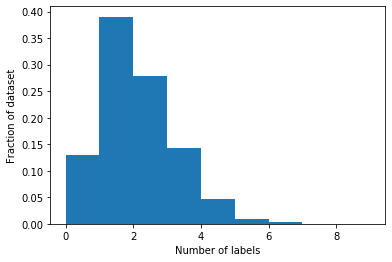

In [237]:
import matplotlib.pyplot as plt

%matplotlib inline


def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

We see that over half of our `train` dataset data points have 2 or fewer labels from LFs.
Fortunately, the labels we do have can be used to train a classifier over the comment text directly, allowing this final machine learning model to generalize beyond what our labeling functions labeling.

Our goal is now to convert the labels from our LFs into a single _noise-aware_ probabilistic (or confidence-weighted) label per data point.
A simple baseline for doing this is to take the majority vote on a per-data point basis: if more LFs voted SPAM than HAM, label it SPAM (and vice versa).
We can test this with the
[`MajorityLabelVoter` baseline model](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.model.baselines.MajorityLabelVoter.html#snorkel.labeling.model.baselines.MajorityLabelVoter).

In [238]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [239]:
preds_train

array([ 1,  1, -1, ...,  1,  1,  1])

However, as we can see from the summary statistics of our LFs in the previous section, they have varying properties and should not be treated identically. In addition to having varied accuracies and coverages, LFs may be correlated, resulting in certain signals being overrepresented in a majority-vote-based model. To handle these issues appropriately, we will instead use a more sophisticated Snorkel `LabelModel` to combine the outputs of the LFs.

This model will ultimately produce a single set of noise-aware training labels, which are probabilistic or confidence-weighted labels. We will then use these labels to train a classifier for our task. For more technical details of this overall approach, see our [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers. For more info on the API, see the [`LabelModel` documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.model.label_model.LabelModel.html#snorkel.labeling.model.label_model.LabelModel).

Note that no gold labels are used during the training process.
The only information we need is the label matrix, which contains the output of the LFs on our training set.
The `LabelModel` is able to learn weights for the labeling functions using only the label matrix as input.
We also specify the `cardinality`, or number of classes.

In [240]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

The majority vote model or more sophisticated `LabelModel` could in principle be used directly as a classifier if the outputs of our labeling functions were made available at test time.
However, these models (i.e. these re-weighted combinations of our labeling function's votes) will abstain on the data points that our labeling functions don't cover (and additionally, may require slow or unavailable features to execute at test time).
In the next section, we will instead use the outputs of the `LabelModel` as training labels to train a discriminative classifier **which can generalize beyond the labeling function outputs** to see if we can improve performance further.
This classifier will also only need the text of the comment to make predictions, making it much more suitable for inference over unseen comments.
For more information on the properties of the label model, see the [Snorkel documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.model.label_model.LabelModel.html#snorkel.labeling.model.label_model.LabelModel).

Let's briefly confirm that the labels the `LabelModel` produces are indeed probabilistic in nature.
The following histogram shows the confidences we have that each data point has the label SPAM.
The points we are least certain about will have labels close to 0.5.

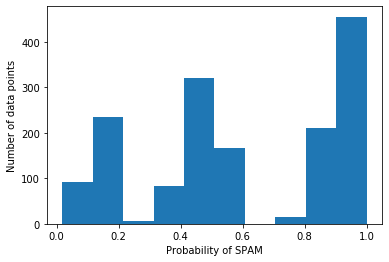

In [241]:


def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, SPAM])

### Filtering out unlabeled data points

As we saw earlier, some of the data points in our `train` set received no labels from any of our LFs.
These data points convey no supervision signal and tend to hurt performance, so we filter them out before training using a
[built-in utility](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.filter_unlabeled_dataframe.html#snorkel.labeling.filter_unlabeled_dataframe).

In [242]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

In [243]:
probs_train_filtered

array([[6.57678162e-01, 3.42321838e-01],
       [4.58454017e-06, 9.99995415e-01],
       [8.94210101e-01, 1.05789899e-01],
       ...,
       [4.65886684e-07, 9.99999534e-01],
       [2.22374736e-03, 9.97776253e-01],
       [1.23528905e-08, 9.99999988e-01]])

## 5. Training a Classifier

In this final section of the tutorial, we'll use the probabilistic training labels we generated in the last section to train a classifier for our task.
**The output of the Snorkel `LabelModel` is just a set of labels which can be used with most popular libraries for performing supervised learning, such as TensorFlow, Keras, PyTorch, Scikit-Learn, Ludwig, and XGBoost.**
In this tutorial, we use the well-known library [Scikit-Learn](https://scikit-learn.org).
**Note that typically, Snorkel is used (and really shines!) with much more complex, training data-hungry models, but we will use Logistic Regression here for simplicity of exposition.**

### Featurization

For simplicity and speed, we use a simple "bag of n-grams" feature representation: each data point is represented by a one-hot vector marking which words or 2-word combinations are present in the comment text.

In [244]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())

### Scikit-Learn Classifier

As we saw in Section 4, the `LabelModel` outputs probabilistic (float) labels.
If the classifier we are training accepts target labels as floats, we can train on these labels directly (see describe the properties of this type of "noise-aware" loss in our [NeurIPS 2016 paper](https://arxiv.org/abs/1605.07723)).

If we want to use a library or model that doesn't accept probabilistic labels (such as Scikit-Learn), we can instead replace each label distribution with the label of the class that has the maximum probability.
This can easily be done using the
[`probs_to_preds` helper method](https://snorkel.readthedocs.io/en/master/packages/_autosummary/utils/snorkel.utils.probs_to_preds.html#snorkel.utils.probs_to_preds).
We do note, however, that this transformation is lossy, as we no longer have values for our confidence in each label.

In [245]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

We then use these labels to train a classifier as usual.

In [246]:
from sklearn.linear_model import LogisticRegression

sklearn_model = LogisticRegression(C=1e3, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=1000.0, solver='liblinear')

In [247]:
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 94.4%


**We observe an additional boost in accuracy over the `LabelModel` by multiple points! This is in part because the discriminative model generalizes beyond the labeling function's labels and makes good predictions on all data points, not just the ones covered by labeling functions.
By using the label model to transfer the domain knowledge encoded in our LFs to the discriminative model,
we were able to generalize beyond the noisy labeling heuristics**.

## Summary

In this tutorial, we accomplished the following:
* We introduced the concept of Labeling Functions (LFs) and demonstrated some of the forms they can take.
* We used the Snorkel `LabelModel` to automatically learn how to combine the outputs of our LFs into strong probabilistic labels.
* We showed that a classifier trained on a weakly supervised dataset can outperform an approach based on the LFs alone as it learns to generalize beyond the noisy heuristics we provide.

### Next Steps

If you enjoyed this tutorial and you've already checked out the [Getting Started](https://snorkel.org/get-started/) tutorial, check out the [Tutorials](https://snorkel.org/use-cases/) page for other tutorials that you may find interesting, including demonstrations of how to use Snorkel

* As part of a [hybrid crowdsourcing pipeline](https://snorkel.org/use-cases/crowdsourcing-tutorial)
* For [visual relationship detection over images](https://snorkel.org/use-cases/visual-relation-tutorial)
* For [information extraction over text](https://snorkel.org/use-cases/spouse-demo)
* For [data augmentation](https://snorkel.org/use-cases/02-spam-data-augmentation-tutorial)

and more!
You can also visit the [Snorkel website](https://snorkel.org) or [Snorkel API documentation](https://snorkel.readthedocs.io) for more info!

## Explaining a labelling prediction using Anchor


In [248]:
# refer to section 4, combine multiple labelling functions
lfs = [
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    regex_check_out,
    short_comment,
    has_person_nlp,
    textblob_polarity,
    textblob_subjectivity,
]


# df_train, df_test = load_spam_dataset()
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train_filtered)
L_test = applier.apply(df=df_test)



100%|██████████| 250/250 [00:00<00:00, 6311.82it/s]


In [249]:
print(L_train)

[[-1 -1  1 ... -1 -1 -1]
 [-1  1 -1 ... -1 -1  0]
 [-1 -1  1 ... -1 -1 -1]
 ...
 [ 1  1 -1 ... -1 -1  0]
 [-1  1 -1 ... -1 -1  0]
 [ 1 -1 -1 ... -1 -1 -1]]


In [250]:
df_train_filtered = df_train_filtered.reset_index(drop=True)
print(df_train_filtered)

                                    author                        date  \
0                         Alessandro leite         2014-11-05T22:21:36   
1                             Salim Tayara         2014-11-02T14:33:30   
2                             Giang Nguyen         2014-11-06T04:55:41   
3                            Praise Samuel         2014-11-08T11:10:30   
4                            Malin Linford         2014-11-05T01:13:43   
5                              Lone Twistt         2013-11-28T17:34:55   
6                                Олег Пась         2014-11-03T23:29:00   
7                                  JD COKE         2014-11-08T02:24:02   
8                             zhichao wang         2013-11-29T02:13:56   
9                             Rancy Gaming         2014-11-06T09:41:07   
10                Bishwaroop Bhattacharjee         2014-11-08T12:34:11   
11                               Tedi Foto         2014-11-08T09:33:30   
12                                 Tee

In [251]:
# df_tmp = df_train[1558:1559]
# df_tmp.reset_index(drop=True)
# print(df_tmp)
# print(df_tmp.at[1558,'text'])


In [252]:
# pick one example in the training data
df_tmp = df_train_filtered[1356:1357]
df_tmp.reset_index(drop=True)
print(df_tmp)
print(df_tmp.at[1356,'text'])


                author date                                           text  \
1356  David Bottenberg  NaN  subscribe to my channel  /watch?v=NxK32i0HkDs   

      label  video  
1356   -1.0      4  
subscribe to my channel  /watch?v=NxK32i0HkDs


In [253]:
# TODO: retrain the label model every time
lfs = [
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    regex_check_out,
    short_comment,
    has_person_nlp,
    textblob_polarity,
    textblob_subjectivity,
]


# df_train, df_test = load_spam_dataset()
applier = PandasLFApplier(lfs=lfs)
# L_train = applier.apply(df=df_train)
# L_test = applier.apply(df=df_test)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

In [254]:
print(L_test.shape)

(250, 10)


In [255]:
# LIME-like baseline
# tuple = (text_id, label1, label2, ..., labeln, snorkel_label)
# train a regression model to predict the snorkel_label
# apply baseline ML exp algorithms to find most important labelling functions

In [256]:
# has to re-define the prediction function
def predict_lr_with_idx(idx):
    df_tmp = df_train_filtered[idx:idx+1]
    df_tmp.reset_index(drop=True)
    def predict_lr(texts):
#     df_tmp.at[1558, 'text'] = texts[0]
        newdf = pd.DataFrame(np.repeat(df_tmp.values, len(texts), axis=0)).reset_index(drop=True)

#         df_tmp.at[idx, 'text'] = texts[0]
        for i in range(len(texts)):
            newdf.at[i, 'text'] = texts[i]
        L_tmp = applier.apply(df=newdf)
#         print(texts, L_tmp)
        res = label_model.predict(L=L_tmp)
        res_type = []
        for x in res:
            res_type.append(type(x))
#         print(res, type(res), res_type)
#         if res[0] == -1:
#             res[0] = 0
        return res
    
    return predict_lr

In [257]:
# # has to re-define the prediction function
# def predict_lr_with_idx(idx):
# #     df_tmp = df_train[idx:idx+1]
# #     df_tmp.reset_index(drop=True)
#     def predict_lr(texts):
# #         df_tmp.at[1558, 'text'] = texts[0]
# #         newdf = pd.DataFrame(np.repeat(df_tmp.values, len(texts), axis=0)).reset_index(drop=True)

#         df_tmp.at[idx, 'text'] = texts[0]
# #         for i in range(len(texts)):
# #             newdf.at[i, 'text'] = texts[i]
#         L_tmp = applier.apply(df=df_tmp)
#         print(texts[0], L_tmp)
#         res = label_model.predict(L=L_tmp)
        
#         print(res)
# #         if res[0] == -1:
# #             res[0] = 0
#         return res
    
#     return predict_lr

In [258]:
# # has to re-define the prediction function
# def predict_lr_with_idx_func(idx):
    
#     def predict_lr(texts, func_id):
# #     df_tmp.at[1558, 'text'] = texts[0]
#         df_tmp.at[idx, 'text'] = texts[0]
#         L_tmp = applier.apply(df=df_tmp)
#         L_tmp[func_id] = ABSTAIN
#         print(texts[0], L_tmp)
#         res = label_model.predict(L=L_tmp)
#         print(res)
#         return res
    
#     return predict_lr

In [259]:
# # has to re-define the prediction function
# def predict_lr_with_idx(idx):
    
#     def predict_lr(texts):
# #     df_tmp.at[1558, 'text'] = texts[0]
#         df_tmp.at[idx, 'text'] = texts[0]
#         L_tmp = applier.apply(df=df_tmp)
#         print(texts[0], L_tmp)
# #         dp = text + L_tmp
# #         model.predict(dp)
#         res = label_model.predict(L=L_tmp)
#         print(res)
#         return res
    
#     return predict_lr

In [260]:
def predict_majority_lr_with_idx(idx):
    
    def predict_lr(texts):
        df_tmp.at[idx, 'text'] = texts[0]
        L_tmp = applier.apply(df=df_tmp)
        print(texts[0], L_tmp)
        return majority_model.predict(L=L_tmp)
    return predict_lr

In [261]:
from anchor import anchor_text
import spacy
import numpy as np

In [262]:
nlp1 = spacy.load('en_core_web_lg')
# explainer = anchor_text.AnchorText(nlp1, [ABSTAIN,HAM, SPAM], use_unk_distribution=True)



In [263]:
explainer = anchor_text.AnchorText(nlp1, [HAM, SPAM], use_unk_distribution=True)

In [264]:
# majority_model.predict(L=np.asarray([[0,-1,1]]))

In [265]:
np.random.seed(3)
# text = ' '.join(['Check out my channel for funny skits! Thanks! '])
text = 'subscribe to my channel  /watch?v=NxK32i0HkDs'
# pred = explainer.class_names[predict_lr([text])[0]]
# alternative =  explainer.class_names[1 - predict_lr([text])[0]]
pred = predict_lr_with_idx(1356)([text])[0]
alternative =  1 - predict_lr_with_idx(1356)([text])[0]
print('Prediction: %s' % pred)


100%|██████████| 1/1 [00:00<00:00, 897.56it/s]

Prediction: 1


In [266]:
# mv_pred = predict_majority_lr_with_idx(1560)([text])[0]
# print('Prediction: %s' % mv_pred)


In [267]:
exp = explainer.explain_instance(text, predict_lr_with_idx(1356), threshold=0.98)

100%|██████████| 10/10 [00:00<00:00, 1519.68it/s]


In [268]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

Anchor: my
Precision: 1.00

Examples where anchor applies and model predicts 1:

UNK UNK my channel   /watch?v UNK UNK
subscribe to my channel UNK /watch?v UNK UNK
subscribe to my channel UNK /watch?v = UNK
UNK to my UNK   UNK UNK NxK32i0HkDs
subscribe UNK my UNK UNK /watch?v = NxK32i0HkDs
subscribe to my UNK UNK /watch?v = NxK32i0HkDs
subscribe UNK my UNK   UNK = NxK32i0HkDs
UNK UNK my channel   /watch?v UNK NxK32i0HkDs
subscribe UNK my channel UNK UNK UNK NxK32i0HkDs
UNK UNK my channel UNK UNK UNK UNK

Examples where anchor applies and model predicts 0:




In [269]:
print('\n'.join([x[0] for x in exp.examples(only_different_prediction=True)]))
print('===============================')
print('\n'.join([x[0] for x in exp.examples()]))
print('===============================')
print('\n'.join([x[0] for x in exp.examples(partial_index=0)]))
# print('================= Print all examples =============')
for x in exp.examples():
    pred = predict_lr_with_idx(1356)(x)
    print(x, pred)


100%|██████████| 1/1 [00:00<00:00, 955.86it/s]


UNK to my channel UNK UNK UNK NxK32i0HkDs
UNK UNK my UNK   UNK UNK NxK32i0HkDs
subscribe UNK my channel   /watch?v UNK UNK
subscribe UNK my UNK   /watch?v UNK UNK
UNK to my channel   UNK = UNK
UNK to my channel   /watch?v = NxK32i0HkDs
subscribe UNK my UNK   UNK = NxK32i0HkDs
UNK to my channel UNK UNK UNK NxK32i0HkDs
UNK to my UNK UNK UNK = UNK
UNK UNK my UNK   UNK = NxK32i0HkDs
UNK to my channel UNK UNK UNK NxK32i0HkDs
UNK UNK my UNK   UNK UNK NxK32i0HkDs
subscribe UNK my channel   /watch?v UNK UNK
subscribe UNK my UNK   /watch?v UNK UNK
UNK to my channel   UNK = UNK
UNK to my channel   /watch?v = NxK32i0HkDs
subscribe UNK my UNK   UNK = NxK32i0HkDs
UNK to my channel UNK UNK UNK NxK32i0HkDs
UNK to my UNK UNK UNK = UNK
UNK UNK my UNK   UNK = NxK32i0HkDs
['UNK to my channel UNK UNK UNK NxK32i0HkDs'] [1]
['UNK UNK my UNK   UNK UNK NxK32i0HkDs'] [1]
['subscribe UNK my channel   /watch?v UNK UNK'] [1]
['subscribe UNK my UNK   /watch?v UNK UNK'] [1]
['UNK to my channel   UNK = UNK'] [1]
['

In [270]:
print('Partial anchor: %s' % (' AND '.join(exp.names(0))))
print('Precision: %.2f' % exp.precision(0))
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

Partial anchor: my
Precision: 1.00

Examples where anchor applies and model predicts [1]:

UNK UNK my channel   /watch?v UNK UNK
subscribe to my channel UNK /watch?v UNK UNK
subscribe to my channel UNK /watch?v = UNK
UNK to my UNK   UNK UNK NxK32i0HkDs
subscribe UNK my UNK UNK /watch?v = NxK32i0HkDs
subscribe to my UNK UNK /watch?v = NxK32i0HkDs
subscribe UNK my UNK   UNK = NxK32i0HkDs
UNK UNK my channel   /watch?v UNK NxK32i0HkDs
subscribe UNK my channel UNK UNK UNK NxK32i0HkDs
UNK UNK my channel UNK UNK UNK UNK

Examples where anchor applies and model predicts 0:




In [271]:
pred = predict_lr_with_idx(1356)(["UNK to my UNK   UNK UNK NxK32i0HkDs"])[0]
print(pred)

100%|██████████| 1/1 [00:00<00:00, 901.23it/s]

1


In [272]:
# Another example
# df_train, df_test = load_spam_dataset()
df_train_filtered = df_train_filtered.reset_index(drop=True)

df_tmp = df_train_filtered[1364:1365]
df_tmp.reset_index(drop=True)
print(df_tmp)
print(df_tmp.at[1364,'text'])
print(applier.apply(df=df_tmp))
# print(predict_lr_with_idx(1364)(df_tmp.at[1364,'text']))

100%|██████████| 1/1 [00:00<00:00, 1043.36it/s]

            author date                                    text  label  video
1364  Wild 'N' Out  NaN  CHECK OUT Eminem - Rap God LYRIC VIDEO   -1.0      4
CHECK OUT Eminem - Rap God LYRIC VIDEO
[[-1 -1 -1 -1 -1  1 -1  0 -1  0]]


In [273]:
text2 = "CHECK OUT Eminem - Rap God LYRIC VIDEO"
exp = explainer.explain_instance(text2, predict_lr_with_idx(1364), threshold=0.98)

100%|██████████| 10/10 [00:00<00:00, 3741.57it/s]


In [274]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

Anchor: LYRIC AND CHECK AND OUT
Precision: 1.00

Examples where anchor applies and model predicts 1:

CHECK OUT Eminem UNK Rap God LYRIC UNK
CHECK OUT UNK - Rap God LYRIC VIDEO
CHECK OUT UNK UNK Rap UNK LYRIC UNK
CHECK OUT Eminem - UNK UNK LYRIC VIDEO
CHECK OUT Eminem - UNK God LYRIC UNK
CHECK OUT Eminem UNK UNK God LYRIC UNK
CHECK OUT UNK UNK Rap UNK LYRIC VIDEO
CHECK OUT Eminem UNK Rap God LYRIC VIDEO
CHECK OUT UNK - UNK UNK LYRIC VIDEO
CHECK OUT Eminem - Rap UNK LYRIC UNK

Examples where anchor applies and model predicts 0:

CHECK UNK Eminem - Rap God LYRIC UNK
UNK OUT Eminem UNK Rap God LYRIC VIDEO
CHECK UNK Eminem - UNK God LYRIC UNK
UNK UNK Eminem - Rap God LYRIC VIDEO
CHECK UNK Eminem - UNK God LYRIC VIDEO
UNK OUT Eminem UNK Rap God LYRIC VIDEO
UNK OUT Eminem UNK Rap God LYRIC UNK
UNK UNK Eminem - UNK God LYRIC VIDEO
UNK UNK Eminem - UNK God LYRIC UNK
UNK UNK Eminem - Rap God LYRIC VIDEO


In [275]:
text2 = "CHECK OUT Eminem - Rap God LYRIC VIDEO LF1:SPAM LF2:HAM LF3:SPAM"
exp = explainer.explain_instance(text2, predict_lr_with_idx(1364), threshold=0.98)

100%|██████████| 10/10 [00:00<00:00, 2310.53it/s]


## Explaining Snorkel Prediction by Perturbing Labelling Functions

In [276]:
import numpy as np
import os
from anchor import utils
from anchor import anchor_tabular
import sklearn
import sklearn.ensemble


In [277]:
# 1. labelling function results as attributes

In [278]:
# df_train, df_test = load_spam_dataset()
df_train_filtered = df_train_filtered.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train_filtered)
L_test = applier.apply(df=df_test)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

100%|██████████| 250/250 [00:00<00:00, 6421.20it/s]


In [279]:
dataset_folder = '/home/zjmiao/Documents/labelling_explanation/data/'


In [280]:
text_id = np.array(df_train_filtered.index)
text_id = np.reshape(text_id, (-1, 1))

In [281]:
lm_pred = label_model.predict(L_train)

In [282]:
lm_pred = np.reshape(lm_pred, (-1, 1))

In [283]:
lm_pred_test = label_model.predict(L_test)

In [284]:
lm_pred_test

array([ 1,  0,  1,  0,  0,  0,  1,  0,  1,  1,  1,  0,  1,  0,  1,  0,  1,
        1,  0,  1,  0,  1,  1,  0,  0,  1,  0, -1,  0, -1,  1,  1,  0,  1,
        0,  1,  1,  0,  1,  0,  1,  0,  1,  1,  1, -1,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  1,  1,  0,  0,  1,  0,  0,  1, -1,  1,  0,  0,  1,
        1,  1,  1,  0,  0,  1,  0,  1,  1,  1,  0,  0,  0,  1,  0,  0,  0,
        1,  0,  0,  1,  0,  1,  1,  1,  0,  0,  0,  0,  1,  1,  0,  1,  1,
        1,  0,  0,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
       -1,  1,  1, -1,  0,  0,  0,  1,  0, -1,  0,  0,  1,  0,  0, -1,  1,
        1,  1,  0,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  0,  1,  0,
        1,  1,  1, -1, -1,  0, -1,  1,  0,  1,  1,  0,  1,  1,  1,  0,  1,
       -1,  0,  1,  0,  0,  0,  1,  1,  0,  1,  1,  1,  1,  0, -1,  1,  1,
        1,  1,  1,  0,  1,  0, -1,  0,  1,  0,  0,  1,  0, -1,  0,  1,  0,
        1,  0,  0,  1,  0,  1,  1,  1,  0,  1, -1,  0,  1,  0,  0,  0,  0,
        1,  0,  0,  1,  0

In [285]:
lm_data = np.concatenate((text_id, L_train, lm_pred), axis=1)

In [286]:
np.savetxt(dataset_folder+'spam.tmp.csv', lm_data, fmt='%d', delimiter=",")


In [287]:
features_to_use = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
feature_names = ["text_id", "0:keyword_my", "1:keyword_subscribe",
    "2:keyword_link",
    "3:keyword_please",
    "4:keyword_song",
    "5:regex_check_out",
    "6:short_comment",
    "7:has_person_nlp",
    "8:textblob_polarity",
    "9:textblob_subjectivity", "Snorkel_prediction"]
categorical_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
dataset = utils.load_csv_dataset(
            os.path.join(dataset_folder, 'spam.tmp.csv'),
            11, ',', feature_names=feature_names,
            features_to_use=features_to_use,
            feature_transformations=None, fill_na='-999',
            categorical_features=categorical_features, discretize=False,
            filter_fn=None)
# dataset.class_names = ['HAM', 'SPAM']

In [288]:
print(dataset.class_names)
print(dataset.feature_names)
print(dataset.labels_test)
print(dataset.labels_train)
print(dataset.categorical_names)

[b'0', b'1']
['text_id', '0:keyword_my', '1:keyword_subscribe', '2:keyword_link', '3:keyword_please', '4:keyword_song', '5:regex_check_out', '6:short_comment', '7:has_person_nlp', '8:textblob_polarity', '9:textblob_subjectivity']
[1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 0 0
 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1
 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1
 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0]
[0 0 1 ... 0 0 1]
{1: ['-1', '1'], 2: ['-1', '1'], 3: ['-1', '1'], 4: ['-1', '1'], 5: ['-1', '0'], 6: ['-1', '1'], 7: ['-1', '0'], 8: ['-1', '0'], 9: ['-1', '0'], 10: ['-1', '0']}


In [289]:
dataset.train


array([[4.430e+02, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [9.000e+01, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.131e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       ...,
       [1.096e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.350e+02, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.061e+03, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [290]:
lm_data

array([[   0,   -1,   -1, ...,   -1,   -1,    0],
       [   1,   -1,    1, ...,   -1,    0,    1],
       [   2,   -1,   -1, ...,   -1,   -1,    0],
       ...,
       [1377,    1,    1, ...,   -1,    0,    1],
       [1378,   -1,    1, ...,   -1,    0,    1],
       [1379,    1,   -1, ...,   -1,   -1,    1]])

In [291]:
c = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=5)
c.fit(dataset.train, dataset.labels_train)
print('Train', sklearn.metrics.accuracy_score(dataset.labels_train, c.predict(dataset.train)))
print('Test', sklearn.metrics.accuracy_score(dataset.labels_test, c.predict(dataset.test)))

Train 1.0
Test 0.9855072463768116


In [292]:
from sklearn.linear_model import LinearRegression
lc = LinearRegression().fit(dataset.train, dataset.labels_train)
# print('Train', sklearn.metrics.accuracy_score(dataset.labels_train, lc.predict(dataset.train)))
# print('Test', sklearn.metrics.accuracy_score(dataset.labels_test, lc.predict(dataset.test)))
print(lc.score(dataset.train, dataset.labels_train))
print(lc.score(dataset.test, dataset.labels_test))

0.6680889045544347
0.6702629862582002


In [293]:
tab_explainer = anchor_tabular.AnchorTabularExplainer(
    dataset.class_names,
    dataset.feature_names,
    dataset.train,
    dataset.categorical_names)

In [294]:
dataset.categorical_names

{1: ['-1', '1'],
 2: ['-1', '1'],
 3: ['-1', '1'],
 4: ['-1', '1'],
 5: ['-1', '0'],
 6: ['-1', '1'],
 7: ['-1', '0'],
 8: ['-1', '0'],
 9: ['-1', '0'],
 10: ['-1', '0']}

In [295]:
exp_ins = dataset.train[np.where(dataset.train[:,0] == 1364)][0]
print(exp_ins)

[1.364e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00]


In [296]:
# exp_ins = dataset.test[np.where(dataset.test[:,0] == 1569)][0]
# print(exp_ins)
# #1: ['-1', '1'], 2: ['-1', '1'], 3: ['-1', '1'], 4: ['-1', '1'], 5: ['-1', '0'], 
# #6: ['-1', '1'], 7: ['-1', '0'], 8: ['-1', '0'], 9: ['-1', '0'], 10: ['-1', '0']}

In [297]:
# dataset.test[np.where((dataset.test[:,1] == 0) * (dataset.test[:,2] == 0) * (dataset.test[:,6] == 1) *
#                       (dataset.test[:,7] == 0) * (dataset.test[:,8] == 1) * (dataset.test[:,9] == 0) * 
#                       (dataset.test[:,10] == 1))]

In [298]:
lm_data[np.where(lm_data[:,0] == 1364)][0]

array([1364,   -1,   -1,   -1,   -1,   -1,    1,   -1,    0,   -1,    0,
          1])

In [299]:
df_train_filtered[1364:1365]
# 1569,-1,-1,-1,-1,-1,1,-1,0,-1,0,1


,author,date,text,label,video
1364,Wild 'N' Out,NaN,CHECK OUT Eminem - Rap God LYRIC VIDEO,-1.0,4


In [300]:
applier.apply(df=df_train_filtered[1364:1365])

100%|██████████| 1/1 [00:00<00:00, 554.88it/s]


array([[-1, -1, -1, -1, -1,  1, -1,  0, -1,  0]])

In [301]:
exp_ins.reshape(1, -1)
c.predict(exp_ins.reshape(1, -1))[0]

1

In [302]:
# exp_ins.reshape(1, -1).tolist()
exp_ins.reshape(1, -1)[:, [i  for i in range(1, 11)]].astype(int)


array([[0, 0, 0, 0, 0, 1, 0, 1, 0, 1]])

In [303]:
np.random.seed(1)
print('Prediction: ', tab_explainer.class_names[c.predict(exp_ins.reshape(1, -1))[0]])
exp = tab_explainer.explain_instance(exp_ins, c.predict, threshold=0.9)

Prediction:  b'1'


In [304]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: 5:regex_check_out = 1 AND 6:short_comment = -1
Precision: 1.00
Coverage: 0.27


In [305]:
print('Partial anchor: %s' % (' AND '.join(exp.names(0))))
print('Precision: %.2f' % exp.precision(0))
print('Precision: %.2f' % exp.coverage(0))
print()

Partial anchor: 5:regex_check_out = 1
Precision: 0.79
Precision: 0.27



In [306]:
# has to re-define the prediction function
def predict_lr_tabular(row):
    print(row.shape)
    d = row[:, [i  for i in range(1, 11)]].astype(int)
#     dataset.categorical_names
    print(d.shape)

    L_tmp = np.apply_along_axis(lambda x: list(map(lambda  y: int(dataset.categorical_names[y[0]+1][y[1]]), 
                                              enumerate(x.tolist()))), 1, d)
    
# def array_map(x):
#     return np.array(list(map(f, x)))
    
    res = label_model.predict(L=L_tmp)
    print(L_tmp, res)
    return res
    


In [307]:
np.random.seed(1)
print('Prediction: ', tab_explainer.class_names[predict_lr_tabular(exp_ins.reshape(1, -1))[0]])
exp = tab_explainer.explain_instance(exp_ins, predict_lr_tabular, threshold=0.95)

(1, 11)
(1, 10)
[[-1 -1 -1 -1 -1  1 -1  0 -1  0]] [1]
Prediction:  b'1'
(1, 11)
(1, 10)
[[-1 -1 -1 -1 -1  1 -1  0 -1  0]] [1]
(1, 11)
(1, 10)
[[ 1 -1 -1 -1 -1  1 -1 -1 -1  0]] [1]
(100, 11)
(100, 10)
[[-1 -1 -1 -1 -1  1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1  1 -1 -1 -1 -1]
 [-1 -1 -1  1 -1 -1 -1 -1 -1  0]
 [-1 -1 -1 -1 -1 -1  0 -1 -1 -1]
 [-1 -1 -1 -1 -1  1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  0 -1 -1  0]
 [-1 -1 -1 -1  0 -1 -1 -1 -1 -1]
 [-1 -1  1 -1 -1 -1  0 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [-1 -1 -1 -1 -1  1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  0 -1 -1  0]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1  1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  0 -1 -1 -1]
 [-1 -1  1 -1 -1 -1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1 -1  0  0 -1 -1]
 [-1 -1 -1 -1 -1  1 -1 -1 -1 -1]
 [-1 -1 -1 -1  0 -1  0 -1 -1  0]
 [-1 -1  1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1  0 -1  0 -1 -1  0]
 [ 1  1 -1  1 -1 -1 -1 -1  0 -1]
 [-1 -1  1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1  0 -1 -1 -1]
 [-1 -1 

In [308]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: 5:regex_check_out = 1 AND 6:short_comment = -1
Precision: 0.98
Coverage: 0.27


In [309]:
# 1. Use SHAP for tabular data expl
# 2. Removing labelling function and retrain Snorkel
# 3. Append LF results to the text as tokens

## Explaining Snokerl Prediction using SHAP 

In [310]:
import shap

shap.initjs()

In [311]:
print("Accuracy = {0}%".format(100*np.sum(c.predict(dataset.test) == dataset.labels_test)/len(dataset.labels_test)))

Accuracy = 98.55072463768116%


In [312]:
# explain all the predictions in the test set
shap_explainer = shap.KernelExplainer(c.predict_proba, dataset.train)
shap_values = shap_explainer.shap_values(dataset.test)
shap.force_plot(shap_explainer.expected_value[0], shap_values[0], dataset.test)

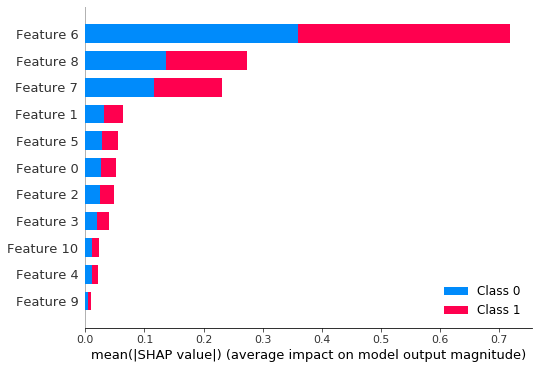

In [319]:
shap.summary_plot(shap_values, dataset.test)


In [315]:
shap_values = shap_explainer.shap_values(dataset.train[np.where(dataset.train[:,0] == 1364)])
shap.force_plot(shap_explainer.expected_value[0], shap_values[0], dataset.train[np.where(dataset.train[:,0] == 1364)])

In [320]:
print("Accuracy = {0}%".format(100*np.sum(predict_lr_tabular(dataset.test) == dataset.labels_test)/len(dataset.labels_test)))

(138, 11)
(138, 10)
[[-1 -1  1 ... -1 -1  0]
 [-1  1  1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1  0]
 ...
 [-1 -1 -1 ... -1 -1  0]
 [-1 -1 -1 ... -1 -1  0]
 [-1 -1  1 ... -1 -1 -1]] [1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 0 0
 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1
 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1
 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0]
Accuracy = 100.0%


In [321]:
# has to re-define the prediction function
def predict_lr_proba_tabular(row):
    d = row[:, [i  for i in range(1, 11)]].astype(int)
    L_tmp = np.apply_along_axis(lambda x: list(map(lambda  y: int(dataset.categorical_names[y[0]+1][y[1]]), 
                                              enumerate(x.tolist()))), 1, d)
    
    res = label_model.predict_proba(L=L_tmp)
    return res
    

In [322]:
# explain all the predictions in the test set
shap_explainer_snorkerl = shap.KernelExplainer(predict_lr_proba_tabular, dataset.train)
shap_values_snorkerl1 = shap_explainer_snorkerl.shap_values(dataset.test)


In [323]:

dataset.feature_names

['text_id',
 '0:keyword_my',
 '1:keyword_subscribe',
 '2:keyword_link',
 '3:keyword_please',
 '4:keyword_song',
 '5:regex_check_out',
 '6:short_comment',
 '7:has_person_nlp',
 '8:textblob_polarity',
 '9:textblob_subjectivity']

In [327]:
#shap.initjs()
shap.force_plot(shap_explainer_snorkerl.expected_value[0], 
                shap_values_snorkerl1[0], dataset.test)

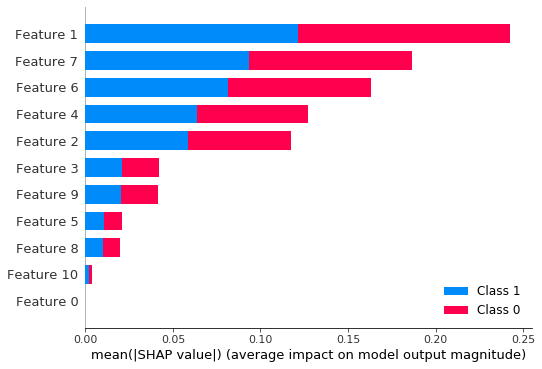

In [328]:
shap.summary_plot(shap_values_snorkerl1, dataset.test)


In [329]:
shap_values_snorkerl2 = shap_explainer_snorkerl.shap_values(
    dataset.train[np.where(dataset.train[:,0] == 1364)])
shap.force_plot(shap_explainer_snorkerl.expected_value[0], 
                shap_values_snorkerl2[0], dataset.train[np.where(dataset.train[:,0] == 1364)])

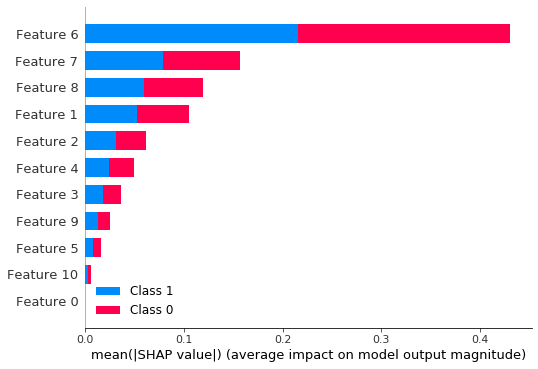

In [330]:
shap.summary_plot(shap_values_snorkerl2, dataset.train[np.where(dataset.train[:,0] == 1364)])


## Baseline Method: Remove Labelling Function and Retrain Snorkel

In [127]:
# applier = PandasLFApplier(lfs=lfs)
# L_train = applier.apply(df=df_train_filtered)
# L_test = applier.apply(df=df_test)

# label_model = LabelModel(cardinality=2, verbose=True)
# label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)


In [128]:
intervened_models = []
for i in range(len(lfs)):
    intervened_models.append(LabelModel(cardinality=2, verbose=True))
    cols = [j for j in range(len(lfs))]
    cols.remove(i)
    intervened_models[-1].fit(L_train=L_train[:, cols], n_epochs=500, log_freq=100, seed=123)
    

In [129]:
# The Check Out example
idx = 1364
for i in range(len(lfs)):
    df_tmp = df_train_filtered[idx:idx+1]
    cols = [j for j in range(len(lfs))]
    cols.remove(i)
    L_tmp = applier.apply(df=df_tmp)
    original_res = label_model.predict(L_tmp)
    res = intervened_models[i].predict(L=L_tmp[:, cols])
    print(lfs[i], "Original prediction: ", original_res, "Prediction after removal: ", res)

100%|██████████| 1/1 [00:00<00:00, 1104.35it/s]

LabelingFunction keyword_my, Preprocessors: [] Original prediction:  [1] Prediction after removal:  [1]
LabelingFunction keyword_subscribe, Preprocessors: [] Original prediction:  [1] Prediction after removal:  [1]
LabelingFunction keyword_http, Preprocessors: [] Original prediction:  [1] Prediction after removal:  [1]
LabelingFunction keyword_please, Preprocessors: [] Original prediction:  [1] Prediction after removal:  [1]
LabelingFunction keyword_song, Preprocessors: [] Original prediction:  [1] Prediction after removal:  [1]
LabelingFunction regex_check_out, Preprocessors: [] Original prediction:  [1] Prediction after removal:  [0]
LabelingFunction short_comment, Preprocessors: [] Original prediction:  [1] Prediction after removal:  [0]
NLPLabelingFunction has_person_nlp, Preprocessors: [SpacyPreprocessor SpacyPreprocessor, Pre: []] Original prediction:  [1] Prediction after removal:  [1]
LabelingFunction textblob_polarity, Preprocessors: [LambdaMapper textblob_sentiment, Pre: []] 

In [130]:
original_res_train = label_model.predict(L_train)
original_res_test = label_model.predict(L_test)


In [131]:
original_res_train

array([0, 1, 0, ..., 1, 1, 1])

In [132]:
# check how many training/testing examples are flipped
res_train = []
res_test = []
for i in range(len(lfs)):
    cols = [j for j in range(len(lfs))]
    cols.remove(i)
    L_tmp_train = applier.apply(df=df_train_filtered)
    L_tmp_test = applier.apply(df=df_test)
    res_train.append(intervened_models[i].predict(L=L_tmp_train[:, cols]))
    res_test.append(intervened_models[i].predict(L=L_tmp_test[:, cols]))

100%|██████████| 250/250 [00:00<00:00, 6477.17it/s]


In [133]:
# res_test[0] - original_res_test
for i in range(len(lfs)):
    flip_cnt = 0
    for index, value in enumerate(res_train[i]):
        if value != original_res_train[index]:
            flip_cnt += 1
    print("After removing", lfs[i], ", there are ", flip_cnt, "/", len(original_res_train), " or ", flip_cnt / len(original_res_train), " train examples got flipped")

    flip_cnt_test = 0
    for index, value in enumerate(res_test[i]):
        if value != original_res_test[index]:
            flip_cnt_test += 1
    print(" and ", flip_cnt_test, "/", len(original_res_test), " or ", flip_cnt_test / len(original_res_test), " test examples got flipped")
    

After removing LabelingFunction keyword_my, Preprocessors: [] , there are  214 / 1380  or  0.15507246376811595  train examples got flipped
 and  21 / 250  or  0.084  test examples got flipped
After removing LabelingFunction keyword_subscribe, Preprocessors: [] , there are  59 / 1380  or  0.042753623188405795  train examples got flipped
 and  13 / 250  or  0.052  test examples got flipped
After removing LabelingFunction keyword_http, Preprocessors: [] , there are  197 / 1380  or  0.1427536231884058  train examples got flipped
 and  25 / 250  or  0.1  test examples got flipped
After removing LabelingFunction keyword_please, Preprocessors: [] , there are  140 / 1380  or  0.10144927536231885  train examples got flipped
 and  20 / 250  or  0.08  test examples got flipped
After removing LabelingFunction keyword_song, Preprocessors: [] , there are  101 / 1380  or  0.07318840579710145  train examples got flipped
 and  17 / 250  or  0.068  test examples got flipped
After removing LabelingFuncti

## Perturbing LF Results and Text at the Same Time

In [99]:
# 3. Append LF results to the text as tokens


In [75]:
from torch.utils import data

class TextLabellingDataset(data.Dataset):
    def __init__(self, dataset, vocab, tokenizer, max_len=512):
        self.vocab = vocab
        self.max_len = max_len
        self.tokenizer = tokenizer
        # read path
        if isinstance(dataset, str):
            return
        else:
            (texts, lf_results, pred_labels) = dataset
        sents = []
        lfrs = []
        labels = []
        for i, x in enumerate(zip(texts, lf_results, pred_labels)):
            e = x[0]
            lfr = x[1]
            l = x[2]
            sents.append(e)
            # lfr_str = '[LFR]'.join(self.tokenizer(lfr))
            # lfrs.append(['[LFR]'] + lfr_str.split('[LFR]'))
            lfrs.append(lfr)
            labels.append(l)
        self.sents = sents
        self.lfrs = lfrs
        self.labels = labels
        # vocab
        self.tag2idx = {tag: idx for idx, tag in enumerate(self.vocab)}
        self.idx2tag = {idx: tag for idx, tag in enumerate(self.vocab)}

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        """Return the ith item of in the dataset.
        Args:
            idx (int): the element index
        Returns (TODO):
            words, x, is_heads, tags, mask, y, seqlen, self.taskname
        """
        words, lfr, label = self.sents[idx], self.lfrs[idx], self.labels[idx]        
        tokens = ["[CLS]"] + self.tokenizer.tokenize(words) +  ["[SEP]"]
        tokens += self.tokenizer.tokenize(' '.join(lfr)) +  ["[SEP]"]
        x = tokenizer.convert_tokens_to_ids(tokens)[:self.max_len]
        y = self.tag2idx[label] # label
        mask = [1] * len(x)

        assert len(x)==len(mask), \
          f"len(x)={len(x)}, len(y)={len(y)}, len(is_heads)={len(is_heads)}"
        # seqlen
        seqlen = len(mask)

        return words, x, label, mask, y, seqlen

    @staticmethod
    def pad(batch):
        '''Pads to the longest sample
        Args:
            batch:
        Returns (TODO):
            return words, f(x), is_heads, tags, f(mask), f(y), seqlens, name
        '''
        f = lambda x: [sample[x] for sample in batch]
        g = lambda x, seqlen, val: \
              [sample[x] + [val] * (seqlen - len(sample[x])) \
               for sample in batch] # 0: <pad>

        # get maximal sequence length
        seqlens = f(5)
        maxlen = np.array(seqlens).max()

        words = f(0)
        x = g(1, maxlen, 0)
        tags = f(2)
        mask = g(3, maxlen, 1)
        y = f(4)

        f = torch.LongTensor
        if isinstance(y[0], float):
            y = torch.Tensor(y)
        else:
            y = torch.LongTensor(y)
        return words, f(x), tags, f(mask), y, seqlens

   

In [101]:
np.random.seed(1)
text2 = "CHECK OUT Eminem - Rap God LYRIC VIDEO"
exp = explainer.explain_instance(text2, predict_lr_with_idx(1569), threshold=0.98)
pred = predict_lr([text2])[0]
print('Prediction: %s' % pred)


  0%|          | 0/10 [00:00<?, ?it/s]

[1] <class 'numpy.ndarray'> [<class 'numpy.int64'>]
[1] <class 'numpy.ndarray'> [<class 'numpy.int64'>]
[ 1  1  1  0  1 -1 -1  1 -1  1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[1 1 1 1 1 1 1 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]


  0%|          | 0/10 [00:00<?, ?it/s]

[0 0 1 1 1 1 1 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[ 1  0 -1  1  1  1  1  1 -1  1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[-1 -1  1  1  1  1  1  1  1  1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[-1  1  1  0  1 -1  1 -1  1  1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, 

  0%|          | 0/10 [00:00<?, ?it/s]

[-1 -1 -1  1  1 -1 -1  1  1  1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[-1  1  1 -1  1  1  1 -1 -1  1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[ 1  1  1  1  1  0  1  1 -1 -1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[1 1 1 1 1 1 1 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, 

  0%|          | 0/10 [00:00<?, ?it/s]

[1 1 1 1 1 1 1 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[-1  1 -1  1  0  0  1 -1  1  1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[1 1 1 1 1 1 0 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[ 1  1  1  1  0 -1  1  1 -1  1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'nu

100%|██████████| 10/10 [00:00<00:00, 401.80it/s]


[ 1 -1  0  1 -1  1  1  1  0 -1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[1 1 1 1 0 1 1 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[-1  1  0  0 -1 -1 -1  1  1  1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[1 1 1 1 1 1 1 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'nu

100%|██████████| 10/10 [00:00<00:00, 778.18it/s]


[-1  1  1 -1  1  1 -1 -1  1  0] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[1 1 1 0 1 1 1 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[ 1  0  1  0 -1  1  0  1 -1 -1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[0 1 1 1 1 0 1 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'nu

  0%|          | 0/10 [00:00<?, ?it/s]

[-1 -1  0  0  1  1  1 -1 -1  1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[1 1 1 1 1 1 1 1 0 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[ 1  0  1 -1  1  0 -1  0  0  1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[1 0 1 1 1 1 1 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'nu

  0%|          | 0/10 [00:00<?, ?it/s]

[ 1 -1  1 -1  1 -1 -1  1  1  1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[1 1 1 1 1 1 1 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[ 1  1  1 -1  1 -1  1  1 -1 -1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[1 1 0 1 1 1 1 1 0 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'nu

100%|██████████| 10/10 [00:00<00:00, 4615.72it/s]


[1 1 1 1 1 1 1 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[-1 -1 -1  1  1  1  1  1  1  1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[1 1 1 0 1 1 1 1 0 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[ 1  1 -1  1  1  1 -1  1  1  1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'nu

100%|██████████| 10/10 [00:00<00:00, 4508.07it/s]


[1 1 1 1 1 1 1 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[1 1 1 1 1 1 0 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[1 1 1 1 0 1 1 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[1 1 1 1 1 1 1 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 

100%|██████████| 10/10 [00:00<00:00, 4428.11it/s]


[1 1 1 0 1 1 1 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[1 1 1 1 1 0 1 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[0 1 1 1 1 1 1 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
[1 1 0 1 1 1 1 1 1 1] <class 'numpy.ndarray'> [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 

NameError: name 'predict_lr' is not defined

In [102]:
import torch
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW, BertConfig



In [204]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# bert_model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [103]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification


tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',  
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [104]:
classes = ['HAM', 'SPAM']
lf_vocab = [ABSTAIN, HAM, SPAM]
res2tag = {-1: 'ABSTAIN', 0: 'HAM', 1: 'SPAM'}
for i in range(len(lfs)):    
    print(len(tokenizer))  # 28996
    
    tokenizer.add_tokens(["LF{}:{}".format(str(i), res2tag[j]) for j in lf_vocab])
    print(len(tokenizer))  # 28997

    bert_model.resize_token_embeddings(len(tokenizer)) 

30522
30525
30525
30528
30528
30531
30531
30534
30534
30537
30537
30540
30540
30543
30543
30546
30546
30549
30549
30552


In [207]:
bert_model.load_state_dict(torch.load('saved_distilbert.pt'))


<All keys matched successfully>

In [105]:
tokenizer.tokenize('[CLS] Nimam [SEP] LF1:HAM LF2:ABSTAIN [SEP]')


['[CLS]', 'ni', '##ma', '##m', '[SEP]', 'lf1:ham', 'lf2:abstain', '[SEP]']

In [106]:
texts = list(df_train_filtered.text)
texts_test = list(df_test.text)

,author,date,text,label,video
235,ricky swaggz,2013-07-20T22:09:23.728000,******* Facebook is LAME and so 2004! Check ou...,1,5


In [213]:
texts_test[211]

'SO THEN HOW ARE YOU GOING TO CALL YOURSELF A INSTRUMENTAL SONGWRITER IF THERES NO SINGING THERES NO SONG TO WRITE!?!?! LOL.   YOU GOT ALOT TO LEARN KID BUT HEY DON&#39;T FORGET TO SUBSCRIBE!'

In [107]:
for i, x in enumerate(texts):
    if 'Eminem ' in x and 'LYRIC ' in x:
        print(i, x)

1364 CHECK OUT Eminem - Rap God LYRIC VIDEO


In [108]:
lfrs = list(map(lambda x: list(map(lambda y:'LF' + str(y[0]) + ':' + res2tag[y[1]], enumerate(x))), L_train.tolist()))


In [109]:
lfrs[1364]

['LF0:ABSTAIN',
 'LF1:ABSTAIN',
 'LF2:ABSTAIN',
 'LF3:ABSTAIN',
 'LF4:ABSTAIN',
 'LF5:SPAM',
 'LF6:ABSTAIN',
 'LF7:HAM',
 'LF8:ABSTAIN',
 'LF9:HAM']

In [110]:
lfrs_test = list(map(lambda x: list(map(lambda y:'LF' + str(y[0]) + ':' + res2tag[y[1]], 
                                        enumerate(x))), 
                     L_test.tolist()))

In [236]:
for idx in range(len(lfrs_test)):
    if 10 <= len(texts_test[idx].split(' ')) and len(texts_test[idx].split(' ')) <= 30:
        cnt = 0 
        for j in range(10):
            if 'ABSTAIN' in lfrs_test[idx][j]:
                cnt += 1
        if cnt <= 8:
            print('=========================')
            print(texts_test[idx])
            print(df_test[idx:idx+1].label)
            print(lfrs_test[idx])

Subscribe my channel  I RECORDING FIFA 15 GOALS WATCH NOW :D﻿
2    1
Name: label, dtype: int64
['LF0:SPAM', 'LF1:SPAM', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN']
SEE SOME MORE SONG OPEN GOOGLE AND TYPE Shakira GuruOfMovie﻿
4    1
Name: label, dtype: int64
['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:HAM', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM']
Subscribe to my Youtube Channel!! :) Suscribite a mi canal de Youtube -WhatUKnow
9    1
Name: label, dtype: int64
['LF0:SPAM', 'LF1:SPAM', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM']
i am from Brazil please subscribe my channel love you all﻿
12    1
Name: label, dtype: int64
['LF0:SPAM', 'LF1:SPAM', 'LF2:ABSTAIN', 'LF3:SPAM', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM']
Oh my god go to 1 billion of replay i lov

In [233]:
print(lfs)

[LabelingFunction keyword_my, Preprocessors: [], LabelingFunction keyword_subscribe, Preprocessors: [], LabelingFunction keyword_http, Preprocessors: [], LabelingFunction keyword_please, Preprocessors: [], LabelingFunction keyword_song, Preprocessors: [], LabelingFunction regex_check_out, Preprocessors: [], LabelingFunction short_comment, Preprocessors: [], NLPLabelingFunction has_person_nlp, Preprocessors: [SpacyPreprocessor SpacyPreprocessor, Pre: []], LabelingFunction textblob_polarity, Preprocessors: [LambdaMapper textblob_sentiment, Pre: []], LabelingFunction textblob_subjectivity, Preprocessors: [LambdaMapper textblob_sentiment, Pre: []]]


In [226]:
labels_train = list(map(lambda x: res2tag[x], np.reshape(lm_pred, (1, -1)).tolist()[0]))
labels_test = list(map(lambda x: res2tag[x], Y_test.tolist()))

In [112]:
train_dataset = TextLabellingDataset((texts, lfrs, labels_train), classes, tokenizer, max_len=512)
test_dataset = TextLabellingDataset((texts_test, lfrs_test, labels_test), classes, tokenizer, max_len=512)

In [113]:
train_dataset.idx2tag

{0: 'HAM', 1: 'SPAM'}

In [114]:
train_dataset[1364]

('CHECK OUT Eminem - Rap God LYRIC VIDEO',
 [101,
  4638,
  2041,
  12495,
  25832,
  1011,
  9680,
  2643,
  13677,
  2678,
  102,
  30522,
  30525,
  30528,
  30531,
  30534,
  30539,
  30540,
  30544,
  30546,
  30550,
  102],
 'SPAM',
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 1,
 22)

## Train BERT model for labelling on text+ LF results

In [115]:
optimizer = AdamW(bert_model.parameters(), lr = 3e-5, eps = 1e-8)
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
batch_size = 8
n_epochs = 5
num_steps = (len(train_dataset) // batch_size) * n_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=num_steps)

In [116]:
def train(model, train_set, optimizer, scheduler=None, batch_size=32):
    """Perfrom one epoch of the training process.
    """
    iterator = data.DataLoader(dataset=train_set,
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers=1,
                               collate_fn=TextLabellingDataset.pad)

    model.train()
    total_train_loss = 0
    for i, batch in enumerate(iterator):
        # for monitoring
        words, x, tags, mask, y, seqlens = batch
#         print(len(words), len(x), len(tags), len(y), len(seqlens))
        _y = y

        # forward
        bert_model.zero_grad()       
#         optimizer.zero_grad()
                
        loss, logits = bert_model(x, 
                     attention_mask=mask,
                     labels=_y)
#         print(loss, logits)
        total_train_loss += loss.item()
        

        # back propagation    
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
        optimizer.step()
        if scheduler:
            scheduler.step()

        if i%100 == 0: # monitoring
            print(f"step: {i},  loss: {loss.item()}")
            del loss
     # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataset)            
    print("  Average training loss: {0:.2f}".format(avg_train_loss))



In [121]:
# start training
import time

best_dev_f1 = best_test_f1 = 0.0
save_model = True
bert_model.train()
for epoch in range(1, n_epochs+1):
    t0 = time.time()

    train(bert_model,
          train_dataset,
          optimizer,
          scheduler=scheduler,
          batch_size=batch_size)
    

    print(f"=========eval at epoch={epoch}=========")
    accuracy, precision, recall, f1, loss = eval_bert_classification(test_dataset)
    print(accuracy, precision, recall, f1, loss)
    if save_model:
        if f1 > best_test_f1:
            best_test_f1 = f1
            torch.save(bert_model.state_dict(), 'best_test.pt')

    training_time = str(time.time() - t0)
    print("")
    print("  Training epcoh took: {:}".format(training_time))




step: 0,  loss: 0.6472492814064026
step: 100,  loss: 0.24211789667606354
  Average training loss: 0.04
=========eval at epoch=1=========
accuracy=0.888
precision=0.863
recall=0.907
f1=0.884
0.888 0.8629032258064516 0.9067796610169492 0.8842975206611571 tensor(0.1510)

  Training epcoh took: 159.42102241516113
step: 0,  loss: 0.00980943813920021
step: 100,  loss: 0.0022701136767864227
  Average training loss: 0.01
=========eval at epoch=2=========
accuracy=0.844
precision=0.850
recall=0.814
f1=0.831
0.844 0.8495575221238938 0.8135593220338984 0.8311688311688311 tensor(0.7746)

  Training epcoh took: 150.9967770576477
step: 0,  loss: 0.001614553271792829
step: 100,  loss: 0.0007857608725316823
  Average training loss: 0.00
=========eval at epoch=3=========
accuracy=0.860
precision=0.837
recall=0.873
f1=0.855
0.86 0.8373983739837398 0.8728813559322034 0.8547717842323652 tensor(2.2435)

  Training epcoh took: 154.562180519104
step: 0,  loss: 0.0006836985121481121
step: 100,  loss: 0.000854

In [ ]:
# torch.save(bert_model.state_dict(), 'saved_distilbert.pt')

In [122]:
bert_model.load_state_dict(torch.load('best_test.pt'))

<All keys matched successfully>

In [120]:

lfr = ['LF0:ABSTAIN',
 'LF1:ABSTAIN',
 'LF2:ABSTAIN',
 'LF3:ABSTAIN',
 'LF4:ABSTAIN',
 'LF5:SPAM',
 'LF6:ABSTAIN',
 'LF7:HAM',
 'LF8:ABSTAIN',
 'LF9:HAM']
# labels_list = list(map(lambda x: res2tag[x], [0 for i in range(len(texts))]))
labels = ['HAM']


predict_bert(['great song, but we all know that Katy buys her views..﻿,'], [lfr], labels)

[0]


[0]

In [118]:
def predict_bert(texts, lfrs, labels):
    dataset = TextLabellingDataset((texts, lfrs, labels), classes, tokenizer, max_len=512)
    iterator = data.DataLoader(dataset=dataset,
                               batch_size=32,
                               shuffle=True,
                               num_workers=1,
                               collate_fn=TextLabellingDataset.pad)

    Y_hat = []
#     print(texts, lfrs, labels)
    bert_model.eval()
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            _, x, _, mask, y, _ = batch
            _y = y
            
            loss, logits = bert_model(x, 
                         attention_mask=mask,
                         labels=_y)
            logits = bert_model(x, attention_mask=mask, labels=None)
            y_hat = logits[0].argmax(-1)
            Y_hat.extend(y_hat.tolist())
#     print(Y_hat)
    return np.array(Y_hat)


In [119]:
import sklearn.metrics as metrics

def eval_bert_classification(dataset):
    iterator = data.DataLoader(dataset=test_dataset,
                           batch_size=32,
                           shuffle=True,
                           num_workers=1,
                           collate_fn=TextLabellingDataset.pad)

    Y = []
    Y_hat = []
    loss_list = []
    total_size = 0
    bert_model.eval()
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            _, x, _, mask, y, _ = batch
            _y= y

            loss, logits = bert_model(x, 
                         attention_mask=mask,
                         labels=_y)
            y_hat = logits.argmax(-1)
            loss_list.append(loss.item() * y.shape[0])
            total_size += y.shape[0]

            Y.extend(y.numpy().tolist())
            Y_hat.extend(y_hat.cpu().numpy().tolist())

    num_classes = len(set(Y))
    # Binary classification
    if num_classes <= 2:
        accuracy = metrics.accuracy_score(Y, Y_hat)
        precision = metrics.precision_score(Y, Y_hat)
        recall = metrics.recall_score(Y, Y_hat)
        f1 = metrics.f1_score(Y, Y_hat)
        print("accuracy=%.3f"%accuracy)
        print("precision=%.3f"%precision)
        print("recall=%.3f"%recall)
        print("f1=%.3f"%f1)
        print("======================================")
        return accuracy, precision, recall, f1, loss
    else:
        accuracy = metrics.accuracy_score(Y, Y_hat)
        f1 = metrics.f1_score(Y, Y_hat, average='macro')
        precision = recall = accuracy # We might just not return anything
        print("accuracy=%.3f"%accuracy)
        print("macro_f1=%.3f"%f1)
        print("======================================")
        return accuracy, f1, loss

In [123]:
print(eval_bert_classification(train_dataset))

accuracy=0.884
precision=0.856
recall=0.907
f1=0.881
(0.884, 0.856, 0.9067796610169492, 0.8806584362139918, tensor(0.2574))


In [124]:
print(eval_bert_classification(test_dataset))

accuracy=0.900
precision=0.878
recall=0.915
f1=0.896
(0.9, 0.8780487804878049, 0.9152542372881356, 0.896265560165975, tensor(0.3128))


In [243]:


def predict_lr_with_idx_bert(idx):
    if idx < 0:
        idx = -idx - 1
        df_tmp = df_test[idx:idx+1]
    else:
        df_tmp = df_train_filtered[idx:idx+1]
    df_tmp.reset_index(drop=True)
    
    def predict_lr(texts):
        newdf = pd.DataFrame(np.repeat(df_tmp.values, len(texts), axis=0)).reset_index(drop=True)

        for i in range(len(texts)):
            newdf.at[i, 'text'] = texts[i]
        L_tmp = applier.apply(df=newdf).tolist()
#         lfrs = list(map(lambda x: list(map(lambda y:'LF' + str(y[0]) + ':' + res2tag[y[1]], 
#                                         enumerate(x))), 
#                      L_tmp.tolist()))
#         print(texts, L_tmp)

        text_list = list(map(lambda x: ' '.join(x.split(' ')[:-10]), texts))
        lfrs = list(map(lambda x: x.split(' ')[-10:], texts))
        for i in range(len(texts)):
            for j in range(len(L_tmp[0])):
                if lfrs[i][j] != 'UNK':
                    y = L_tmp[i][j]
                    lfrs[i][j] = 'LF' + str(j) + ':' + res2tag[y]

#         res = predict_bert(texts, lfrs, [res2tag[int(df_tmp.label.tolist()[0])] for i in range(len(texts))])
        res = predict_bert(texts, lfrs, ['HAM' for i in range(len(texts))])
        print(text_list, lfrs)
        print(res)
        return res
    
    return predict_lr



In [150]:
df_train_filtered[1364:1364+1].label.tolist()

[-1.0]

In [151]:
text3 = "CHECK OUT Eminem - Rap God LYRIC VIDEO " + \
' '.join(['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN',
          'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM',
          'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'])
exp = explainer.explain_instance(text3, predict_lr_with_idx_bert(1364), threshold=0.6)

100%|██████████| 1/1 [00:00<00:00, 117.62it/s]

['CHECK OUT Eminem - Rap God LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM']]
[1]



  0%|          | 0/10 [00:00<?, ?it/s]

['CHECK OUT UNK - UNK God UNK VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN']]
[1]


100%|██████████| 10/10 [00:00<00:00, 157.39it/s]

['CHECK OUT UNK - UNK UNK LYRIC UNK', 'UNK OUT Eminem - Rap UNK UNK UNK', 'CHECK UNK Eminem - UNK God UNK VIDEO', 'UNK OUT Eminem UNK Rap God LYRIC UNK', 'CHECK UNK UNK - UNK God LYRIC VIDEO', 'UNK OUT Eminem UNK Rap UNK LYRIC UNK', 'UNK UNK Eminem UNK Rap God LYRIC UNK', 'UNK OUT Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC VIDEO', 'UNK OUT UNK UNK UNK UNK UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', '


100%|██████████| 10/10 [00:00<00:00, 156.24it/s]

['CHECK OUT UNK UNK UNK God UNK UNK', 'CHECK OUT UNK - UNK God LYRIC VIDEO', 'UNK UNK UNK UNK Rap God UNK VIDEO', 'CHECK UNK Eminem - Rap UNK UNK UNK', 'UNK OUT UNK UNK Rap God LYRIC UNK', 'UNK OUT UNK - Rap UNK UNK UNK', 'UNK OUT UNK UNK Rap God UNK VIDEO', 'UNK OUT Eminem - UNK UNK LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK UNK Eminem - UNK UNK UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:AB


100%|██████████| 10/10 [00:00<00:00, 159.16it/s]

['UNK OUT Eminem - Rap UNK LYRIC VIDEO', 'CHECK UNK UNK UNK Rap God UNK UNK', 'UNK UNK UNK UNK Rap God LYRIC UNK', 'CHECK UNK Eminem UNK UNK God UNK UNK', 'UNK OUT Eminem UNK UNK God UNK VIDEO', 'UNK OUT Eminem UNK Rap God UNK VIDEO', 'UNK OUT Eminem UNK Rap God LYRIC VIDEO', 'UNK OUT UNK UNK Rap God LYRIC UNK', 'UNK UNK UNK UNK Rap God LYRIC UNK', 'UNK UNK UNK - UNK UNK LYRIC UNK'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABS


100%|██████████| 10/10 [00:00<00:00, 152.94it/s]

['CHECK UNK UNK - UNK God LYRIC VIDEO', 'UNK OUT UNK UNK UNK God UNK VIDEO', 'UNK OUT UNK UNK UNK UNK LYRIC VIDEO', 'UNK UNK Eminem - Rap UNK LYRIC VIDEO', 'UNK UNK UNK - UNK God LYRIC VIDEO', 'CHECK UNK UNK - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God UNK VIDEO', 'CHECK UNK Eminem UNK Rap God LYRIC VIDEO', 'UNK OUT Eminem UNK Rap God LYRIC VIDEO', 'UNK OUT UNK - UNK God UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 137.15it/s]

['UNK OUT UNK - Rap UNK UNK UNK', 'CHECK OUT Eminem - Rap UNK LYRIC VIDEO', 'UNK OUT Eminem - Rap God UNK VIDEO', 'CHECK OUT UNK UNK UNK God LYRIC UNK', 'UNK UNK Eminem UNK UNK UNK UNK UNK', 'UNK UNK Eminem UNK UNK God UNK VIDEO', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO', 'UNK UNK UNK - Rap God UNK UNK', 'CHECK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'UNK UNK UNK - Rap UNK LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:AB


100%|██████████| 10/10 [00:00<00:00, 140.78it/s]

['CHECK UNK UNK - UNK God LYRIC VIDEO', 'UNK OUT Eminem UNK Rap God UNK UNK', 'CHECK UNK UNK UNK Rap God UNK VIDEO', 'CHECK OUT UNK - Rap God UNK VIDEO', 'UNK UNK UNK UNK UNK God LYRIC UNK', 'UNK UNK Eminem UNK UNK God UNK UNK', 'CHECK UNK UNK UNK Rap God LYRIC VIDEO', 'CHECK UNK Eminem - UNK God LYRIC VIDEO', 'UNK OUT Eminem UNK UNK God UNK VIDEO', 'UNK UNK Eminem UNK UNK God UNK VIDEO'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK'


100%|██████████| 10/10 [00:00<00:00, 154.82it/s]

['UNK OUT UNK UNK Rap God UNK VIDEO', 'UNK OUT Eminem UNK Rap God LYRIC VIDEO', 'UNK OUT UNK UNK UNK UNK LYRIC VIDEO', 'UNK OUT UNK - UNK God UNK VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC UNK', 'UNK UNK Eminem UNK UNK UNK LYRIC VIDEO', 'UNK OUT UNK - UNK UNK LYRIC UNK', 'UNK UNK Eminem - Rap God LYRIC VIDEO', 'UNK OUT UNK - Rap UNK UNK UNK', 'CHECK OUT UNK UNK UNK God LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 159.50it/s]

['UNK OUT Eminem UNK Rap God LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK LYRIC VIDEO', 'UNK OUT Eminem UNK UNK God LYRIC UNK', 'CHECK UNK Eminem UNK Rap UNK UNK UNK', 'UNK OUT UNK - UNK God UNK UNK', 'CHECK UNK Eminem UNK UNK UNK UNK VIDEO', 'UNK UNK Eminem UNK Rap UNK UNK UNK', 'UNK UNK Eminem - UNK God UNK VIDEO', 'UNK UNK UNK - UNK God UNK VIDEO', 'UNK UNK UNK - UNK UNK LYRIC UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', '


100%|██████████| 10/10 [00:00<00:00, 159.03it/s]

['CHECK UNK UNK UNK Rap God UNK VIDEO', 'UNK UNK UNK UNK UNK UNK LYRIC VIDEO', 'UNK UNK UNK UNK UNK UNK LYRIC UNK', 'UNK OUT UNK UNK Rap God UNK VIDEO', 'CHECK UNK Eminem UNK Rap UNK UNK UNK', 'UNK OUT UNK - Rap UNK UNK UNK', 'CHECK OUT UNK - UNK God LYRIC UNK', 'UNK OUT Eminem - UNK God UNK VIDEO', 'UNK OUT UNK - UNK God UNK UNK', 'CHECK UNK Eminem - Rap God UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 150.54it/s]

['CHECK OUT Eminem UNK Rap UNK UNK UNK', 'CHECK UNK Eminem - Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap UNK LYRIC VIDEO', 'UNK UNK Eminem - Rap God UNK VIDEO', 'UNK OUT UNK - Rap God UNK UNK', 'UNK UNK UNK UNK Rap UNK LYRIC VIDEO', 'CHECK UNK UNK - Rap UNK UNK VIDEO', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO', 'CHECK UNK UNK - Rap UNK UNK VIDEO', 'CHECK OUT Eminem UNK Rap UNK UNK VIDEO'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['


100%|██████████| 10/10 [00:00<00:00, 154.20it/s]

['CHECK OUT UNK - UNK God UNK VIDEO', 'UNK OUT UNK UNK Rap God LYRIC VIDEO', 'CHECK OUT UNK - Rap God UNK VIDEO', 'UNK OUT UNK UNK UNK God UNK VIDEO', 'UNK OUT Eminem - Rap God UNK UNK', 'UNK UNK Eminem UNK UNK God UNK VIDEO', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'UNK UNK Eminem UNK Rap God UNK UNK', 'UNK UNK Eminem - UNK God LYRIC UNK', 'CHECK UNK Eminem UNK Rap God UNK VIDEO'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5


100%|██████████| 10/10 [00:00<00:00, 157.87it/s]

['CHECK OUT Eminem UNK Rap God LYRIC UNK', 'UNK OUT UNK - UNK UNK UNK UNK', 'CHECK UNK Eminem UNK Rap UNK UNK VIDEO', 'CHECK UNK Eminem UNK Rap UNK UNK UNK', 'UNK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK UNK UNK UNK UNK God LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap God UNK VIDEO', 'UNK UNK Eminem UNK Rap UNK UNK UNK', 'CHECK OUT Eminem - UNK UNK UNK UNK', 'CHECK UNK UNK - UNK UNK UNK VIDEO'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 158.52it/s]

['UNK OUT Eminem UNK Rap God UNK UNK', 'UNK OUT UNK - Rap God UNK VIDEO', 'UNK UNK UNK - Rap God UNK UNK', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO', 'UNK UNK UNK - Rap God UNK UNK', 'UNK OUT Eminem - Rap God UNK UNK', 'CHECK OUT UNK - Rap UNK LYRIC UNK', 'UNK UNK UNK UNK Rap God UNK VIDEO', 'CHECK UNK Eminem - Rap UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap UNK LYRIC UNK'] [['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 156.09it/s]

['UNK OUT Eminem - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK God LYRIC VIDEO', 'UNK OUT Eminem - Rap UNK UNK UNK', 'UNK UNK Eminem - UNK God LYRIC UNK', 'CHECK UNK UNK - UNK God LYRIC UNK', 'UNK OUT UNK - Rap UNK UNK UNK', 'CHECK OUT UNK - UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem - UNK UNK LYRIC UNK', 'UNK UNK Eminem - UNK UNK UNK UNK', 'CHECK OUT Eminem - UNK UNK UNK UNK'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', '


100%|██████████| 10/10 [00:00<00:00, 160.14it/s]

['CHECK UNK Eminem UNK UNK UNK LYRIC UNK', 'CHECK OUT Eminem - UNK God LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC UNK', 'UNK OUT Eminem - Rap UNK LYRIC UNK', 'UNK OUT Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK God UNK UNK', 'CHECK OUT UNK - UNK UNK UNK VIDEO', 'UNK UNK UNK - UNK UNK LYRIC VIDEO', 'UNK OUT UNK - UNK UNK LYRIC UNK', 'CHECK UNK Eminem - UNK UNK UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:AB


100%|██████████| 10/10 [00:00<00:00, 159.41it/s]

['CHECK OUT UNK UNK Rap God UNK VIDEO', 'UNK UNK Eminem - Rap God LYRIC VIDEO', 'UNK UNK Eminem UNK Rap God UNK UNK', 'CHECK UNK Eminem - Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap UNK UNK VIDEO', 'UNK OUT UNK UNK UNK God LYRIC UNK', 'CHECK UNK UNK - Rap UNK LYRIC VIDEO', 'CHECK UNK UNK - UNK God LYRIC UNK', 'UNK UNK Eminem - UNK God LYRIC UNK', 'UNK UNK Eminem - Rap God UNK UNK'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK'


100%|██████████| 10/10 [00:00<00:00, 159.73it/s]

['CHECK UNK Eminem - UNK UNK UNK VIDEO', 'UNK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK OUT Eminem - UNK UNK LYRIC UNK', 'CHECK OUT Eminem UNK UNK UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap UNK UNK VIDEO', 'CHECK UNK Eminem - Rap God LYRIC UNK', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK UNK Eminem - Rap God LYRIC UNK', 'UNK OUT UNK UNK UNK God LYRIC VIDEO', 'CHECK UNK Eminem - Rap UNK UNK VIDEO'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:A


100%|██████████| 10/10 [00:00<00:00, 160.46it/s]

['CHECK UNK Eminem - Rap UNK LYRIC VIDEO', 'UNK UNK Eminem - Rap God UNK VIDEO', 'CHECK OUT Eminem - Rap God LYRIC UNK', 'UNK UNK Eminem UNK Rap UNK LYRIC UNK', 'UNK UNK Eminem - Rap God LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap God UNK UNK', 'UNK UNK Eminem - Rap God LYRIC VIDEO', 'CHECK UNK Eminem - UNK God LYRIC UNK', 'UNK OUT Eminem - Rap UNK UNK VIDEO', 'CHECK UNK Eminem UNK UNK God LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:AB


100%|██████████| 10/10 [00:00<00:00, 159.82it/s]

['UNK OUT UNK - Rap UNK UNK VIDEO', 'UNK OUT Eminem - Rap UNK LYRIC UNK', 'UNK OUT UNK UNK Rap UNK LYRIC UNK', 'UNK OUT UNK UNK Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem - UNK God LYRIC VIDEO', 'CHECK UNK UNK UNK Rap God LYRIC UNK', 'UNK UNK Eminem UNK Rap UNK LYRIC UNK', 'UNK OUT UNK - UNK UNK UNK VIDEO', 'CHECK OUT UNK - Rap UNK UNK UNK', 'UNK UNK UNK UNK Rap God UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN'


100%|██████████| 10/10 [00:00<00:00, 159.79it/s]

['CHECK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK OUT UNK UNK Rap UNK UNK UNK', 'CHECK OUT Eminem - Rap UNK UNK UNK', 'CHECK OUT UNK - Rap God UNK VIDEO', 'CHECK UNK Eminem - Rap God LYRIC VIDEO', 'CHECK OUT Eminem - Rap UNK UNK VIDEO', 'CHECK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK UNK UNK - UNK UNK UNK VIDEO', 'CHECK OUT Eminem - UNK God LYRIC UNK', 'CHECK OUT Eminem - Rap UNK UNK VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 156.97it/s]

['UNK UNK Eminem - UNK God UNK VIDEO', 'CHECK OUT Eminem UNK Rap UNK LYRIC VIDEO', 'UNK UNK UNK - UNK UNK UNK VIDEO', 'UNK UNK UNK UNK UNK UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap God LYRIC VIDEO', 'UNK OUT Eminem UNK UNK God UNK VIDEO', 'CHECK UNK Eminem - Rap God LYRIC UNK', 'UNK OUT UNK - Rap UNK UNK UNK', 'UNK UNK Eminem UNK Rap UNK LYRIC UNK', 'UNK UNK UNK - Rap God UNK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN'


  0%|          | 0/10 [00:00<?, ?it/s]

['CHECK OUT Eminem UNK UNK God UNK VIDEO', 'UNK OUT UNK - UNK UNK LYRIC VIDEO', 'CHECK UNK UNK - Rap UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK UNK LYRIC VIDEO', 'UNK UNK Eminem - Rap UNK LYRIC UNK', 'UNK UNK UNK - Rap God UNK VIDEO', 'UNK UNK Eminem UNK UNK UNK LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK UNK UNK', 'UNK OUT UNK UNK Rap UNK UNK UNK', 'CHECK OUT UNK UNK UNK God LYRIC UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'U

100%|██████████| 10/10 [00:00<00:00, 159.14it/s]

['CHECK OUT Eminem UNK Rap God LYRIC UNK', 'CHECK OUT Eminem - UNK UNK LYRIC UNK', 'CHECK UNK Eminem UNK UNK God LYRIC UNK', 'CHECK OUT UNK - UNK God UNK UNK', 'CHECK OUT UNK - Rap UNK LYRIC UNK', 'CHECK OUT UNK - UNK God LYRIC UNK', 'CHECK OUT UNK UNK Rap UNK UNK UNK', 'CHECK UNK UNK UNK UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK God UNK UNK', 'CHECK OUT Eminem UNK Rap UNK UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:HAM', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK'


100%|██████████| 10/10 [00:00<00:00, 157.24it/s]

['UNK OUT Eminem UNK UNK UNK LYRIC VIDEO', 'UNK UNK UNK - UNK UNK LYRIC UNK', 'UNK UNK UNK UNK UNK UNK LYRIC UNK', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'UNK UNK Eminem UNK Rap God LYRIC VIDEO', 'UNK OUT UNK - UNK UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God LYRIC UNK', 'CHECK UNK UNK - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - Rap UNK UNK VIDEO'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:A


100%|██████████| 10/10 [00:00<00:00, 159.50it/s]

['CHECK OUT Eminem - UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem - UNK UNK UNK UNK', 'CHECK UNK Eminem - UNK God LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap God LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK UNK UNK UNK', 'CHECK OUT UNK - Rap God UNK VIDEO', 'CHECK UNK Eminem - UNK God LYRIC UNK', 'CHECK UNK UNK UNK UNK God LYRIC VIDEO', 'CHECK UNK Eminem - UNK God UNK UNK', 'CHECK UNK Eminem - UNK UNK UNK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN


100%|██████████| 10/10 [00:00<00:00, 156.88it/s]

['UNK OUT UNK UNK UNK God LYRIC VIDEO', 'UNK OUT UNK UNK UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap UNK UNK UNK', 'UNK UNK Eminem UNK UNK God UNK VIDEO', 'UNK UNK UNK UNK UNK UNK UNK VIDEO', 'UNK OUT Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC UNK', 'UNK OUT Eminem UNK Rap UNK UNK UNK', 'CHECK OUT UNK - UNK UNK UNK VIDEO', 'UNK UNK UNK - Rap God LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'L


100%|██████████| 10/10 [00:00<00:00, 160.79it/s]

['CHECK UNK UNK - Rap God LYRIC UNK', 'CHECK OUT Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK UNK Eminem UNK Rap UNK LYRIC UNK', 'CHECK UNK UNK - Rap UNK UNK VIDEO', 'CHECK UNK Eminem UNK UNK God LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap UNK UNK VIDEO', 'CHECK UNK UNK - Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap God UNK UNK', 'CHECK UNK UNK UNK UNK God LYRIC UNK'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8


100%|██████████| 10/10 [00:00<00:00, 156.95it/s]

['UNK OUT Eminem - Rap God LYRIC VIDEO', 'UNK OUT UNK - UNK God LYRIC UNK', 'UNK UNK Eminem UNK UNK God LYRIC VIDEO', 'UNK OUT Eminem UNK UNK UNK LYRIC UNK', 'UNK OUT Eminem UNK Rap UNK LYRIC UNK', 'CHECK UNK UNK UNK UNK UNK LYRIC UNK', 'CHECK UNK UNK - UNK God LYRIC UNK', 'CHECK UNK Eminem - UNK God LYRIC VIDEO', 'UNK UNK Eminem - UNK UNK LYRIC UNK', 'CHECK UNK UNK - UNK UNK LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN',


100%|██████████| 10/10 [00:00<00:00, 159.34it/s]

['CHECK OUT UNK - UNK God LYRIC VIDEO', 'CHECK UNK Eminem - Rap God LYRIC VIDEO', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK UNK UNK UNK Rap UNK UNK UNK', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK UNK Eminem - Rap God UNK UNK', 'CHECK OUT Eminem UNK UNK God UNK VIDEO', 'CHECK UNK Eminem - Rap UNK UNK VIDEO', 'CHECK UNK Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT Eminem - Rap God UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UN


100%|██████████| 10/10 [00:00<00:00, 158.30it/s]

['UNK OUT UNK - Rap UNK UNK UNK', 'UNK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'UNK UNK UNK UNK Rap God LYRIC UNK', 'UNK UNK UNK UNK UNK UNK LYRIC UNK', 'UNK UNK Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap UNK UNK VIDEO', 'UNK OUT Eminem - Rap God UNK VIDEO', 'UNK UNK UNK - Rap UNK UNK VIDEO', 'CHECK OUT UNK UNK UNK God LYRIC UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 


100%|██████████| 10/10 [00:00<00:00, 156.65it/s]

['CHECK OUT UNK UNK Rap UNK UNK UNK', 'CHECK UNK Eminem - Rap UNK LYRIC VIDEO', 'CHECK UNK UNK UNK Rap UNK LYRIC UNK', 'CHECK OUT Eminem - Rap God UNK UNK', 'CHECK OUT Eminem - Rap God UNK VIDEO', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK OUT UNK - Rap God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God LYRIC UNK', 'CHECK UNK Eminem - UNK God UNK VIDEO', 'CHECK UNK Eminem - Rap God LYRIC VIDEO'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 152.87it/s]

['CHECK UNK Eminem - UNK UNK UNK VIDEO', 'UNK OUT Eminem UNK UNK UNK LYRIC UNK', 'CHECK OUT UNK UNK Rap God LYRIC UNK', 'UNK OUT UNK UNK UNK UNK LYRIC VIDEO', 'UNK OUT UNK - UNK UNK UNK VIDEO', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO', 'UNK UNK Eminem UNK UNK God LYRIC VIDEO', 'UNK UNK Eminem UNK Rap God UNK VIDEO', 'CHECK OUT Eminem UNK UNK UNK LYRIC VIDEO', 'UNK OUT Eminem UNK Rap UNK LYRIC UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABST


100%|██████████| 10/10 [00:00<00:00, 152.95it/s]

['CHECK UNK UNK UNK UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK God UNK UNK', 'CHECK OUT Eminem - Rap God UNK UNK', 'CHECK UNK Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK UNK God LYRIC VIDEO', 'CHECK OUT Eminem - UNK UNK UNK VIDEO', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK UNK Eminem - UNK UNK UNK UNK', 'CHECK OUT UNK UNK Rap God UNK VIDEO'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 159.57it/s]

['UNK UNK Eminem - UNK UNK LYRIC UNK', 'UNK UNK Eminem - UNK UNK UNK UNK', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK UNK UNK UNK UNK God UNK UNK', 'CHECK OUT UNK - UNK UNK UNK UNK', 'UNK OUT Eminem UNK Rap God UNK VIDEO', 'CHECK UNK UNK UNK UNK God UNK VIDEO', 'CHECK OUT Eminem - Rap UNK LYRIC VIDEO', 'UNK UNK Eminem - Rap God UNK VIDEO', 'CHECK OUT UNK - Rap UNK UNK VIDEO'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABST


100%|██████████| 10/10 [00:00<00:00, 149.39it/s]

['CHECK UNK UNK UNK Rap UNK LYRIC UNK', 'CHECK UNK Eminem - Rap UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap UNK UNK VIDEO', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO', 'CHECK UNK UNK UNK Rap God UNK VIDEO', 'CHECK UNK Eminem UNK Rap UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK God LYRIC UNK', 'CHECK OUT UNK - UNK UNK UNK VIDEO', 'CHECK OUT UNK UNK UNK UNK UNK UNK', 'CHECK UNK Eminem - UNK God UNK VIDEO'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTA


100%|██████████| 10/10 [00:00<00:00, 159.40it/s]

['UNK OUT Eminem UNK Rap God UNK VIDEO', 'UNK UNK Eminem UNK Rap UNK UNK VIDEO', 'CHECK UNK Eminem - UNK God UNK VIDEO', 'CHECK UNK UNK - UNK UNK LYRIC VIDEO', 'CHECK UNK UNK UNK Rap UNK LYRIC VIDEO', 'UNK UNK UNK UNK UNK UNK UNK VIDEO', 'CHECK UNK Eminem - UNK UNK LYRIC VIDEO', 'CHECK UNK UNK UNK Rap UNK UNK VIDEO', 'CHECK OUT UNK UNK UNK God LYRIC VIDEO', 'UNK UNK UNK UNK Rap UNK UNK VIDEO'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:


100%|██████████| 10/10 [00:00<00:00, 154.77it/s]

['CHECK UNK UNK - Rap UNK UNK VIDEO', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO', 'CHECK UNK Eminem UNK UNK God UNK VIDEO', 'CHECK UNK UNK UNK UNK God LYRIC VIDEO', 'CHECK OUT Eminem - Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap UNK UNK VIDEO', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK OUT UNK UNK UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK God UNK VIDEO', 'CHECK UNK UNK - Rap UNK UNK UNK'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 155.25it/s]

['CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'UNK OUT Eminem - UNK God LYRIC VIDEO', 'UNK UNK Eminem UNK Rap God UNK UNK', 'CHECK OUT Eminem - UNK UNK UNK VIDEO', 'CHECK UNK UNK - Rap UNK LYRIC UNK', 'CHECK OUT UNK UNK Rap God UNK UNK', 'CHECK UNK Eminem UNK UNK UNK LYRIC UNK', 'CHECK UNK Eminem - Rap God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God UNK VIDEO', 'CHECK UNK UNK UNK UNK UNK UNK VIDEO'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN',


100%|██████████| 10/10 [00:00<00:00, 157.27it/s]

['CHECK UNK UNK UNK UNK UNK LYRIC UNK', 'CHECK OUT UNK - Rap UNK LYRIC VIDEO', 'CHECK UNK Eminem - UNK God UNK VIDEO', 'CHECK OUT UNK - UNK God UNK UNK', 'CHECK OUT UNK UNK UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem - UNK God LYRIC VIDEO', 'CHECK OUT Eminem - Rap UNK UNK UNK', 'CHECK OUT Eminem - UNK UNK LYRIC UNK', 'CHECK UNK UNK UNK UNK UNK LYRIC VIDEO', 'CHECK OUT UNK UNK UNK UNK LYRIC VIDEO'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', '


100%|██████████| 10/10 [00:00<00:00, 156.19it/s]

['UNK OUT Eminem - Rap UNK UNK VIDEO', 'CHECK OUT Eminem - UNK UNK UNK UNK', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'UNK OUT UNK - UNK God LYRIC VIDEO', 'CHECK OUT Eminem - UNK God LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC UNK', 'UNK OUT Eminem UNK Rap God UNK VIDEO', 'UNK OUT Eminem UNK Rap God UNK UNK', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABST


100%|██████████| 10/10 [00:00<00:00, 155.70it/s]

['CHECK UNK Eminem UNK UNK God UNK VIDEO', 'CHECK UNK Eminem UNK UNK UNK UNK UNK', 'CHECK UNK Eminem UNK Rap God LYRIC UNK', 'CHECK UNK Eminem UNK Rap God UNK UNK', 'CHECK UNK UNK UNK UNK God UNK VIDEO', 'CHECK UNK UNK UNK Rap God LYRIC UNK', 'CHECK UNK UNK UNK UNK UNK LYRIC UNK', 'CHECK UNK UNK UNK Rap God LYRIC VIDEO', 'CHECK UNK Eminem - UNK UNK UNK UNK', 'CHECK UNK Eminem UNK Rap UNK UNK VIDEO'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:AB


100%|██████████| 10/10 [00:00<00:00, 158.18it/s]

['UNK UNK UNK UNK UNK UNK LYRIC UNK', 'UNK OUT UNK - UNK UNK LYRIC VIDEO', 'UNK UNK Eminem UNK UNK God UNK UNK', 'UNK OUT UNK UNK Rap God LYRIC UNK', 'UNK UNK UNK UNK Rap UNK UNK UNK', 'UNK UNK Eminem - Rap UNK UNK UNK', 'UNK UNK Eminem - Rap UNK UNK UNK', 'CHECK OUT Eminem UNK Rap God UNK UNK', 'CHECK UNK Eminem - UNK God UNK VIDEO', 'CHECK UNK UNK UNK Rap God LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'],


100%|██████████| 10/10 [00:00<00:00, 138.01it/s]

['CHECK UNK Eminem - Rap God UNK VIDEO', 'CHECK OUT UNK - UNK God LYRIC VIDEO', 'CHECK UNK UNK - UNK God LYRIC UNK', 'CHECK UNK UNK - Rap God UNK VIDEO', 'CHECK OUT Eminem - Rap God UNK VIDEO', 'CHECK OUT UNK - Rap UNK UNK VIDEO', 'CHECK OUT UNK - Rap God LYRIC UNK', 'CHECK UNK UNK - UNK UNK UNK UNK', 'CHECK OUT UNK - Rap God LYRIC UNK', 'CHECK UNK Eminem - Rap God LYRIC UNK'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', '


100%|██████████| 10/10 [00:00<00:00, 141.46it/s]

['CHECK OUT Eminem UNK Rap UNK UNK UNK', 'UNK OUT UNK - UNK UNK LYRIC UNK', 'UNK OUT Eminem - Rap God UNK VIDEO', 'CHECK UNK Eminem UNK UNK UNK UNK UNK', 'CHECK UNK UNK - Rap UNK UNK VIDEO', 'UNK OUT Eminem UNK Rap UNK UNK UNK', 'CHECK UNK UNK UNK Rap UNK LYRIC UNK', 'UNK UNK Eminem UNK Rap UNK UNK VIDEO', 'CHECK OUT Eminem - Rap UNK UNK UNK', 'CHECK UNK UNK UNK UNK God LYRIC VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:A


100%|██████████| 10/10 [00:00<00:00, 160.68it/s]

['CHECK OUT Eminem - UNK UNK LYRIC UNK', 'CHECK UNK Eminem - UNK UNK UNK VIDEO', 'CHECK UNK UNK - UNK UNK LYRIC UNK', 'CHECK OUT Eminem - UNK UNK UNK UNK', 'CHECK UNK Eminem - UNK UNK UNK UNK', 'CHECK UNK UNK - Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap UNK UNK VIDEO', 'CHECK UNK Eminem UNK UNK UNK UNK UNK', 'CHECK OUT Eminem - Rap UNK LYRIC VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UN


100%|██████████| 10/10 [00:00<00:00, 158.03it/s]

['CHECK UNK UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'UNK OUT Eminem - Rap God LYRIC UNK', 'CHECK OUT UNK - UNK God UNK UNK', 'CHECK OUT UNK - UNK UNK LYRIC UNK', 'CHECK UNK UNK - UNK God LYRIC UNK', 'CHECK UNK Eminem - Rap God LYRIC UNK', 'UNK OUT UNK - Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC UNK', 'UNK OUT Eminem - UNK UNK UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM']


100%|██████████| 10/10 [00:00<00:00, 161.70it/s]

['CHECK UNK UNK UNK UNK UNK UNK UNK', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK God UNK VIDEO', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK UNK Eminem - UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap UNK UNK UNK', 'CHECK OUT UNK UNK UNK God UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', '


100%|██████████| 10/10 [00:00<00:00, 160.11it/s]

['UNK UNK Eminem - UNK God LYRIC UNK', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT UNK - UNK God UNK UNK', 'UNK OUT Eminem - UNK God UNK VIDEO', 'UNK UNK Eminem - Rap UNK LYRIC UNK', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'UNK OUT Eminem UNK UNK UNK LYRIC UNK', 'UNK OUT UNK - Rap God UNK VIDEO', 'UNK UNK Eminem - UNK God LYRIC VIDEO'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2


100%|██████████| 10/10 [00:00<00:00, 158.63it/s]

['CHECK UNK UNK UNK Rap God UNK UNK', 'CHECK UNK Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK God LYRIC UNK', 'CHECK UNK UNK - UNK UNK UNK VIDEO', 'CHECK UNK UNK - Rap UNK UNK VIDEO', 'CHECK UNK Eminem UNK Rap God UNK VIDEO', 'CHECK UNK UNK UNK Rap God UNK VIDEO', 'CHECK UNK UNK UNK Rap UNK UNK UNK', 'CHECK UNK UNK UNK Rap God UNK VIDEO', 'CHECK OUT Eminem - Rap God LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABS


100%|██████████| 10/10 [00:00<00:00, 157.93it/s]

['UNK OUT UNK - Rap God UNK VIDEO', 'UNK OUT Eminem - UNK UNK UNK UNK', 'UNK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT UNK - Rap UNK UNK UNK', 'UNK OUT Eminem UNK Rap UNK UNK VIDEO', 'UNK OUT UNK UNK UNK God UNK VIDEO', 'CHECK OUT Eminem UNK Rap UNK UNK UNK', 'CHECK OUT Eminem UNK Rap UNK UNK VIDEO', 'CHECK OUT UNK - UNK God LYRIC VIDEO', 'UNK OUT Eminem - Rap God UNK VIDEO'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:


100%|██████████| 10/10 [00:00<00:00, 157.57it/s]

['CHECK UNK Eminem - Rap God UNK VIDEO', 'CHECK UNK Eminem - Rap UNK UNK VIDEO', 'CHECK UNK Eminem UNK UNK UNK LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK LYRIC UNK', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK UNK UNK - Rap God LYRIC UNK', 'CHECK UNK Eminem UNK Rap God UNK VIDEO', 'CHECK OUT Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC UNK'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', '


100%|██████████| 10/10 [00:00<00:00, 159.76it/s]

['UNK OUT UNK - UNK UNK LYRIC UNK', 'CHECK UNK UNK - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK God LYRIC UNK', 'CHECK UNK Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT UNK - Rap UNK LYRIC UNK', 'UNK OUT Eminem - UNK God UNK VIDEO', 'CHECK OUT UNK - Rap God LYRIC VIDEO', 'UNK UNK UNK - UNK UNK LYRIC VIDEO', 'CHECK UNK UNK - UNK God LYRIC VIDEO', 'CHECK UNK UNK - UNK UNK UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN


100%|██████████| 10/10 [00:00<00:00, 157.43it/s]

['CHECK OUT Eminem - Rap God UNK UNK', 'CHECK UNK UNK - Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem - UNK UNK LYRIC UNK', 'CHECK UNK UNK - Rap God UNK UNK', 'CHECK UNK Eminem - Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK UNK UNK UNK', 'CHECK UNK Eminem UNK UNK God LYRIC VIDEO', 'CHECK UNK UNK - Rap UNK UNK VIDEO', 'CHECK UNK Eminem - Rap God LYRIC UNK', 'CHECK UNK Eminem - UNK UNK UNK VIDEO'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK


100%|██████████| 10/10 [00:00<00:00, 153.60it/s]

['UNK UNK UNK UNK UNK God UNK VIDEO', 'CHECK UNK Eminem - Rap God UNK UNK', 'UNK OUT UNK UNK Rap UNK UNK UNK', 'UNK UNK Eminem - UNK UNK UNK VIDEO', 'UNK UNK Eminem UNK Rap God UNK VIDEO', 'CHECK OUT UNK - Rap UNK UNK VIDEO', 'UNK OUT Eminem UNK Rap UNK UNK UNK', 'CHECK UNK UNK - UNK UNK UNK UNK', 'CHECK UNK Eminem UNK UNK God UNK UNK', 'UNK UNK Eminem - Rap God LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UN


100%|██████████| 10/10 [00:00<00:00, 157.15it/s]

['CHECK UNK Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT UNK - Rap God LYRIC VIDEO', 'CHECK UNK UNK - UNK God LYRIC UNK', 'CHECK UNK Eminem - Rap UNK LYRIC UNK', 'CHECK OUT Eminem UNK Rap God UNK VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC UNK', 'CHECK UNK UNK - Rap God UNK VIDEO', 'CHECK UNK Eminem - UNK God LYRIC UNK', 'CHECK OUT Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem - Rap UNK LYRIC VIDEO'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK


100%|██████████| 10/10 [00:00<00:00, 159.26it/s]

['UNK OUT UNK UNK UNK God LYRIC VIDEO', 'CHECK UNK UNK - Rap God UNK VIDEO', 'CHECK UNK Eminem - Rap UNK UNK VIDEO', 'UNK UNK UNK UNK UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap God UNK VIDEO', 'UNK UNK UNK UNK UNK God LYRIC UNK', 'CHECK OUT Eminem UNK Rap God UNK VIDEO', 'UNK OUT UNK UNK UNK God UNK VIDEO', 'CHECK UNK UNK UNK UNK UNK LYRIC UNK', 'UNK UNK Eminem UNK UNK God LYRIC UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:AB


100%|██████████| 10/10 [00:00<00:00, 160.73it/s]

['CHECK OUT UNK - Rap UNK UNK UNK', 'CHECK UNK Eminem - Rap UNK UNK UNK', 'CHECK OUT Eminem - Rap UNK LYRIC UNK', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO', 'CHECK UNK UNK - UNK UNK UNK UNK', 'CHECK UNK UNK - Rap UNK LYRIC UNK', 'CHECK OUT UNK - Rap UNK UNK UNK', 'CHECK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK UNK Eminem - UNK UNK UNK UNK', 'CHECK UNK UNK UNK UNK God UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN',


100%|██████████| 10/10 [00:00<00:00, 159.65it/s]

['CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'UNK UNK UNK UNK UNK UNK LYRIC VIDEO', 'CHECK UNK UNK - UNK UNK UNK UNK', 'CHECK UNK Eminem - Rap UNK LYRIC UNK', 'UNK OUT Eminem - UNK UNK LYRIC UNK', 'CHECK UNK UNK - Rap God LYRIC UNK', 'UNK UNK UNK - UNK God LYRIC UNK', 'UNK OUT UNK - UNK UNK UNK UNK', 'UNK OUT Eminem UNK Rap UNK UNK UNK', 'UNK OUT Eminem - Rap UNK LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 152.37it/s]

['CHECK UNK Eminem UNK UNK God UNK UNK', 'CHECK UNK UNK UNK UNK God UNK UNK', 'CHECK OUT UNK - Rap God UNK UNK', 'CHECK OUT UNK UNK UNK UNK UNK UNK', 'CHECK OUT Eminem - UNK UNK UNK UNK', 'CHECK UNK UNK UNK Rap God LYRIC UNK', 'CHECK UNK UNK UNK UNK God LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT UNK - Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK God UNK VIDEO'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'L


100%|██████████| 10/10 [00:00<00:00, 158.99it/s]

['UNK UNK Eminem - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - Rap UNK LYRIC UNK', 'CHECK OUT Eminem - UNK UNK UNK UNK', 'UNK OUT UNK - UNK God LYRIC UNK', 'UNK OUT UNK - UNK UNK LYRIC VIDEO', 'UNK OUT Eminem - Rap UNK LYRIC UNK', 'CHECK UNK Eminem - Rap God LYRIC VIDEO', 'UNK OUT Eminem - UNK God LYRIC UNK', 'UNK UNK UNK - UNK UNK UNK UNK', 'CHECK UNK UNK - Rap UNK UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABS


100%|██████████| 10/10 [00:00<00:00, 174.14it/s]

['CHECK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK UNK UNK - UNK God UNK UNK', 'CHECK UNK Eminem UNK Rap God LYRIC UNK', 'CHECK UNK UNK UNK Rap God UNK UNK', 'CHECK UNK UNK - UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap God UNK UNK', 'CHECK UNK Eminem - UNK God LYRIC UNK', 'CHECK OUT UNK UNK UNK God UNK UNK', 'CHECK UNK UNK UNK Rap UNK LYRIC UNK', 'CHECK UNK UNK UNK Rap God UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'L


100%|██████████| 10/10 [00:00<00:00, 157.08it/s]

['CHECK UNK Eminem UNK Rap God LYRIC VIDEO', 'UNK UNK UNK - UNK UNK UNK VIDEO', 'CHECK OUT Eminem - Rap God UNK UNK', 'CHECK OUT UNK - Rap UNK UNK UNK', 'CHECK OUT UNK UNK Rap UNK LYRIC VIDEO', 'UNK OUT Eminem - Rap God LYRIC VIDEO', 'UNK UNK Eminem - Rap UNK UNK VIDEO', 'UNK UNK Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK God UNK UNK', 'CHECK UNK UNK - Rap UNK UNK UNK'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 157.81it/s]

['CHECK OUT UNK UNK Rap God UNK UNK', 'CHECK OUT Eminem - UNK UNK UNK UNK', 'CHECK UNK UNK UNK Rap God UNK VIDEO', 'CHECK UNK UNK UNK Rap UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap God LYRIC UNK', 'CHECK OUT UNK UNK Rap God LYRIC UNK', 'CHECK UNK Eminem - Rap UNK LYRIC UNK', 'CHECK UNK UNK UNK UNK God LYRIC UNK', 'CHECK UNK Eminem UNK Rap God UNK VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', '


100%|██████████| 10/10 [00:00<00:00, 159.49it/s]

['CHECK OUT Eminem UNK UNK God UNK VIDEO', 'UNK OUT Eminem - UNK UNK LYRIC VIDEO', 'UNK OUT UNK UNK Rap God LYRIC UNK', 'CHECK OUT UNK - UNK God UNK VIDEO', 'UNK UNK UNK UNK Rap God LYRIC UNK', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'UNK UNK UNK - UNK God LYRIC VIDEO', 'UNK UNK UNK UNK UNK UNK LYRIC VIDEO', 'UNK OUT UNK - UNK UNK UNK UNK', 'CHECK UNK UNK - UNK UNK UNK UNK'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 138.36it/s]

['CHECK UNK UNK - Rap UNK UNK UNK', 'CHECK UNK UNK UNK UNK UNK UNK UNK', 'CHECK UNK UNK - UNK God LYRIC UNK', 'CHECK UNK UNK - UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK God UNK UNK', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK OUT UNK - UNK God UNK VIDEO', 'CHECK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap UNK UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPA


100%|██████████| 10/10 [00:00<00:00, 138.02it/s]

['CHECK UNK Eminem - Rap UNK LYRIC VIDEO', 'UNK UNK Eminem - Rap UNK UNK UNK', 'UNK OUT UNK UNK UNK UNK LYRIC VIDEO', 'UNK OUT Eminem - UNK UNK UNK UNK', 'UNK UNK Eminem - UNK God UNK VIDEO', 'CHECK UNK Eminem - Rap God LYRIC UNK', 'UNK UNK UNK UNK UNK God UNK UNK', 'CHECK UNK UNK - Rap UNK LYRIC UNK', 'UNK UNK Eminem - UNK God UNK VIDEO', 'UNK UNK Eminem UNK UNK God UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', '


100%|██████████| 10/10 [00:00<00:00, 157.27it/s]

['CHECK UNK UNK UNK Rap UNK LYRIC VIDEO', 'CHECK OUT UNK UNK UNK God UNK VIDEO', 'CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK UNK UNK - Rap UNK LYRIC VIDEO', 'CHECK UNK UNK - UNK God UNK VIDEO', 'CHECK OUT UNK - UNK God LYRIC UNK', 'CHECK UNK UNK UNK Rap God LYRIC VIDEO', 'CHECK OUT Eminem - UNK God LYRIC VIDEO', 'CHECK UNK UNK - UNK God LYRIC UNK', 'CHECK OUT Eminem - Rap UNK LYRIC VIDEO'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTA


100%|██████████| 10/10 [00:00<00:00, 154.76it/s]

['CHECK UNK UNK UNK UNK God LYRIC VIDEO', 'CHECK UNK UNK UNK UNK UNK LYRIC VIDEO', 'CHECK UNK UNK UNK Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap UNK LYRIC UNK', 'UNK UNK Eminem UNK UNK God LYRIC UNK', 'CHECK OUT Eminem - Rap UNK LYRIC UNK', 'CHECK OUT Eminem UNK Rap God LYRIC UNK', 'UNK OUT UNK - Rap God LYRIC UNK', 'UNK OUT Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT UNK UNK Rap UNK LYRIC VIDEO'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN'


100%|██████████| 10/10 [00:00<00:00, 155.49it/s]

['CHECK OUT UNK UNK Rap God UNK VIDEO', 'CHECK OUT Eminem UNK UNK God UNK VIDEO', 'CHECK OUT Eminem - Rap UNK LYRIC VIDEO', 'CHECK UNK UNK UNK Rap God UNK UNK', 'CHECK OUT Eminem UNK UNK God UNK VIDEO', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem - Rap UNK LYRIC VIDEO', 'CHECK UNK UNK UNK Rap UNK UNK UNK', 'CHECK UNK Eminem - Rap God UNK VIDEO', 'CHECK OUT UNK UNK UNK UNK LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 154.04it/s]

['CHECK OUT UNK - Rap God LYRIC UNK', 'UNK OUT UNK UNK Rap UNK LYRIC UNK', 'UNK UNK Eminem UNK UNK UNK LYRIC UNK', 'CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT UNK - Rap God LYRIC UNK', 'CHECK UNK Eminem - UNK God LYRIC UNK', 'UNK OUT Eminem - Rap God LYRIC UNK', 'CHECK UNK UNK - UNK God LYRIC UNK', 'UNK OUT Eminem UNK UNK God LYRIC UNK'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:AB


100%|██████████| 10/10 [00:00<00:00, 156.65it/s]

['CHECK OUT UNK UNK Rap God LYRIC UNK', 'CHECK UNK UNK - UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap UNK UNK UNK', 'CHECK UNK Eminem - UNK God UNK VIDEO', 'CHECK OUT Eminem - Rap UNK UNK VIDEO', 'CHECK UNK Eminem - Rap UNK UNK VIDEO', 'CHECK OUT UNK UNK Rap UNK UNK UNK', 'CHECK OUT Eminem - Rap UNK UNK VIDEO', 'CHECK UNK UNK UNK UNK UNK LYRIC UNK'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4


100%|██████████| 10/10 [00:00<00:00, 169.89it/s]

['UNK UNK UNK - UNK God UNK VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK UNK UNK - Rap UNK UNK UNK', 'CHECK OUT Eminem - UNK God LYRIC VIDEO', 'CHECK UNK Eminem - UNK UNK LYRIC UNK', 'CHECK UNK Eminem UNK UNK God UNK UNK', 'CHECK OUT Eminem UNK Rap UNK UNK UNK', 'CHECK OUT Eminem UNK Rap God LYRIC UNK', 'UNK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'UNK UNK Eminem UNK UNK UNK UNK UNK'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN


100%|██████████| 10/10 [00:00<00:00, 158.56it/s]

['CHECK OUT UNK - Rap God UNK VIDEO', 'CHECK OUT Eminem UNK UNK God UNK UNK', 'CHECK OUT UNK - UNK UNK LYRIC UNK', 'CHECK OUT Eminem - UNK God UNK UNK', 'CHECK OUT Eminem - Rap God UNK UNK', 'CHECK UNK Eminem - Rap UNK LYRIC UNK', 'CHECK UNK Eminem - UNK God LYRIC UNK', 'CHECK UNK UNK UNK Rap God UNK VIDEO', 'CHECK OUT UNK UNK Rap God UNK VIDEO', 'CHECK UNK UNK - Rap God LYRIC VIDEO'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7


100%|██████████| 10/10 [00:00<00:00, 153.76it/s]

['UNK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap God UNK VIDEO', 'CHECK UNK Eminem UNK Rap God UNK VIDEO', 'UNK UNK Eminem - UNK God LYRIC VIDEO', 'UNK UNK Eminem UNK UNK UNK UNK UNK', 'CHECK UNK Eminem UNK UNK UNK LYRIC VIDEO', 'UNK UNK Eminem UNK Rap God LYRIC VIDEO', 'UNK OUT Eminem - Rap God LYRIC UNK', 'UNK OUT Eminem UNK UNK UNK LYRIC VIDEO', 'UNK UNK Eminem UNK UNK God LYRIC UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 157.09it/s]

['CHECK OUT Eminem UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem - UNK God LYRIC UNK', 'CHECK UNK Eminem - Rap God LYRIC UNK', 'CHECK UNK Eminem - UNK God UNK VIDEO', 'CHECK UNK UNK - UNK UNK LYRIC UNK', 'CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap God LYRIC UNK', 'CHECK OUT UNK UNK Rap God UNK UNK', 'CHECK OUT Eminem - UNK UNK LYRIC UNK', 'CHECK UNK UNK UNK UNK UNK LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'U


100%|██████████| 10/10 [00:00<00:00, 159.20it/s]

['UNK OUT Eminem UNK Rap UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK God UNK UNK', 'UNK UNK UNK - Rap UNK LYRIC VIDEO', 'UNK OUT Eminem - UNK UNK UNK VIDEO', 'UNK UNK UNK UNK UNK UNK LYRIC VIDEO', 'UNK OUT UNK - Rap UNK LYRIC VIDEO', 'CHECK UNK UNK UNK Rap UNK UNK UNK', 'CHECK UNK Eminem - UNK UNK LYRIC VIDEO', 'CHECK UNK UNK UNK UNK UNK UNK UNK', 'UNK OUT Eminem - Rap UNK LYRIC VIDEO'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UN


100%|██████████| 10/10 [00:00<00:00, 159.87it/s]

['CHECK OUT UNK - UNK UNK UNK VIDEO', 'CHECK UNK UNK UNK Rap UNK LYRIC UNK', 'CHECK OUT Eminem - Rap God LYRIC UNK', 'CHECK UNK Eminem - UNK UNK LYRIC UNK', 'CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK UNK Eminem - Rap UNK UNK UNK', 'CHECK UNK Eminem - Rap God UNK UNK', 'CHECK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK UNK UNK - UNK God UNK VIDEO', 'CHECK OUT Eminem UNK UNK UNK UNK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABS


100%|██████████| 10/10 [00:00<00:00, 158.46it/s]

['CHECK OUT Eminem - Rap God LYRIC UNK', 'UNK UNK UNK - UNK God LYRIC UNK', 'CHECK UNK Eminem - UNK God LYRIC VIDEO', 'CHECK UNK Eminem - UNK God UNK UNK', 'CHECK OUT Eminem - Rap God LYRIC UNK', 'CHECK UNK Eminem UNK Rap God UNK VIDEO', 'CHECK OUT Eminem UNK Rap God UNK UNK', 'CHECK UNK Eminem - UNK God LYRIC UNK', 'UNK UNK Eminem UNK UNK God LYRIC VIDEO', 'CHECK UNK Eminem - UNK God LYRIC VIDEO'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:


100%|██████████| 10/10 [00:00<00:00, 152.24it/s]

['CHECK UNK Eminem UNK Rap UNK UNK UNK', 'CHECK OUT UNK - Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem - UNK God UNK UNK', 'CHECK UNK UNK - UNK UNK UNK VIDEO', 'CHECK OUT UNK - Rap UNK LYRIC UNK', 'CHECK UNK UNK UNK Rap God LYRIC UNK', 'CHECK UNK Eminem - UNK God UNK VIDEO', 'CHECK UNK Eminem UNK Rap UNK LYRIC UNK', 'CHECK UNK Eminem - Rap UNK UNK VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK


100%|██████████| 10/10 [00:00<00:00, 156.06it/s]

['CHECK UNK UNK - Rap UNK UNK VIDEO', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap UNK UNK VIDEO', 'UNK UNK UNK UNK Rap UNK UNK VIDEO', 'CHECK OUT Eminem - UNK God UNK VIDEO', 'UNK OUT UNK UNK Rap God LYRIC VIDEO', 'UNK OUT Eminem - UNK UNK UNK VIDEO', 'CHECK UNK Eminem - Rap God UNK VIDEO', 'UNK OUT UNK UNK Rap UNK LYRIC VIDEO', 'UNK UNK Eminem UNK Rap God LYRIC VIDEO'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 156.31it/s]

['CHECK UNK UNK - Rap God UNK UNK', 'CHECK OUT Eminem - Rap God LYRIC UNK', 'CHECK UNK UNK - Rap God UNK UNK', 'CHECK UNK UNK - UNK God LYRIC UNK', 'CHECK OUT UNK UNK Rap UNK LYRIC VIDEO', 'CHECK UNK Eminem - UNK UNK UNK UNK', 'CHECK OUT Eminem - Rap UNK LYRIC UNK', 'CHECK UNK UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK Rap God UNK VIDEO', 'CHECK OUT Eminem UNK UNK God UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 160.08it/s]

['CHECK UNK Eminem - UNK God LYRIC UNK', 'CHECK OUT UNK - UNK God LYRIC UNK', 'CHECK UNK UNK - Rap God LYRIC VIDEO', 'CHECK UNK UNK UNK UNK God LYRIC UNK', 'CHECK UNK Eminem UNK Rap UNK LYRIC UNK', 'CHECK OUT UNK - UNK God LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap UNK UNK VIDEO', 'UNK OUT Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem - Rap God LYRIC UNK', 'UNK OUT UNK - UNK UNK UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 


100%|██████████| 10/10 [00:00<00:00, 156.33it/s]

['CHECK UNK Eminem UNK UNK God LYRIC VIDEO', 'CHECK UNK UNK - UNK God LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK God UNK VIDEO', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK UNK UNK UNK Rap UNK LYRIC UNK', 'CHECK OUT Eminem UNK Rap God UNK VIDEO', 'CHECK OUT UNK UNK UNK UNK LYRIC VIDEO', 'CHECK UNK UNK - UNK UNK UNK VIDEO', 'CHECK OUT Eminem - Rap God UNK VIDEO', 'CHECK UNK UNK UNK UNK UNK LYRIC VIDEO'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:AB


100%|██████████| 10/10 [00:00<00:00, 156.24it/s]

['UNK UNK Eminem - Rap UNK UNK VIDEO', 'UNK UNK Eminem UNK Rap God UNK UNK', 'CHECK OUT Eminem UNK Rap UNK LYRIC UNK', 'UNK OUT UNK UNK UNK UNK UNK UNK', 'UNK UNK Eminem - UNK UNK UNK UNK', 'UNK OUT UNK UNK Rap UNK UNK UNK', 'CHECK UNK UNK - Rap God LYRIC VIDEO', 'UNK OUT Eminem - UNK UNK UNK VIDEO', 'UNK UNK UNK UNK Rap UNK LYRIC VIDEO', 'UNK OUT UNK UNK UNK UNK UNK UNK'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABST


100%|██████████| 10/10 [00:00<00:00, 158.03it/s]

['CHECK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap UNK LYRIC UNK', 'CHECK OUT Eminem UNK UNK God LYRIC UNK', 'CHECK OUT Eminem - Rap God LYRIC UNK', 'CHECK UNK UNK UNK UNK God LYRIC UNK', 'CHECK OUT UNK UNK UNK UNK LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT Eminem - UNK UNK UNK VIDEO', 'CHECK UNK Eminem UNK UNK UNK LYRIC UNK'] [['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 


100%|██████████| 10/10 [00:00<00:00, 160.09it/s]

['CHECK OUT Eminem - Rap UNK LYRIC UNK', 'CHECK OUT Eminem - UNK UNK LYRIC VIDEO', 'UNK OUT Eminem UNK Rap UNK LYRIC UNK', 'UNK OUT UNK UNK Rap UNK LYRIC UNK', 'UNK OUT UNK UNK UNK God UNK UNK', 'UNK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK Rap UNK LYRIC UNK', 'CHECK OUT UNK - Rap UNK UNK UNK', 'UNK OUT Eminem UNK Rap UNK UNK UNK', 'CHECK OUT UNK - UNK UNK LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABST


100%|██████████| 10/10 [00:00<00:00, 140.99it/s]

['CHECK UNK Eminem UNK Rap God UNK VIDEO', 'CHECK UNK UNK - Rap God LYRIC UNK', 'CHECK OUT Eminem - Rap God UNK UNK', 'CHECK UNK Eminem UNK UNK UNK LYRIC UNK', 'CHECK UNK UNK UNK Rap God LYRIC VIDEO', 'CHECK UNK Eminem - Rap God UNK UNK', 'CHECK UNK UNK - UNK God UNK VIDEO', 'CHECK UNK UNK UNK Rap God UNK VIDEO', 'CHECK OUT UNK UNK Rap God UNK UNK', 'CHECK OUT Eminem UNK Rap God UNK UNK'] [['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'U


100%|██████████| 10/10 [00:00<00:00, 124.49it/s]

['UNK OUT UNK UNK Rap God LYRIC VIDEO', 'UNK OUT UNK - UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem - Rap UNK LYRIC UNK', 'CHECK OUT UNK - Rap UNK LYRIC UNK', 'UNK OUT Eminem - Rap God LYRIC UNK', 'UNK OUT Eminem UNK UNK God UNK UNK', 'CHECK OUT UNK - UNK God UNK VIDEO', 'CHECK OUT UNK UNK Rap God UNK UNK', 'UNK OUT Eminem UNK Rap UNK LYRIC UNK', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', '


100%|██████████| 10/10 [00:00<00:00, 159.13it/s]

['CHECK OUT Eminem - UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem - UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap UNK UNK UNK', 'CHECK UNK Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT Eminem - UNK God LYRIC VIDEO', 'CHECK UNK UNK - UNK UNK LYRIC UNK', 'CHECK OUT Eminem UNK UNK UNK LYRIC UNK', 'CHECK UNK UNK UNK UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO'] [['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK']


100%|██████████| 10/10 [00:00<00:00, 176.95it/s]

['CHECK OUT UNK - Rap God UNK UNK', 'CHECK UNK UNK UNK UNK God LYRIC VIDEO', 'CHECK UNK UNK - UNK UNK LYRIC UNK', 'UNK UNK Eminem UNK UNK UNK LYRIC UNK', 'UNK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK OUT UNK UNK UNK God UNK VIDEO', 'CHECK OUT Eminem UNK UNK God UNK UNK', 'CHECK OUT UNK UNK Rap God UNK UNK', 'CHECK OUT UNK - UNK God UNK VIDEO', 'CHECK OUT UNK - Rap UNK UNK VIDEO'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN


100%|██████████| 10/10 [00:00<00:00, 160.96it/s]

['CHECK UNK Eminem UNK UNK God UNK UNK', 'CHECK OUT Eminem UNK UNK UNK UNK VIDEO', 'CHECK UNK UNK UNK UNK UNK UNK UNK', 'CHECK UNK Eminem UNK UNK UNK LYRIC UNK', 'CHECK OUT UNK - UNK UNK UNK UNK', 'CHECK OUT Eminem UNK UNK God UNK UNK', 'CHECK OUT Eminem UNK UNK UNK UNK UNK', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO', 'CHECK OUT UNK - Rap UNK UNK VIDEO', 'CHECK OUT UNK - UNK God UNK UNK'] [['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK


100%|██████████| 10/10 [00:00<00:00, 159.82it/s]

['CHECK OUT UNK UNK Rap God UNK UNK', 'CHECK UNK UNK UNK Rap God LYRIC VIDEO', 'UNK UNK UNK - Rap UNK LYRIC UNK', 'UNK OUT UNK - Rap God LYRIC UNK', 'UNK OUT UNK UNK UNK UNK UNK UNK', 'CHECK UNK UNK - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - Rap God UNK UNK', 'UNK OUT UNK - UNK UNK UNK VIDEO', 'UNK OUT Eminem UNK UNK UNK LYRIC UNK', 'CHECK UNK Eminem - Rap God UNK UNK'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF


100%|██████████| 10/10 [00:00<00:00, 159.20it/s]

['CHECK UNK Eminem UNK Rap God UNK UNK', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'CHECK UNK Eminem - UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK UNK God UNK UNK', 'CHECK UNK Eminem UNK Rap God UNK UNK', 'CHECK OUT UNK - UNK God LYRIC UNK', 'CHECK OUT Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK OUT UNK - UNK God LYRIC UNK', 'CHECK UNK Eminem UNK UNK God LYRIC VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 161.43it/s]

['CHECK OUT Eminem UNK Rap UNK LYRIC UNK', 'CHECK UNK UNK - UNK God UNK UNK', 'CHECK OUT Eminem UNK Rap God UNK UNK', 'CHECK UNK Eminem - Rap UNK LYRIC VIDEO', 'CHECK UNK Eminem - Rap UNK LYRIC VIDEO', 'UNK UNK UNK - UNK God LYRIC VIDEO', 'CHECK OUT UNK - UNK UNK UNK VIDEO', 'CHECK UNK UNK - UNK UNK UNK UNK', 'CHECK UNK Eminem UNK Rap UNK LYRIC UNK', 'CHECK OUT Eminem UNK UNK God LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF


100%|██████████| 10/10 [00:00<00:00, 159.01it/s]

['CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK UNK Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK UNK God UNK UNK', 'CHECK OUT UNK - UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem - Rap UNK UNK UNK', 'CHECK OUT UNK UNK UNK UNK UNK UNK', 'CHECK UNK Eminem - UNK UNK UNK UNK', 'CHECK UNK Eminem UNK UNK God UNK VIDEO', 'CHECK UNK Eminem UNK Rap UNK UNK UNK'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9


100%|██████████| 10/10 [00:00<00:00, 159.97it/s]

['CHECK UNK UNK - Rap UNK UNK UNK', 'CHECK OUT UNK - Rap UNK LYRIC VIDEO', 'CHECK UNK UNK UNK Rap God UNK UNK', 'CHECK UNK Eminem - UNK UNK UNK VIDEO', 'CHECK OUT UNK - Rap UNK LYRIC UNK', 'UNK OUT Eminem - Rap God LYRIC VIDEO', 'UNK OUT UNK - Rap UNK LYRIC VIDEO', 'CHECK UNK UNK - Rap God UNK VIDEO', 'CHECK UNK UNK UNK Rap God LYRIC UNK', 'CHECK OUT UNK UNK Rap UNK LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UN


100%|██████████| 10/10 [00:00<00:00, 159.22it/s]

['CHECK OUT UNK - UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK UNK LYRIC UNK', 'CHECK UNK UNK UNK UNK God LYRIC UNK', 'CHECK OUT UNK - Rap UNK UNK VIDEO', 'CHECK UNK UNK - Rap God LYRIC UNK', 'CHECK OUT Eminem UNK UNK God LYRIC UNK', 'CHECK OUT UNK - Rap God UNK VIDEO', 'CHECK OUT Eminem UNK UNK UNK UNK VIDEO'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'UNK'


100%|██████████| 10/10 [00:00<00:00, 154.51it/s]

['CHECK OUT UNK UNK Rap God UNK VIDEO', 'CHECK OUT Eminem - Rap God UNK VIDEO', 'UNK OUT Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK God UNK VIDEO', 'CHECK UNK UNK - UNK God UNK UNK', 'UNK UNK Eminem UNK Rap UNK LYRIC UNK', 'CHECK OUT UNK - Rap God LYRIC VIDEO', 'CHECK UNK Eminem - Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC UNK'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'U


100%|██████████| 10/10 [00:00<00:00, 156.71it/s]

['CHECK UNK Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem - UNK UNK LYRIC VIDEO', 'CHECK UNK UNK - UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap God LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK UNK VIDEO', 'CHECK OUT Eminem - UNK God LYRIC UNK', 'CHECK OUT Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem - Rap God UNK VIDEO', 'CHECK OUT UNK UNK Rap God UNK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'UN


100%|██████████| 10/10 [00:00<00:00, 155.52it/s]

['UNK UNK UNK - UNK God UNK VIDEO', 'CHECK OUT Eminem - Rap God LYRIC UNK', 'UNK UNK UNK UNK UNK God UNK VIDEO', 'CHECK OUT UNK - Rap UNK UNK VIDEO', 'CHECK OUT UNK - UNK God UNK UNK', 'CHECK OUT UNK UNK UNK God LYRIC VIDEO', 'UNK OUT UNK - UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem - Rap God LYRIC VIDEO', 'UNK OUT Eminem - UNK God LYRIC VIDEO', 'UNK OUT Eminem UNK UNK God LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6


100%|██████████| 10/10 [00:00<00:00, 143.40it/s]

['CHECK UNK Eminem UNK UNK God UNK UNK', 'CHECK UNK Eminem UNK UNK God UNK UNK', 'CHECK OUT UNK - Rap God LYRIC UNK', 'CHECK UNK UNK - UNK God UNK UNK', 'CHECK UNK UNK UNK UNK God LYRIC UNK', 'CHECK OUT Eminem UNK UNK God UNK VIDEO', 'CHECK UNK UNK UNK Rap God LYRIC UNK', 'CHECK UNK UNK UNK Rap UNK LYRIC UNK', 'CHECK UNK Eminem - UNK God UNK VIDEO', 'CHECK OUT Eminem - Rap God LYRIC VIDEO'] [['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 156.26it/s]

['UNK OUT UNK - UNK God LYRIC UNK', 'CHECK UNK Eminem - Rap God UNK UNK', 'CHECK OUT Eminem UNK UNK UNK UNK UNK', 'CHECK OUT Eminem - Rap UNK LYRIC UNK', 'UNK UNK UNK - UNK UNK LYRIC UNK', 'UNK OUT Eminem - Rap God UNK VIDEO', 'UNK OUT UNK - Rap UNK UNK VIDEO', 'CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'UNK OUT UNK - UNK UNK LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'L


100%|██████████| 10/10 [00:00<00:00, 156.01it/s]

['CHECK OUT Eminem UNK UNK UNK UNK UNK', 'CHECK OUT Eminem UNK UNK UNK UNK UNK', 'CHECK OUT Eminem - Rap UNK UNK VIDEO', 'CHECK UNK UNK - Rap UNK LYRIC UNK', 'CHECK OUT Eminem - UNK UNK UNK UNK', 'CHECK UNK Eminem - UNK UNK LYRIC UNK', 'CHECK OUT Eminem UNK UNK God UNK UNK', 'CHECK OUT UNK - Rap UNK UNK UNK', 'CHECK UNK Eminem - UNK God LYRIC UNK', 'CHECK OUT Eminem UNK UNK UNK LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:A


100%|██████████| 10/10 [00:00<00:00, 155.69it/s]

['UNK OUT UNK UNK Rap UNK UNK VIDEO', 'UNK OUT UNK - Rap God LYRIC UNK', 'CHECK OUT UNK - Rap God UNK VIDEO', 'CHECK UNK Eminem - Rap UNK UNK VIDEO', 'CHECK UNK UNK UNK UNK God LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK God LYRIC UNK', 'CHECK UNK Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK UNK LYRIC UNK', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN'


100%|██████████| 10/10 [00:00<00:00, 149.30it/s]

['CHECK UNK Eminem - Rap God LYRIC VIDEO', 'CHECK UNK UNK UNK Rap UNK UNK UNK', 'CHECK UNK UNK - UNK God UNK UNK', 'CHECK OUT UNK - UNK God UNK UNK', 'CHECK OUT Eminem UNK UNK God LYRIC UNK', 'CHECK UNK UNK UNK UNK UNK UNK UNK', 'CHECK OUT Eminem UNK UNK God LYRIC UNK', 'CHECK UNK Eminem UNK UNK God LYRIC UNK', 'CHECK OUT Eminem UNK Rap God UNK VIDEO', 'CHECK OUT Eminem - UNK God UNK UNK'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UN


100%|██████████| 10/10 [00:00<00:00, 157.83it/s]

['CHECK UNK UNK - UNK God LYRIC UNK', 'UNK UNK Eminem UNK Rap UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK God LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK UNK UNK - UNK UNK LYRIC UNK', 'CHECK OUT UNK UNK Rap God UNK VIDEO', 'CHECK UNK UNK - UNK God UNK UNK', 'UNK OUT UNK - Rap UNK LYRIC VIDEO', 'UNK UNK Eminem UNK Rap God UNK VIDEO', 'CHECK UNK Eminem - UNK God UNK UNK'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN


100%|██████████| 10/10 [00:00<00:00, 153.35it/s]

['CHECK UNK Eminem - UNK God UNK VIDEO', 'CHECK OUT Eminem UNK Rap UNK UNK UNK', 'CHECK UNK UNK UNK Rap UNK LYRIC VIDEO', 'CHECK UNK UNK UNK UNK God UNK UNK', 'CHECK UNK Eminem UNK Rap God UNK VIDEO', 'CHECK UNK UNK UNK UNK God LYRIC UNK', 'CHECK UNK Eminem - UNK God LYRIC UNK', 'CHECK OUT Eminem UNK UNK UNK UNK UNK', 'CHECK UNK Eminem - Rap God LYRIC VIDEO', 'CHECK UNK UNK UNK UNK UNK LYRIC VIDEO'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:AB


100%|██████████| 10/10 [00:00<00:00, 135.92it/s]

['UNK UNK Eminem UNK UNK UNK UNK VIDEO', 'CHECK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK UNK UNK - Rap God UNK VIDEO', 'UNK OUT UNK - Rap God UNK UNK', 'CHECK UNK UNK UNK UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem - Rap UNK LYRIC UNK', 'UNK OUT UNK UNK Rap UNK LYRIC VIDEO', 'CHECK UNK UNK UNK UNK UNK LYRIC VIDEO', 'UNK UNK Eminem UNK Rap God UNK VIDEO', 'CHECK UNK Eminem - UNK UNK UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 115.01it/s]

['CHECK OUT Eminem UNK UNK God LYRIC UNK', 'CHECK OUT Eminem - Rap God UNK UNK', 'CHECK UNK Eminem - Rap God LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK God UNK UNK', 'CHECK OUT Eminem - UNK UNK LYRIC UNK', 'CHECK OUT Eminem UNK UNK God UNK UNK', 'CHECK OUT Eminem UNK UNK God LYRIC UNK', 'CHECK OUT Eminem UNK UNK UNK LYRIC VIDEO'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN


100%|██████████| 10/10 [00:00<00:00, 155.17it/s]

['CHECK OUT Eminem - Rap God LYRIC UNK', 'CHECK OUT Eminem - UNK God LYRIC VIDEO', 'UNK UNK Eminem UNK UNK God LYRIC UNK', 'UNK OUT Eminem - UNK God LYRIC VIDEO', 'UNK OUT UNK UNK Rap UNK LYRIC VIDEO', 'UNK OUT UNK UNK UNK UNK LYRIC UNK', 'UNK OUT Eminem - UNK God LYRIC UNK', 'UNK UNK UNK - Rap God LYRIC UNK', 'UNK OUT UNK UNK Rap UNK LYRIC VIDEO', 'UNK OUT Eminem - UNK God LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UN


100%|██████████| 10/10 [00:00<00:00, 155.04it/s]

['CHECK OUT UNK UNK Rap UNK UNK UNK', 'CHECK OUT UNK - Rap UNK LYRIC UNK', 'CHECK UNK UNK UNK Rap God UNK VIDEO', 'CHECK OUT UNK UNK UNK God UNK VIDEO', 'CHECK UNK Eminem UNK UNK UNK LYRIC UNK', 'CHECK OUT UNK UNK Rap UNK UNK UNK', 'CHECK UNK UNK - Rap God UNK UNK', 'CHECK OUT UNK - UNK UNK UNK VIDEO', 'CHECK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK UNK Eminem - UNK God UNK VIDEO'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:AB


100%|██████████| 10/10 [00:00<00:00, 155.85it/s]

['UNK UNK UNK UNK Rap God LYRIC VIDEO', 'CHECK UNK UNK UNK UNK God LYRIC UNK', 'CHECK UNK UNK - Rap God UNK VIDEO', 'CHECK UNK UNK - Rap God LYRIC UNK', 'UNK UNK UNK - Rap God LYRIC VIDEO', 'UNK UNK UNK UNK Rap God UNK VIDEO', 'UNK OUT Eminem UNK Rap God LYRIC UNK', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap God UNK UNK', 'UNK UNK Eminem UNK Rap God UNK VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7


100%|██████████| 10/10 [00:00<00:00, 157.34it/s]

['CHECK OUT Eminem UNK Rap God UNK VIDEO', 'CHECK UNK Eminem - Rap God UNK UNK', 'CHECK OUT Eminem UNK Rap God UNK VIDEO', 'CHECK UNK UNK UNK UNK God UNK UNK', 'CHECK UNK Eminem - UNK UNK UNK VIDEO', 'CHECK UNK Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK UNK Eminem UNK UNK UNK UNK UNK', 'CHECK UNK Eminem - UNK UNK UNK UNK', 'CHECK OUT Eminem UNK UNK UNK UNK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'U


100%|██████████| 10/10 [00:00<00:00, 157.25it/s]

['UNK UNK UNK UNK Rap God LYRIC UNK', 'CHECK UNK UNK UNK Rap God UNK VIDEO', 'CHECK UNK UNK - Rap God LYRIC VIDEO', 'UNK UNK Eminem - UNK UNK LYRIC VIDEO', 'UNK UNK UNK UNK Rap UNK LYRIC VIDEO', 'CHECK UNK UNK - Rap UNK UNK UNK', 'UNK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK UNK UNK - UNK God LYRIC UNK', 'CHECK OUT Eminem UNK Rap God LYRIC UNK', 'UNK UNK Eminem - Rap UNK UNK UNK'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', '


100%|██████████| 10/10 [00:00<00:00, 154.14it/s]

['CHECK UNK UNK - UNK God UNK UNK', 'CHECK OUT Eminem - UNK God LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK UNK LYRIC UNK', 'CHECK UNK Eminem UNK UNK UNK UNK UNK', 'CHECK OUT UNK - Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC UNK', 'CHECK UNK UNK - UNK UNK UNK VIDEO', 'CHECK UNK Eminem UNK Rap God LYRIC UNK', 'CHECK UNK UNK UNK UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem - Rap UNK UNK VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN


100%|██████████| 10/10 [00:00<00:00, 156.28it/s]

['CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'UNK OUT Eminem - UNK UNK UNK VIDEO', 'CHECK UNK Eminem UNK Rap God LYRIC UNK', 'CHECK OUT UNK - UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK God UNK VIDEO', 'CHECK OUT Eminem - Rap God UNK UNK', 'UNK UNK UNK - Rap God UNK VIDEO', 'UNK UNK UNK UNK UNK UNK UNK UNK', 'UNK UNK UNK UNK UNK UNK LYRIC UNK', 'UNK OUT UNK - Rap UNK UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABS


100%|██████████| 10/10 [00:00<00:00, 153.35it/s]

['CHECK OUT Eminem UNK Rap God UNK UNK', 'CHECK OUT Eminem - UNK God UNK VIDEO', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'CHECK UNK UNK UNK UNK God LYRIC VIDEO', 'CHECK UNK UNK - Rap UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK UNK LYRIC UNK', 'CHECK UNK Eminem - Rap UNK UNK UNK', 'CHECK UNK Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT UNK - Rap UNK UNK VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 158.60it/s]

['UNK UNK Eminem UNK Rap God LYRIC UNK', 'UNK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap UNK LYRIC VIDEO', 'UNK OUT Eminem - Rap God UNK VIDEO', 'UNK UNK UNK - Rap UNK UNK UNK', 'UNK UNK Eminem - Rap UNK UNK VIDEO', 'UNK OUT Eminem UNK Rap UNK UNK UNK', 'CHECK UNK Eminem UNK Rap UNK LYRIC UNK', 'UNK OUT UNK - Rap God LYRIC UNK', 'CHECK OUT UNK UNK Rap God UNK VIDEO'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], [


100%|██████████| 10/10 [00:00<00:00, 155.25it/s]

['CHECK OUT Eminem UNK Rap God UNK VIDEO', 'CHECK UNK UNK UNK UNK God LYRIC VIDEO', 'CHECK OUT Eminem - UNK God UNK UNK', 'CHECK UNK Eminem - UNK God LYRIC VIDEO', 'CHECK OUT UNK - Rap God LYRIC VIDEO', 'CHECK UNK Eminem - Rap God UNK VIDEO', 'CHECK UNK Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem - UNK UNK UNK UNK', 'CHECK UNK Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God UNK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2


100%|██████████| 10/10 [00:00<00:00, 154.81it/s]

['CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT UNK - Rap God UNK UNK', 'UNK OUT UNK - Rap UNK LYRIC UNK', 'UNK OUT UNK UNK Rap God UNK UNK', 'UNK OUT Eminem - UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK UNK LYRIC UNK', 'CHECK OUT UNK UNK UNK God UNK UNK', 'CHECK OUT UNK - Rap UNK UNK UNK', 'UNK OUT UNK - Rap UNK UNK VIDEO', 'UNK OUT Eminem UNK Rap UNK LYRIC UNK'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', '

['CHECK UNK Eminem UNK Rap God UNK UNK', 'CHECK OUT UNK - Rap God LYRIC VIDEO', 'CHECK OUT UNK UNK UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem - UNK God UNK VIDEO', 'CHECK UNK UNK UNK UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK God UNK VIDEO', 'CHECK UNK UNK - Rap God UNK VIDEO', 'CHECK UNK UNK - Rap UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK UNK LYRIC UNK', 'CHECK UNK Eminem - UNK God LYRIC VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAI

In [152]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

print('Partial anchor: %s' % (' AND '.join(exp.names(0))))
print('Precision: %.2f' % exp.precision(0))
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

Anchor: CHECK
Precision: 0.89

Examples where anchor applies and model predicts 1:

CHECK UNK UNK UNK UNK God UNK UNK LF0:ABSTAIN LF1:ABSTAIN LF2:ABSTAIN LF3:ABSTAIN LF4:ABSTAIN LF5:SPAM LF6:ABSTA
CHECK UNK UNK - Rap God LYRIC UNK LF0:ABSTAIN UNK LF2:ABSTAIN UNK LF4:ABSTAIN UNK LF6:ABSTAIN UNK UNK LF9:HAM
CHECK UNK UNK UNK Rap God UNK VIDEO UNK UNK LF2:ABSTAIN UNK UNK LF5:SPAM UNK UNK UNK LF9:HAM
CHECK UNK UNK - Rap UNK LYRIC VIDEO UNK LF1:ABSTAIN UNK LF3:ABSTAIN LF4:ABSTAIN UNK LF6:ABSTAIN UNK LF8:ABSTAIN 
CHECK OUT UNK - Rap UNK UNK VIDEO UNK LF1:ABSTAIN LF2:ABSTAIN UNK LF4:ABSTAIN LF5:SPAM UNK UNK UNK LF9:HAM
CHECK OUT UNK UNK UNK UNK UNK UNK UNK LF1:ABSTAIN UNK UNK LF4:ABSTAIN UNK UNK LF7:HAM UNK LF9:HAM
CHECK UNK Eminem - Rap UNK UNK UNK UNK UNK LF2:ABSTAIN UNK LF4:ABSTAIN UNK UNK UNK UNK LF9:HAM
CHECK OUT Eminem - Rap God UNK VIDEO LF0:ABSTAIN UNK UNK LF3:ABSTAIN UNK LF5:SPAM LF6:ABSTAIN LF7:HAM UNK UNK
CHECK UNK Eminem - UNK God LYRIC VIDEO LF0:ABSTAIN UNK LF2:ABSTAIN LF3:ABSTAI

In [166]:
text3 = "CHECK OUT Eminem - Rap God LYRIC VIDEO " + \
' '.join(['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN',
          'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM',
          'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'])
exp = explainer.explain_instance(text3, predict_lr_with_idx_bert(1364), threshold=0.98)

100%|██████████| 1/1 [00:00<00:00, 124.85it/s]

['CHECK OUT Eminem - Rap God LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM']]
[1]



  0%|          | 0/10 [00:00<?, ?it/s]

['CHECK UNK Eminem UNK Rap God LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:HAM']]
[1]


100%|██████████| 10/10 [00:00<00:00, 158.80it/s]

['CHECK OUT UNK - UNK God UNK VIDEO', 'UNK OUT Eminem UNK Rap UNK LYRIC VIDEO', 'UNK UNK Eminem - UNK God UNK VIDEO', 'CHECK OUT Eminem - Rap God LYRIC UNK', 'CHECK UNK Eminem - Rap UNK UNK UNK', 'CHECK OUT UNK - UNK God UNK VIDEO', 'UNK UNK Eminem - UNK UNK LYRIC VIDEO', 'UNK OUT Eminem UNK Rap God LYRIC UNK', 'CHECK OUT Eminem UNK Rap God UNK UNK', 'CHECK UNK Eminem UNK Rap God LYRIC VIDEO'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN


100%|██████████| 10/10 [00:00<00:00, 158.41it/s]

['CHECK OUT UNK UNK Rap God UNK VIDEO', 'UNK UNK Eminem - UNK God UNK UNK', 'CHECK UNK UNK - UNK God UNK UNK', 'CHECK OUT Eminem - Rap UNK UNK VIDEO', 'CHECK UNK UNK - Rap UNK LYRIC VIDEO', 'CHECK UNK UNK - UNK UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap God LYRIC VIDEO', 'UNK OUT UNK - UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God UNK VIDEO', 'CHECK UNK Eminem UNK UNK UNK UNK VIDEO'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UN


100%|██████████| 10/10 [00:00<00:00, 173.64it/s]

['CHECK UNK UNK UNK Rap God LYRIC VIDEO', 'CHECK UNK UNK UNK Rap UNK LYRIC VIDEO', 'UNK UNK Eminem - UNK UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap UNK UNK UNK', 'UNK OUT Eminem - UNK God UNK VIDEO', 'UNK UNK UNK UNK UNK God UNK UNK', 'UNK OUT Eminem - UNK UNK LYRIC UNK', 'CHECK UNK UNK - UNK God LYRIC UNK', 'UNK UNK UNK UNK UNK UNK LYRIC UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4


100%|██████████| 10/10 [00:00<00:00, 154.91it/s]

['CHECK UNK Eminem - Rap UNK LYRIC UNK', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'UNK OUT UNK - Rap UNK LYRIC UNK', 'UNK UNK UNK UNK Rap UNK UNK UNK', 'UNK OUT Eminem UNK UNK UNK UNK UNK', 'UNK OUT UNK - Rap UNK UNK VIDEO', 'CHECK UNK Eminem UNK Rap God LYRIC UNK', 'UNK UNK UNK - UNK God UNK UNK', 'CHECK OUT Eminem UNK UNK God UNK UNK', 'CHECK UNK UNK - Rap UNK UNK VIDEO'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK


100%|██████████| 10/10 [00:00<00:00, 143.95it/s]

['UNK OUT Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK God UNK VIDEO', 'UNK OUT UNK - Rap UNK UNK VIDEO', 'UNK OUT Eminem UNK UNK UNK UNK VIDEO', 'CHECK OUT UNK UNK Rap UNK LYRIC VIDEO', 'UNK OUT UNK - UNK God LYRIC UNK', 'UNK OUT UNK - Rap God LYRIC UNK', 'UNK UNK Eminem - UNK UNK LYRIC UNK', 'UNK UNK UNK UNK Rap God LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK God LYRIC VIDEO'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK


100%|██████████| 10/10 [00:00<00:00, 103.49it/s]

['CHECK UNK UNK - UNK God UNK UNK', 'UNK UNK UNK UNK UNK God LYRIC UNK', 'UNK UNK Eminem UNK UNK God LYRIC VIDEO', 'UNK OUT Eminem - Rap UNK UNK UNK', 'UNK OUT UNK - UNK God LYRIC VIDEO', 'UNK UNK Eminem - Rap God LYRIC VIDEO', 'UNK UNK UNK - UNK UNK UNK VIDEO', 'UNK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK UNK UNK UNK UNK God LYRIC UNK', 'CHECK UNK UNK - UNK UNK LYRIC UNK'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTA


100%|██████████| 10/10 [00:00<00:00, 140.47it/s]

['UNK UNK Eminem UNK Rap UNK UNK VIDEO', 'CHECK UNK Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem - Rap God LYRIC UNK', 'CHECK UNK UNK UNK UNK UNK UNK UNK', 'CHECK OUT UNK - UNK UNK UNK UNK', 'UNK UNK UNK UNK Rap UNK LYRIC UNK', 'UNK OUT Eminem - Rap God LYRIC UNK', 'UNK UNK Eminem - Rap UNK UNK VIDEO', 'UNK OUT Eminem - UNK UNK LYRIC VIDEO', 'UNK UNK Eminem UNK Rap God LYRIC UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UN


100%|██████████| 10/10 [00:00<00:00, 154.29it/s]

['UNK OUT UNK UNK Rap UNK LYRIC UNK', 'CHECK UNK Eminem UNK UNK God UNK VIDEO', 'UNK OUT UNK - Rap UNK UNK UNK', 'UNK OUT UNK - UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap UNK UNK VIDEO', 'UNK OUT UNK - UNK God LYRIC UNK', 'UNK UNK Eminem - UNK UNK UNK VIDEO', 'CHECK OUT UNK - Rap God LYRIC VIDEO', 'CHECK UNK UNK UNK Rap God UNK VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN


100%|██████████| 10/10 [00:00<00:00, 156.06it/s]

['UNK UNK Eminem UNK Rap UNK UNK UNK', 'UNK OUT Eminem - Rap UNK UNK VIDEO', 'UNK UNK UNK UNK Rap UNK UNK VIDEO', 'CHECK UNK UNK UNK Rap UNK UNK UNK', 'UNK UNK UNK UNK UNK UNK LYRIC VIDEO', 'UNK OUT UNK - Rap UNK LYRIC UNK', 'CHECK OUT UNK UNK UNK God LYRIC UNK', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK UNK UNK UNK UNK UNK UNK UNK', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN'


100%|██████████| 10/10 [00:00<00:00, 172.23it/s]

['CHECK UNK Eminem UNK Rap UNK UNK VIDEO', 'UNK OUT UNK - Rap UNK UNK VIDEO', 'UNK UNK Eminem - Rap God UNK UNK', 'UNK OUT UNK - Rap God UNK UNK', 'UNK OUT UNK - Rap UNK LYRIC VIDEO', 'UNK OUT UNK - Rap UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap God UNK UNK', 'CHECK OUT UNK - Rap God LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF


100%|██████████| 10/10 [00:00<00:00, 155.29it/s]

['UNK UNK UNK UNK UNK God LYRIC VIDEO', 'UNK OUT Eminem - Rap God UNK VIDEO', 'CHECK UNK Eminem - UNK God LYRIC VIDEO', 'CHECK OUT UNK - UNK God LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK God LYRIC UNK', 'UNK OUT Eminem - Rap God UNK UNK', 'UNK OUT UNK UNK UNK God LYRIC UNK', 'UNK UNK UNK UNK UNK God LYRIC UNK', 'CHECK OUT Eminem - Rap God UNK VIDEO', 'UNK OUT UNK UNK UNK God LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 155.44it/s]

['UNK UNK Eminem UNK Rap UNK UNK UNK', 'CHECK UNK UNK UNK Rap God LYRIC UNK', 'UNK UNK Eminem - Rap UNK LYRIC VIDEO', 'UNK UNK Eminem UNK UNK God UNK VIDEO', 'CHECK UNK UNK - Rap God UNK UNK', 'CHECK UNK Eminem UNK Rap UNK LYRIC UNK', 'UNK UNK Eminem - UNK God LYRIC UNK', 'CHECK OUT Eminem - Rap UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap UNK LYRIC UNK', 'UNK UNK UNK - Rap God LYRIC VIDEO'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 152.42it/s]

['CHECK UNK Eminem - UNK UNK UNK UNK', 'CHECK UNK UNK UNK UNK God UNK UNK', 'CHECK OUT Eminem UNK Rap UNK UNK VIDEO', 'CHECK OUT UNK - UNK God LYRIC UNK', 'CHECK OUT Eminem - UNK God UNK UNK', 'CHECK OUT UNK - Rap UNK UNK VIDEO', 'CHECK UNK UNK - Rap God LYRIC VIDEO', 'CHECK OUT UNK - Rap UNK UNK UNK', 'CHECK UNK Eminem - Rap UNK UNK UNK', 'CHECK UNK UNK UNK Rap God UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 


100%|██████████| 10/10 [00:00<00:00, 146.04it/s]

['CHECK OUT Eminem UNK UNK UNK LYRIC UNK', 'UNK OUT Eminem UNK UNK UNK UNK UNK', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'UNK UNK Eminem UNK UNK God LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK God UNK UNK', 'UNK UNK Eminem UNK Rap God LYRIC UNK', 'CHECK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'UNK UNK Eminem - Rap UNK UNK UNK', 'UNK OUT Eminem - UNK UNK LYRIC UNK', 'UNK UNK Eminem UNK Rap UNK LYRIC UNK'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTA


100%|██████████| 10/10 [00:00<00:00, 167.20it/s]

['CHECK UNK UNK UNK Rap UNK UNK UNK', 'CHECK UNK UNK - UNK UNK LYRIC VIDEO', 'CHECK UNK UNK UNK UNK God UNK VIDEO', 'CHECK OUT Eminem - Rap UNK LYRIC UNK', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT Eminem - UNK God UNK UNK', 'CHECK UNK UNK - UNK God UNK UNK', 'CHECK OUT UNK UNK Rap God UNK VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC UNK', 'CHECK UNK UNK UNK Rap UNK LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF


100%|██████████| 10/10 [00:00<00:00, 149.90it/s]

['CHECK OUT UNK - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK UNK UNK God LYRIC VIDEO', 'UNK OUT UNK - Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK UNK LYRIC UNK', 'UNK OUT Eminem - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - Rap God LYRIC UNK', 'CHECK OUT Eminem - UNK God LYRIC VIDEO', 'UNK OUT UNK - UNK UNK UNK VIDEO', 'CHECK OUT UNK - Rap UNK LYRIC VIDEO'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'


100%|██████████| 10/10 [00:00<00:00, 153.28it/s]

['CHECK UNK UNK - Rap UNK LYRIC UNK', 'CHECK OUT UNK UNK UNK God UNK UNK', 'CHECK OUT Eminem UNK Rap God UNK VIDEO', 'CHECK UNK UNK UNK UNK God LYRIC UNK', 'CHECK OUT UNK UNK UNK God LYRIC VIDEO', 'CHECK OUT Eminem - UNK UNK LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK UNK UNK - UNK UNK UNK UNK', 'CHECK OUT Eminem - Rap God LYRIC UNK', 'CHECK UNK Eminem - UNK UNK LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK']


100%|██████████| 10/10 [00:00<00:00, 153.27it/s]

['CHECK OUT UNK - UNK UNK UNK VIDEO', 'CHECK UNK Eminem - Rap God LYRIC UNK', 'UNK OUT UNK - Rap God UNK VIDEO', 'CHECK UNK Eminem - Rap God LYRIC VIDEO', 'CHECK UNK UNK - Rap UNK UNK UNK', 'UNK UNK Eminem - UNK UNK LYRIC UNK', 'CHECK OUT Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK UNK UNK VIDEO', 'UNK OUT Eminem - Rap God LYRIC UNK', 'CHECK UNK UNK - UNK UNK LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', '


100%|██████████| 10/10 [00:00<00:00, 153.79it/s]

['CHECK OUT UNK - UNK UNK LYRIC UNK', 'CHECK UNK UNK - UNK God UNK UNK', 'CHECK OUT Eminem - UNK God LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap UNK UNK UNK', 'CHECK UNK UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK Rap UNK LYRIC UNK', 'CHECK UNK UNK - Rap God LYRIC VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC UNK', 'CHECK OUT UNK - UNK God LYRIC UNK', 'CHECK OUT Eminem - UNK God UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 153.11it/s]

['UNK OUT UNK - Rap God LYRIC UNK', 'CHECK UNK Eminem UNK Rap UNK LYRIC UNK', 'UNK UNK UNK - UNK UNK LYRIC UNK', 'UNK OUT Eminem - UNK UNK LYRIC VIDEO', 'UNK OUT Eminem - Rap God LYRIC UNK', 'UNK UNK UNK UNK Rap God LYRIC UNK', 'UNK OUT Eminem - UNK UNK LYRIC VIDEO', 'UNK UNK UNK - Rap God LYRIC VIDEO', 'UNK UNK UNK UNK UNK God LYRIC VIDEO', 'UNK OUT UNK - Rap UNK LYRIC VIDEO'] [['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', '


100%|██████████| 10/10 [00:00<00:00, 156.97it/s]

['CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'CHECK UNK Eminem - Rap God UNK VIDEO', 'CHECK OUT UNK - Rap UNK UNK UNK', 'CHECK OUT Eminem - UNK UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap God UNK VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC UNK', 'CHECK UNK UNK UNK Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap UNK UNK UNK', 'CHECK OUT Eminem UNK Rap UNK LYRIC UNK', 'CHECK UNK UNK - UNK UNK LYRIC UNK'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN',


100%|██████████| 10/10 [00:00<00:00, 150.54it/s]

['UNK OUT Eminem - Rap God LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK UNK VIDEO', 'UNK UNK Eminem - Rap God LYRIC VIDEO', 'UNK UNK Eminem UNK UNK UNK LYRIC UNK', 'UNK OUT UNK UNK Rap UNK UNK VIDEO', 'CHECK UNK Eminem UNK UNK UNK UNK UNK', 'UNK OUT UNK UNK Rap God LYRIC UNK', 'CHECK OUT UNK - Rap UNK LYRIC UNK', 'CHECK OUT Eminem - Rap God UNK VIDEO', 'UNK OUT UNK UNK UNK God UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0


100%|██████████| 10/10 [00:00<00:00, 158.40it/s]

['CHECK UNK UNK UNK Rap UNK LYRIC UNK', 'CHECK OUT UNK - UNK God UNK UNK', 'CHECK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK UNK UNK - UNK God LYRIC VIDEO', 'CHECK UNK Eminem - Rap God LYRIC VIDEO', 'CHECK UNK UNK - Rap God LYRIC UNK', 'CHECK UNK UNK UNK Rap God LYRIC UNK', 'CHECK UNK Eminem UNK UNK UNK LYRIC UNK', 'CHECK OUT UNK - UNK UNK UNK UNK', 'CHECK OUT Eminem UNK UNK God UNK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 154.17it/s]

['UNK OUT UNK UNK Rap UNK LYRIC UNK', 'UNK OUT Eminem - Rap God UNK UNK', 'UNK UNK Eminem - UNK God UNK UNK', 'UNK OUT UNK - UNK UNK UNK UNK', 'CHECK OUT Eminem UNK Rap God UNK VIDEO', 'UNK OUT UNK UNK UNK God UNK UNK', 'UNK OUT Eminem UNK Rap God UNK VIDEO', 'CHECK OUT UNK UNK Rap God LYRIC UNK', 'CHECK OUT UNK UNK UNK God LYRIC UNK', 'UNK UNK UNK - UNK UNK UNK VIDEO'] [['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABS


100%|██████████| 10/10 [00:00<00:00, 168.83it/s]

['CHECK OUT UNK - Rap God LYRIC VIDEO', 'CHECK OUT UNK - Rap God UNK VIDEO', 'CHECK UNK Eminem - Rap UNK UNK VIDEO', 'CHECK UNK Eminem UNK Rap God UNK VIDEO', 'CHECK UNK Eminem UNK UNK God UNK UNK', 'CHECK UNK Eminem UNK Rap UNK UNK UNK', 'CHECK OUT UNK - Rap God UNK UNK', 'CHECK UNK Eminem - UNK UNK UNK UNK', 'CHECK OUT Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF


100%|██████████| 10/10 [00:00<00:00, 154.22it/s]

['CHECK OUT Eminem UNK Rap UNK UNK UNK', 'UNK OUT UNK - UNK God UNK VIDEO', 'CHECK OUT UNK - UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO', 'CHECK OUT UNK UNK Rap UNK LYRIC VIDEO', 'UNK OUT Eminem - UNK God LYRIC UNK', 'UNK OUT Eminem UNK UNK UNK UNK VIDEO', 'UNK OUT Eminem UNK UNK UNK LYRIC UNK', 'UNK OUT Eminem - UNK UNK UNK VIDEO', 'UNK OUT UNK - UNK God UNK VIDEO'] [['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 141.57it/s]

['CHECK UNK Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC UNK', 'CHECK UNK Eminem - UNK God LYRIC VIDEO', 'CHECK UNK UNK - Rap God UNK VIDEO', 'CHECK UNK Eminem - UNK God UNK VIDEO', 'CHECK UNK UNK UNK UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap UNK LYRIC UNK', 'CHECK UNK UNK - UNK UNK UNK VIDEO', 'CHECK UNK Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap God UNK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN'


100%|██████████| 10/10 [00:00<00:00, 140.31it/s]

['CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK OUT Eminem UNK UNK UNK UNK VIDEO', 'UNK OUT UNK - UNK UNK LYRIC UNK', 'UNK UNK UNK UNK UNK God LYRIC UNK', 'CHECK OUT Eminem - Rap God LYRIC UNK', 'UNK UNK Eminem UNK Rap God UNK UNK', 'UNK UNK Eminem UNK UNK UNK LYRIC UNK', 'UNK OUT Eminem - Rap UNK LYRIC VIDEO', 'UNK UNK UNK - UNK UNK UNK UNK', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', '


100%|██████████| 10/10 [00:00<00:00, 138.48it/s]

['CHECK UNK UNK UNK UNK God LYRIC UNK', 'CHECK UNK Eminem UNK Rap God LYRIC UNK', 'CHECK UNK UNK - Rap UNK LYRIC VIDEO', 'CHECK UNK Eminem - UNK UNK UNK VIDEO', 'CHECK OUT UNK UNK UNK UNK UNK UNK', 'CHECK OUT Eminem - UNK UNK UNK VIDEO', 'CHECK UNK UNK UNK Rap UNK UNK UNK', 'CHECK UNK UNK UNK UNK UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap God LYRIC VIDEO', 'CHECK UNK UNK - Rap God LYRIC UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABST


100%|██████████| 10/10 [00:00<00:00, 174.23it/s]

['CHECK OUT Eminem UNK UNK UNK LYRIC VIDEO', 'UNK OUT UNK UNK UNK UNK LYRIC UNK', 'UNK OUT UNK UNK UNK UNK UNK UNK', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'UNK OUT UNK - UNK God UNK UNK', 'UNK OUT UNK UNK Rap UNK UNK VIDEO', 'UNK OUT UNK - UNK UNK UNK VIDEO', 'CHECK UNK Eminem UNK UNK God UNK UNK', 'CHECK UNK Eminem UNK Rap God UNK VIDEO', 'UNK OUT UNK UNK Rap UNK UNK UNK'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:A


100%|██████████| 10/10 [00:00<00:00, 171.01it/s]

['CHECK OUT UNK - Rap UNK UNK UNK', 'CHECK OUT UNK - Rap UNK UNK VIDEO', 'CHECK UNK Eminem - UNK God UNK VIDEO', 'CHECK UNK Eminem - UNK God UNK UNK', 'CHECK OUT Eminem - UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God UNK UNK', 'CHECK OUT UNK UNK Rap UNK UNK UNK', 'CHECK OUT Eminem UNK UNK God UNK VIDEO', 'CHECK UNK UNK - Rap UNK UNK VIDEO', 'CHECK UNK Eminem - Rap UNK UNK VIDEO'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:


100%|██████████| 10/10 [00:00<00:00, 157.54it/s]

['UNK UNK Eminem - UNK God UNK VIDEO', 'CHECK OUT Eminem UNK UNK God UNK VIDEO', 'UNK OUT Eminem - Rap God LYRIC VIDEO', 'UNK OUT Eminem UNK UNK God UNK VIDEO', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK UNK UNK - UNK UNK LYRIC VIDEO', 'CHECK UNK UNK - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - Rap UNK LYRIC VIDEO', 'UNK OUT Eminem UNK UNK God LYRIC VIDEO', 'UNK UNK Eminem - UNK God LYRIC VIDEO'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5


100%|██████████| 10/10 [00:00<00:00, 157.33it/s]

['CHECK OUT UNK - UNK UNK UNK VIDEO', 'CHECK UNK UNK UNK UNK UNK LYRIC UNK', 'CHECK OUT UNK - Rap God UNK UNK', 'CHECK UNK Eminem - UNK UNK UNK UNK', 'CHECK UNK UNK UNK Rap UNK LYRIC UNK', 'CHECK OUT Eminem - Rap UNK UNK UNK', 'CHECK UNK UNK - Rap God UNK VIDEO', 'CHECK UNK Eminem - Rap God LYRIC VIDEO', 'CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK OUT Eminem - UNK UNK UNK UNK'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 150.39it/s]

['UNK UNK Eminem - Rap God UNK UNK', 'CHECK OUT Eminem UNK Rap God LYRIC UNK', 'UNK OUT UNK - Rap God LYRIC VIDEO', 'UNK OUT UNK UNK Rap UNK UNK VIDEO', 'CHECK UNK UNK - UNK UNK UNK VIDEO', 'UNK OUT UNK - Rap God UNK UNK', 'UNK UNK Eminem - UNK God LYRIC UNK', 'UNK UNK Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'UNK OUT UNK - UNK God LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN',


100%|██████████| 10/10 [00:00<00:00, 154.05it/s]

['CHECK OUT UNK - Rap God LYRIC UNK', 'CHECK OUT Eminem - UNK UNK UNK UNK', 'CHECK OUT UNK - Rap UNK LYRIC UNK', 'CHECK OUT Eminem - UNK God UNK VIDEO', 'CHECK UNK Eminem UNK UNK God UNK UNK', 'CHECK OUT Eminem UNK Rap God UNK VIDEO', 'CHECK UNK Eminem UNK Rap UNK UNK VIDEO', 'CHECK UNK Eminem - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK UNK UNK God UNK UNK', 'CHECK OUT UNK - Rap God UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0


100%|██████████| 10/10 [00:00<00:00, 184.59it/s]

['UNK UNK Eminem UNK Rap UNK UNK VIDEO', 'UNK UNK Eminem UNK Rap UNK LYRIC UNK', 'UNK OUT Eminem UNK Rap UNK LYRIC UNK', 'UNK OUT Eminem UNK UNK UNK LYRIC UNK', 'UNK UNK Eminem - Rap God LYRIC UNK', 'UNK UNK Eminem UNK Rap UNK UNK UNK', 'CHECK OUT Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap God UNK UNK', 'CHECK UNK Eminem UNK Rap God UNK VIDEO', 'CHECK OUT Eminem - UNK UNK UNK VIDEO'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 132.67it/s]

['CHECK UNK Eminem UNK Rap God LYRIC UNK', 'CHECK UNK UNK - UNK God UNK VIDEO', 'CHECK UNK UNK UNK UNK God LYRIC VIDEO', 'CHECK UNK Eminem - Rap God UNK UNK', 'CHECK UNK UNK - UNK God UNK UNK', 'CHECK UNK Eminem - Rap UNK UNK UNK', 'CHECK OUT Eminem - Rap UNK UNK UNK', 'CHECK UNK Eminem - Rap UNK UNK UNK', 'CHECK UNK UNK UNK Rap UNK UNK UNK', 'CHECK OUT Eminem UNK Rap God UNK VIDEO'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN'


100%|██████████| 10/10 [00:00<00:00, 150.07it/s]

['UNK UNK UNK - Rap God LYRIC VIDEO', 'CHECK UNK UNK UNK Rap God UNK VIDEO', 'CHECK OUT UNK UNK Rap UNK LYRIC VIDEO', 'UNK OUT UNK UNK Rap UNK UNK VIDEO', 'CHECK OUT UNK - Rap UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap God LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK UNK VIDEO', 'CHECK OUT Eminem UNK Rap UNK UNK UNK', 'UNK UNK Eminem UNK Rap God LYRIC UNK', 'UNK OUT UNK - Rap UNK LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF


100%|██████████| 10/10 [00:00<00:00, 155.72it/s]

['CHECK UNK UNK - Rap God LYRIC UNK', 'CHECK UNK Eminem - Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem - UNK God LYRIC VIDEO', 'CHECK UNK UNK - UNK UNK UNK UNK', 'CHECK UNK UNK UNK UNK UNK LYRIC UNK', 'CHECK UNK UNK UNK Rap God UNK VIDEO', 'CHECK OUT UNK - Rap UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT Eminem - UNK UNK LYRIC VIDEO', 'CHECK UNK UNK UNK Rap UNK UNK VIDEO'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 


100%|██████████| 10/10 [00:00<00:00, 157.58it/s]

['CHECK OUT Eminem - UNK God UNK VIDEO', 'UNK UNK Eminem UNK UNK UNK LYRIC UNK', 'UNK UNK UNK - Rap UNK UNK VIDEO', 'UNK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT Eminem - UNK God LYRIC UNK', 'UNK UNK UNK - Rap UNK UNK VIDEO', 'CHECK OUT Eminem UNK Rap UNK UNK VIDEO', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'UNK UNK Eminem - UNK God LYRIC UNK', 'UNK OUT Eminem UNK Rap God UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABS


100%|██████████| 10/10 [00:00<00:00, 153.35it/s]

['CHECK OUT UNK UNK Rap UNK LYRIC UNK', 'CHECK UNK Eminem UNK UNK UNK UNK UNK', 'CHECK OUT UNK - UNK God UNK UNK', 'CHECK UNK UNK UNK UNK God LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK UNK UNK UNK', 'CHECK UNK UNK UNK Rap God UNK VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC VIDEO', 'CHECK UNK UNK - UNK UNK UNK UNK', 'CHECK UNK Eminem - Rap UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK UNK LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0


100%|██████████| 10/10 [00:00<00:00, 156.06it/s]

['UNK OUT Eminem - Rap UNK UNK VIDEO', 'UNK OUT Eminem - UNK UNK UNK VIDEO', 'CHECK OUT Eminem - UNK God UNK UNK', 'UNK OUT Eminem - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK UNK UNK God LYRIC UNK', 'UNK OUT Eminem - UNK God UNK UNK', 'UNK OUT UNK UNK UNK UNK UNK UNK', 'UNK OUT Eminem UNK UNK UNK LYRIC UNK', 'CHECK OUT Eminem - UNK UNK UNK UNK', 'UNK OUT UNK UNK Rap God UNK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4


100%|██████████| 10/10 [00:00<00:00, 158.50it/s]

['CHECK UNK Eminem UNK Rap God LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK God UNK VIDEO', 'CHECK OUT Eminem - Rap God UNK UNK', 'CHECK UNK Eminem UNK Rap UNK UNK UNK', 'CHECK OUT Eminem UNK Rap God UNK UNK', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK UNK UNK - Rap UNK UNK VIDEO', 'CHECK OUT Eminem - Rap UNK UNK VIDEO', 'CHECK UNK UNK - UNK God UNK UNK', 'CHECK UNK UNK UNK UNK UNK LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:HAM', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 


100%|██████████| 10/10 [00:00<00:00, 156.14it/s]

['UNK OUT Eminem UNK Rap UNK LYRIC UNK', 'CHECK UNK UNK - UNK UNK LYRIC UNK', 'UNK OUT Eminem UNK UNK UNK UNK UNK', 'CHECK UNK UNK - Rap God UNK UNK', 'CHECK OUT Eminem UNK Rap God UNK UNK', 'UNK OUT Eminem UNK UNK God LYRIC UNK', 'CHECK OUT Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK UNK UNK VIDEO', 'UNK UNK Eminem - Rap God LYRIC UNK', 'CHECK UNK UNK UNK Rap UNK LYRIC UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', '


100%|██████████| 10/10 [00:00<00:00, 156.15it/s]

['CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK Rap God UNK UNK', 'CHECK UNK Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK OUT UNK UNK Rap UNK LYRIC UNK', 'CHECK OUT UNK UNK Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - Rap God LYRIC VIDEO', 'CHECK OUT UNK - Rap God UNK UNK', 'CHECK OUT UNK UNK Rap UNK UNK UNK', 'CHECK UNK UNK - UNK UNK UNK UNK', 'CHECK OUT Eminem UNK Rap God UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', '


100%|██████████| 10/10 [00:00<00:00, 189.62it/s]

['UNK UNK Eminem UNK UNK God UNK UNK', 'CHECK UNK Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT UNK - UNK UNK UNK UNK', 'CHECK OUT Eminem - UNK God LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'UNK UNK UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK UNK UNK VIDEO', 'UNK OUT Eminem UNK Rap God UNK VIDEO', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], 


100%|██████████| 10/10 [00:00<00:00, 154.07it/s]

['CHECK OUT UNK - Rap UNK UNK VIDEO', 'CHECK OUT UNK - Rap God UNK UNK', 'CHECK UNK UNK UNK UNK God LYRIC VIDEO', 'CHECK UNK Eminem - Rap UNK UNK VIDEO', 'CHECK UNK Eminem UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK UNK LYRIC UNK', 'CHECK UNK Eminem - Rap God LYRIC VIDEO', 'CHECK UNK Eminem - UNK UNK UNK UNK', 'CHECK UNK Eminem - Rap UNK UNK UNK', 'CHECK OUT Eminem UNK UNK God UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 154.98it/s]

['UNK UNK UNK - Rap UNK LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK UNK UNK', 'UNK UNK Eminem UNK Rap UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap God LYRIC VIDEO', 'CHECK UNK UNK UNK Rap God UNK VIDEO', 'UNK UNK Eminem - Rap UNK LYRIC UNK', 'CHECK UNK UNK UNK Rap God LYRIC VIDEO', 'CHECK OUT Eminem - Rap God UNK VIDEO', 'UNK OUT UNK UNK Rap UNK LYRIC VIDEO', 'UNK OUT Eminem - Rap UNK LYRIC UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UN


100%|██████████| 10/10 [00:00<00:00, 138.90it/s]

['CHECK OUT UNK UNK UNK God UNK VIDEO', 'CHECK OUT Eminem - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - Rap UNK UNK UNK', 'CHECK UNK UNK UNK UNK God UNK VIDEO', 'CHECK OUT Eminem UNK Rap God UNK UNK', 'CHECK UNK Eminem UNK Rap UNK UNK UNK', 'CHECK OUT Eminem UNK Rap God UNK UNK', 'CHECK OUT UNK UNK Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK God UNK UNK', 'CHECK OUT Eminem UNK Rap UNK LYRIC UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTA


100%|██████████| 10/10 [00:00<00:00, 156.73it/s]

['CHECK UNK UNK - Rap God UNK VIDEO', 'CHECK UNK Eminem - Rap UNK UNK UNK', 'CHECK OUT Eminem - UNK God UNK UNK', 'UNK OUT UNK - UNK God LYRIC VIDEO', 'CHECK OUT Eminem - UNK God LYRIC VIDEO', 'UNK OUT Eminem - Rap God LYRIC UNK', 'CHECK OUT UNK - UNK God UNK UNK', 'UNK UNK UNK - Rap UNK UNK UNK', 'CHECK OUT Eminem - Rap UNK UNK UNK', 'CHECK OUT UNK - UNK God UNK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:A


100%|██████████| 10/10 [00:00<00:00, 160.56it/s]

['CHECK UNK Eminem UNK UNK UNK UNK VIDEO', 'CHECK UNK UNK - Rap God LYRIC UNK', 'CHECK OUT UNK - UNK UNK UNK VIDEO', 'CHECK OUT UNK - Rap God UNK UNK', 'CHECK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK UNK Eminem - Rap UNK UNK VIDEO', 'CHECK OUT UNK UNK UNK UNK UNK UNK', 'CHECK OUT Eminem UNK UNK God LYRIC UNK', 'CHECK UNK Eminem UNK Rap UNK UNK VIDEO', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO'] [['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN


100%|██████████| 10/10 [00:00<00:00, 161.68it/s]

['CHECK OUT UNK - UNK God LYRIC VIDEO', 'UNK UNK Eminem UNK Rap God UNK UNK', 'CHECK UNK Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK OUT UNK - Rap UNK LYRIC VIDEO', 'UNK OUT Eminem - UNK God LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap God UNK VIDEO', 'CHECK OUT UNK UNK UNK God UNK VIDEO', 'CHECK UNK Eminem - Rap God UNK UNK', 'CHECK UNK UNK UNK UNK UNK UNK VIDEO', 'CHECK UNK Eminem - UNK UNK UNK VIDEO'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 160.66it/s]

['CHECK OUT Eminem - UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK God UNK VIDEO', 'CHECK UNK UNK UNK Rap God UNK UNK', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK UNK UNK - Rap UNK LYRIC UNK', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC UNK', 'CHECK OUT Eminem UNK Rap God LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:SPAM'


100%|██████████| 10/10 [00:00<00:00, 156.93it/s]

['UNK UNK UNK - UNK God UNK UNK', 'CHECK UNK Eminem UNK Rap UNK UNK VIDEO', 'CHECK UNK Eminem - UNK God LYRIC VIDEO', 'CHECK UNK UNK UNK UNK God LYRIC UNK', 'CHECK OUT UNK UNK UNK God UNK UNK', 'UNK UNK UNK UNK UNK UNK UNK VIDEO', 'UNK OUT UNK UNK UNK God UNK UNK', 'UNK OUT UNK - UNK God LYRIC VIDEO', 'CHECK UNK UNK - UNK UNK LYRIC VIDEO', 'CHECK OUT UNK - Rap UNK UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 157.56it/s]

['CHECK UNK Eminem - Rap God UNK UNK', 'CHECK OUT UNK UNK Rap UNK LYRIC VIDEO', 'CHECK UNK Eminem - UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem - UNK God LYRIC VIDEO', 'CHECK UNK UNK UNK UNK God UNK VIDEO', 'CHECK UNK UNK UNK UNK God LYRIC UNK', 'CHECK UNK UNK - UNK UNK LYRIC UNK', 'CHECK UNK UNK UNK UNK God LYRIC UNK', 'CHECK OUT Eminem - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 


100%|██████████| 10/10 [00:00<00:00, 152.32it/s]

['UNK OUT Eminem - UNK God UNK VIDEO', 'UNK UNK Eminem UNK UNK God UNK UNK', 'CHECK UNK Eminem UNK Rap God UNK VIDEO', 'CHECK OUT UNK - Rap God UNK UNK', 'UNK OUT Eminem UNK UNK UNK LYRIC VIDEO', 'UNK OUT UNK UNK Rap God UNK VIDEO', 'UNK UNK UNK UNK Rap God UNK VIDEO', 'UNK OUT UNK UNK UNK UNK LYRIC VIDEO', 'CHECK UNK UNK UNK UNK God UNK VIDEO', 'UNK UNK Eminem UNK UNK God LYRIC UNK'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'L


100%|██████████| 10/10 [00:00<00:00, 156.35it/s]

['CHECK UNK UNK UNK UNK UNK UNK VIDEO', 'CHECK UNK Eminem - Rap UNK UNK VIDEO', 'CHECK UNK UNK - Rap UNK UNK VIDEO', 'CHECK UNK Eminem UNK Rap God UNK UNK', 'CHECK UNK Eminem - Rap God LYRIC UNK', 'CHECK OUT Eminem UNK UNK UNK UNK VIDEO', 'CHECK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK UNK UNK UNK Rap God LYRIC UNK', 'CHECK OUT Eminem - UNK UNK UNK VIDEO', 'CHECK OUT Eminem - Rap UNK UNK UNK'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN


100%|██████████| 10/10 [00:00<00:00, 171.79it/s]

['CHECK OUT UNK UNK Rap God UNK VIDEO', 'UNK UNK UNK UNK Rap God LYRIC UNK', 'UNK OUT UNK UNK Rap UNK UNK VIDEO', 'UNK OUT Eminem UNK UNK God UNK VIDEO', 'UNK OUT UNK UNK Rap God UNK UNK', 'CHECK OUT Eminem - Rap UNK LYRIC UNK', 'UNK OUT Eminem UNK UNK God LYRIC VIDEO', 'UNK UNK UNK UNK UNK God LYRIC UNK', 'CHECK OUT UNK - UNK God LYRIC VIDEO', 'CHECK OUT Eminem - Rap God LYRIC VIDEO'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', '


100%|██████████| 10/10 [00:00<00:00, 155.75it/s]

['CHECK OUT Eminem UNK UNK UNK UNK UNK', 'CHECK UNK Eminem - Rap UNK LYRIC VIDEO', 'CHECK UNK Eminem - Rap God LYRIC UNK', 'CHECK UNK Eminem - UNK God UNK UNK', 'CHECK UNK Eminem UNK UNK UNK LYRIC UNK', 'CHECK OUT Eminem - Rap God UNK VIDEO', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'CHECK OUT UNK - UNK God UNK UNK', 'CHECK UNK Eminem UNK Rap UNK UNK VIDEO', 'CHECK UNK UNK - Rap UNK LYRIC VIDEO'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'U


100%|██████████| 10/10 [00:00<00:00, 151.73it/s]

['UNK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT UNK - UNK UNK UNK VIDEO', 'UNK UNK Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK UNK God UNK VIDEO', 'UNK UNK UNK - Rap God UNK VIDEO', 'CHECK OUT Eminem - UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK UNK UNK VIDEO', 'UNK UNK UNK UNK Rap UNK LYRIC VIDEO', 'UNK OUT UNK UNK UNK UNK UNK UNK', 'CHECK OUT Eminem - UNK God LYRIC VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2


100%|██████████| 10/10 [00:00<00:00, 174.12it/s]

['CHECK UNK Eminem - UNK UNK UNK UNK', 'CHECK OUT Eminem - UNK God UNK UNK', 'CHECK OUT Eminem UNK UNK God UNK VIDEO', 'CHECK UNK Eminem UNK Rap UNK UNK UNK', 'CHECK UNK UNK - UNK God UNK UNK', 'CHECK OUT Eminem - UNK God UNK UNK', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem - Rap God UNK UNK', 'CHECK OUT Eminem - Rap UNK UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABST


100%|██████████| 10/10 [00:00<00:00, 159.67it/s]

['CHECK OUT UNK - UNK God UNK VIDEO', 'CHECK UNK UNK - Rap UNK UNK VIDEO', 'CHECK OUT UNK - Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap UNK UNK VIDEO', 'CHECK UNK Eminem UNK UNK God LYRIC VIDEO', 'CHECK UNK UNK - Rap God LYRIC VIDEO', 'CHECK OUT Eminem - UNK God UNK VIDEO', 'UNK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem - UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem - UNK UNK UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 161.36it/s]

['CHECK OUT Eminem - UNK God UNK VIDEO', 'CHECK UNK UNK UNK UNK UNK LYRIC UNK', 'CHECK OUT Eminem - Rap UNK LYRIC UNK', 'CHECK OUT UNK UNK UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC VIDEO', 'CHECK OUT UNK UNK UNK God UNK UNK', 'CHECK UNK UNK UNK Rap UNK LYRIC UNK', 'CHECK OUT UNK - Rap UNK UNK UNK', 'CHECK OUT UNK - UNK UNK LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'U


100%|██████████| 10/10 [00:00<00:00, 161.67it/s]

['UNK UNK UNK - UNK UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK UNK UNK VIDEO', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC VIDEO', 'UNK UNK Eminem UNK Rap UNK UNK VIDEO', 'CHECK UNK Eminem UNK Rap UNK UNK VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC VIDEO', 'UNK OUT UNK UNK Rap UNK UNK VIDEO', 'UNK OUT Eminem - Rap God UNK VIDEO', 'CHECK UNK UNK - Rap UNK LYRIC VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 156.55it/s]

['CHECK OUT Eminem UNK UNK God LYRIC UNK', 'CHECK UNK Eminem - Rap UNK LYRIC UNK', 'CHECK OUT Eminem - UNK God LYRIC UNK', 'CHECK UNK UNK - Rap UNK UNK UNK', 'CHECK OUT Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO', 'CHECK UNK Eminem - Rap God UNK UNK', 'CHECK OUT UNK - Rap God UNK VIDEO', 'CHECK OUT Eminem UNK Rap UNK UNK UNK', 'CHECK UNK UNK UNK UNK UNK UNK VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:SPA


100%|██████████| 10/10 [00:00<00:00, 160.82it/s]

['CHECK UNK UNK - Rap God LYRIC UNK', 'CHECK UNK Eminem UNK UNK UNK UNK UNK', 'UNK UNK UNK - UNK UNK LYRIC UNK', 'UNK OUT UNK UNK Rap God UNK VIDEO', 'UNK OUT UNK - UNK UNK LYRIC UNK', 'UNK UNK Eminem UNK Rap UNK LYRIC UNK', 'UNK OUT UNK - UNK God LYRIC UNK', 'UNK UNK Eminem - UNK God UNK VIDEO', 'UNK UNK UNK - UNK God UNK UNK', 'UNK OUT Eminem - Rap God UNK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 157.02it/s]

['CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK OUT UNK - UNK God LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK LYRIC UNK', 'CHECK OUT UNK UNK UNK God UNK UNK', 'CHECK OUT UNK UNK Rap God UNK UNK', 'CHECK OUT Eminem UNK UNK UNK LYRIC UNK', 'CHECK OUT UNK - Rap God UNK UNK', 'CHECK OUT Eminem UNK UNK UNK LYRIC UNK', 'CHECK OUT UNK UNK UNK God UNK UNK', 'CHECK OUT UNK UNK UNK God LYRIC VIDEO'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK


100%|██████████| 10/10 [00:00<00:00, 165.64it/s]

['UNK OUT Eminem - Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem - UNK UNK UNK VIDEO', 'CHECK UNK UNK UNK UNK UNK UNK UNK', 'CHECK OUT Eminem - UNK UNK UNK UNK', 'UNK UNK UNK UNK Rap UNK LYRIC VIDEO', 'CHECK OUT UNK UNK UNK God UNK UNK', 'UNK UNK UNK UNK UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem - Rap God UNK UNK', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'UNK OUT UNK - Rap God LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABST


100%|██████████| 10/10 [00:00<00:00, 154.54it/s]

['CHECK OUT Eminem - UNK God UNK VIDEO', 'CHECK UNK UNK UNK Rap UNK LYRIC UNK', 'CHECK OUT UNK UNK Rap God UNK UNK', 'CHECK UNK UNK - UNK UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK UNK UNK UNK', 'CHECK UNK UNK - Rap UNK UNK UNK', 'CHECK UNK UNK - UNK UNK UNK VIDEO', 'CHECK UNK Eminem - UNK God UNK UNK', 'CHECK UNK Eminem - Rap UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap God LYRIC UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 149.20it/s]

['CHECK OUT Eminem UNK Rap UNK UNK UNK', 'UNK UNK UNK UNK UNK God LYRIC UNK', 'UNK OUT Eminem - UNK God UNK UNK', 'CHECK UNK UNK UNK UNK UNK UNK VIDEO', 'UNK UNK Eminem - UNK God LYRIC UNK', 'CHECK UNK UNK - Rap God LYRIC VIDEO', 'UNK UNK Eminem UNK Rap UNK UNK UNK', 'CHECK OUT UNK UNK UNK UNK UNK UNK', 'CHECK UNK UNK - UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap UNK LYRIC VIDEO'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', '


100%|██████████| 10/10 [00:00<00:00, 138.83it/s]

['CHECK UNK Eminem UNK UNK God LYRIC UNK', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'CHECK UNK Eminem - UNK UNK UNK VIDEO', 'CHECK OUT UNK UNK UNK God UNK VIDEO', 'CHECK UNK Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God UNK UNK', 'CHECK OUT Eminem - UNK God LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK UNK UNK - UNK God UNK VIDEO', 'CHECK OUT Eminem UNK UNK God UNK UNK'] [['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTA


100%|██████████| 10/10 [00:00<00:00, 142.43it/s]

['CHECK OUT Eminem - Rap God UNK UNK', 'UNK OUT Eminem UNK UNK UNK LYRIC VIDEO', 'UNK UNK UNK UNK Rap UNK LYRIC VIDEO', 'CHECK UNK UNK UNK UNK God LYRIC VIDEO', 'CHECK OUT UNK - Rap UNK UNK VIDEO', 'CHECK UNK Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem - Rap UNK LYRIC UNK', 'UNK OUT UNK - Rap UNK UNK VIDEO', 'CHECK UNK Eminem UNK UNK UNK UNK UNK', 'UNK OUT UNK - Rap UNK UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 160.30it/s]

['CHECK OUT Eminem UNK UNK God LYRIC UNK', 'CHECK OUT UNK - UNK UNK LYRIC UNK', 'CHECK UNK UNK - UNK God LYRIC UNK', 'CHECK UNK Eminem UNK UNK God LYRIC VIDEO', 'CHECK UNK UNK - Rap UNK UNK VIDEO', 'CHECK UNK UNK - Rap UNK UNK UNK', 'CHECK OUT Eminem - UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap UNK UNK UNK', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO', 'CHECK OUT UNK - Rap UNK LYRIC VIDEO'] [['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', '


100%|██████████| 10/10 [00:00<00:00, 172.24it/s]

['UNK OUT Eminem UNK UNK UNK UNK UNK', 'UNK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC UNK', 'CHECK OUT UNK - UNK God LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK God LYRIC UNK', 'UNK OUT Eminem - UNK UNK LYRIC UNK', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'UNK UNK Eminem - Rap God UNK VIDEO', 'UNK OUT Eminem UNK UNK UNK LYRIC UNK', 'CHECK OUT UNK - UNK UNK LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABST


100%|██████████| 10/10 [00:00<00:00, 161.35it/s]

['CHECK UNK Eminem - Rap God UNK UNK', 'CHECK OUT Eminem UNK UNK UNK LYRIC UNK', 'CHECK UNK UNK - Rap UNK LYRIC UNK', 'CHECK UNK UNK UNK UNK UNK LYRIC UNK', 'CHECK OUT Eminem - Rap UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK UNK LYRIC UNK', 'CHECK OUT Eminem - Rap God UNK UNK', 'CHECK OUT UNK UNK UNK God LYRIC VIDEO', 'CHECK UNK UNK - UNK God LYRIC UNK', 'CHECK OUT UNK UNK UNK God LYRIC VIDEO'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTA


100%|██████████| 10/10 [00:00<00:00, 158.79it/s]

['UNK OUT UNK - UNK God LYRIC VIDEO', 'UNK UNK UNK - Rap God UNK VIDEO', 'UNK OUT UNK - UNK God LYRIC UNK', 'CHECK UNK Eminem - UNK God UNK UNK', 'CHECK OUT UNK - Rap God UNK VIDEO', 'UNK OUT UNK - Rap UNK LYRIC VIDEO', 'UNK OUT UNK - Rap UNK LYRIC UNK', 'UNK OUT UNK - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC UNK', 'UNK UNK Eminem - Rap UNK UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], 


100%|██████████| 10/10 [00:00<00:00, 167.46it/s]

['CHECK UNK UNK - Rap God UNK VIDEO', 'CHECK OUT UNK - Rap UNK LYRIC VIDEO', 'CHECK UNK Eminem - Rap UNK UNK VIDEO', 'CHECK OUT UNK UNK Rap UNK UNK UNK', 'CHECK OUT Eminem UNK Rap UNK LYRIC UNK', 'CHECK UNK UNK UNK Rap God LYRIC UNK', 'CHECK OUT Eminem UNK UNK God UNK UNK', 'CHECK UNK UNK - UNK UNK LYRIC UNK', 'CHECK UNK UNK - UNK God UNK VIDEO', 'CHECK UNK Eminem UNK Rap God LYRIC UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:


100%|██████████| 10/10 [00:00<00:00, 150.58it/s]

['CHECK OUT UNK - Rap God LYRIC UNK', 'CHECK OUT UNK - Rap God UNK UNK', 'UNK OUT UNK UNK Rap UNK LYRIC UNK', 'UNK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK UNK UNK UNK Rap God LYRIC VIDEO', 'UNK OUT Eminem UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK God LYRIC UNK', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'UNK OUT Eminem - Rap UNK LYRIC VIDEO', 'UNK UNK UNK UNK UNK God UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:AB


100%|██████████| 10/10 [00:00<00:00, 152.30it/s]

['CHECK UNK Eminem - Rap UNK UNK VIDEO', 'CHECK OUT Eminem - UNK God LYRIC UNK', 'CHECK UNK UNK UNK Rap UNK UNK UNK', 'CHECK UNK UNK UNK Rap UNK LYRIC UNK', 'CHECK UNK Eminem UNK UNK UNK UNK VIDEO', 'CHECK UNK Eminem - Rap God UNK VIDEO', 'CHECK UNK UNK UNK UNK God UNK UNK', 'CHECK OUT Eminem UNK UNK God LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK UNK UNK', 'CHECK UNK UNK UNK UNK God UNK VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:A


100%|██████████| 10/10 [00:00<00:00, 167.54it/s]

['UNK UNK UNK UNK UNK God UNK VIDEO', 'CHECK UNK UNK UNK UNK UNK LYRIC UNK', 'UNK OUT Eminem UNK UNK God UNK UNK', 'UNK OUT Eminem UNK UNK UNK LYRIC UNK', 'UNK UNK UNK - UNK God LYRIC VIDEO', 'UNK UNK Eminem - Rap God UNK VIDEO', 'UNK OUT Eminem UNK Rap UNK LYRIC UNK', 'CHECK OUT Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'CHECK UNK UNK - Rap UNK LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'U


100%|██████████| 10/10 [00:00<00:00, 165.42it/s]

['CHECK OUT Eminem - UNK God UNK VIDEO', 'CHECK OUT UNK - Rap God UNK UNK', 'CHECK UNK UNK - Rap UNK LYRIC UNK', 'CHECK OUT UNK - Rap God LYRIC VIDEO', 'CHECK OUT UNK UNK UNK UNK LYRIC VIDEO', 'CHECK UNK UNK - Rap UNK UNK UNK', 'CHECK OUT Eminem - UNK God UNK VIDEO', 'CHECK UNK UNK - UNK UNK UNK VIDEO', 'CHECK UNK Eminem UNK UNK God UNK VIDEO', 'CHECK UNK Eminem - UNK God UNK VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6


100%|██████████| 10/10 [00:00<00:00, 155.19it/s]

['CHECK UNK UNK UNK UNK God LYRIC VIDEO', 'UNK UNK Eminem - Rap God UNK UNK', 'UNK OUT Eminem - Rap God LYRIC UNK', 'CHECK OUT UNK UNK UNK God LYRIC UNK', 'UNK OUT Eminem - Rap God UNK UNK', 'CHECK UNK UNK UNK UNK God LYRIC UNK', 'CHECK OUT UNK - Rap God UNK UNK', 'UNK UNK UNK - Rap God LYRIC UNK', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'UNK UNK Eminem UNK UNK God LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', '


100%|██████████| 10/10 [00:00<00:00, 159.33it/s]

['CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'CHECK UNK Eminem - Rap God UNK UNK', 'CHECK OUT UNK - UNK God LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK LYRIC UNK', 'CHECK OUT Eminem - Rap God LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK UNK UNK', 'CHECK UNK UNK UNK UNK God UNK UNK', 'CHECK OUT UNK - UNK God LYRIC VIDEO', 'CHECK UNK Eminem - UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0


100%|██████████| 10/10 [00:00<00:00, 156.57it/s]

['CHECK UNK Eminem UNK UNK God LYRIC UNK', 'CHECK OUT Eminem - Rap God UNK VIDEO', 'UNK OUT UNK - Rap God LYRIC UNK', 'UNK UNK Eminem UNK UNK UNK UNK VIDEO', 'UNK OUT UNK UNK UNK UNK UNK VIDEO', 'UNK UNK Eminem UNK UNK God LYRIC UNK', 'UNK UNK Eminem - UNK UNK LYRIC UNK', 'CHECK OUT Eminem - Rap UNK UNK VIDEO', 'CHECK UNK UNK - UNK God LYRIC VIDEO', 'UNK OUT UNK UNK UNK God LYRIC VIDEO'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABST


100%|██████████| 10/10 [00:00<00:00, 157.26it/s]

['CHECK UNK Eminem UNK Rap UNK UNK UNK', 'CHECK UNK UNK UNK Rap God LYRIC UNK', 'CHECK OUT Eminem - Rap UNK UNK UNK', 'CHECK OUT Eminem UNK Rap UNK LYRIC UNK', 'CHECK OUT Eminem - Rap God UNK VIDEO', 'CHECK UNK Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap UNK UNK UNK', 'CHECK UNK Eminem UNK UNK God UNK UNK', 'CHECK OUT Eminem - UNK God UNK VIDEO', 'CHECK UNK UNK - UNK UNK LYRIC VIDEO'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABST


100%|██████████| 10/10 [00:00<00:00, 155.79it/s]

['UNK UNK Eminem - UNK UNK LYRIC UNK', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'UNK UNK Eminem UNK UNK UNK UNK UNK', 'CHECK UNK Eminem UNK UNK God UNK VIDEO', 'CHECK OUT Eminem - UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap God LYRIC UNK', 'CHECK OUT Eminem - UNK UNK LYRIC VIDEO', 'UNK UNK UNK UNK UNK UNK LYRIC UNK', 'CHECK OUT UNK UNK UNK UNK UNK UNK', 'CHECK OUT Eminem UNK UNK God UNK VIDEO'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK


100%|██████████| 10/10 [00:00<00:00, 154.04it/s]

['CHECK UNK UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem - UNK God UNK VIDEO', 'CHECK UNK Eminem - Rap God LYRIC UNK', 'CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK UNK UNK - UNK UNK LYRIC UNK', 'CHECK UNK UNK UNK UNK UNK UNK UNK', 'CHECK OUT UNK - Rap UNK LYRIC UNK', 'CHECK UNK UNK UNK UNK UNK UNK UNK', 'CHECK OUT Eminem - UNK God UNK UNK', 'CHECK OUT Eminem UNK Rap UNK UNK UNK'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 


100%|██████████| 10/10 [00:00<00:00, 155.06it/s]

['UNK OUT UNK - Rap UNK UNK UNK', 'CHECK OUT UNK UNK Rap UNK LYRIC VIDEO', 'UNK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK OUT UNK - Rap UNK UNK VIDEO', 'CHECK OUT Eminem - Rap UNK LYRIC UNK', 'UNK OUT Eminem - Rap God UNK VIDEO', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap God LYRIC UNK', 'UNK OUT Eminem - Rap God LYRIC VIDEO', 'UNK UNK Eminem - Rap God UNK UNK'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5


100%|██████████| 10/10 [00:00<00:00, 152.76it/s]

['CHECK OUT Eminem - UNK UNK UNK UNK', 'CHECK OUT Eminem - Rap God UNK VIDEO', 'CHECK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap God UNK VIDEO', 'CHECK OUT UNK - Rap UNK UNK UNK', 'CHECK OUT UNK - UNK God UNK UNK', 'CHECK UNK UNK - Rap UNK UNK UNK', 'CHECK UNK UNK - Rap God LYRIC UNK', 'CHECK UNK Eminem UNK Rap God LYRIC VIDEO', 'CHECK UNK UNK UNK UNK UNK UNK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 152.92it/s]

['CHECK OUT Eminem - Rap UNK LYRIC UNK', 'CHECK UNK UNK UNK Rap UNK LYRIC UNK', 'CHECK UNK UNK - UNK God LYRIC VIDEO', 'CHECK OUT UNK - Rap God LYRIC VIDEO', 'UNK UNK Eminem UNK Rap UNK LYRIC UNK', 'CHECK OUT UNK - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - Rap UNK LYRIC VIDEO', 'UNK UNK UNK - Rap God LYRIC UNK', 'UNK UNK Eminem UNK Rap UNK LYRIC UNK', 'UNK UNK Eminem UNK Rap God LYRIC VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABS


100%|██████████| 10/10 [00:00<00:00, 152.42it/s]

['CHECK OUT Eminem UNK UNK UNK UNK UNK', 'CHECK UNK Eminem - UNK God LYRIC VIDEO', 'CHECK UNK Eminem - UNK UNK LYRIC UNK', 'CHECK UNK Eminem UNK UNK God UNK VIDEO', 'CHECK UNK UNK UNK Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK God UNK VIDEO', 'CHECK UNK Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God UNK UNK', 'CHECK UNK Eminem - Rap God UNK UNK', 'CHECK OUT UNK - UNK UNK UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 139.84it/s]

['CHECK UNK UNK UNK Rap UNK LYRIC VIDEO', 'UNK OUT Eminem UNK Rap God UNK VIDEO', 'CHECK UNK Eminem - UNK God LYRIC VIDEO', 'CHECK UNK UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK UNK UNK VIDEO', 'UNK UNK UNK - UNK UNK LYRIC VIDEO', 'CHECK UNK UNK UNK UNK UNK LYRIC VIDEO', 'CHECK UNK UNK UNK UNK God UNK VIDEO', 'CHECK OUT UNK UNK Rap UNK LYRIC VIDEO', 'UNK UNK Eminem - Rap God UNK VIDEO'] [['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABST


100%|██████████| 10/10 [00:00<00:00, 142.92it/s]

['CHECK UNK UNK UNK UNK UNK UNK VIDEO', 'CHECK UNK UNK UNK Rap UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap God LYRIC UNK', 'CHECK UNK Eminem UNK UNK UNK UNK VIDEO', 'CHECK OUT UNK UNK UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK UNK UNK LYRIC VIDEO', 'CHECK OUT UNK UNK Rap UNK UNK UNK', 'CHECK OUT UNK UNK Rap UNK LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK God LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:A


100%|██████████| 10/10 [00:00<00:00, 158.88it/s]

['CHECK OUT Eminem UNK UNK God UNK UNK', 'CHECK OUT UNK UNK UNK God UNK UNK', 'CHECK OUT UNK - Rap UNK UNK VIDEO', 'UNK OUT Eminem UNK UNK UNK UNK VIDEO', 'UNK OUT UNK UNK Rap UNK UNK VIDEO', 'UNK OUT Eminem - UNK God UNK UNK', 'UNK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT UNK - Rap God UNK VIDEO', 'CHECK OUT Eminem - UNK UNK LYRIC UNK', 'UNK OUT Eminem UNK UNK UNK LYRIC VIDEO'] [['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTA


100%|██████████| 10/10 [00:00<00:00, 176.94it/s]

['CHECK UNK UNK UNK UNK UNK LYRIC UNK', 'CHECK UNK Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God LYRIC UNK', 'CHECK UNK UNK UNK Rap God LYRIC UNK', 'CHECK OUT UNK - UNK God UNK VIDEO', 'CHECK UNK UNK UNK Rap God UNK UNK', 'CHECK UNK Eminem UNK UNK UNK UNK UNK', 'CHECK OUT Eminem UNK Rap UNK UNK UNK', 'CHECK OUT Eminem UNK Rap God UNK VIDEO', 'CHECK UNK UNK - Rap God LYRIC VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN


100%|██████████| 10/10 [00:00<00:00, 157.01it/s]

['UNK OUT UNK UNK UNK God UNK VIDEO', 'CHECK OUT UNK - UNK God UNK UNK', 'UNK UNK Eminem - UNK God LYRIC VIDEO', 'CHECK UNK UNK - Rap UNK LYRIC UNK', 'UNK UNK Eminem - Rap UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK God UNK VIDEO', 'CHECK UNK Eminem UNK Rap UNK LYRIC UNK', 'CHECK OUT UNK - Rap UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK UNK LYRIC UNK'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'U


100%|██████████| 10/10 [00:00<00:00, 157.86it/s]

['CHECK OUT UNK - UNK God UNK VIDEO', 'CHECK OUT UNK - Rap UNK LYRIC UNK', 'CHECK UNK Eminem - UNK God LYRIC UNK', 'CHECK UNK UNK UNK Rap God LYRIC VIDEO', 'CHECK OUT Eminem - UNK God UNK UNK', 'CHECK UNK Eminem UNK UNK God LYRIC UNK', 'CHECK UNK UNK - Rap UNK LYRIC UNK', 'CHECK OUT Eminem - UNK UNK LYRIC UNK', 'CHECK OUT Eminem - UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem - Rap God LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 


100%|██████████| 10/10 [00:00<00:00, 157.35it/s]

['CHECK OUT UNK UNK UNK UNK LYRIC VIDEO', 'CHECK UNK UNK - Rap God LYRIC VIDEO', 'UNK UNK UNK - Rap UNK LYRIC UNK', 'UNK UNK UNK - UNK God UNK VIDEO', 'UNK OUT Eminem - UNK UNK LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK God LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap UNK UNK VIDEO', 'UNK UNK UNK - Rap God UNK UNK', 'CHECK OUT Eminem UNK UNK UNK UNK VIDEO', 'CHECK UNK Eminem - UNK UNK UNK UNK'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN',


100%|██████████| 10/10 [00:00<00:00, 167.88it/s]

['CHECK OUT UNK UNK Rap God LYRIC UNK', 'CHECK UNK UNK - UNK UNK LYRIC UNK', 'CHECK UNK UNK - Rap God UNK VIDEO', 'CHECK UNK UNK - UNK God LYRIC VIDEO', 'CHECK OUT Eminem - Rap UNK LYRIC VIDEO', 'CHECK UNK Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap UNK UNK VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap UNK UNK UNK', 'CHECK UNK Eminem UNK UNK God LYRIC VIDEO'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['L


100%|██████████| 10/10 [00:00<00:00, 156.15it/s]

['CHECK OUT UNK - UNK UNK UNK UNK', 'CHECK OUT UNK - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - Rap UNK LYRIC UNK', 'UNK UNK Eminem - UNK God UNK VIDEO', 'CHECK UNK Eminem UNK Rap UNK LYRIC UNK', 'UNK OUT Eminem UNK UNK UNK UNK VIDEO', 'CHECK OUT UNK UNK Rap UNK LYRIC VIDEO', 'CHECK UNK UNK UNK Rap God LYRIC UNK', 'CHECK OUT Eminem - UNK God LYRIC UNK', 'UNK OUT Eminem UNK Rap God LYRIC UNK'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], 


100%|██████████| 10/10 [00:00<00:00, 151.27it/s]

['CHECK UNK UNK UNK UNK UNK UNK VIDEO', 'CHECK UNK UNK UNK UNK UNK LYRIC UNK', 'CHECK OUT Eminem - Rap God UNK UNK', 'CHECK OUT Eminem UNK Rap God UNK VIDEO', 'CHECK UNK Eminem UNK UNK God UNK VIDEO', 'CHECK UNK Eminem - Rap UNK UNK VIDEO', 'CHECK OUT UNK - Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK God LYRIC UNK', 'CHECK OUT UNK - UNK UNK LYRIC UNK', 'CHECK UNK UNK - UNK UNK UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK']


100%|██████████| 10/10 [00:00<00:00, 167.35it/s]

['UNK OUT Eminem - UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK God UNK VIDEO', 'UNK UNK UNK - Rap God UNK VIDEO', 'CHECK UNK UNK UNK UNK God UNK VIDEO', 'UNK OUT UNK - Rap God LYRIC UNK', 'UNK OUT UNK - Rap UNK LYRIC VIDEO', 'UNK UNK Eminem - Rap UNK LYRIC UNK', 'UNK UNK UNK - Rap God LYRIC VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 


100%|██████████| 10/10 [00:00<00:00, 157.76it/s]

['CHECK UNK UNK UNK UNK God UNK VIDEO', 'CHECK UNK UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT UNK - Rap UNK LYRIC VIDEO', 'CHECK UNK UNK - Rap God UNK VIDEO', 'CHECK OUT Eminem - Rap UNK UNK UNK', 'CHECK UNK Eminem UNK Rap UNK LYRIC UNK', 'CHECK UNK UNK UNK Rap UNK UNK UNK', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK UNK Eminem UNK UNK God LYRIC VIDEO', 'CHECK UNK UNK UNK Rap God LYRIC UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5


100%|██████████| 10/10 [00:00<00:00, 146.72it/s]

['CHECK OUT Eminem - UNK God LYRIC VIDEO', 'CHECK OUT Eminem - UNK UNK UNK VIDEO', 'CHECK OUT UNK - UNK God UNK UNK', 'CHECK OUT Eminem UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem - Rap God UNK UNK', 'CHECK OUT Eminem - UNK God UNK VIDEO', 'CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT Eminem - UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God UNK VIDEO'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 


100%|██████████| 10/10 [00:00<00:00, 154.45it/s]

['CHECK UNK Eminem UNK Rap God UNK UNK', 'CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK UNK Eminem - Rap UNK UNK VIDEO', 'CHECK OUT UNK UNK UNK God UNK UNK', 'CHECK UNK Eminem - Rap UNK UNK UNK', 'CHECK OUT UNK - UNK UNK UNK UNK', 'CHECK UNK UNK - UNK UNK UNK UNK', 'CHECK OUT UNK - Rap God LYRIC VIDEO', 'CHECK UNK Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK UNK UNK - UNK God LYRIC UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'L


100%|██████████| 10/10 [00:00<00:00, 146.31it/s]

['CHECK OUT Eminem UNK UNK God UNK UNK', 'CHECK OUT UNK - Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT UNK - Rap God LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK UNK VIDEO', 'CHECK OUT Eminem - UNK God UNK VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC UNK', 'CHECK OUT Eminem UNK UNK God LYRIC UNK', 'CHECK OUT Eminem UNK UNK UNK UNK UNK', 'CHECK OUT UNK - UNK God UNK VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:HAM', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN


100%|██████████| 10/10 [00:00<00:00, 170.17it/s]

['CHECK OUT Eminem - UNK UNK UNK VIDEO', 'CHECK UNK UNK UNK Rap UNK LYRIC VIDEO', 'CHECK UNK UNK UNK Rap UNK UNK UNK', 'CHECK UNK UNK - Rap UNK UNK UNK', 'CHECK UNK Eminem UNK Rap God UNK VIDEO', 'CHECK OUT Eminem UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC UNK', 'CHECK OUT Eminem - Rap God LYRIC UNK', 'CHECK UNK UNK - Rap God UNK UNK', 'CHECK UNK Eminem UNK UNK God UNK VIDEO'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 152.59it/s]

['CHECK OUT UNK UNK Rap UNK UNK VIDEO', 'CHECK OUT Eminem UNK Rap UNK UNK VIDEO', 'CHECK OUT UNK - Rap God LYRIC UNK', 'CHECK OUT UNK UNK UNK God UNK VIDEO', 'CHECK OUT Eminem - UNK UNK LYRIC VIDEO', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT UNK - UNK God LYRIC VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC UNK', 'CHECK OUT UNK UNK Rap UNK LYRIC UNK', 'CHECK OUT Eminem UNK UNK UNK LYRIC VIDEO'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', '


100%|██████████| 10/10 [00:00<00:00, 169.87it/s]

['CHECK UNK Eminem - UNK UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap God UNK VIDEO', 'CHECK OUT Eminem - UNK UNK LYRIC UNK', 'CHECK UNK Eminem UNK UNK God UNK VIDEO', 'CHECK UNK Eminem - Rap God UNK UNK', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO', 'CHECK OUT UNK UNK Rap UNK LYRIC VIDEO', 'CHECK UNK UNK UNK Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem - Rap God LYRIC UNK', 'CHECK UNK Eminem - UNK God LYRIC UNK'] [['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', '


100%|██████████| 10/10 [00:00<00:00, 153.32it/s]

['CHECK UNK UNK UNK Rap UNK UNK VIDEO', 'CHECK OUT Eminem - UNK UNK UNK UNK', 'CHECK OUT UNK UNK Rap God LYRIC UNK', 'CHECK OUT Eminem UNK UNK God LYRIC UNK', 'CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK UNK UNK - Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK UNK LYRIC UNK', 'CHECK UNK UNK UNK Rap God UNK VIDEO', 'CHECK OUT UNK UNK UNK God LYRIC UNK', 'CHECK UNK Eminem - Rap UNK UNK UNK'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN'


100%|██████████| 10/10 [00:00<00:00, 163.86it/s]

['CHECK OUT Eminem - UNK God UNK VIDEO', 'CHECK OUT UNK UNK Rap God UNK UNK', 'CHECK OUT UNK - Rap God LYRIC VIDEO', 'CHECK OUT UNK - Rap God UNK UNK', 'CHECK OUT Eminem UNK Rap God LYRIC UNK', 'CHECK OUT UNK UNK UNK God UNK UNK', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem - Rap UNK LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem - Rap God LYRIC VIDEO'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:AB


100%|██████████| 10/10 [00:00<00:00, 167.52it/s]

['CHECK UNK Eminem UNK UNK UNK LYRIC UNK', 'CHECK UNK Eminem UNK Rap God LYRIC UNK', 'CHECK OUT UNK - Rap God UNK UNK', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap God UNK UNK', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK UNK UNK - Rap UNK LYRIC VIDEO', 'CHECK UNK UNK - UNK God LYRIC VIDEO', 'CHECK UNK Eminem UNK Rap UNK UNK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 156.81it/s]

['CHECK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK OUT Eminem - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK UNK UNK VIDEO', 'CHECK OUT UNK - Rap God UNK VIDEO', 'CHECK OUT Eminem - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - Rap God UNK UNK', 'CHECK OUT UNK UNK Rap God UNK UNK', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT UNK UNK UNK God LYRIC UNK', 'CHECK OUT Eminem - Rap God LYRIC VIDEO'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:AB


100%|██████████| 10/10 [00:00<00:00, 151.50it/s]

['CHECK OUT UNK UNK UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God UNK UNK', 'CHECK OUT Eminem UNK Rap God UNK UNK', 'CHECK OUT UNK UNK UNK UNK LYRIC VIDEO', 'CHECK OUT UNK - Rap God LYRIC VIDEO', 'CHECK OUT UNK UNK UNK God LYRIC UNK', 'CHECK OUT UNK - UNK God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap UNK LYRIC UNK', 'CHECK OUT UNK - UNK UNK LYRIC VIDEO', 'CHECK OUT Eminem - UNK God LYRIC VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 151.99it/s]

['CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK OUT Eminem UNK UNK UNK LYRIC VIDEO', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God UNK VIDEO', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK OUT UNK UNK Rap God LYRIC UNK', 'CHECK OUT Eminem - UNK UNK LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3


100%|██████████| 10/10 [00:00<00:00, 158.67it/s]

['CHECK OUT UNK UNK UNK UNK UNK VIDEO', 'CHECK OUT Eminem - UNK God UNK VIDEO', 'CHECK OUT Eminem - UNK God UNK UNK', 'CHECK OUT Eminem UNK Rap God UNK VIDEO', 'CHECK OUT Eminem - Rap God UNK VIDEO', 'CHECK OUT Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK UNK LYRIC UNK', 'CHECK OUT UNK UNK Rap God LYRIC VIDEO', 'CHECK OUT UNK - Rap God UNK UNK', 'CHECK OUT Eminem - Rap UNK UNK VIDEO'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTA


100%|██████████| 10/10 [00:00<00:00, 154.57it/s]

['CHECK OUT Eminem UNK UNK God UNK VIDEO', 'CHECK OUT UNK UNK Rap God UNK VIDEO', 'CHECK OUT Eminem - Rap UNK LYRIC UNK', 'CHECK OUT UNK UNK UNK UNK LYRIC VIDEO', 'CHECK OUT UNK - UNK God LYRIC UNK', 'CHECK OUT UNK - Rap God UNK VIDEO', 'CHECK OUT Eminem UNK UNK God UNK VIDEO', 'CHECK OUT UNK - UNK God LYRIC UNK', 'CHECK OUT Eminem - UNK God LYRIC UNK', 'CHECK OUT Eminem UNK Rap UNK UNK VIDEO'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5


100%|██████████| 10/10 [00:00<00:00, 168.58it/s]

['CHECK OUT Eminem - UNK UNK UNK UNK', 'CHECK OUT Eminem - UNK UNK UNK UNK', 'CHECK OUT Eminem UNK UNK God UNK UNK', 'CHECK OUT UNK UNK UNK UNK LYRIC UNK', 'CHECK OUT Eminem UNK UNK God LYRIC VIDEO', 'CHECK OUT UNK - UNK God LYRIC UNK', 'CHECK OUT UNK - Rap UNK UNK UNK', 'CHECK OUT Eminem UNK Rap God UNK VIDEO', 'CHECK OUT Eminem - Rap God UNK UNK', 'CHECK OUT UNK UNK UNK UNK UNK VIDEO'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN


100%|██████████| 10/10 [00:00<00:00, 151.44it/s]

['CHECK OUT Eminem - UNK God LYRIC UNK', 'CHECK OUT Eminem UNK Rap God LYRIC UNK', 'CHECK OUT Eminem - UNK God LYRIC VIDEO', 'CHECK OUT UNK - Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem UNK UNK UNK LYRIC UNK', 'CHECK OUT UNK - UNK UNK UNK VIDEO', 'CHECK OUT UNK UNK Rap God UNK VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT UNK - UNK God UNK UNK', 'CHECK OUT UNK UNK Rap UNK UNK UNK'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:A


100%|██████████| 10/10 [00:00<00:00, 168.35it/s]

['CHECK OUT UNK UNK Rap UNK LYRIC UNK', 'CHECK OUT UNK - Rap God UNK UNK', 'CHECK OUT UNK - UNK UNK UNK VIDEO', 'CHECK OUT UNK - Rap UNK UNK UNK', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT UNK UNK Rap UNK UNK VIDEO', 'CHECK OUT UNK - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK UNK UNK God UNK VIDEO', 'CHECK OUT Eminem UNK Rap UNK LYRIC VIDEO', 'CHECK OUT Eminem - Rap UNK LYRIC UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAI

['CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT Eminem UNK Rap God LYRIC VIDEO', 'CHECK OUT Eminem - Rap God UNK UNK', 'CHECK OUT Eminem - Rap UNK UNK VIDEO', 'CHECK OUT Eminem UNK Rap UNK UNK VIDEO', 'CHECK OUT Eminem - Rap God UNK VIDEO', 'CHECK OUT Eminem - Rap UNK LYRIC VIDEO', 'CHECK OUT UNK - Rap God LYRIC VIDEO', 'CHECK OUT Eminem - Rap God LYRIC UNK', 'CHECK OUT UNK - UNK UNK UNK VIDEO'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:HAM', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAI

In [167]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

print('Partial anchor: %s' % (' AND '.join(exp.names(0))))
print('Precision: %.2f' % exp.precision(0))
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

Anchor: CHECK AND OUT AND LF6:ABSTAIN AND LF3:ABSTAIN
Precision: 1.00

Examples where anchor applies and model predicts 1:

CHECK OUT UNK - Rap UNK LYRIC VIDEO UNK LF1:ABSTAIN LF2:ABSTAIN LF3:ABSTAIN UNK UNK LF6:ABSTAIN UNK UNK LF9:H
CHECK OUT UNK - Rap God UNK UNK UNK LF1:ABSTAIN UNK LF3:ABSTAIN UNK LF5:SPAM LF6:ABSTAIN UNK UNK LF9:HAM
CHECK OUT Eminem UNK Rap UNK UNK UNK UNK UNK LF2:ABSTAIN LF3:ABSTAIN LF4:ABSTAIN UNK LF6:ABSTAIN LF7:HAM UNK 
CHECK OUT UNK - Rap UNK LYRIC UNK UNK LF1:ABSTAIN LF2:ABSTAIN LF3:ABSTAIN UNK LF5:SPAM LF6:ABSTAIN LF7:HAM LF
CHECK OUT Eminem - Rap UNK UNK VIDEO LF0:ABSTAIN UNK LF2:ABSTAIN LF3:ABSTAIN LF4:ABSTAIN UNK LF6:ABSTAIN UNK 
CHECK OUT Eminem UNK Rap UNK LYRIC VIDEO LF0:ABSTAIN UNK UNK LF3:ABSTAIN UNK UNK LF6:ABSTAIN LF7:HAM LF8:ABST
CHECK OUT UNK UNK UNK UNK LYRIC UNK UNK LF1:ABSTAIN UNK LF3:ABSTAIN UNK UNK LF6:ABSTAIN UNK LF8:ABSTAIN LF9:H
CHECK OUT Eminem UNK Rap God LYRIC UNK LF0:ABSTAIN UNK UNK LF3:ABSTAIN UNK UNK LF6:ABSTAIN LF7:HAM UNK UNK
CHEC

In [271]:
# 
def predict_lr_with_idx_text_and_lfs(idx):
    if idx < 0:
        idx = -idx-1
        df_tmp = df_test[idx:idx+1]
    else:
        df_tmp = df_train_filtered[idx:idx+1]
    df_tmp.reset_index(drop=True)
    def predict_lr(texts):
#     df_tmp.at[1558, 'text'] = texts[0]
        newdf = pd.DataFrame(np.repeat(df_tmp.values, len(texts), axis=0)).reset_index(drop=True)
        text_list = list(map(lambda x: ' '.join(x.split(' ')[:-10]), texts))
        
        for i in range(len(texts)):
            newdf.at[i, 'text'] = text_list[i]
        L_tmp = applier.apply(df=newdf)
        lfrs = list(map(lambda x: x.split(' ')[-10:], texts))
#         print(text_list)
#         print(L_tmp, lfrs)
        for i in range(len(texts)):
#             print(text_list[i], lfrs[i])
            for j in range(len(L_tmp[0])):
                if lfrs[i][j] == 'UNK':
                    L_tmp[i][j] = ABSTAIN

        res = label_model.predict(L=L_tmp)
        return res
    
    return predict_lr


In [162]:
text3 = "CHECK OUT Eminem - Rap God LYRIC VIDEO " + \
' '.join(['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN',
          'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM',
          'LF6:ABSTAIN', 'LF7:HAM', 'LF8:ABSTAIN', 'LF9:HAM'])
exp = explainer.explain_instance(text3, predict_lr_with_idx_text_and_lfs(1364), threshold=0.95)

100%|██████████| 10/10 [00:00<00:00, 3874.29it/s]


100%|██████████| 10/10 [00:00<00:00, 3796.78it/s]


In [163]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

print('Partial anchor: %s' % (' AND '.join(exp.names(0))))
print('Precision: %.2f' % exp.precision(0))
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

Anchor: LF9:HAM AND LYRIC AND LF5:SPAM
Precision: 0.96

Examples where anchor applies and model predicts 1:

CHECK UNK UNK UNK Rap God LYRIC VIDEO UNK UNK UNK LF3:ABSTAIN UNK LF5:SPAM LF6:ABSTAIN UNK UNK LF9:HAM
CHECK UNK UNK - UNK God LYRIC UNK UNK LF1:ABSTAIN UNK LF3:ABSTAIN LF4:ABSTAIN LF5:SPAM UNK UNK LF8:ABSTAIN LF9:HAM
UNK OUT UNK UNK Rap UNK LYRIC UNK LF0:ABSTAIN UNK LF2:ABSTAIN UNK LF4:ABSTAIN LF5:SPAM LF6:ABSTAIN LF7:HAM LF8:ABSTAIN LF9:HAM
UNK UNK UNK UNK Rap God LYRIC UNK LF0:ABSTAIN UNK LF2:ABSTAIN UNK UNK LF5:SPAM LF6:ABSTAIN LF7:HAM LF8:ABSTAIN LF9:HAM
UNK UNK UNK UNK UNK God LYRIC UNK UNK UNK LF2:ABSTAIN UNK UNK LF5:SPAM LF6:ABSTAIN UNK LF8:ABSTAIN LF9:HAM
UNK UNK Eminem - UNK UNK LYRIC VIDEO LF0:ABSTAIN LF1:ABSTAIN LF2:ABSTAIN LF3:ABSTAIN UNK LF5:SPAM LF6:ABSTAIN UNK LF8:ABSTAIN 
UNK OUT Eminem UNK UNK UNK LYRIC VIDEO LF0:ABSTAIN UNK UNK UNK UNK LF5:SPAM UNK LF7:HAM UNK LF9:HAM
CHECK UNK UNK - Rap God LYRIC UNK UNK LF1:ABSTAIN LF2:ABSTAIN LF3:ABSTAIN LF4:ABSTAIN LF5:SPA

In [ ]:
## Example Test 233


In [263]:
# text4 = "I love this!!!!! This is one of my fave songs now and I just subscribed :) :) :) " + \
# ' '.join(['LF0:SPAM', 'LF1:SPAM', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:HAM', 
#          'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'])
text4 = "I love this!!!!! This is one of my fave songs now and I just subscribed :) :) :) " + \
' '.join(['LF'+str(i) for i in range(len(lfs))])

exp = explainer.explain_instance(text4, predict_lr_with_idx_text_and_lfs(-126-1), threshold=0.95)

100%|██████████| 10/10 [00:00<00:00, 153.10it/s]


100%|██████████| 10/10 [00:00<00:00, 157.08it/s]


100%|██████████| 10/10 [00:00<00:00, 156.10it/s]


In [264]:
def print_expl(exp):
    print('Anchor: %s' % (' AND '.join(exp.names())))
    print('Precision: %.2f' % exp.precision())
    print()
    print('Examples where anchor applies and model predicts %s:' % pred)
    print()
    print('\n'.join([x[0] for x in exp.examples(only_same_prediction=True)]))
    print()
    print('Examples where anchor applies and model predicts %s:' % alternative)
    print()
    print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

    print('Partial anchor: %s' % (' AND '.join(exp.names(0))))
    print('Precision: %.2f' % exp.precision(0))
    print()
    print('Examples where anchor applies and model predicts %s:' % pred)
    print()
    print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_same_prediction=True)]))
    print()
    print('Examples where anchor applies and model predicts %s:' % alternative)
    print()
    print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

In [265]:
print_expl(exp)

Anchor: LF9 AND LF0 AND my
Precision: 1.00

Examples where anchor applies and model predicts 1:

UNK love UNK UNK ! ! ! UNK UNK UNK UNK of my fave UNK UNK and I just UNK UNK :) UNK LF0 UNK UNK LF3 UNK UNK LF6 UNK LF8 LF9
I UNK UNK UNK ! UNK UNK ! This UNK UNK of my UNK songs UNK and I UNK UNK UNK UNK UNK LF0 UNK LF2 LF3 LF4 UNK LF6 UNK UNK LF9
I UNK this ! UNK UNK ! UNK UNK is one UNK my UNK UNK now UNK I UNK UNK :) UNK UNK LF0 UNK UNK LF3 UNK LF5 UNK UNK LF8 LF9
I love this ! UNK ! ! ! UNK is UNK of my fave songs UNK UNK UNK just subscribed :) :) :) LF0 LF1 LF2 LF3 UNK UNK LF6 LF7 UNK LF
UNK love UNK ! UNK UNK UNK ! UNK is UNK of my fave songs now and UNK just UNK :) :) :) LF0 LF1 UNK UNK UNK LF5 LF6 LF7 LF8 LF9
I love this UNK UNK ! UNK ! UNK is UNK UNK my fave songs UNK and I UNK subscribed UNK :) UNK LF0 LF1 LF2 UNK UNK LF5 LF6 UNK LF
UNK love this UNK ! UNK UNK UNK UNK is UNK UNK my UNK songs now UNK UNK just subscribed :) :) UNK LF0 LF1 LF2 UNK UNK UNK UNK L
I love UNK ! UNK ! UN

In [270]:
pred = predict_lr_with_idx_text_and_lfs(-126-1)(["I love this!!!!! This is one of my fave songs now and I just subscribed :) :) :) " + 
' '.join(['LF'+str(i) for i in range(len(lfs))])])[0]
print(pred)

100%|██████████| 1/1 [00:00<00:00, 190.83it/s]

['I love this!!!!! This is one of my fave songs now and I just subscribed :) :) :)']
[[ 1  1 -1 -1  0 -1 -1 -1 -1  0]] [['LF0', 'LF1', 'LF2', 'LF3', 'LF4', 'LF5', 'LF6', 'LF7', 'LF8', 'LF9']]
1


In [246]:
text4 = "I love this!!!!! This is one of my fave songs now and I just subscribed :) :) :) " + \
' '.join(['LF0:SPAM', 'LF1:SPAM', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:HAM', 
         'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'])

exp = explainer.explain_instance(text4, predict_lr_with_idx_bert(-126-1), threshold=0.95)

100%|██████████| 1/1 [00:00<00:00, 108.54it/s]

['I love this!!!!! This is one of my fave songs now and I just subscribed :) :) :)'] [['LF0:SPAM', 'LF1:SPAM', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:HAM', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM']]
[1]



  0%|          | 0/10 [00:00<?, ?it/s]

['I love this ! UNK ! UNK ! This UNK one UNK my fave songs UNK UNK I UNK UNK :) :) UNK'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM']]
[1]


100%|██████████| 10/10 [00:00<00:00, 121.86it/s]

['UNK UNK UNK UNK UNK ! ! UNK This is one of my fave UNK UNK UNK UNK UNK subscribed UNK :) UNK', 'I love UNK UNK UNK ! UNK ! UNK is UNK UNK my UNK songs UNK UNK I just subscribed :) :) UNK', 'I UNK UNK UNK UNK ! UNK UNK This UNK UNK of UNK fave songs UNK and I UNK UNK UNK UNK :)', 'UNK UNK UNK ! ! UNK ! UNK UNK is one UNK UNK UNK songs now UNK I UNK UNK :) UNK :)', 'I love UNK ! ! UNK UNK ! UNK UNK one of UNK UNK songs UNK and UNK UNK subscribed UNK UNK UNK', 'UNK UNK this ! UNK UNK ! ! This UNK UNK UNK UNK fave songs UNK and I just subscribed :) :) :)', 'UNK love UNK UNK UNK UNK UNK UNK This is UNK UNK UNK UNK songs now UNK I just subscribed UNK :) UNK', 'UNK UNK UNK UNK ! UNK UNK ! This is UNK UNK UNK fave UNK UNK UNK I just subscribed UNK :) UNK', 'I UNK this ! ! ! UNK ! UNK UNK UNK UNK my fave UNK UNK and UNK just UNK UNK :) UNK', 'I UNK UNK ! ! UNK ! UNK UNK is UNK UNK my fave songs UNK UNK I UNK UNK UNK :) :)'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', '


100%|██████████| 10/10 [00:00<00:00, 105.18it/s]

['I UNK UNK ! UNK UNK ! ! This UNK one of my UNK UNK UNK UNK I just subscribed :) :) :)', 'UNK love this ! UNK ! UNK ! This UNK one of my UNK UNK now and I just subscribed :) UNK :)', 'I UNK UNK UNK ! UNK ! ! UNK UNK one of UNK fave songs now UNK I UNK subscribed :) :) :)', 'UNK UNK this ! ! UNK ! ! UNK UNK UNK UNK my UNK UNK UNK UNK I UNK subscribed :) :) UNK', 'I love UNK UNK UNK ! UNK UNK UNK is UNK of UNK UNK UNK UNK UNK UNK just subscribed :) :) :)', 'I UNK UNK ! UNK UNK UNK ! UNK UNK UNK of UNK UNK UNK now and I UNK UNK :) :) UNK', 'I love this ! ! UNK UNK UNK UNK is one UNK my fave UNK now and I just subscribed UNK UNK UNK', 'UNK love this UNK UNK UNK ! ! This is UNK of my fave UNK now and UNK just UNK UNK :) UNK', 'I UNK UNK UNK ! UNK UNK ! UNK is one of my fave UNK UNK and UNK just UNK UNK :) :)', 'I UNK UNK UNK UNK UNK ! UNK UNK UNK one of UNK UNK songs UNK UNK I UNK subscribed :) UNK UNK'] [['LF0:SPAM', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN'


100%|██████████| 10/10 [00:00<00:00, 133.64it/s]

['I love UNK UNK ! ! UNK ! UNK UNK UNK UNK my fave UNK now and UNK UNK subscribed UNK :) :)', 'I UNK this ! UNK ! ! ! This is UNK of UNK fave UNK now and UNK just UNK :) :) :)', 'UNK love this UNK UNK UNK ! UNK This UNK one UNK my UNK songs now UNK UNK just subscribed :) UNK :)', 'I UNK UNK ! UNK ! UNK ! This is one of my UNK songs now and UNK just UNK UNK :) UNK', 'I love this ! UNK ! UNK UNK This UNK one of my fave songs UNK UNK I UNK UNK :) UNK :)', 'UNK love this ! UNK UNK ! ! This UNK UNK of UNK fave songs UNK UNK I UNK UNK UNK UNK UNK', 'I love UNK ! UNK ! ! ! UNK is UNK UNK UNK fave UNK UNK and UNK UNK UNK :) UNK UNK', 'UNK UNK this UNK UNK ! UNK UNK UNK is UNK UNK my fave songs now UNK UNK just UNK :) UNK UNK', 'UNK UNK UNK ! ! ! UNK ! This UNK UNK UNK UNK fave UNK UNK and I just UNK :) UNK UNK', 'UNK UNK this UNK UNK UNK UNK UNK UNK is one of my UNK UNK now and UNK UNK UNK UNK UNK UNK'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'L


100%|██████████| 10/10 [00:00<00:00, 135.66it/s]

['UNK love UNK ! ! ! UNK ! UNK UNK one UNK my fave songs now and I just subscribed :) UNK UNK', 'I love UNK UNK ! UNK ! UNK This is UNK of UNK fave songs now and I just UNK :) UNK UNK', 'I UNK this UNK UNK ! UNK UNK This is one UNK UNK fave songs now and UNK UNK subscribed :) UNK UNK', 'I love UNK ! UNK UNK ! UNK UNK is one of my fave UNK now UNK UNK just UNK UNK UNK UNK', 'UNK UNK this UNK UNK ! ! UNK UNK is one of UNK UNK songs now and UNK UNK subscribed :) :) UNK', 'UNK love this ! UNK ! UNK ! This UNK one UNK my fave UNK now UNK UNK just UNK :) UNK UNK', 'I love UNK ! ! ! ! UNK This UNK UNK of UNK fave songs now UNK I UNK UNK UNK :) :)', 'UNK love UNK ! UNK UNK ! ! UNK UNK UNK UNK UNK fave UNK now UNK I just UNK :) UNK :)', 'UNK love UNK ! ! UNK UNK ! This UNK UNK UNK UNK UNK songs now and I UNK subscribed UNK :) :)', 'UNK love UNK ! ! UNK UNK UNK This is UNK of UNK fave songs now UNK UNK UNK subscribed UNK :) UNK'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN',


100%|██████████| 10/10 [00:00<00:00, 135.84it/s]

['UNK love this UNK UNK UNK UNK UNK This is UNK UNK my fave UNK UNK UNK UNK UNK subscribed UNK UNK :)', 'UNK UNK this ! ! ! UNK UNK This is UNK of my UNK songs now and UNK just UNK :) :) :)', 'UNK UNK UNK UNK ! ! ! ! UNK is one of my fave UNK now UNK UNK UNK UNK UNK :) UNK', 'I UNK UNK UNK ! UNK UNK ! This UNK UNK of my UNK UNK UNK and UNK UNK subscribed :) UNK UNK', 'I love this ! UNK ! UNK ! UNK is one UNK my fave songs now and UNK UNK subscribed :) UNK UNK', 'UNK love this ! UNK ! ! ! This UNK one UNK my fave UNK now UNK UNK just subscribed :) :) :)', 'I love UNK ! ! UNK ! UNK UNK is UNK UNK my UNK UNK UNK UNK UNK UNK subscribed :) UNK :)', 'I love this ! UNK ! ! ! UNK is one UNK my fave songs now and I UNK subscribed :) :) UNK', 'I love UNK UNK ! ! ! ! This is one UNK my fave songs UNK UNK UNK just UNK :) :) :)', 'UNK UNK this ! ! UNK ! UNK This UNK UNK of my UNK UNK now and I UNK UNK UNK :) :)'] [['LF0:SPAM', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:A


100%|██████████| 10/10 [00:00<00:00, 135.66it/s]

['UNK UNK this UNK ! UNK UNK UNK UNK UNK UNK of UNK fave songs UNK and I just UNK :) :) UNK', 'UNK love this UNK ! ! UNK ! This UNK one of UNK UNK songs now UNK I just UNK UNK UNK :)', 'I love this ! UNK UNK ! UNK UNK UNK one of my UNK UNK now and I just UNK UNK :) UNK', 'UNK UNK this ! ! ! ! ! UNK UNK UNK of my fave UNK now and UNK UNK subscribed :) :) UNK', 'UNK love this ! UNK UNK UNK UNK UNK UNK one of UNK UNK UNK now and UNK just UNK UNK :) :)', 'I UNK UNK ! UNK UNK ! ! UNK UNK UNK of UNK fave UNK UNK UNK I just subscribed :) :) UNK', 'I UNK this ! ! UNK ! UNK This is UNK of UNK UNK UNK now UNK UNK just UNK :) UNK UNK', 'I UNK UNK ! ! ! UNK UNK This is UNK of UNK fave UNK UNK and I just UNK UNK :) UNK', 'UNK UNK this ! UNK ! UNK UNK This is one of my fave songs UNK and I just UNK UNK UNK UNK', 'I love this UNK UNK UNK ! UNK UNK is UNK of my UNK UNK UNK UNK I just subscribed :) UNK :)'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:HAM', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF


100%|██████████| 10/10 [00:00<00:00, 135.15it/s]

['UNK love this UNK ! UNK UNK UNK UNK UNK one of my fave UNK now UNK UNK just UNK UNK UNK UNK', 'UNK UNK UNK ! UNK ! UNK ! UNK is one of my UNK songs UNK and UNK UNK subscribed UNK :) :)', 'UNK UNK UNK ! UNK UNK ! ! This UNK UNK UNK my fave songs UNK UNK I UNK UNK UNK :) UNK', 'UNK UNK this ! UNK UNK UNK UNK UNK UNK UNK UNK my UNK songs now UNK UNK UNK subscribed UNK UNK UNK', 'I love this ! ! ! UNK UNK This is UNK of my fave UNK now UNK UNK UNK UNK :) UNK UNK', 'UNK UNK UNK ! UNK UNK ! ! UNK UNK one UNK my fave songs now and I UNK UNK :) :) UNK', 'UNK love UNK UNK UNK UNK ! UNK This UNK UNK UNK my fave UNK UNK UNK I just UNK UNK :) UNK', 'UNK UNK UNK ! ! UNK ! ! UNK UNK UNK UNK my fave songs UNK and UNK UNK UNK UNK :) :)', 'UNK love this ! UNK ! UNK ! This is UNK of my fave UNK now and UNK just subscribed :) UNK :)', 'UNK love UNK ! UNK ! ! UNK UNK is UNK of my fave songs UNK and UNK UNK UNK UNK :) :)'] [['LF0:SPAM', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'U


100%|██████████| 10/10 [00:00<00:00, 134.84it/s]

['UNK UNK this UNK ! UNK ! UNK UNK is one UNK my UNK UNK UNK UNK UNK just UNK :) :) :)', 'I UNK this ! UNK UNK ! UNK UNK is one of UNK fave songs UNK and UNK UNK subscribed UNK :) :)', 'UNK UNK UNK UNK UNK ! UNK UNK This UNK one of UNK UNK UNK UNK and UNK UNK UNK UNK :) UNK', 'I UNK UNK UNK ! ! ! UNK This is UNK UNK my UNK songs UNK UNK I UNK subscribed UNK :) :)', 'UNK love UNK ! UNK ! UNK UNK This UNK UNK of my UNK UNK UNK and I UNK subscribed :) :) :)', 'I love UNK ! ! ! ! ! UNK is UNK UNK my UNK UNK UNK UNK UNK UNK subscribed UNK :) UNK', 'UNK UNK UNK ! UNK UNK UNK ! This UNK UNK UNK my fave songs now UNK I UNK UNK :) UNK UNK', 'UNK UNK this UNK UNK UNK ! UNK This UNK one UNK my fave UNK now and I just subscribed :) UNK UNK', 'UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK of UNK UNK UNK now and I UNK subscribed UNK :) :)', 'I UNK this UNK ! ! UNK UNK UNK UNK one UNK my fave songs UNK UNK I UNK UNK :) UNK :)'] [['LF0:SPAM', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTA


100%|██████████| 10/10 [00:00<00:00, 137.22it/s]

['I love this ! ! UNK ! ! This is one of UNK fave UNK UNK and I just subscribed UNK :) UNK', 'UNK UNK this ! ! ! UNK ! UNK UNK one UNK UNK UNK UNK now and UNK UNK subscribed :) :) UNK', 'I UNK UNK UNK ! UNK ! ! UNK UNK UNK UNK UNK fave UNK now and I just UNK UNK :) UNK', 'UNK UNK UNK ! UNK ! ! UNK UNK is UNK UNK my fave UNK now UNK I UNK subscribed :) :) UNK', 'UNK UNK this UNK UNK UNK UNK ! This is one of my fave UNK UNK UNK I just UNK :) :) UNK', 'UNK love this ! ! ! ! ! This is one UNK UNK UNK UNK UNK and UNK UNK UNK UNK :) UNK', 'I love this ! UNK UNK UNK ! UNK UNK UNK of UNK UNK UNK now and UNK UNK UNK :) :) UNK', 'I UNK UNK UNK ! UNK ! ! UNK UNK one UNK UNK UNK UNK now UNK I UNK UNK UNK :) UNK', 'I love this ! ! ! ! ! UNK is one of UNK UNK songs now UNK I UNK subscribed :) :) UNK', 'UNK UNK UNK ! ! ! UNK ! This is one UNK UNK fave UNK now and I just subscribed UNK :) :)'] [['UNK', 'LF1:SPAM', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'],


100%|██████████| 10/10 [00:00<00:00, 135.57it/s]

['I UNK this ! UNK UNK ! UNK This UNK UNK of my fave UNK now and I just subscribed :) UNK :)', 'UNK love this UNK ! UNK UNK ! This is UNK UNK UNK UNK songs UNK UNK UNK UNK subscribed :) UNK UNK', 'UNK love this UNK ! ! UNK ! This is UNK UNK UNK fave UNK UNK and UNK UNK UNK UNK UNK UNK', 'I love UNK ! ! ! UNK ! This UNK one UNK UNK UNK UNK now UNK UNK UNK UNK :) UNK :)', 'I love UNK UNK UNK UNK ! UNK UNK UNK one of UNK UNK UNK now and I just UNK UNK :) UNK', 'UNK love UNK ! ! ! UNK ! UNK UNK one UNK my UNK UNK now UNK I just UNK :) :) UNK', 'UNK love UNK UNK UNK ! UNK ! UNK UNK UNK of my UNK UNK now UNK I UNK UNK UNK UNK :)', 'I love UNK UNK UNK ! ! ! This UNK one UNK UNK UNK songs UNK UNK I UNK subscribed UNK :) :)', 'I UNK UNK ! ! ! UNK ! This is UNK of my UNK UNK now UNK UNK UNK UNK :) UNK UNK', 'UNK love this ! ! ! UNK UNK This is one UNK my UNK songs UNK UNK UNK UNK UNK :) UNK UNK'] [['UNK', 'LF1:SPAM', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:H


100%|██████████| 10/10 [00:00<00:00, 119.74it/s]

['I love this ! ! ! ! ! UNK is one UNK UNK fave songs now UNK I just UNK UNK UNK UNK', 'UNK UNK UNK ! ! ! ! ! UNK is one of UNK fave UNK now and UNK just UNK :) UNK UNK', 'I UNK this UNK UNK ! ! ! This UNK one UNK my UNK songs now and UNK just subscribed UNK UNK :)', 'I UNK this ! ! UNK ! UNK UNK UNK UNK of my fave songs now and UNK just UNK UNK UNK UNK', 'I love UNK ! ! ! ! UNK This is UNK UNK my fave songs UNK and I just subscribed UNK UNK :)', 'I UNK this ! UNK UNK ! UNK This UNK one UNK UNK fave songs now UNK UNK just UNK UNK :) UNK', 'UNK UNK UNK UNK UNK UNK ! ! UNK UNK UNK UNK UNK UNK UNK now UNK UNK just subscribed :) UNK UNK', 'I love UNK ! ! ! UNK UNK UNK is one UNK my fave UNK UNK and I just UNK :) :) UNK', 'I UNK UNK UNK UNK UNK UNK ! This UNK UNK of UNK fave UNK now and UNK just subscribed UNK UNK UNK', 'I UNK this ! UNK UNK ! UNK This is UNK of UNK fave UNK now and I just subscribed :) UNK :)'] [['UNK', 'UNK', 'UNK', 'UNK', 'LF4:HAM', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', '


100%|██████████| 10/10 [00:00<00:00, 122.88it/s]

['I love this UNK ! ! ! UNK This UNK one of UNK fave songs UNK UNK UNK UNK subscribed :) :) UNK', 'I UNK UNK UNK ! ! UNK UNK UNK is UNK UNK UNK fave UNK now UNK I UNK UNK :) UNK UNK', 'UNK love UNK ! ! ! UNK ! This UNK one UNK my fave UNK UNK UNK I just UNK :) UNK :)', 'UNK UNK UNK ! UNK ! UNK UNK UNK UNK one of my fave songs now and I just subscribed :) UNK UNK', 'UNK UNK this UNK UNK ! ! ! This is one UNK my UNK UNK UNK UNK UNK UNK UNK :) :) UNK', 'UNK UNK UNK UNK ! ! ! UNK UNK is UNK UNK my fave songs now UNK UNK UNK subscribed :) UNK :)', 'UNK love this ! ! UNK ! ! UNK UNK UNK of UNK UNK UNK now and UNK just subscribed :) :) :)', 'UNK love this UNK ! ! ! UNK UNK UNK one UNK UNK fave songs UNK UNK UNK just subscribed :) UNK :)', 'I love UNK UNK UNK UNK UNK UNK This is UNK of my fave UNK now and I UNK UNK :) :) UNK', 'UNK UNK UNK ! ! UNK ! UNK UNK is UNK UNK UNK fave UNK now and I UNK subscribed :) :) UNK'] [['LF0:ABSTAIN', 'LF1:SPAM', 'UNK', 'LF3:ABSTAIN', 'LF4:HAM', 'LF5:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 138.43it/s]

['UNK love this ! ! UNK ! UNK UNK is UNK UNK UNK UNK UNK now UNK I UNK subscribed :) :) UNK', 'I UNK this ! UNK ! ! UNK UNK UNK one of UNK fave UNK UNK and UNK just subscribed :) UNK UNK', 'I UNK this UNK UNK ! ! UNK This UNK one of my UNK UNK now UNK I just subscribed :) :) UNK', 'UNK UNK this ! ! UNK UNK ! UNK is one UNK my fave songs now and I UNK subscribed UNK :) UNK', 'I love UNK UNK UNK UNK UNK ! This is one UNK my UNK songs UNK UNK I just subscribed :) :) :)', 'I love this UNK ! UNK UNK ! This UNK UNK UNK UNK UNK songs now UNK UNK UNK subscribed :) :) :)', 'UNK UNK UNK ! ! UNK UNK UNK UNK is UNK UNK UNK fave UNK now and UNK UNK subscribed UNK :) :)', 'UNK UNK UNK UNK ! UNK ! ! This UNK one of UNK UNK UNK UNK and UNK just subscribed UNK :) UNK', 'I UNK UNK ! UNK ! ! ! UNK is one UNK my fave UNK UNK and UNK just subscribed UNK UNK UNK', 'I UNK UNK ! ! ! ! UNK This is one of UNK fave songs UNK UNK UNK UNK subscribed UNK UNK :)'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 133.96it/s]

['I love UNK UNK UNK UNK UNK ! This is one of UNK UNK UNK now and I UNK subscribed :) :) :)', 'UNK UNK this ! ! ! UNK ! UNK is one of my fave UNK UNK UNK I UNK subscribed UNK UNK UNK', 'I love this UNK ! ! ! UNK This is one of my fave songs now and I UNK UNK UNK UNK :)', 'I UNK UNK ! UNK UNK UNK UNK UNK is one of UNK UNK songs now and UNK just UNK :) :) :)', 'UNK love UNK ! UNK UNK ! ! This UNK one UNK UNK fave UNK now and UNK just subscribed UNK :) UNK', 'UNK UNK this ! ! UNK UNK ! UNK is one UNK my fave UNK now UNK I just subscribed UNK UNK UNK', 'I UNK UNK ! UNK UNK UNK ! UNK is one of my fave songs now and I UNK subscribed :) UNK UNK', 'UNK UNK UNK UNK ! ! UNK ! UNK UNK one UNK my UNK UNK now and I UNK UNK :) UNK :)', 'I UNK UNK ! UNK ! UNK ! UNK UNK one of my fave songs now and I just subscribed UNK :) UNK', 'UNK love UNK UNK ! UNK UNK UNK UNK is one of UNK fave songs now and UNK just subscribed :) :) :)'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 


100%|██████████| 10/10 [00:00<00:00, 137.77it/s]

['UNK UNK this UNK ! ! UNK UNK UNK UNK UNK of my UNK UNK UNK and I just subscribed UNK :) :)', 'UNK UNK UNK UNK UNK UNK ! ! UNK is one of UNK fave UNK now UNK UNK UNK subscribed :) UNK :)', 'I love this ! ! ! UNK ! This UNK one UNK UNK UNK songs now and I UNK subscribed UNK :) :)', 'UNK love UNK ! UNK UNK UNK ! UNK is one of UNK UNK songs UNK and UNK just subscribed :) :) UNK', 'I love UNK ! ! ! UNK UNK UNK UNK UNK of my fave UNK UNK UNK I UNK subscribed UNK :) UNK', 'I UNK UNK ! UNK ! ! ! This is one UNK UNK fave songs now and UNK UNK subscribed :) UNK :)', 'I UNK UNK ! UNK ! ! UNK This is UNK UNK my fave UNK now and I just subscribed :) UNK UNK', 'UNK UNK this UNK ! ! ! ! This UNK one of my UNK UNK now and UNK just subscribed :) :) UNK', 'UNK UNK UNK UNK ! UNK UNK ! UNK UNK one UNK UNK UNK songs UNK and I UNK subscribed UNK UNK UNK', 'UNK UNK this UNK ! UNK ! ! This UNK UNK UNK UNK fave UNK now and UNK just subscribed UNK UNK UNK'] [['UNK', 'LF1:SPAM', 'UNK', 'UNK', 'UNK', 'LF5:ABSTA


100%|██████████| 10/10 [00:00<00:00, 137.78it/s]

['UNK UNK UNK UNK UNK UNK ! UNK This UNK UNK of my UNK UNK UNK and UNK UNK subscribed UNK :) UNK', 'I love this UNK UNK ! UNK UNK UNK UNK one UNK UNK fave UNK now and UNK UNK UNK UNK UNK :)', 'UNK UNK UNK ! UNK UNK UNK ! This UNK one UNK my UNK UNK now and UNK just UNK UNK :) UNK', 'UNK UNK UNK UNK UNK ! ! ! This UNK UNK of my fave UNK UNK and UNK just UNK :) :) :)', 'I UNK this ! UNK UNK ! ! This UNK one of UNK UNK UNK UNK and I just subscribed :) UNK UNK', 'UNK love UNK ! ! ! ! ! UNK UNK one of UNK UNK songs UNK and UNK just subscribed :) UNK :)', 'I love UNK UNK UNK ! UNK ! UNK is one of UNK fave UNK UNK and UNK UNK subscribed UNK :) :)', 'I love UNK ! UNK ! ! ! UNK is one UNK UNK fave UNK UNK and I UNK UNK UNK :) UNK', 'UNK love UNK ! ! ! UNK ! This UNK UNK UNK my UNK UNK now and I just subscribed UNK UNK :)', 'UNK love UNK ! UNK ! UNK ! This is UNK UNK UNK fave UNK UNK and I UNK subscribed UNK UNK UNK'] [['LF0:SPAM', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:


100%|██████████| 10/10 [00:00<00:00, 137.31it/s]

['I love UNK UNK UNK ! UNK UNK This UNK one of UNK fave songs UNK and UNK UNK UNK :) :) UNK', 'UNK love this UNK ! ! ! ! This UNK one UNK my fave UNK UNK UNK UNK UNK subscribed :) :) UNK', 'I love this ! UNK UNK ! ! This is one UNK UNK fave UNK now UNK I UNK UNK :) UNK UNK', 'UNK love UNK ! ! UNK ! UNK This UNK UNK of UNK UNK songs UNK UNK UNK just UNK :) UNK :)', 'UNK love UNK ! ! UNK ! ! UNK is UNK UNK UNK fave UNK UNK UNK UNK UNK UNK :) UNK UNK', 'I love this ! UNK UNK UNK UNK This is UNK UNK UNK UNK songs now and I UNK UNK :) :) :)', 'UNK love this ! UNK UNK UNK ! This is one of UNK UNK songs now UNK UNK UNK UNK UNK UNK :)', 'I love UNK UNK UNK ! UNK UNK This UNK one UNK my fave UNK UNK UNK UNK UNK subscribed :) UNK :)', 'I love this ! UNK UNK ! ! UNK is one UNK UNK fave UNK now UNK I just subscribed :) :) UNK', 'I love this UNK UNK UNK ! UNK This is one of UNK fave UNK now and UNK UNK subscribed UNK UNK :)'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:HAM', 'LF5:ABSTAIN', '


100%|██████████| 10/10 [00:00<00:00, 138.42it/s]

['UNK UNK UNK ! UNK UNK ! ! UNK UNK one of my fave UNK now UNK UNK just subscribed :) :) UNK', 'UNK UNK this UNK UNK UNK ! ! UNK is one of UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK', 'UNK UNK UNK ! ! UNK ! ! This is one UNK my fave songs UNK and UNK just UNK UNK UNK :)', 'I UNK this ! UNK UNK ! UNK This UNK UNK of my UNK songs UNK UNK UNK UNK UNK :) UNK :)', 'UNK love this ! UNK ! ! UNK UNK is UNK of my UNK UNK UNK and UNK UNK UNK UNK :) :)', 'UNK love UNK UNK UNK UNK ! UNK UNK UNK one of my UNK songs UNK UNK I UNK subscribed UNK UNK :)', 'UNK UNK this UNK UNK UNK ! UNK UNK is UNK UNK UNK fave songs UNK UNK UNK just subscribed UNK :) :)', 'I UNK UNK ! ! UNK ! UNK This is one UNK my UNK songs UNK and I UNK UNK UNK :) :)', 'I love this UNK UNK ! ! ! This is UNK UNK my fave UNK now UNK I UNK subscribed UNK UNK :)', 'I UNK this UNK ! UNK ! UNK This UNK UNK UNK my UNK songs now and I UNK subscribed :) UNK :)'] [['UNK', 'LF1:SPAM', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABS


100%|██████████| 10/10 [00:00<00:00, 138.45it/s]

['I UNK this ! ! UNK ! UNK This UNK UNK UNK UNK UNK songs now and UNK just UNK :) UNK UNK', 'UNK UNK this ! UNK UNK UNK UNK This UNK UNK UNK UNK fave songs now and UNK just UNK :) UNK UNK', 'UNK UNK this UNK ! ! UNK ! UNK is one UNK UNK fave songs now UNK I just subscribed UNK :) :)', 'I love this UNK UNK UNK UNK UNK UNK UNK UNK of my fave songs UNK UNK UNK UNK UNK :) UNK UNK', 'I love this ! ! UNK ! ! This UNK UNK UNK UNK fave UNK now UNK UNK UNK UNK :) :) :)', 'UNK love this UNK UNK UNK UNK UNK UNK is one of my UNK songs now and I UNK subscribed UNK UNK :)', 'I UNK this ! UNK ! UNK ! This is one UNK UNK UNK songs UNK and UNK UNK subscribed :) :) :)', 'I love this UNK UNK ! ! ! UNK is UNK of my UNK songs now and I UNK subscribed :) :) UNK', 'UNK UNK this ! UNK UNK UNK UNK UNK is UNK UNK UNK UNK songs UNK UNK UNK just UNK :) :) UNK', 'I love this UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK fave songs UNK UNK I UNK subscribed :) UNK UNK'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:HAM', 'LF


100%|██████████| 10/10 [00:00<00:00, 136.62it/s]

['I UNK this ! ! UNK UNK ! UNK is one UNK my fave songs UNK and I UNK UNK :) UNK UNK', 'UNK UNK UNK ! ! ! ! ! This is UNK UNK UNK UNK songs UNK and UNK UNK UNK :) :) UNK', 'I love UNK UNK ! ! ! ! This is UNK UNK UNK fave songs now UNK I just subscribed :) UNK UNK', 'UNK love UNK UNK ! UNK UNK ! UNK is one UNK my UNK UNK now and I UNK UNK :) :) UNK', 'I love this UNK ! UNK UNK ! UNK UNK one of my UNK UNK now UNK UNK just subscribed UNK UNK :)', 'I UNK UNK UNK ! ! ! ! UNK is one of my UNK songs UNK and UNK just subscribed UNK UNK :)', 'UNK love this UNK ! UNK UNK ! UNK UNK UNK of my UNK UNK now UNK UNK just UNK UNK UNK :)', 'I love UNK UNK ! UNK ! ! UNK UNK one of my fave songs now and UNK just UNK UNK :) :)', 'UNK UNK this UNK ! UNK ! UNK UNK UNK one of UNK UNK songs now UNK UNK just UNK :) :) UNK', 'UNK UNK this ! ! UNK ! ! This is UNK of UNK fave UNK UNK and UNK UNK subscribed :) UNK UNK'] [['LF0:SPAM', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:HAM', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN


100%|██████████| 10/10 [00:00<00:00, 134.96it/s]

['I UNK this UNK ! ! ! ! UNK is one UNK UNK UNK songs now and UNK UNK UNK :) :) UNK', 'I love UNK UNK UNK UNK UNK ! This is one UNK UNK fave songs now UNK UNK UNK subscribed UNK :) UNK', 'I love this UNK UNK UNK ! ! UNK is UNK of UNK UNK UNK UNK and I just UNK UNK :) UNK', 'UNK love UNK UNK UNK UNK UNK UNK This is UNK of UNK fave songs now UNK I UNK subscribed UNK UNK UNK', 'I love this ! UNK ! UNK ! UNK is UNK of my fave UNK now and UNK just subscribed :) UNK :)', 'I UNK UNK ! UNK ! ! ! This is one UNK my fave UNK now UNK UNK just subscribed UNK UNK :)', 'UNK UNK UNK UNK UNK UNK ! ! This UNK UNK UNK UNK fave UNK UNK and I just UNK :) :) UNK', 'I love this UNK ! ! UNK ! UNK UNK UNK of UNK fave UNK UNK and UNK UNK UNK UNK :) :)', 'I love this UNK UNK ! UNK UNK This is UNK of UNK fave UNK UNK and UNK just subscribed :) UNK UNK', 'I UNK UNK UNK UNK UNK ! UNK This UNK UNK of UNK UNK UNK now UNK UNK just UNK UNK :) :)'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 135.08it/s]

['I love UNK ! ! ! ! ! UNK is UNK UNK UNK fave songs UNK and UNK just subscribed :) UNK :)', 'UNK UNK UNK ! UNK ! ! ! UNK is one UNK UNK fave songs UNK UNK I UNK subscribed :) UNK UNK', 'I UNK this UNK UNK ! UNK UNK UNK is UNK UNK UNK fave songs now and UNK just subscribed UNK UNK :)', 'UNK UNK this UNK UNK ! ! UNK This UNK UNK of my fave UNK UNK UNK I just UNK :) UNK :)', 'I UNK this ! UNK ! UNK ! This is UNK of my fave songs now UNK UNK just subscribed :) UNK UNK', 'I UNK this ! ! ! ! ! UNK is UNK of UNK UNK UNK now and I UNK subscribed :) UNK :)', 'I love UNK ! UNK ! ! UNK UNK is UNK UNK my UNK songs now and I just subscribed :) UNK UNK', 'UNK love UNK ! ! ! ! ! This UNK one of UNK UNK songs now UNK I just UNK UNK :) UNK', 'UNK UNK UNK ! UNK ! UNK UNK UNK UNK UNK of UNK UNK songs now UNK I UNK subscribed UNK :) :)', 'UNK UNK this UNK ! ! UNK UNK This is one of my fave songs UNK UNK I just UNK UNK UNK :)'] [['UNK', 'LF1:SPAM', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN',


100%|██████████| 10/10 [00:00<00:00, 133.48it/s]

['I love UNK UNK ! ! ! ! UNK UNK UNK of my fave songs UNK UNK I UNK UNK :) :) UNK', 'I love UNK ! UNK ! ! ! UNK UNK one UNK my fave songs now and UNK just UNK :) UNK :)', 'UNK love this UNK UNK UNK UNK ! UNK is UNK of UNK UNK songs UNK UNK UNK UNK UNK UNK :) :)', 'I UNK this UNK UNK UNK ! ! UNK is UNK of UNK fave UNK UNK and UNK just subscribed UNK UNK UNK', 'UNK love UNK UNK ! ! UNK ! This UNK one UNK UNK UNK UNK UNK and UNK just UNK UNK :) :)', 'UNK UNK UNK ! ! ! ! ! This UNK one of my fave songs now and UNK UNK subscribed :) :) UNK', 'I love UNK UNK UNK UNK UNK ! UNK UNK UNK of my fave UNK now and I UNK UNK UNK UNK UNK', 'UNK love this ! UNK ! ! ! This is one of UNK fave UNK UNK and UNK UNK subscribed :) UNK :)', 'UNK UNK this ! ! ! ! ! UNK is one of my UNK UNK UNK and I UNK subscribed UNK :) UNK', 'UNK UNK this UNK ! ! UNK ! UNK UNK UNK of UNK UNK UNK UNK UNK I UNK subscribed UNK UNK UNK'] [['LF0:SPAM', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:


100%|██████████| 10/10 [00:00<00:00, 133.77it/s]

['I love this ! UNK UNK UNK ! This UNK UNK of UNK UNK songs now and UNK UNK UNK :) :) UNK', 'I love this UNK ! ! ! UNK UNK UNK UNK UNK UNK fave UNK UNK UNK I just UNK :) UNK :)', 'I love this UNK ! UNK UNK UNK This is one UNK UNK UNK songs UNK UNK I just UNK UNK :) :)', 'I UNK UNK ! UNK ! UNK UNK This is UNK of UNK fave songs now and I just subscribed :) UNK UNK', 'I UNK UNK UNK UNK ! ! ! UNK is UNK of my fave UNK now and UNK just UNK UNK UNK :)', 'UNK UNK this UNK UNK ! UNK ! This UNK one UNK UNK fave songs UNK UNK UNK UNK subscribed :) :) UNK', 'I UNK this ! UNK ! UNK UNK This UNK one UNK my UNK UNK UNK and UNK UNK UNK :) UNK :)', 'UNK love UNK UNK UNK UNK ! UNK This UNK UNK of UNK fave UNK now UNK UNK UNK UNK UNK :) UNK', 'UNK UNK UNK UNK ! ! ! ! UNK is one of UNK fave songs UNK UNK I UNK subscribed :) UNK UNK', 'UNK UNK this ! UNK ! ! ! UNK UNK UNK of UNK fave UNK UNK UNK I UNK subscribed UNK :) UNK'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN'


100%|██████████| 10/10 [00:00<00:00, 134.37it/s]

['UNK UNK this ! UNK ! UNK ! This UNK UNK of my UNK UNK now UNK I just UNK :) :) :)', 'I UNK this ! ! UNK UNK UNK UNK is one UNK my fave songs now UNK UNK UNK subscribed :) :) UNK', 'UNK UNK UNK ! ! UNK ! UNK This is one UNK my UNK UNK UNK and I UNK UNK :) UNK UNK', 'UNK love UNK ! ! UNK UNK UNK This is one UNK my UNK UNK now and I UNK subscribed :) :) UNK', 'I love this UNK UNK UNK ! ! UNK UNK UNK of my fave UNK UNK UNK UNK UNK subscribed :) :) UNK', 'I love this UNK ! UNK UNK ! This UNK UNK UNK my fave songs now and I just UNK :) UNK :)', 'UNK love this ! UNK UNK ! ! UNK UNK one UNK my fave songs now UNK I just subscribed UNK UNK UNK', 'I love this ! UNK ! UNK UNK UNK is one UNK my UNK songs now and UNK UNK UNK UNK :) UNK', 'I love this UNK ! UNK UNK ! This is one UNK my fave songs now UNK I just subscribed UNK UNK :)', 'I UNK UNK ! ! UNK UNK ! UNK is one of my UNK songs now UNK UNK UNK subscribed UNK UNK :)'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 135.54it/s]

['I UNK UNK UNK UNK UNK ! ! This is one UNK UNK UNK UNK UNK and I UNK UNK UNK :) UNK', 'I UNK this ! ! UNK UNK ! This is UNK of UNK fave UNK now UNK I just subscribed :) UNK :)', 'I UNK UNK ! ! UNK UNK ! This is UNK of UNK UNK songs UNK and UNK UNK UNK :) :) :)', 'I UNK UNK UNK UNK UNK UNK UNK This is UNK of UNK fave UNK now UNK UNK UNK subscribed UNK UNK UNK', 'UNK UNK this UNK ! ! ! UNK UNK is UNK UNK UNK fave songs now UNK I UNK subscribed UNK UNK UNK', 'UNK love this ! UNK UNK UNK ! UNK is UNK UNK my UNK songs UNK and I UNK UNK :) UNK UNK', 'I love UNK UNK ! UNK ! ! This is UNK UNK my UNK UNK UNK UNK UNK just UNK :) :) UNK', 'I love UNK ! UNK UNK UNK UNK This UNK UNK UNK UNK UNK songs UNK UNK UNK just UNK :) :) UNK', 'I love this ! UNK ! ! ! This is one UNK my fave songs now and UNK just subscribed UNK :) UNK', 'I love this ! ! UNK UNK UNK This UNK one of my fave songs UNK UNK UNK UNK subscribed :) UNK :)'] [['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 119.53it/s]

['UNK UNK UNK ! ! ! ! UNK UNK is UNK UNK my UNK songs UNK UNK I just UNK UNK :) UNK', 'I love this ! ! UNK ! ! UNK is UNK UNK my UNK UNK UNK and UNK UNK UNK :) :) UNK', 'I love this ! ! ! ! UNK UNK UNK UNK UNK my UNK UNK now and UNK just subscribed :) :) :)', 'I love this UNK ! UNK UNK UNK This is UNK of my UNK songs now and I UNK UNK UNK :) :)', 'I UNK this UNK UNK UNK UNK ! This is UNK UNK my UNK songs now and I UNK UNK UNK UNK UNK', 'UNK love this UNK ! UNK ! UNK UNK UNK one of my UNK UNK UNK and UNK UNK subscribed UNK :) :)', 'UNK love UNK ! UNK ! UNK UNK UNK UNK one of my UNK songs now UNK I UNK UNK UNK :) UNK', 'UNK UNK UNK UNK UNK ! UNK UNK UNK is UNK of my UNK UNK now UNK UNK UNK UNK UNK UNK UNK', 'UNK love UNK UNK ! ! ! UNK UNK UNK UNK of my UNK UNK UNK UNK I UNK subscribed UNK UNK :)', 'I love UNK ! ! UNK ! ! UNK UNK UNK of my fave songs UNK and I just UNK UNK UNK :)'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:HAM', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HA


100%|██████████| 10/10 [00:00<00:00, 121.31it/s]

['I love UNK ! ! ! ! ! UNK UNK UNK of my UNK UNK now UNK I just subscribed :) UNK :)', 'I UNK UNK ! UNK ! UNK UNK This is UNK of my UNK songs UNK and I just UNK UNK :) :)', 'I love this ! UNK UNK ! UNK UNK UNK UNK of my UNK UNK now UNK I just subscribed UNK :) UNK', 'I love this ! ! UNK ! ! This is one UNK UNK fave songs now UNK I just UNK :) UNK :)', 'I love UNK ! UNK ! UNK UNK This is UNK UNK UNK UNK songs now and UNK just subscribed UNK UNK UNK', 'I UNK this UNK ! ! UNK ! UNK UNK UNK UNK UNK fave songs UNK UNK I UNK subscribed :) :) :)', 'I UNK this ! UNK UNK UNK UNK UNK UNK UNK of my fave UNK now UNK I UNK UNK :) :) :)', 'I love this UNK UNK ! UNK UNK This UNK one of my UNK songs now and UNK just subscribed :) UNK :)', 'I love UNK UNK ! ! ! UNK This UNK UNK of UNK fave UNK now UNK UNK just subscribed UNK :) :)', 'I love this UNK ! ! UNK UNK UNK is one UNK my fave songs UNK UNK UNK just subscribed UNK UNK :)'] [['LF0:SPAM', 'LF1:SPAM', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 136.17it/s]

['UNK love this ! ! UNK ! UNK UNK UNK UNK UNK my fave UNK now UNK UNK just subscribed :) :) :)', 'UNK love UNK UNK UNK UNK UNK ! This is UNK of UNK UNK songs UNK and I UNK subscribed :) UNK :)', 'I UNK this ! UNK ! UNK ! This UNK one UNK UNK fave UNK now and I just subscribed UNK UNK UNK', 'I UNK this ! UNK UNK ! UNK UNK is one of UNK fave songs now and I just subscribed :) :) :)', 'I UNK this ! UNK UNK ! UNK This is one of UNK UNK UNK now UNK I UNK subscribed :) :) UNK', 'UNK UNK this UNK UNK ! UNK ! This UNK one of UNK UNK songs UNK UNK UNK just subscribed UNK UNK :)', 'UNK love UNK UNK UNK UNK UNK UNK UNK is UNK of UNK UNK songs UNK and UNK UNK subscribed UNK :) UNK', 'I love this UNK UNK ! UNK UNK UNK UNK UNK of UNK UNK songs UNK UNK I UNK subscribed UNK UNK UNK', 'UNK love UNK ! ! ! ! UNK This UNK one of UNK UNK songs UNK and UNK just subscribed UNK :) UNK', 'UNK love UNK ! UNK UNK UNK UNK This UNK one UNK UNK UNK UNK now UNK UNK UNK subscribed :) :) :)'] [['UNK', 'UNK', 'UNK', 'L


100%|██████████| 10/10 [00:00<00:00, 134.92it/s]

['I love this ! ! ! UNK UNK UNK is one UNK my UNK UNK UNK and I just UNK UNK UNK :)', 'I love this ! UNK UNK ! UNK This is UNK UNK UNK fave UNK now UNK UNK just subscribed UNK UNK :)', 'I UNK UNK ! ! ! ! UNK This is one of UNK UNK UNK UNK UNK I UNK UNK :) :) UNK', 'I love this ! ! UNK ! UNK UNK is one UNK my fave UNK UNK and UNK just subscribed :) :) UNK', 'UNK UNK UNK ! ! ! UNK UNK This is one of UNK UNK songs UNK and I just UNK :) :) UNK', 'I UNK UNK ! ! ! ! UNK UNK UNK one of my fave songs UNK UNK I UNK UNK :) UNK :)', 'UNK UNK this ! UNK ! UNK UNK UNK UNK UNK of UNK UNK songs now UNK UNK just UNK :) :) :)', 'I love this ! ! UNK UNK ! UNK UNK one UNK my fave songs now UNK UNK UNK subscribed UNK :) :)', 'I love this ! UNK ! UNK UNK This UNK UNK UNK my UNK UNK UNK UNK UNK just UNK :) UNK UNK', 'I love UNK ! ! ! UNK UNK This UNK UNK UNK UNK UNK UNK UNK UNK I just UNK :) UNK :)'] [['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 


100%|██████████| 10/10 [00:00<00:00, 132.44it/s]

['UNK love this UNK ! ! ! UNK This UNK UNK UNK UNK UNK songs UNK and UNK just subscribed UNK UNK :)', 'I love this UNK ! UNK ! UNK UNK is one UNK my fave songs now UNK UNK just subscribed :) UNK :)', 'I love UNK ! UNK UNK UNK ! UNK UNK UNK of my UNK UNK UNK UNK UNK just subscribed UNK UNK UNK', 'UNK UNK this UNK UNK ! UNK ! This UNK UNK UNK UNK UNK songs now and UNK just subscribed UNK :) :)', 'I UNK this ! UNK ! ! ! This UNK one UNK my UNK songs now UNK UNK just subscribed UNK UNK :)', 'UNK love this UNK UNK ! ! ! UNK UNK UNK of my UNK songs UNK and UNK just subscribed :) :) UNK', 'UNK UNK UNK ! UNK ! ! ! UNK is one UNK my UNK songs UNK and I just subscribed :) :) :)', 'UNK UNK UNK UNK ! UNK ! UNK This is UNK UNK my UNK UNK UNK UNK UNK just subscribed UNK :) :)', 'I UNK this ! UNK UNK ! UNK UNK UNK one of UNK fave songs UNK UNK I just subscribed UNK UNK UNK', 'I love UNK ! ! ! UNK ! This is UNK of UNK fave UNK now UNK I just subscribed :) UNK :)'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 135.40it/s]

['I UNK this ! ! UNK ! UNK This UNK one UNK my UNK UNK UNK and I UNK UNK :) :) UNK', 'UNK UNK this UNK UNK UNK UNK ! This is one UNK UNK fave UNK now and I UNK subscribed :) :) UNK', 'UNK love this ! UNK UNK UNK UNK This UNK one UNK my UNK songs UNK and UNK just subscribed UNK :) UNK', 'UNK UNK UNK UNK ! ! ! UNK This is one UNK my fave UNK now UNK I just subscribed UNK :) UNK', 'UNK UNK this UNK UNK ! ! ! This is UNK of my fave UNK now and I just subscribed UNK UNK :)', 'UNK UNK UNK ! ! ! ! ! This is UNK UNK my fave UNK now and UNK UNK UNK :) UNK UNK', 'I UNK UNK ! ! ! UNK UNK This is UNK of my UNK songs now and UNK UNK subscribed UNK UNK :)', 'I UNK UNK ! UNK ! ! UNK This is one of my UNK songs now and UNK UNK UNK UNK :) :)', 'I love this UNK ! UNK UNK ! This UNK one of UNK UNK songs UNK UNK UNK just UNK :) UNK UNK', 'UNK UNK this UNK UNK UNK ! ! This is one of UNK UNK UNK now and I just subscribed :) UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:A


100%|██████████| 10/10 [00:00<00:00, 136.54it/s]

['I love UNK UNK ! UNK ! UNK This UNK UNK of UNK UNK songs UNK UNK UNK UNK subscribed :) :) :)', 'UNK UNK UNK UNK UNK ! UNK ! This is one of UNK UNK UNK now and I just subscribed UNK :) :)', 'UNK love UNK UNK ! UNK ! ! This is one UNK my fave songs UNK and UNK UNK subscribed UNK :) UNK', 'I love UNK UNK ! ! UNK UNK This is one UNK my fave UNK UNK and UNK just subscribed UNK UNK :)', 'UNK UNK this UNK ! UNK ! ! This UNK UNK of UNK fave UNK UNK UNK I just subscribed :) UNK UNK', 'UNK UNK UNK ! UNK ! UNK ! UNK is one of my UNK songs UNK UNK I just subscribed UNK :) :)', 'I UNK UNK UNK UNK ! ! UNK This UNK one UNK my fave songs UNK UNK I UNK subscribed :) UNK :)', 'I UNK this UNK ! ! ! UNK This is one UNK UNK UNK UNK UNK UNK UNK UNK subscribed :) :) :)', 'I love this UNK UNK UNK UNK UNK UNK is one UNK my fave UNK UNK UNK I just subscribed :) :) :)', 'I love UNK ! ! UNK ! ! This is one UNK my UNK songs now and I UNK subscribed UNK :) UNK'] [['LF0:ABSTAIN', 'LF1:SPAM', 'UNK', 'LF3:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 136.23it/s]

['I love this UNK UNK ! ! UNK UNK is one UNK UNK UNK songs now UNK UNK UNK UNK :) UNK :)', 'I love UNK ! UNK ! ! ! This is UNK UNK my UNK UNK now UNK UNK UNK subscribed :) :) UNK', 'UNK love UNK ! UNK ! UNK ! This is UNK of UNK UNK UNK now and I UNK UNK UNK :) :)', 'I UNK this ! ! UNK UNK UNK UNK is one UNK my fave UNK now UNK UNK just subscribed :) UNK :)', 'UNK UNK UNK ! ! UNK ! UNK UNK is UNK UNK my fave UNK UNK UNK UNK just UNK UNK UNK :)', 'I UNK this ! UNK ! ! UNK This is one of UNK fave songs UNK and UNK UNK UNK UNK UNK UNK', 'UNK UNK UNK ! UNK ! UNK ! This is UNK of UNK fave UNK now UNK I just subscribed :) :) UNK', 'I UNK this ! ! UNK ! ! This is UNK UNK UNK UNK songs UNK UNK UNK just subscribed UNK UNK :)', 'UNK love this ! UNK UNK UNK UNK This is one of my fave UNK UNK UNK I just subscribed :) :) UNK', 'I UNK this UNK UNK ! ! UNK UNK is UNK of my fave UNK UNK UNK UNK just UNK :) UNK :)'] [['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'],


100%|██████████| 10/10 [00:00<00:00, 138.13it/s]

['UNK UNK this UNK UNK UNK ! UNK UNK is UNK UNK my fave UNK now UNK I UNK subscribed :) :) :)', 'UNK love this UNK ! UNK UNK ! UNK is UNK UNK my fave songs UNK UNK UNK UNK subscribed :) UNK UNK', 'I love this ! UNK UNK UNK ! UNK is UNK of my fave songs now UNK UNK just subscribed :) UNK UNK', 'UNK UNK this UNK ! UNK UNK ! This UNK UNK of my fave UNK UNK and UNK UNK subscribed UNK :) UNK', 'UNK UNK UNK UNK ! UNK UNK UNK This UNK UNK UNK my fave songs now and UNK UNK subscribed UNK :) UNK', 'UNK love UNK UNK ! UNK ! UNK This UNK UNK of UNK UNK UNK now UNK I just subscribed :) :) UNK', 'I love UNK ! UNK ! UNK UNK This UNK one of my UNK UNK now UNK I UNK subscribed :) UNK :)', 'I UNK this ! ! UNK UNK ! UNK UNK UNK UNK my fave songs now UNK I just subscribed UNK UNK :)', 'UNK UNK this ! ! UNK ! ! This is UNK UNK my fave songs now and UNK UNK subscribed UNK UNK UNK', 'I love UNK UNK UNK UNK UNK ! This is UNK UNK UNK fave songs now UNK UNK just subscribed UNK :) :)'] [['LF0:SPAM', 'UNK', 'UNK


100%|██████████| 10/10 [00:00<00:00, 137.39it/s]

['I UNK UNK ! ! UNK UNK ! UNK is UNK of UNK fave songs UNK UNK I just subscribed :) :) :)', 'UNK love this UNK UNK UNK ! UNK UNK is one of UNK fave songs UNK UNK I just subscribed :) UNK UNK', 'UNK love this ! UNK UNK UNK ! UNK is one of UNK fave songs UNK UNK I UNK subscribed :) UNK :)', 'UNK UNK this ! UNK ! UNK UNK This UNK one of my fave UNK now UNK UNK just UNK UNK :) UNK', 'UNK love UNK UNK ! ! ! UNK This is one UNK my fave UNK UNK UNK I UNK UNK UNK UNK :)', 'I love this UNK UNK UNK UNK UNK This is one of my fave songs now and UNK UNK UNK :) :) UNK', 'UNK love UNK ! ! UNK ! ! This UNK one of my fave songs UNK and I just subscribed UNK UNK :)', 'UNK love this ! ! ! ! UNK UNK UNK one of my fave UNK UNK and UNK UNK subscribed :) UNK UNK', 'I love UNK ! UNK UNK UNK ! UNK is UNK UNK UNK fave songs UNK UNK I just subscribed :) :) UNK', 'I UNK this ! UNK UNK ! UNK UNK is one of UNK fave UNK UNK UNK I UNK UNK :) :) :)'] [['UNK', 'LF1:SPAM', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTA


100%|██████████| 10/10 [00:00<00:00, 132.75it/s]

['I UNK this ! ! UNK UNK UNK This UNK one of UNK UNK UNK now and UNK just subscribed UNK UNK UNK', 'I love this UNK UNK ! ! ! This UNK UNK of my UNK UNK UNK UNK I just subscribed UNK :) UNK', 'I love UNK ! ! UNK UNK UNK This UNK one of my fave UNK now UNK UNK UNK subscribed UNK UNK UNK', 'UNK love this ! ! ! UNK UNK UNK UNK one UNK my UNK songs now UNK I UNK subscribed :) :) :)', 'UNK UNK UNK ! ! UNK ! ! This UNK UNK of my fave UNK now UNK I just subscribed :) :) :)', 'I UNK this ! UNK ! UNK ! This is one UNK my fave UNK UNK and I UNK subscribed :) UNK UNK', 'I UNK this UNK UNK ! UNK UNK This UNK one UNK my UNK songs UNK and UNK UNK subscribed UNK :) UNK', 'UNK love UNK ! UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK songs UNK UNK I just subscribed UNK UNK UNK', 'I UNK UNK UNK UNK ! UNK ! This is one UNK UNK UNK songs now UNK I UNK subscribed UNK UNK :)', 'I UNK this UNK UNK ! UNK ! This is UNK of my UNK songs UNK and I UNK subscribed UNK UNK :)'] [['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 


100%|██████████| 10/10 [00:00<00:00, 130.55it/s]

['I love UNK ! ! UNK ! UNK This UNK one of my UNK UNK now and I just subscribed UNK UNK :)', 'I love this ! UNK ! ! UNK UNK UNK one UNK UNK fave UNK UNK UNK UNK UNK subscribed :) UNK UNK', 'I love UNK UNK UNK UNK UNK UNK UNK is UNK UNK my fave songs now UNK I UNK subscribed :) :) UNK', 'I UNK UNK ! ! ! ! ! This is UNK of UNK fave songs now UNK UNK just UNK :) UNK UNK', 'UNK UNK this UNK ! ! UNK UNK UNK UNK UNK of my fave UNK now UNK UNK UNK UNK UNK :) :)', 'UNK love this ! UNK ! UNK UNK This UNK one of UNK fave songs UNK and I just subscribed UNK UNK :)', 'I UNK UNK ! ! ! ! UNK This is UNK of UNK UNK UNK now and I just UNK UNK :) :)', 'UNK love this ! ! UNK ! UNK This is UNK of UNK UNK songs UNK UNK UNK UNK UNK UNK :) :)', 'UNK love this ! UNK ! ! UNK UNK is UNK UNK UNK UNK songs UNK and I UNK UNK UNK UNK :)', 'UNK UNK UNK UNK ! UNK ! ! This UNK UNK UNK my fave UNK now and UNK just UNK :) :) UNK'] [['UNK', 'LF1:SPAM', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABST


100%|██████████| 10/10 [00:00<00:00, 137.82it/s]

['I love UNK UNK UNK ! UNK ! UNK is UNK of UNK UNK songs now and I UNK subscribed UNK UNK :)', 'I UNK this UNK UNK UNK UNK UNK This UNK one UNK UNK fave UNK now and UNK UNK subscribed UNK UNK UNK', 'I love this ! UNK UNK UNK UNK This UNK UNK of UNK fave songs UNK UNK I just subscribed :) UNK UNK', 'UNK UNK this UNK ! ! UNK UNK UNK UNK one UNK my UNK UNK now and UNK UNK subscribed :) :) :)', 'UNK love this UNK ! UNK ! UNK UNK UNK UNK of my fave songs UNK UNK UNK just subscribed :) :) UNK', 'UNK love this UNK ! ! ! ! UNK UNK UNK UNK my UNK UNK UNK UNK I just subscribed :) UNK :)', 'I love this ! ! UNK UNK ! UNK UNK one of UNK UNK songs UNK UNK I UNK subscribed UNK :) :)', 'UNK UNK this UNK UNK ! ! UNK This UNK UNK of my fave UNK now and I just subscribed :) :) :)', 'I love this ! ! ! ! UNK This UNK UNK UNK UNK fave UNK UNK and UNK just subscribed :) UNK UNK', 'UNK UNK UNK ! UNK ! ! UNK UNK UNK one of UNK fave UNK UNK and UNK UNK subscribed :) :) UNK'] [['UNK', 'LF1:SPAM', 'LF2:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 136.32it/s]

['I UNK this ! UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK and UNK just UNK :) UNK :)', 'I love this ! ! ! ! ! UNK UNK one UNK my UNK songs UNK and I just subscribed :) :) UNK', 'I UNK UNK ! UNK ! ! UNK This is UNK UNK UNK fave UNK now UNK UNK UNK UNK UNK :) UNK', 'I UNK UNK UNK ! ! ! ! This is UNK of UNK UNK songs now UNK UNK just subscribed :) :) UNK', 'UNK UNK this ! UNK UNK ! ! This UNK one of my UNK songs now and UNK UNK UNK UNK :) :)', 'UNK UNK this ! ! UNK UNK UNK This is one UNK my UNK UNK now UNK UNK just subscribed :) UNK UNK', 'I UNK this ! UNK UNK ! ! This UNK one UNK UNK UNK UNK now and I just UNK UNK UNK UNK', 'I UNK UNK ! UNK ! ! UNK This is one of UNK UNK songs now and UNK UNK subscribed UNK :) UNK', 'UNK love this UNK UNK UNK ! UNK UNK is one of UNK fave UNK now UNK I just subscribed :) :) :)', 'UNK love this UNK UNK UNK ! UNK This UNK one of my fave UNK now and UNK UNK UNK UNK UNK UNK'] [['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8


100%|██████████| 10/10 [00:00<00:00, 138.30it/s]

['UNK UNK this ! ! ! ! ! UNK is one of UNK UNK UNK UNK and I UNK subscribed :) UNK :)', 'I love this UNK UNK UNK ! UNK This UNK UNK UNK UNK UNK songs now and UNK just subscribed :) UNK UNK', 'I love this UNK ! UNK UNK UNK This UNK one UNK UNK UNK UNK now UNK UNK UNK subscribed UNK :) UNK', 'I UNK UNK ! UNK ! UNK ! This UNK one of my UNK UNK now and I UNK subscribed UNK UNK UNK', 'I love this UNK UNK UNK ! ! This UNK one of UNK UNK songs now UNK I just subscribed UNK UNK UNK', 'I love this ! ! ! UNK ! This UNK UNK UNK UNK fave songs UNK and UNK UNK subscribed UNK :) UNK', 'UNK love this ! ! UNK UNK UNK UNK UNK UNK UNK UNK fave songs now UNK UNK just subscribed :) :) UNK', 'UNK love this ! UNK ! ! ! This UNK UNK UNK UNK UNK songs UNK and I just subscribed :) :) UNK', 'I UNK UNK ! UNK ! UNK UNK This is UNK of my UNK UNK now UNK UNK just subscribed :) UNK :)', 'UNK love this UNK ! UNK UNK ! UNK is UNK of my UNK songs now UNK I UNK subscribed UNK :) UNK'] [['UNK', 'LF1:SPAM', 'LF2:ABSTAIN',


100%|██████████| 10/10 [00:00<00:00, 136.44it/s]

['UNK UNK this UNK UNK UNK UNK UNK UNK is one of my fave UNK UNK and UNK just subscribed :) :) :)', 'UNK UNK UNK ! ! UNK UNK UNK UNK UNK one UNK UNK fave UNK UNK UNK I just subscribed :) :) UNK', 'UNK love UNK UNK ! ! ! ! UNK UNK one UNK UNK UNK songs UNK UNK I just UNK :) UNK :)', 'I UNK this ! ! ! UNK ! UNK is one of my UNK songs now UNK I just subscribed :) UNK UNK', 'I love this UNK UNK ! UNK UNK UNK UNK UNK of UNK UNK UNK UNK UNK UNK UNK subscribed :) UNK UNK', 'UNK UNK this ! ! ! ! ! This is UNK UNK my UNK UNK UNK UNK I just UNK :) UNK UNK', 'I UNK this ! UNK ! ! UNK This UNK one UNK my UNK songs now and I just UNK :) UNK UNK', 'UNK love UNK UNK ! ! ! UNK This is UNK of my UNK songs now UNK I UNK UNK :) UNK :)', 'UNK love UNK ! UNK UNK ! UNK UNK UNK one of my UNK songs now UNK UNK just subscribed :) UNK UNK', 'I love UNK ! UNK UNK UNK ! This is UNK of UNK fave songs now UNK UNK UNK subscribed :) :) UNK'] [['LF0:SPAM', 'LF1:SPAM', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN'


100%|██████████| 10/10 [00:00<00:00, 122.12it/s]

['I love UNK ! ! ! UNK UNK UNK UNK one of my fave songs now UNK I UNK subscribed :) :) :)', 'I love UNK UNK ! ! UNK UNK UNK is one of my fave UNK UNK and I UNK subscribed UNK UNK UNK', 'UNK love this UNK UNK ! ! UNK This is UNK of my UNK UNK now and I just subscribed UNK :) UNK', 'I love this ! ! UNK ! UNK UNK is one of my UNK UNK UNK UNK UNK UNK subscribed UNK :) :)', 'I love this UNK UNK UNK ! UNK UNK is UNK UNK UNK UNK songs UNK and UNK just subscribed UNK UNK UNK', 'I UNK this UNK UNK UNK ! UNK This is one of UNK fave songs now UNK I UNK subscribed :) UNK :)', 'I UNK UNK UNK ! ! ! UNK This UNK one UNK my fave songs now UNK UNK UNK subscribed UNK :) UNK', 'I love this UNK ! UNK ! ! This UNK UNK UNK UNK fave UNK UNK and UNK UNK subscribed :) UNK UNK', 'UNK love UNK UNK ! ! ! ! This is one of my fave UNK now and UNK UNK subscribed :) UNK :)', 'I UNK UNK UNK ! ! ! UNK UNK is UNK UNK UNK fave songs now UNK I just subscribed :) UNK UNK'] [['LF0:SPAM', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:HA


100%|██████████| 10/10 [00:00<00:00, 121.27it/s]

['UNK love this UNK ! ! ! ! UNK UNK one UNK my fave UNK now UNK UNK just subscribed UNK UNK UNK', 'I UNK this ! ! ! UNK ! This UNK UNK of my fave songs now UNK UNK UNK subscribed :) UNK UNK', 'I love this UNK UNK UNK UNK ! UNK UNK one of my fave UNK now and UNK just subscribed UNK :) :)', 'UNK UNK UNK ! ! UNK ! UNK This is UNK of UNK fave UNK UNK UNK I just subscribed UNK UNK :)', 'UNK UNK this UNK UNK UNK ! ! This UNK one UNK my UNK songs UNK and UNK just subscribed UNK UNK :)', 'UNK UNK UNK UNK ! UNK UNK ! This is one of my UNK UNK now UNK I UNK subscribed UNK :) :)', 'UNK UNK UNK ! UNK UNK ! ! UNK is one of my fave UNK UNK UNK I UNK UNK UNK UNK UNK', 'UNK UNK UNK UNK ! ! UNK UNK This is UNK of UNK UNK UNK UNK and UNK UNK subscribed :) :) :)', 'I love this ! UNK UNK UNK ! This UNK one of UNK UNK songs now UNK I UNK subscribed :) UNK UNK', 'I UNK UNK UNK UNK UNK ! UNK UNK UNK one of my fave songs UNK and I UNK UNK UNK UNK :)'] [['LF0:SPAM', 'LF1:SPAM', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF

['UNK love this ! UNK ! UNK UNK UNK UNK one of UNK UNK songs UNK UNK I UNK subscribed :) :) UNK', 'I love UNK ! UNK UNK ! ! UNK UNK UNK of my UNK UNK now UNK I UNK subscribed UNK :) UNK', 'I love this ! UNK UNK UNK UNK UNK is one UNK my fave songs now UNK UNK just subscribed UNK :) :)', 'UNK love UNK UNK ! ! ! ! This is one of UNK fave UNK now UNK I UNK subscribed :) :) :)', 'I UNK UNK UNK UNK ! UNK UNK This UNK UNK of my fave songs UNK and I UNK subscribed UNK UNK UNK', 'I UNK this UNK UNK ! ! UNK This is UNK UNK UNK fave songs now UNK UNK UNK subscribed :) :) :)', 'UNK UNK this ! ! UNK UNK ! UNK UNK one UNK UNK fave UNK now and I UNK subscribed UNK UNK UNK', 'I UNK this ! UNK ! ! ! This is one of my UNK UNK now and I just subscribed UNK UNK :)', 'I UNK this UNK ! UNK UNK UNK UNK is one UNK UNK UNK songs UNK and UNK UNK subscribed :) :) :)', 'UNK love UNK UNK ! ! ! UNK UNK UNK UNK of my fave UNK now and I UNK subscribed UNK :) UNK'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK',

In [247]:
print_expl(exp)

Anchor: subscribed
Precision: 1.00

Examples where anchor applies and model predicts 1:

I love this UNK ! UNK ! ! This UNK UNK UNK UNK fave UNK UNK and UNK UNK subscribed :) UNK UNK LF0:SPAM LF1:SPAM UNK UNK LF4:HAM UNK UNK LF7:ABSTAIN LF8:ABSTAIN UNK
I love this ! UNK UNK UNK UNK This UNK UNK of UNK fave songs UNK UNK I just subscribed :) UNK UNK UNK LF1:SPAM LF2:ABSTAIN LF3:ABSTAIN UNK LF5:ABSTAIN UNK UNK LF8:ABSTAIN UNK
I UNK this UNK UNK UNK ! UNK This is one of UNK fave songs now UNK I UNK subscribed :) UNK :) LF0:SPAM LF1:SPAM UNK UNK UNK LF5:ABSTAIN LF6:ABSTAIN LF7:ABSTAIN UNK LF9:HAM
UNK love UNK UNK ! UNK ! UNK This UNK UNK of UNK UNK UNK now UNK I just subscribed :) :) UNK UNK LF1:SPAM LF2:ABSTAIN LF3:ABSTAIN LF4:HAM LF5:ABSTAIN UNK LF7:ABSTAIN UNK UNK
I UNK this UNK UNK UNK UNK UNK This UNK one UNK UNK fave UNK now and UNK UNK subscribed UNK UNK UNK UNK LF1:SPAM UNK LF3:ABSTAIN UNK UNK LF6:ABSTAIN LF7:ABSTAIN LF8:ABSTAIN LF9
I love UNK UNK ! ! UNK UNK UNK is one of my fave 

In [242]:
exp = explainer.explain_instance(text4, predict_lr_with_idx_text_and_lfs(-126-1), threshold=0.95)
print_expl(exp)

100%|██████████| 10/10 [00:00<00:00, 156.76it/s]


100%|██████████| 10/10 [00:00<00:00, 155.83it/s]

Anchor: LF9:HAM AND LF0:SPAM AND my
Precision: 1.00

Examples where anchor applies and model predicts 1:

I UNK this ! ! UNK UNK UNK This is one of my UNK songs now and UNK UNK UNK :) :) :) LF0:SPAM LF1:SPAM LF2:ABSTAIN UNK UNK UNK LF6:ABSTAIN UNK LF8:ABSTAIN 
UNK love this UNK ! UNK ! UNK This is UNK of my fave UNK now and UNK UNK UNK :) UNK :) LF0:SPAM UNK UNK LF3:ABSTAIN LF4:HAM LF5:ABSTAIN LF6:ABSTAIN UNK LF
UNK love UNK ! UNK UNK ! UNK UNK is UNK UNK my UNK songs now and I UNK subscribed UNK :) UNK LF0:SPAM UNK LF2:ABSTAIN UNK UNK LF5:ABSTAIN LF6:ABSTAIN LF7:
I love UNK ! UNK ! UNK ! This is one of my fave songs UNK UNK I UNK UNK UNK UNK :) LF0:SPAM UNK LF2:ABSTAIN LF3:ABSTAIN UNK UNK LF6:ABSTAIN LF7:ABSTAIN UN
I love this ! ! UNK ! ! UNK UNK one of my fave songs now and UNK just UNK UNK :) UNK LF0:SPAM LF1:SPAM LF2:ABSTAIN UNK UNK LF5:ABSTAIN LF6:ABSTAIN UNK UNK
UNK love this ! UNK ! ! UNK UNK UNK UNK of my UNK songs now UNK UNK just subscribed UNK UNK :) LF0:SPAM LF1:SPAM LF2:AB

In [248]:
text5 = "HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT YOU THINK! " + \
' '.join(['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 
          'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'])
exp = explainer.explain_instance(text5, predict_lr_with_idx_text_and_lfs(-225-1), threshold=0.98)

100%|██████████| 10/10 [00:00<00:00, 208.92it/s]


100%|██████████| 10/10 [00:00<00:00, 328.05it/s]


In [249]:
print_expl(exp)

Anchor: AWESOME AND LF8:HAM
Precision: 1.00

Examples where anchor applies and model predicts 1:

UNK UNK CHECK UNK OUR AWESOME UNK UNK UNK UNK WHAT UNK THINK UNK UNK LF1:ABSTAIN LF2:ABSTAIN UNK UNK UNK UNK UNK LF8:HAM UNK
UNK UNK CHECK UNK UNK AWESOME COVERS UNK UNK UNK WHAT YOU THINK UNK LF0:ABSTAIN UNK LF2:ABSTAIN UNK UNK LF5:SPAM UNK UNK LF8:HAM U
UNK UNK UNK OUT UNK AWESOME COVERS UNK UNK SAY WHAT UNK THINK UNK UNK LF1:ABSTAIN LF2:ABSTAIN LF3:ABSTAIN LF4:ABSTAIN LF5:SPAM LF6
HI ! UNK OUT UNK AWESOME UNK UNK AND UNK WHAT YOU UNK ! UNK LF1:ABSTAIN UNK UNK UNK LF5:SPAM LF6:ABSTAIN LF7:ABSTAIN LF8:HAM UNK
UNK UNK CHECK OUT UNK AWESOME COVERS ! AND SAY UNK UNK UNK ! LF0:ABSTAIN LF1:ABSTAIN UNK UNK LF4:ABSTAIN LF5:SPAM LF6:ABSTAIN UNK 
HI ! UNK UNK OUR AWESOME COVERS UNK UNK UNK UNK YOU THINK ! UNK UNK UNK UNK UNK LF5:SPAM LF6:ABSTAIN LF7:ABSTAIN LF8:HAM LF9:HAM
HI ! CHECK OUT UNK AWESOME COVERS UNK AND UNK WHAT UNK UNK UNK LF0:ABSTAIN LF1:ABSTAIN LF2:ABSTAIN UNK UNK LF5:SPAM UNK UNK LF

In [254]:
exp = explainer.explain_instance(text5, predict_lr_with_idx_bert(-225-1), threshold=0.98)

100%|██████████| 1/1 [00:00<00:00, 116.57it/s]

['HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT YOU THINK!'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM']]
[1]



  0%|          | 0/1 [00:00<?, ?it/s]

['UNK UNK UNK UNK UNK UNK COVERS UNK AND SAY WHAT YOU UNK !'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK']]
[0]


  0%|          | 0/1 [00:00<?, ?it/s]

['HI ! CHECK UNK UNK UNK COVERS UNK AND UNK UNK UNK THINK UNK'] [['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK']]
[1]


100%|██████████| 1/1 [00:00<00:00, 108.83it/s]

['UNK ! CHECK UNK UNK AWESOME UNK ! UNK UNK UNK UNK UNK UNK'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK']]
[1]



100%|██████████| 1/1 [00:00<00:00, 108.46it/s]

['UNK ! CHECK UNK OUR UNK UNK UNK AND SAY UNK UNK THINK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK']]
[1]



100%|██████████| 1/1 [00:00<00:00, 103.77it/s]

['HI ! UNK OUT OUR AWESOME COVERS ! UNK SAY UNK UNK UNK UNK'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:HAM', 'LF9:HAM']]
[1]



100%|██████████| 1/1 [00:00<00:00, 104.59it/s]

['HI UNK UNK OUT OUR AWESOME COVERS UNK AND SAY UNK UNK THINK UNK'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:HAM', 'LF9:HAM']]
[1]



100%|██████████| 1/1 [00:00<00:00, 109.81it/s]

['UNK ! CHECK OUT UNK AWESOME COVERS ! AND SAY WHAT YOU THINK !'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:HAM', 'UNK']]
[1]



100%|██████████| 1/1 [00:00<00:00, 106.95it/s]

['HI UNK UNK UNK OUR AWESOME UNK ! UNK UNK WHAT YOU UNK !'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK']]
[1]



100%|██████████| 1/1 [00:00<00:00, 109.49it/s]

['UNK UNK UNK OUT OUR AWESOME UNK UNK UNK SAY WHAT UNK THINK !'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK']]
[1]



100%|██████████| 1/1 [00:00<00:00, 106.96it/s]

['UNK UNK UNK OUT UNK UNK UNK UNK AND SAY UNK UNK THINK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN']]
[1]



100%|██████████| 1/1 [00:00<00:00, 101.04it/s]

['HI ! UNK OUT OUR UNK UNK UNK AND SAY UNK YOU THINK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK']]
[1]



100%|██████████| 1/1 [00:00<00:00, 105.12it/s]

['HI UNK UNK OUT OUR AWESOME COVERS UNK AND UNK UNK YOU UNK !'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK']]
[1]



100%|██████████| 1/1 [00:00<00:00, 106.77it/s]

['UNK ! UNK OUT UNK AWESOME COVERS UNK UNK SAY UNK UNK THINK !'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK']]
[1]



100%|██████████| 1/1 [00:00<00:00, 105.46it/s]

['HI UNK UNK OUT UNK AWESOME COVERS UNK AND SAY UNK UNK UNK UNK'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM']]
[1]



  0%|          | 0/10 [00:00<?, ?it/s]

['HI UNK UNK UNK UNK AWESOME UNK ! UNK UNK WHAT YOU UNK UNK'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM']]
[1]


100%|██████████| 10/10 [00:00<00:00, 145.42it/s]

['UNK UNK CHECK OUT UNK AWESOME UNK UNK AND SAY WHAT YOU THINK !', 'HI UNK CHECK OUT OUR AWESOME COVERS ! AND UNK UNK YOU THINK !', 'HI UNK UNK UNK OUR UNK COVERS UNK AND UNK UNK YOU UNK UNK', 'HI UNK CHECK UNK OUR AWESOME COVERS ! AND UNK UNK YOU UNK UNK', 'UNK UNK UNK UNK UNK UNK UNK UNK AND UNK UNK YOU THINK !', 'UNK ! CHECK OUT OUR AWESOME UNK ! AND SAY UNK YOU UNK UNK', 'HI UNK CHECK UNK OUR UNK UNK ! AND UNK WHAT YOU THINK !', 'UNK UNK UNK UNK UNK AWESOME COVERS UNK UNK SAY WHAT YOU UNK !', 'UNK UNK CHECK UNK OUR AWESOME COVERS ! AND UNK WHAT YOU THINK UNK', 'UNK ! UNK UNK UNK UNK UNK UNK AND SAY WHAT YOU UNK !'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 148.15it/s]

['UNK UNK CHECK UNK OUR AWESOME UNK ! AND UNK UNK YOU UNK UNK', 'UNK UNK CHECK OUT UNK UNK COVERS ! UNK SAY WHAT UNK UNK UNK', 'HI UNK CHECK OUT OUR AWESOME COVERS ! AND UNK WHAT YOU THINK !', 'UNK ! CHECK UNK OUR AWESOME COVERS ! AND UNK WHAT UNK UNK UNK', 'UNK ! UNK UNK UNK AWESOME COVERS UNK AND SAY UNK UNK THINK !', 'UNK ! UNK UNK OUR AWESOME UNK ! UNK SAY UNK YOU THINK UNK', 'UNK ! CHECK UNK OUR UNK COVERS ! AND UNK WHAT YOU UNK !', 'UNK UNK UNK UNK UNK UNK UNK UNK AND UNK UNK YOU UNK !', 'UNK ! UNK OUT UNK UNK UNK ! AND SAY UNK YOU THINK UNK', 'HI ! CHECK UNK UNK UNK UNK UNK AND SAY WHAT YOU UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF


100%|██████████| 10/10 [00:00<00:00, 147.32it/s]

['UNK ! CHECK UNK OUR UNK UNK ! AND UNK UNK YOU UNK UNK', 'UNK ! UNK OUT UNK AWESOME UNK ! AND SAY WHAT UNK THINK !', 'UNK UNK CHECK UNK UNK UNK UNK ! UNK SAY WHAT UNK THINK UNK', 'UNK ! CHECK OUT UNK UNK COVERS ! AND UNK WHAT YOU THINK !', 'HI ! CHECK UNK UNK UNK UNK UNK AND UNK UNK UNK THINK !', 'HI ! UNK OUT UNK UNK COVERS ! AND SAY WHAT UNK UNK !', 'HI ! CHECK UNK UNK UNK COVERS ! AND SAY UNK YOU THINK UNK', 'UNK ! CHECK OUT UNK AWESOME COVERS UNK UNK UNK WHAT YOU UNK UNK', 'UNK UNK UNK UNK UNK UNK UNK UNK UNK SAY UNK YOU THINK !', 'UNK ! CHECK UNK UNK AWESOME UNK ! UNK UNK WHAT UNK UNK !'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 145.31it/s]

['HI UNK CHECK UNK OUR AWESOME COVERS UNK UNK SAY UNK YOU THINK !', 'HI UNK CHECK OUT OUR AWESOME COVERS UNK UNK UNK WHAT UNK UNK UNK', 'HI UNK UNK OUT OUR AWESOME COVERS ! AND SAY WHAT UNK THINK !', 'HI ! UNK UNK UNK AWESOME UNK UNK AND SAY WHAT YOU THINK UNK', 'HI ! UNK OUT OUR AWESOME UNK UNK UNK SAY WHAT UNK THINK UNK', 'HI ! UNK UNK UNK UNK COVERS UNK UNK SAY UNK UNK THINK UNK', 'HI ! CHECK OUT UNK UNK COVERS UNK AND SAY WHAT YOU UNK UNK', 'HI UNK CHECK UNK OUR UNK UNK ! AND UNK WHAT YOU THINK UNK', 'HI UNK UNK UNK UNK UNK UNK UNK AND UNK WHAT UNK THINK !', 'HI UNK UNK UNK UNK UNK COVERS UNK UNK SAY WHAT YOU THINK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:HAM', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:HAM', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 145.96it/s]

['HI ! UNK OUT OUR UNK COVERS ! UNK UNK WHAT YOU UNK !', 'UNK UNK UNK UNK OUR UNK COVERS ! UNK UNK WHAT UNK UNK UNK', 'UNK ! CHECK OUT UNK AWESOME COVERS UNK UNK SAY UNK YOU UNK UNK', 'HI UNK CHECK OUT UNK UNK COVERS UNK UNK UNK UNK UNK UNK !', 'UNK ! UNK UNK UNK UNK UNK ! AND UNK UNK UNK UNK UNK', 'HI ! CHECK UNK UNK AWESOME UNK ! AND UNK UNK YOU THINK UNK', 'UNK UNK UNK UNK UNK AWESOME COVERS ! AND UNK UNK UNK UNK !', 'HI ! CHECK OUT OUR UNK COVERS ! AND UNK UNK UNK THINK UNK', 'UNK UNK CHECK UNK OUR UNK COVERS UNK UNK SAY UNK YOU THINK UNK', 'UNK ! UNK OUT UNK AWESOME COVERS ! AND UNK UNK UNK UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM


100%|██████████| 10/10 [00:00<00:00, 130.35it/s]

['HI UNK CHECK UNK OUR AWESOME COVERS ! UNK UNK WHAT UNK THINK !', 'HI ! CHECK UNK UNK AWESOME COVERS ! AND UNK UNK UNK UNK UNK', 'UNK ! CHECK OUT OUR UNK COVERS ! UNK SAY UNK UNK THINK !', 'UNK ! CHECK UNK UNK UNK UNK ! UNK SAY WHAT UNK UNK UNK', 'HI ! UNK OUT UNK UNK UNK ! AND UNK WHAT YOU UNK UNK', 'HI ! CHECK OUT OUR AWESOME COVERS ! AND UNK WHAT UNK THINK UNK', 'HI ! UNK OUT OUR UNK UNK ! UNK UNK UNK UNK THINK !', 'HI UNK CHECK OUT UNK UNK UNK ! UNK SAY UNK YOU THINK !', 'HI UNK CHECK UNK OUR UNK UNK ! AND SAY UNK YOU UNK !', 'UNK ! UNK UNK OUR UNK COVERS ! UNK UNK UNK YOU UNK UNK'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 131.69it/s]

['HI ! CHECK UNK UNK AWESOME UNK UNK AND SAY WHAT YOU UNK UNK', 'HI UNK UNK OUT UNK AWESOME COVERS UNK UNK SAY UNK UNK THINK !', 'UNK ! UNK OUT UNK UNK UNK ! UNK SAY UNK YOU UNK !', 'UNK UNK CHECK OUT OUR AWESOME COVERS UNK AND SAY WHAT UNK THINK !', 'HI ! CHECK OUT UNK UNK COVERS ! AND SAY WHAT UNK THINK !', 'HI ! CHECK OUT OUR AWESOME UNK ! AND SAY WHAT YOU UNK UNK', 'UNK ! UNK UNK OUR UNK COVERS UNK AND UNK WHAT UNK THINK !', 'HI UNK UNK OUT UNK UNK UNK UNK AND SAY WHAT UNK THINK UNK', 'HI UNK CHECK OUT UNK AWESOME COVERS ! AND SAY UNK UNK UNK UNK', 'UNK UNK CHECK OUT OUR UNK COVERS UNK UNK UNK UNK UNK UNK !'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:HAM', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 145.52it/s]

['HI UNK CHECK OUT UNK AWESOME COVERS ! AND SAY WHAT UNK UNK !', 'HI UNK CHECK UNK UNK UNK COVERS ! AND UNK UNK UNK UNK UNK', 'UNK UNK CHECK UNK UNK AWESOME COVERS ! UNK SAY UNK UNK UNK !', 'HI UNK UNK UNK OUR AWESOME UNK ! AND SAY UNK YOU UNK UNK', 'UNK UNK UNK UNK UNK UNK UNK ! AND SAY WHAT YOU UNK UNK', 'UNK ! UNK OUT OUR AWESOME UNK ! UNK UNK UNK YOU UNK !', 'HI UNK CHECK UNK OUR AWESOME UNK ! AND UNK WHAT UNK THINK UNK', 'HI UNK UNK UNK UNK AWESOME COVERS ! AND UNK WHAT YOU UNK UNK', 'UNK ! CHECK UNK OUR AWESOME UNK ! AND UNK UNK YOU THINK !', 'HI UNK CHECK UNK UNK AWESOME COVERS ! AND UNK WHAT YOU THINK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABST


100%|██████████| 10/10 [00:00<00:00, 148.71it/s]

['HI ! CHECK OUT OUR AWESOME COVERS UNK AND UNK UNK YOU THINK !', 'UNK ! UNK OUT OUR AWESOME UNK UNK UNK UNK UNK YOU UNK !', 'UNK UNK CHECK OUT UNK AWESOME UNK ! UNK UNK UNK UNK UNK !', 'HI ! UNK OUT UNK AWESOME COVERS ! AND SAY UNK UNK UNK UNK', 'HI UNK CHECK OUT UNK UNK UNK ! UNK SAY WHAT UNK UNK UNK', 'UNK UNK UNK OUT OUR AWESOME UNK UNK AND UNK WHAT UNK THINK UNK', 'HI ! CHECK OUT OUR AWESOME COVERS UNK AND SAY WHAT UNK UNK !', 'UNK UNK UNK OUT OUR UNK COVERS ! UNK SAY WHAT UNK UNK !', 'HI ! UNK UNK OUR UNK UNK UNK UNK UNK WHAT YOU UNK UNK', 'HI ! CHECK UNK UNK AWESOME UNK ! AND UNK WHAT UNK UNK !'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:A


100%|██████████| 10/10 [00:00<00:00, 148.19it/s]

['HI ! UNK OUT UNK UNK UNK ! UNK SAY WHAT UNK THINK !', 'UNK UNK UNK OUT OUR AWESOME COVERS ! UNK SAY WHAT YOU THINK !', 'UNK UNK UNK OUT OUR AWESOME COVERS ! UNK UNK WHAT UNK THINK !', 'HI ! UNK UNK UNK AWESOME UNK ! UNK SAY WHAT UNK THINK UNK', 'UNK ! CHECK UNK UNK AWESOME UNK ! UNK UNK UNK UNK UNK !', 'HI ! CHECK OUT UNK UNK UNK ! AND SAY WHAT UNK THINK !', 'HI ! CHECK OUT OUR UNK COVERS ! AND SAY UNK UNK THINK UNK', 'UNK UNK CHECK OUT OUR UNK COVERS ! AND SAY WHAT UNK THINK !', 'UNK ! UNK UNK OUR UNK UNK ! UNK UNK WHAT YOU UNK UNK', 'HI ! CHECK UNK UNK UNK COVERS ! UNK SAY WHAT YOU UNK UNK'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTA


100%|██████████| 10/10 [00:00<00:00, 147.20it/s]

['HI UNK UNK OUT UNK UNK COVERS UNK UNK UNK UNK YOU THINK !', 'HI UNK UNK OUT UNK UNK UNK ! UNK SAY WHAT UNK UNK !', 'HI UNK UNK OUT OUR UNK COVERS ! UNK SAY WHAT UNK UNK !', 'UNK ! CHECK OUT OUR AWESOME UNK UNK AND UNK UNK YOU UNK !', 'HI ! UNK UNK OUR UNK COVERS UNK AND SAY UNK UNK THINK !', 'HI UNK CHECK UNK OUR AWESOME COVERS ! AND UNK UNK UNK UNK !', 'UNK ! CHECK OUT UNK UNK UNK ! UNK UNK WHAT YOU UNK !', 'HI UNK UNK OUT UNK AWESOME COVERS UNK AND SAY WHAT YOU UNK !', 'HI UNK UNK UNK OUR AWESOME COVERS UNK UNK UNK WHAT YOU UNK !', 'UNK UNK CHECK OUT OUR UNK COVERS UNK UNK UNK WHAT UNK UNK !'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'UN


100%|██████████| 10/10 [00:00<00:00, 151.02it/s]

['HI UNK UNK OUT OUR AWESOME UNK ! AND SAY UNK YOU UNK UNK', 'UNK ! UNK OUT UNK UNK COVERS ! AND SAY WHAT UNK THINK !', 'UNK UNK UNK UNK OUR UNK UNK ! AND UNK WHAT YOU UNK UNK', 'HI ! UNK UNK OUR UNK UNK ! AND UNK UNK UNK UNK !', 'UNK UNK UNK OUT UNK AWESOME COVERS ! AND UNK WHAT YOU THINK !', 'HI ! UNK UNK UNK UNK UNK ! AND SAY UNK UNK THINK UNK', 'UNK ! UNK OUT OUR UNK UNK ! UNK UNK WHAT YOU UNK UNK', 'UNK ! UNK UNK UNK UNK UNK ! UNK SAY UNK UNK THINK UNK', 'HI UNK UNK OUT OUR AWESOME COVERS ! UNK UNK UNK YOU UNK UNK', 'HI UNK UNK OUT UNK AWESOME COVERS ! UNK SAY WHAT YOU THINK !'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN'


100%|██████████| 10/10 [00:00<00:00, 147.91it/s]

['UNK UNK UNK OUT OUR UNK UNK UNK AND UNK WHAT YOU THINK UNK', 'HI ! CHECK OUT OUR UNK UNK ! UNK SAY WHAT UNK UNK UNK', 'HI ! CHECK UNK OUR AWESOME UNK ! UNK UNK WHAT UNK THINK UNK', 'UNK ! UNK UNK UNK UNK UNK UNK AND SAY WHAT UNK THINK !', 'HI ! UNK UNK UNK UNK UNK ! AND SAY WHAT UNK UNK UNK', 'UNK UNK CHECK OUT OUR UNK UNK UNK AND SAY WHAT UNK UNK UNK', 'HI UNK UNK UNK OUR AWESOME COVERS ! UNK UNK WHAT UNK UNK UNK', 'UNK ! CHECK UNK UNK UNK COVERS ! UNK SAY WHAT YOU THINK !', 'UNK ! UNK OUT UNK UNK UNK UNK AND UNK WHAT YOU THINK UNK', 'UNK UNK CHECK OUT OUR AWESOME COVERS UNK UNK SAY WHAT YOU UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7


100%|██████████| 10/10 [00:00<00:00, 149.92it/s]

['UNK ! CHECK UNK UNK UNK UNK UNK UNK UNK UNK UNK THINK UNK', 'UNK UNK CHECK OUT UNK UNK UNK UNK UNK UNK UNK YOU THINK UNK', 'UNK UNK UNK OUT OUR AWESOME UNK ! UNK SAY UNK UNK THINK !', 'UNK UNK UNK UNK OUR UNK UNK ! AND SAY UNK UNK THINK !', 'UNK ! CHECK UNK UNK AWESOME COVERS UNK UNK SAY WHAT YOU UNK !', 'HI UNK CHECK OUT UNK UNK UNK UNK AND UNK UNK UNK THINK UNK', 'HI UNK CHECK UNK UNK AWESOME UNK ! UNK SAY UNK UNK THINK !', 'HI ! CHECK OUT UNK UNK UNK UNK AND SAY WHAT YOU THINK UNK', 'UNK ! UNK UNK OUR UNK COVERS ! AND SAY UNK UNK THINK !', 'HI ! UNK OUT OUR AWESOME COVERS UNK AND UNK UNK UNK THINK !'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', '


100%|██████████| 10/10 [00:00<00:00, 149.00it/s]

['UNK ! CHECK OUT OUR UNK COVERS UNK AND SAY UNK YOU THINK !', 'HI UNK UNK UNK OUR AWESOME COVERS UNK AND SAY UNK UNK UNK !', 'HI UNK CHECK OUT UNK AWESOME UNK UNK UNK SAY WHAT YOU UNK !', 'UNK ! CHECK OUT UNK AWESOME UNK UNK AND SAY UNK UNK THINK !', 'HI ! CHECK UNK UNK UNK UNK UNK UNK SAY UNK UNK UNK UNK', 'UNK ! UNK UNK OUR AWESOME UNK ! UNK SAY WHAT YOU THINK !', 'HI UNK CHECK UNK OUR UNK UNK ! AND SAY WHAT UNK THINK UNK', 'UNK ! UNK OUT UNK AWESOME COVERS ! AND SAY WHAT UNK THINK !', 'UNK UNK UNK UNK OUR UNK COVERS UNK AND SAY UNK YOU THINK !', 'HI UNK CHECK OUT UNK AWESOME COVERS UNK AND SAY WHAT YOU THINK !'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:HAM', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'U


100%|██████████| 10/10 [00:00<00:00, 149.46it/s]

['HI ! CHECK UNK UNK AWESOME COVERS UNK UNK UNK UNK UNK UNK UNK', 'HI ! UNK OUT OUR AWESOME UNK UNK UNK SAY UNK UNK UNK !', 'HI ! UNK OUT UNK AWESOME UNK UNK UNK SAY UNK YOU THINK UNK', 'HI ! CHECK UNK OUR AWESOME UNK ! AND SAY UNK YOU UNK !', 'UNK ! UNK UNK OUR AWESOME UNK ! UNK SAY UNK YOU THINK UNK', 'HI ! UNK OUT OUR UNK COVERS ! AND SAY WHAT YOU THINK !', 'HI ! UNK UNK UNK AWESOME COVERS UNK AND SAY UNK YOU UNK UNK', 'UNK ! UNK UNK OUR UNK UNK UNK AND SAY UNK YOU UNK !', 'HI ! CHECK OUT UNK UNK COVERS ! UNK SAY WHAT YOU THINK UNK', 'UNK ! CHECK OUT OUR AWESOME COVERS ! UNK SAY UNK YOU THINK !'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:HAM', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', '


100%|██████████| 10/10 [00:00<00:00, 146.32it/s]

['HI ! CHECK UNK OUR UNK COVERS UNK AND SAY WHAT UNK UNK UNK', 'UNK UNK UNK OUT UNK UNK UNK UNK AND UNK UNK UNK THINK !', 'UNK ! UNK UNK UNK AWESOME UNK UNK AND UNK UNK YOU THINK !', 'UNK UNK CHECK UNK UNK UNK UNK UNK AND UNK WHAT UNK UNK !', 'HI UNK UNK UNK OUR UNK COVERS UNK AND UNK WHAT UNK UNK !', 'HI UNK CHECK UNK UNK AWESOME UNK ! AND SAY WHAT UNK THINK UNK', 'UNK ! CHECK UNK UNK UNK UNK ! AND UNK UNK YOU THINK UNK', 'HI ! CHECK OUT UNK UNK COVERS ! AND SAY UNK YOU THINK UNK', 'HI ! CHECK OUT UNK UNK COVERS UNK AND UNK WHAT UNK UNK UNK', 'UNK UNK UNK UNK UNK AWESOME UNK UNK AND SAY WHAT UNK THINK UNK'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:HAM', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:A


100%|██████████| 10/10 [00:00<00:00, 145.47it/s]

['HI ! UNK OUT OUR UNK COVERS UNK AND UNK UNK YOU THINK !', 'HI ! CHECK OUT UNK AWESOME UNK ! AND SAY UNK UNK THINK UNK', 'HI ! CHECK UNK OUR AWESOME UNK ! AND SAY WHAT YOU UNK UNK', 'HI ! UNK OUT UNK AWESOME COVERS UNK AND UNK WHAT YOU UNK !', 'UNK ! CHECK UNK UNK AWESOME COVERS ! AND UNK UNK UNK THINK !', 'UNK ! CHECK UNK OUR UNK COVERS UNK UNK SAY WHAT YOU THINK UNK', 'HI ! CHECK OUT UNK AWESOME COVERS UNK AND UNK UNK YOU THINK UNK', 'UNK ! UNK UNK OUR AWESOME UNK ! UNK UNK WHAT UNK UNK UNK', 'UNK ! UNK OUT OUR AWESOME COVERS ! AND UNK WHAT UNK THINK !', 'HI ! UNK OUT OUR AWESOME UNK ! UNK SAY UNK YOU THINK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTA


100%|██████████| 10/10 [00:00<00:00, 149.39it/s]

['UNK UNK CHECK UNK OUR UNK COVERS UNK AND SAY UNK YOU UNK UNK', 'UNK UNK CHECK OUT UNK AWESOME COVERS ! AND SAY WHAT UNK UNK UNK', 'HI UNK CHECK OUT OUR AWESOME COVERS ! UNK SAY UNK UNK THINK UNK', 'HI UNK UNK OUT OUR UNK COVERS UNK AND UNK UNK YOU UNK !', 'HI UNK UNK UNK OUR UNK COVERS ! AND SAY UNK YOU THINK !', 'HI UNK CHECK UNK OUR AWESOME COVERS ! UNK SAY UNK UNK UNK UNK', 'HI UNK UNK OUT UNK UNK COVERS ! AND UNK WHAT UNK UNK UNK', 'UNK ! CHECK UNK UNK UNK COVERS UNK UNK UNK WHAT YOU THINK !', 'HI UNK CHECK UNK UNK AWESOME COVERS ! AND UNK UNK YOU UNK UNK', 'HI UNK UNK OUT UNK UNK COVERS ! AND UNK WHAT UNK UNK !'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABST


100%|██████████| 10/10 [00:00<00:00, 149.28it/s]

['UNK UNK UNK OUT OUR AWESOME COVERS UNK AND UNK WHAT YOU UNK UNK', 'UNK ! CHECK UNK UNK UNK COVERS UNK AND SAY UNK YOU THINK UNK', 'HI ! UNK OUT OUR UNK UNK ! AND SAY WHAT UNK UNK UNK', 'HI UNK CHECK OUT UNK UNK COVERS UNK UNK UNK UNK YOU THINK !', 'HI ! CHECK UNK UNK UNK UNK ! UNK UNK UNK YOU THINK UNK', 'UNK UNK CHECK UNK UNK AWESOME UNK UNK AND UNK WHAT YOU THINK UNK', 'HI ! UNK UNK OUR AWESOME UNK UNK UNK UNK UNK UNK THINK UNK', 'HI UNK CHECK UNK OUR AWESOME UNK ! UNK UNK UNK YOU UNK UNK', 'HI UNK CHECK UNK UNK UNK COVERS ! UNK SAY WHAT UNK UNK UNK', 'UNK ! UNK OUT OUR UNK COVERS UNK UNK SAY UNK YOU THINK UNK'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', '


100%|██████████| 10/10 [00:00<00:00, 144.31it/s]

['HI ! UNK OUT UNK UNK COVERS UNK UNK SAY WHAT UNK THINK UNK', 'UNK ! UNK OUT UNK AWESOME UNK ! AND UNK WHAT YOU THINK UNK', 'UNK UNK CHECK OUT OUR AWESOME UNK UNK UNK SAY UNK UNK UNK !', 'UNK ! CHECK OUT OUR UNK COVERS ! AND UNK UNK UNK THINK !', 'UNK UNK CHECK OUT OUR UNK UNK UNK UNK UNK WHAT YOU UNK UNK', 'UNK UNK CHECK OUT UNK AWESOME COVERS UNK UNK SAY UNK YOU THINK !', 'HI ! UNK OUT OUR AWESOME COVERS ! AND SAY WHAT UNK UNK UNK', 'UNK ! CHECK OUT OUR UNK COVERS ! AND UNK UNK YOU THINK UNK', 'UNK ! CHECK UNK UNK AWESOME COVERS UNK AND UNK WHAT YOU UNK !', 'UNK UNK UNK UNK UNK UNK UNK UNK UNK SAY UNK UNK THINK UNK'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'],


100%|██████████| 10/10 [00:00<00:00, 147.86it/s]

['HI UNK CHECK OUT OUR UNK COVERS ! UNK UNK UNK UNK UNK UNK', 'UNK ! UNK OUT UNK AWESOME COVERS UNK AND UNK WHAT YOU THINK UNK', 'HI ! CHECK UNK UNK AWESOME COVERS ! AND SAY WHAT YOU UNK !', 'HI UNK CHECK UNK UNK AWESOME COVERS UNK AND UNK WHAT UNK UNK UNK', 'UNK UNK CHECK UNK UNK UNK COVERS UNK UNK UNK UNK YOU UNK UNK', 'HI UNK UNK UNK UNK AWESOME UNK UNK AND UNK UNK YOU UNK !', 'UNK UNK UNK OUT OUR AWESOME COVERS ! AND SAY WHAT YOU THINK UNK', 'UNK ! UNK UNK UNK AWESOME UNK UNK UNK SAY WHAT UNK THINK !', 'UNK ! UNK OUT OUR UNK COVERS ! AND SAY WHAT YOU THINK UNK', 'UNK UNK UNK UNK UNK UNK UNK ! AND SAY WHAT UNK UNK !'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABS


100%|██████████| 10/10 [00:00<00:00, 140.61it/s]

['UNK ! UNK UNK UNK AWESOME COVERS UNK AND SAY UNK UNK UNK !', 'UNK UNK UNK OUT OUR AWESOME COVERS UNK UNK SAY WHAT YOU UNK UNK', 'UNK ! UNK OUT UNK AWESOME UNK ! AND SAY WHAT YOU UNK UNK', 'HI UNK CHECK OUT OUR UNK UNK ! UNK SAY UNK UNK THINK !', 'HI ! UNK UNK UNK AWESOME COVERS UNK UNK SAY UNK YOU THINK !', 'UNK ! CHECK UNK UNK UNK COVERS UNK UNK SAY WHAT YOU UNK !', 'HI ! CHECK OUT OUR UNK COVERS ! UNK SAY WHAT UNK UNK !', 'HI ! CHECK OUT OUR UNK COVERS UNK UNK SAY WHAT YOU THINK !', 'UNK ! UNK OUT UNK UNK UNK UNK UNK SAY WHAT UNK THINK UNK', 'HI ! UNK OUT OUR AWESOME UNK UNK AND SAY WHAT UNK THINK !'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 150.42it/s]

['HI ! CHECK UNK UNK UNK COVERS ! AND SAY UNK UNK UNK UNK', 'UNK ! CHECK OUT OUR AWESOME COVERS ! AND SAY UNK UNK THINK !', 'HI UNK CHECK OUT UNK UNK UNK ! UNK SAY WHAT YOU THINK UNK', 'UNK UNK UNK UNK OUR AWESOME COVERS ! AND UNK WHAT YOU UNK UNK', 'UNK ! CHECK OUT OUR AWESOME COVERS UNK UNK SAY WHAT YOU UNK UNK', 'UNK UNK CHECK UNK UNK AWESOME COVERS UNK AND SAY UNK UNK THINK UNK', 'UNK ! CHECK UNK UNK UNK UNK UNK AND SAY WHAT UNK UNK UNK', 'UNK ! CHECK UNK UNK UNK COVERS ! UNK UNK WHAT UNK THINK UNK', 'UNK ! UNK UNK UNK AWESOME COVERS ! AND UNK UNK YOU THINK !', 'UNK ! CHECK OUT UNK AWESOME COVERS UNK AND SAY WHAT UNK THINK UNK'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'U


100%|██████████| 10/10 [00:00<00:00, 132.09it/s]

['HI ! UNK UNK OUR AWESOME UNK UNK UNK UNK WHAT UNK THINK !', 'UNK UNK CHECK OUT OUR UNK COVERS UNK UNK SAY WHAT YOU THINK !', 'UNK UNK UNK OUT UNK UNK COVERS ! AND SAY UNK UNK THINK !', 'HI ! CHECK OUT UNK UNK UNK ! AND SAY WHAT YOU UNK !', 'HI ! UNK UNK OUR AWESOME COVERS UNK AND UNK UNK YOU THINK !', 'HI ! CHECK UNK OUR AWESOME UNK UNK AND UNK WHAT YOU THINK !', 'HI ! UNK UNK UNK AWESOME UNK UNK UNK UNK UNK YOU UNK !', 'HI ! CHECK OUT OUR AWESOME COVERS UNK UNK UNK UNK YOU THINK !', 'UNK UNK CHECK UNK OUR UNK COVERS UNK UNK UNK WHAT UNK UNK !', 'UNK UNK UNK UNK OUR UNK UNK ! AND UNK UNK YOU THINK !'] [['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:HAM', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UN


100%|██████████| 10/10 [00:00<00:00, 124.68it/s]

['HI ! CHECK UNK UNK AWESOME UNK UNK UNK UNK WHAT YOU UNK !', 'HI UNK CHECK UNK UNK UNK COVERS UNK AND SAY UNK YOU UNK UNK', 'HI UNK CHECK UNK UNK AWESOME UNK UNK AND SAY UNK YOU THINK UNK', 'HI ! CHECK OUT OUR UNK COVERS ! UNK UNK WHAT YOU UNK !', 'UNK ! CHECK UNK OUR UNK COVERS UNK UNK SAY WHAT YOU UNK UNK', 'UNK UNK CHECK UNK UNK AWESOME UNK ! AND SAY UNK YOU UNK !', 'HI UNK CHECK OUT UNK UNK COVERS ! UNK UNK UNK YOU THINK !', 'HI UNK CHECK UNK UNK AWESOME COVERS UNK UNK UNK WHAT YOU THINK !', 'HI ! CHECK UNK OUR AWESOME UNK ! AND SAY WHAT YOU THINK !', 'UNK ! CHECK UNK OUR AWESOME COVERS UNK UNK UNK UNK YOU THINK !'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:HAM', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:A


100%|██████████| 10/10 [00:00<00:00, 144.33it/s]

['UNK UNK UNK UNK UNK UNK COVERS ! UNK SAY WHAT UNK UNK UNK', 'HI UNK CHECK OUT UNK UNK UNK UNK UNK SAY UNK YOU THINK !', 'UNK UNK UNK OUT UNK AWESOME UNK ! AND UNK WHAT UNK THINK UNK', 'HI UNK UNK UNK UNK AWESOME UNK UNK UNK SAY WHAT YOU THINK !', 'HI UNK CHECK UNK UNK UNK UNK UNK UNK SAY WHAT UNK UNK UNK', 'UNK ! UNK UNK OUR AWESOME UNK ! AND UNK WHAT UNK UNK !', 'UNK UNK CHECK UNK UNK AWESOME COVERS UNK AND SAY UNK UNK UNK UNK', 'UNK ! UNK OUT UNK UNK UNK ! AND UNK UNK YOU UNK !', 'UNK UNK UNK OUT OUR AWESOME COVERS ! UNK SAY WHAT UNK UNK UNK', 'HI UNK CHECK OUT OUR AWESOME UNK ! UNK UNK WHAT YOU THINK !'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:A


100%|██████████| 10/10 [00:00<00:00, 151.22it/s]

['UNK ! CHECK OUT UNK AWESOME UNK UNK UNK SAY WHAT UNK THINK !', 'HI UNK CHECK OUT OUR AWESOME UNK ! AND UNK WHAT UNK UNK !', 'UNK ! CHECK UNK UNK UNK UNK UNK AND UNK WHAT UNK UNK UNK', 'HI ! CHECK UNK UNK UNK COVERS ! AND UNK WHAT YOU UNK !', 'UNK UNK CHECK OUT OUR UNK UNK ! AND SAY UNK YOU UNK !', 'HI UNK CHECK UNK UNK UNK UNK UNK AND UNK WHAT UNK UNK UNK', 'UNK ! CHECK UNK UNK AWESOME COVERS UNK UNK UNK WHAT UNK UNK !', 'HI UNK CHECK OUT UNK UNK UNK ! AND UNK UNK UNK THINK !', 'HI UNK CHECK UNK OUR UNK COVERS UNK UNK SAY UNK UNK THINK UNK', 'UNK ! CHECK OUT UNK AWESOME UNK ! AND SAY WHAT YOU THINK !'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 150.89it/s]

['HI ! CHECK UNK UNK AWESOME COVERS ! AND SAY UNK UNK THINK !', 'HI UNK UNK OUT OUR AWESOME COVERS UNK UNK SAY WHAT UNK UNK !', 'HI UNK CHECK OUT OUR UNK UNK ! UNK UNK UNK UNK THINK UNK', 'HI UNK UNK UNK OUR UNK COVERS UNK AND SAY WHAT YOU UNK UNK', 'UNK UNK CHECK UNK UNK AWESOME COVERS UNK UNK UNK WHAT UNK UNK UNK', 'HI UNK UNK UNK UNK UNK COVERS ! UNK SAY UNK YOU UNK UNK', 'UNK UNK UNK UNK UNK AWESOME UNK ! UNK UNK WHAT UNK UNK UNK', 'HI UNK CHECK UNK OUR AWESOME COVERS ! AND UNK WHAT UNK THINK UNK', 'UNK ! UNK UNK UNK AWESOME COVERS UNK UNK SAY WHAT UNK THINK UNK', 'HI UNK CHECK UNK OUR AWESOME COVERS ! AND UNK WHAT UNK UNK !'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK'


100%|██████████| 10/10 [00:00<00:00, 150.90it/s]

['UNK UNK CHECK UNK OUR UNK COVERS ! UNK SAY WHAT UNK THINK !', 'UNK ! CHECK OUT UNK UNK COVERS ! UNK SAY UNK YOU UNK !', 'UNK ! CHECK OUT UNK AWESOME UNK ! UNK UNK WHAT YOU THINK UNK', 'HI ! CHECK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK', 'HI ! CHECK UNK UNK UNK UNK ! AND SAY UNK YOU UNK UNK', 'UNK UNK CHECK OUT UNK UNK COVERS ! AND UNK WHAT UNK UNK UNK', 'HI ! CHECK OUT UNK AWESOME COVERS UNK UNK UNK WHAT YOU UNK !', 'HI ! CHECK OUT UNK UNK UNK UNK UNK SAY UNK YOU THINK UNK', 'HI ! CHECK UNK UNK UNK UNK UNK AND UNK WHAT UNK UNK UNK', 'UNK UNK CHECK UNK UNK AWESOME UNK ! UNK UNK UNK YOU THINK UNK'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:HAM', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 148.32it/s]

['HI ! UNK UNK UNK UNK COVERS ! UNK UNK WHAT YOU THINK !', 'UNK ! CHECK OUT OUR UNK COVERS ! AND UNK WHAT YOU UNK !', 'UNK UNK CHECK UNK OUR UNK UNK ! AND SAY WHAT YOU UNK !', 'UNK ! CHECK OUT UNK UNK COVERS UNK UNK UNK WHAT YOU THINK !', 'UNK ! CHECK OUT OUR AWESOME UNK ! AND UNK WHAT YOU UNK !', 'HI UNK CHECK UNK UNK AWESOME UNK ! UNK UNK WHAT UNK UNK !', 'HI ! CHECK OUT OUR AWESOME COVERS UNK UNK SAY UNK YOU UNK !', 'UNK ! CHECK OUT UNK UNK COVERS UNK UNK UNK WHAT UNK THINK !', 'UNK UNK UNK UNK OUR AWESOME COVERS UNK UNK UNK UNK UNK UNK !', 'UNK ! CHECK UNK OUR AWESOME UNK ! UNK SAY WHAT YOU THINK !'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK']


100%|██████████| 10/10 [00:00<00:00, 145.44it/s]

['UNK UNK CHECK OUT UNK UNK UNK UNK AND SAY WHAT UNK THINK !', 'UNK UNK CHECK UNK OUR UNK UNK ! UNK UNK UNK UNK UNK UNK', 'UNK UNK CHECK OUT OUR UNK COVERS UNK AND UNK WHAT YOU UNK !', 'UNK ! CHECK OUT UNK UNK UNK UNK AND UNK UNK YOU UNK !', 'HI UNK CHECK OUT OUR UNK UNK UNK AND SAY UNK UNK UNK !', 'HI UNK CHECK OUT OUR AWESOME UNK UNK UNK SAY WHAT YOU THINK UNK', 'UNK ! CHECK UNK OUR UNK UNK ! AND UNK UNK YOU THINK UNK', 'UNK ! CHECK UNK OUR UNK UNK ! AND SAY WHAT UNK UNK UNK', 'UNK UNK CHECK OUT UNK AWESOME COVERS ! AND UNK WHAT YOU THINK !', 'HI ! CHECK UNK UNK AWESOME COVERS ! UNK SAY UNK UNK THINK !'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', '


100%|██████████| 10/10 [00:00<00:00, 147.84it/s]

['HI ! CHECK UNK OUR AWESOME COVERS ! AND SAY UNK UNK THINK !', 'UNK UNK UNK OUT OUR UNK COVERS ! UNK UNK UNK YOU THINK UNK', 'UNK UNK CHECK OUT UNK AWESOME UNK ! UNK UNK WHAT UNK THINK !', 'UNK UNK CHECK UNK UNK AWESOME UNK ! AND SAY WHAT UNK UNK UNK', 'HI ! CHECK OUT OUR UNK UNK ! UNK UNK WHAT YOU THINK UNK', 'UNK ! UNK UNK UNK AWESOME UNK UNK UNK SAY UNK UNK UNK UNK', 'UNK ! CHECK UNK UNK UNK COVERS UNK UNK UNK UNK YOU UNK !', 'HI UNK UNK OUT OUR UNK UNK UNK AND SAY UNK UNK UNK UNK', 'HI UNK CHECK OUT OUR AWESOME UNK UNK AND UNK WHAT YOU UNK UNK', 'HI UNK CHECK OUT OUR UNK COVERS ! UNK UNK WHAT YOU UNK UNK'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'L


100%|██████████| 10/10 [00:00<00:00, 145.24it/s]

['HI ! UNK OUT UNK UNK COVERS ! AND UNK UNK UNK UNK !', 'HI ! CHECK UNK UNK UNK UNK UNK UNK UNK WHAT UNK THINK !', 'UNK ! CHECK OUT OUR UNK COVERS UNK UNK SAY UNK YOU THINK UNK', 'HI ! CHECK UNK OUR UNK COVERS ! UNK SAY WHAT UNK UNK !', 'UNK UNK UNK UNK UNK UNK COVERS ! UNK SAY UNK UNK UNK !', 'HI UNK CHECK UNK OUR UNK UNK UNK UNK SAY UNK YOU UNK UNK', 'HI ! UNK UNK UNK AWESOME COVERS ! AND SAY UNK YOU UNK !', 'HI UNK UNK UNK UNK UNK UNK UNK UNK SAY UNK YOU THINK !', 'UNK ! UNK OUT OUR AWESOME COVERS UNK AND UNK UNK UNK UNK UNK', 'UNK UNK CHECK OUT UNK AWESOME UNK ! UNK SAY UNK UNK UNK !'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN',


100%|██████████| 10/10 [00:00<00:00, 150.19it/s]

['HI ! UNK UNK OUR UNK UNK ! UNK SAY WHAT YOU THINK !', 'HI ! UNK UNK OUR AWESOME UNK UNK UNK UNK WHAT UNK THINK !', 'HI ! CHECK OUT UNK UNK COVERS ! AND UNK UNK YOU THINK !', 'UNK ! CHECK OUT UNK AWESOME COVERS ! AND UNK UNK YOU UNK !', 'UNK ! UNK UNK UNK UNK UNK ! AND SAY WHAT UNK UNK UNK', 'UNK ! UNK UNK UNK UNK UNK UNK AND UNK UNK UNK UNK UNK', 'HI ! CHECK OUT UNK AWESOME COVERS UNK AND SAY UNK YOU UNK !', 'HI ! CHECK UNK UNK AWESOME UNK ! AND UNK WHAT YOU THINK !', 'HI ! CHECK UNK UNK UNK UNK UNK AND SAY UNK UNK THINK UNK', 'UNK ! UNK UNK UNK AWESOME UNK ! AND UNK UNK YOU UNK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:HAM', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 


100%|██████████| 10/10 [00:00<00:00, 147.92it/s]

['UNK ! CHECK OUT UNK UNK COVERS UNK AND UNK WHAT UNK THINK !', 'HI UNK UNK OUT OUR AWESOME UNK ! AND SAY WHAT UNK UNK !', 'UNK UNK UNK OUT OUR UNK UNK ! UNK SAY UNK UNK THINK !', 'HI UNK UNK OUT UNK UNK COVERS ! UNK SAY UNK UNK THINK !', 'HI ! UNK OUT OUR UNK COVERS ! UNK SAY WHAT UNK THINK UNK', 'UNK UNK CHECK OUT OUR UNK COVERS ! AND SAY WHAT UNK THINK !', 'HI UNK UNK OUT UNK AWESOME UNK UNK AND SAY UNK YOU UNK UNK', 'HI UNK CHECK OUT OUR AWESOME UNK ! AND SAY WHAT YOU UNK UNK', 'UNK ! UNK OUT UNK UNK UNK ! UNK SAY UNK UNK THINK !', 'HI UNK CHECK OUT UNK AWESOME COVERS ! AND SAY WHAT YOU UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN'


100%|██████████| 10/10 [00:00<00:00, 149.94it/s]

['HI UNK UNK OUT OUR AWESOME UNK ! AND SAY WHAT YOU THINK UNK', 'HI ! UNK OUT UNK UNK COVERS ! UNK SAY UNK YOU UNK !', 'HI UNK UNK OUT OUR AWESOME UNK UNK UNK UNK UNK YOU THINK UNK', 'HI ! CHECK OUT UNK UNK COVERS UNK UNK SAY UNK UNK THINK UNK', 'UNK ! UNK OUT UNK UNK UNK UNK UNK SAY WHAT YOU THINK UNK', 'HI ! CHECK OUT OUR AWESOME COVERS ! AND SAY WHAT YOU THINK !', 'UNK ! CHECK OUT OUR UNK COVERS ! AND UNK WHAT UNK THINK UNK', 'HI ! CHECK OUT UNK UNK UNK ! UNK UNK WHAT YOU THINK !', 'HI UNK UNK OUT UNK AWESOME UNK UNK UNK SAY UNK UNK THINK !', 'UNK UNK CHECK OUT UNK UNK COVERS ! AND UNK UNK UNK UNK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4


100%|██████████| 10/10 [00:00<00:00, 150.42it/s]

['UNK ! UNK UNK OUR AWESOME COVERS UNK UNK SAY WHAT YOU UNK UNK', 'HI ! UNK UNK OUR AWESOME UNK ! AND SAY UNK YOU THINK UNK', 'HI UNK CHECK OUT OUR AWESOME UNK UNK UNK SAY UNK UNK UNK !', 'HI UNK CHECK UNK OUR UNK UNK ! UNK UNK WHAT YOU UNK UNK', 'HI ! UNK OUT OUR AWESOME UNK UNK UNK SAY UNK UNK THINK !', 'HI ! CHECK UNK OUR UNK UNK UNK AND UNK WHAT UNK UNK UNK', 'UNK ! UNK OUT OUR AWESOME UNK ! AND SAY WHAT YOU UNK UNK', 'HI UNK CHECK OUT OUR UNK COVERS UNK UNK UNK WHAT UNK THINK !', 'UNK ! CHECK UNK OUR UNK UNK ! UNK SAY WHAT YOU UNK !', 'UNK UNK UNK OUT OUR AWESOME UNK UNK AND SAY WHAT YOU UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTA


100%|██████████| 10/10 [00:00<00:00, 147.68it/s]

['HI ! CHECK UNK OUR UNK UNK UNK AND UNK WHAT YOU THINK UNK', 'HI UNK CHECK UNK OUR AWESOME UNK ! UNK SAY UNK YOU UNK !', 'UNK ! CHECK OUT UNK UNK UNK UNK AND SAY UNK YOU THINK !', 'UNK ! CHECK UNK OUR AWESOME UNK ! AND SAY WHAT YOU THINK !', 'HI UNK CHECK OUT OUR AWESOME COVERS UNK AND UNK UNK UNK THINK UNK', 'UNK ! CHECK OUT OUR UNK UNK ! UNK UNK WHAT YOU UNK !', 'HI ! CHECK UNK UNK UNK UNK ! AND SAY WHAT YOU THINK UNK', 'HI UNK CHECK OUT OUR AWESOME COVERS ! UNK SAY WHAT YOU THINK !', 'UNK UNK CHECK UNK UNK UNK UNK ! AND UNK UNK UNK THINK !', 'UNK ! CHECK UNK UNK AWESOME COVERS UNK UNK SAY UNK UNK THINK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN


100%|██████████| 10/10 [00:00<00:00, 147.23it/s]

['UNK UNK CHECK UNK OUR AWESOME COVERS UNK AND UNK UNK UNK UNK UNK', 'UNK ! CHECK UNK OUR AWESOME COVERS ! AND SAY UNK YOU UNK !', 'UNK ! UNK UNK OUR AWESOME COVERS ! AND UNK WHAT YOU UNK !', 'HI ! UNK UNK OUR AWESOME COVERS ! AND UNK WHAT UNK UNK UNK', 'UNK UNK CHECK OUT OUR UNK UNK ! UNK UNK UNK YOU UNK !', 'UNK UNK UNK UNK OUR AWESOME COVERS ! AND SAY WHAT YOU THINK !', 'UNK UNK UNK UNK OUR UNK COVERS UNK UNK UNK WHAT UNK THINK !', 'HI ! UNK OUT OUR AWESOME COVERS ! AND SAY UNK UNK THINK UNK', 'UNK ! UNK UNK OUR AWESOME COVERS UNK AND SAY WHAT UNK THINK !', 'HI UNK CHECK OUT OUR UNK COVERS UNK UNK UNK UNK UNK UNK !'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:A


100%|██████████| 10/10 [00:00<00:00, 148.55it/s]

['HI ! CHECK UNK OUR UNK UNK ! UNK UNK UNK UNK UNK UNK', 'UNK ! CHECK OUT OUR UNK UNK ! AND UNK WHAT YOU THINK UNK', 'UNK UNK CHECK UNK OUR UNK UNK ! AND SAY UNK UNK THINK UNK', 'UNK ! UNK UNK OUR UNK UNK ! UNK SAY UNK YOU UNK UNK', 'HI UNK UNK OUT OUR AWESOME COVERS UNK UNK UNK UNK YOU THINK !', 'UNK ! UNK OUT OUR UNK UNK UNK UNK UNK WHAT UNK UNK !', 'HI ! CHECK OUT OUR UNK COVERS UNK AND UNK WHAT UNK UNK !', 'UNK ! CHECK OUT OUR UNK COVERS UNK AND SAY WHAT UNK THINK !', 'HI ! CHECK OUT OUR UNK UNK ! UNK SAY WHAT YOU THINK UNK', 'UNK ! UNK OUT OUR UNK UNK UNK AND SAY WHAT UNK THINK !'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK


100%|██████████| 10/10 [00:00<00:00, 149.44it/s]

['UNK ! UNK OUT OUR AWESOME UNK UNK UNK UNK WHAT UNK THINK !', 'UNK UNK CHECK OUT OUR AWESOME COVERS UNK AND SAY WHAT YOU UNK UNK', 'HI ! CHECK OUT UNK AWESOME COVERS ! AND UNK WHAT YOU UNK UNK', 'UNK UNK CHECK OUT UNK AWESOME COVERS UNK UNK UNK WHAT YOU THINK UNK', 'HI UNK CHECK OUT OUR AWESOME UNK ! AND SAY UNK UNK UNK UNK', 'UNK ! CHECK UNK UNK AWESOME UNK UNK UNK SAY WHAT YOU UNK !', 'HI UNK UNK OUT OUR AWESOME COVERS UNK AND SAY UNK YOU THINK UNK', 'UNK UNK CHECK UNK OUR AWESOME UNK ! UNK UNK WHAT YOU THINK !', 'HI UNK UNK UNK OUR AWESOME COVERS UNK UNK SAY WHAT UNK THINK UNK', 'HI UNK CHECK OUT UNK AWESOME COVERS UNK UNK UNK WHAT UNK THINK !'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK'


100%|██████████| 10/10 [00:00<00:00, 149.19it/s]

['HI UNK CHECK OUT OUR UNK UNK ! UNK SAY UNK YOU THINK !', 'UNK UNK UNK UNK OUR AWESOME COVERS UNK UNK SAY UNK YOU THINK !', 'UNK ! CHECK OUT OUR UNK COVERS ! AND UNK WHAT YOU THINK !', 'HI ! UNK OUT OUR AWESOME UNK UNK AND SAY UNK UNK UNK UNK', 'UNK ! UNK OUT OUR UNK UNK UNK UNK SAY WHAT UNK UNK !', 'UNK UNK UNK UNK OUR AWESOME COVERS ! AND UNK WHAT UNK UNK !', 'HI UNK UNK OUT OUR UNK UNK UNK AND UNK WHAT YOU UNK !', 'HI ! UNK OUT OUR UNK COVERS ! AND UNK UNK UNK UNK !', 'HI ! UNK OUT OUR AWESOME UNK UNK AND SAY UNK YOU THINK !', 'HI ! CHECK OUT OUR AWESOME UNK UNK UNK SAY UNK YOU UNK !'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['


100%|██████████| 10/10 [00:00<00:00, 132.82it/s]

['HI UNK UNK UNK OUR AWESOME UNK ! AND SAY UNK UNK THINK UNK', 'HI ! CHECK UNK OUR AWESOME COVERS UNK UNK SAY UNK UNK THINK UNK', 'HI UNK UNK OUT OUR AWESOME COVERS UNK AND SAY UNK YOU UNK UNK', 'HI UNK UNK OUT OUR AWESOME COVERS UNK UNK UNK UNK UNK UNK !', 'HI UNK CHECK OUT OUR AWESOME COVERS ! AND SAY WHAT UNK THINK !', 'HI UNK UNK UNK OUR AWESOME COVERS ! AND UNK WHAT YOU THINK UNK', 'HI UNK UNK UNK OUR AWESOME UNK UNK AND SAY WHAT YOU THINK UNK', 'HI UNK UNK UNK OUR AWESOME COVERS UNK AND UNK UNK UNK THINK UNK', 'HI UNK CHECK UNK UNK AWESOME COVERS UNK UNK SAY UNK UNK THINK UNK', 'HI UNK CHECK OUT UNK AWESOME COVERS UNK AND SAY WHAT UNK THINK !'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'U


100%|██████████| 10/10 [00:00<00:00, 133.52it/s]

['HI UNK CHECK OUT OUR AWESOME UNK UNK UNK UNK UNK UNK THINK !', 'UNK ! UNK OUT OUR AWESOME UNK ! AND UNK UNK YOU THINK !', 'UNK UNK UNK UNK OUR AWESOME COVERS ! UNK SAY UNK UNK THINK UNK', 'UNK UNK UNK OUT OUR UNK UNK UNK AND SAY UNK UNK UNK !', 'HI ! UNK UNK OUR UNK UNK UNK AND UNK WHAT YOU THINK UNK', 'HI ! UNK UNK OUR UNK UNK UNK AND SAY WHAT YOU UNK !', 'UNK UNK CHECK OUT OUR UNK UNK ! UNK SAY UNK YOU UNK !', 'UNK UNK UNK UNK OUR AWESOME COVERS UNK AND SAY WHAT YOU UNK !', 'HI UNK CHECK OUT OUR AWESOME COVERS ! UNK SAY WHAT UNK UNK UNK', 'HI UNK CHECK UNK OUR AWESOME UNK UNK UNK SAY UNK UNK THINK UNK'] [['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 146.17it/s]

['UNK UNK UNK UNK OUR AWESOME COVERS UNK UNK UNK WHAT YOU THINK UNK', 'UNK ! CHECK UNK OUR AWESOME UNK UNK UNK SAY UNK YOU THINK !', 'UNK ! UNK UNK UNK AWESOME UNK UNK AND SAY UNK UNK UNK !', 'UNK ! UNK OUT UNK AWESOME UNK UNK AND UNK WHAT UNK UNK UNK', 'HI ! CHECK OUT OUR AWESOME COVERS ! UNK UNK UNK YOU UNK !', 'HI UNK UNK UNK OUR AWESOME COVERS ! AND UNK UNK UNK UNK UNK', 'UNK ! UNK OUT UNK AWESOME UNK UNK UNK SAY WHAT YOU THINK UNK', 'UNK ! CHECK OUT OUR AWESOME UNK UNK UNK SAY WHAT UNK UNK !', 'UNK ! UNK OUT UNK AWESOME COVERS ! UNK UNK WHAT YOU THINK UNK', 'UNK UNK UNK OUT UNK AWESOME COVERS UNK UNK SAY WHAT UNK THINK !'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:HAM', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:HAM', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK


100%|██████████| 10/10 [00:00<00:00, 146.83it/s]

['HI UNK CHECK OUT UNK AWESOME UNK UNK AND UNK UNK YOU UNK UNK', 'UNK ! CHECK UNK OUR UNK UNK UNK UNK UNK WHAT YOU UNK !', 'HI ! CHECK OUT UNK UNK COVERS ! AND SAY WHAT YOU THINK UNK', 'UNK ! CHECK UNK OUR UNK UNK ! UNK UNK WHAT UNK THINK !', 'UNK UNK CHECK OUT OUR UNK UNK ! UNK UNK UNK YOU UNK UNK', 'HI ! CHECK UNK UNK UNK UNK ! UNK UNK WHAT UNK THINK UNK', 'UNK UNK CHECK OUT UNK AWESOME UNK ! AND SAY WHAT UNK UNK !', 'HI ! CHECK OUT OUR UNK COVERS UNK AND UNK WHAT UNK THINK !', 'UNK UNK CHECK UNK UNK UNK COVERS UNK AND UNK UNK UNK UNK UNK', 'HI UNK CHECK OUT UNK AWESOME COVERS UNK UNK UNK UNK UNK THINK !'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK


100%|██████████| 10/10 [00:00<00:00, 144.50it/s]

['UNK ! UNK UNK OUR UNK UNK UNK AND SAY UNK UNK THINK UNK', 'HI ! CHECK UNK OUR AWESOME COVERS ! AND UNK UNK UNK THINK UNK', 'HI ! UNK UNK UNK AWESOME UNK UNK UNK SAY WHAT UNK THINK !', 'UNK UNK UNK OUT OUR AWESOME UNK ! UNK SAY UNK YOU THINK !', 'UNK UNK CHECK OUT UNK UNK COVERS UNK UNK SAY WHAT UNK THINK UNK', 'UNK UNK CHECK OUT OUR UNK UNK ! UNK UNK UNK YOU THINK UNK', 'HI UNK CHECK OUT UNK AWESOME UNK UNK UNK UNK UNK UNK THINK !', 'HI ! CHECK UNK OUR UNK UNK ! UNK UNK UNK UNK THINK !', 'UNK ! CHECK OUT OUR AWESOME UNK UNK AND SAY WHAT UNK THINK UNK', 'UNK UNK CHECK UNK UNK UNK COVERS ! AND SAY WHAT UNK THINK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:HAM', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:AB


100%|██████████| 10/10 [00:00<00:00, 139.81it/s]

['HI UNK CHECK OUT UNK UNK UNK ! AND SAY WHAT UNK THINK UNK', 'UNK UNK CHECK UNK OUR UNK UNK UNK AND SAY UNK UNK UNK UNK', 'HI UNK CHECK UNK OUR UNK COVERS ! AND SAY UNK UNK THINK UNK', 'HI UNK CHECK OUT OUR UNK UNK ! AND UNK WHAT UNK THINK UNK', 'HI ! CHECK UNK UNK AWESOME COVERS ! UNK SAY WHAT YOU THINK UNK', 'HI ! CHECK UNK UNK AWESOME UNK ! AND UNK UNK UNK UNK !', 'HI UNK CHECK UNK UNK UNK UNK ! AND SAY WHAT UNK UNK !', 'UNK ! CHECK OUT UNK UNK COVERS ! AND UNK WHAT YOU THINK !', 'UNK ! CHECK OUT OUR UNK COVERS ! AND UNK UNK YOU THINK !', 'HI ! CHECK OUT OUR UNK UNK UNK UNK SAY UNK UNK UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTA


100%|██████████| 10/10 [00:00<00:00, 148.64it/s]

['UNK ! UNK UNK OUR AWESOME UNK ! UNK SAY WHAT UNK THINK !', 'UNK ! CHECK UNK UNK UNK COVERS ! AND SAY UNK UNK THINK !', 'HI UNK CHECK OUT UNK AWESOME UNK UNK UNK UNK UNK YOU THINK !', 'HI UNK CHECK OUT OUR AWESOME COVERS ! AND SAY UNK YOU THINK UNK', 'HI ! CHECK UNK UNK AWESOME COVERS ! UNK UNK WHAT UNK THINK !', 'UNK ! CHECK UNK UNK AWESOME UNK ! AND UNK WHAT YOU THINK !', 'HI UNK CHECK OUT OUR UNK COVERS ! AND UNK UNK UNK THINK !', 'UNK UNK CHECK OUT OUR UNK COVERS UNK UNK SAY UNK YOU THINK !', 'UNK ! CHECK UNK UNK UNK UNK ! AND UNK WHAT YOU THINK UNK', 'UNK ! UNK UNK OUR AWESOME UNK UNK UNK SAY WHAT YOU THINK !'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'U


100%|██████████| 10/10 [00:00<00:00, 139.79it/s]

['HI ! CHECK OUT UNK UNK COVERS UNK AND UNK UNK UNK THINK !', 'UNK UNK CHECK OUT UNK UNK COVERS UNK UNK UNK WHAT YOU UNK UNK', 'HI UNK CHECK OUT OUR UNK COVERS UNK UNK SAY WHAT UNK UNK !', 'HI UNK CHECK OUT UNK AWESOME UNK ! UNK SAY WHAT UNK UNK !', 'UNK ! CHECK UNK UNK UNK COVERS ! AND SAY UNK YOU UNK !', 'HI UNK CHECK UNK OUR UNK UNK UNK UNK UNK WHAT UNK THINK UNK', 'HI UNK CHECK OUT OUR UNK UNK ! AND SAY WHAT UNK UNK UNK', 'HI UNK CHECK UNK UNK AWESOME COVERS ! AND UNK UNK UNK UNK !', 'UNK ! CHECK UNK UNK UNK UNK ! AND UNK WHAT UNK THINK UNK', 'HI UNK CHECK OUT OUR AWESOME COVERS ! AND SAY UNK UNK THINK UNK'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:


100%|██████████| 10/10 [00:00<00:00, 149.03it/s]

['UNK ! CHECK OUT UNK UNK UNK UNK UNK UNK WHAT YOU THINK !', 'HI UNK UNK UNK UNK UNK COVERS UNK UNK SAY UNK UNK THINK !', 'HI UNK UNK UNK UNK AWESOME COVERS ! UNK UNK WHAT UNK THINK UNK', 'UNK UNK CHECK OUT UNK UNK COVERS UNK UNK SAY WHAT YOU THINK UNK', 'HI UNK CHECK UNK UNK UNK COVERS ! UNK SAY WHAT UNK THINK UNK', 'HI ! CHECK UNK UNK AWESOME UNK UNK UNK UNK WHAT YOU THINK UNK', 'UNK ! CHECK OUT OUR UNK UNK UNK AND UNK UNK UNK THINK UNK', 'HI ! CHECK UNK OUR AWESOME UNK UNK AND UNK WHAT YOU THINK !', 'UNK ! UNK OUT UNK AWESOME COVERS UNK UNK SAY WHAT UNK THINK !', 'HI ! CHECK UNK OUR UNK UNK UNK AND UNK UNK YOU THINK !'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK'


100%|██████████| 10/10 [00:00<00:00, 148.54it/s]

['HI UNK UNK UNK UNK UNK COVERS UNK UNK SAY UNK UNK THINK UNK', 'HI ! UNK OUT OUR AWESOME UNK ! AND SAY UNK UNK THINK !', 'HI UNK CHECK OUT UNK UNK COVERS UNK AND SAY WHAT UNK THINK !', 'UNK UNK CHECK OUT UNK AWESOME UNK ! UNK SAY WHAT YOU THINK UNK', 'HI ! UNK OUT UNK UNK COVERS UNK UNK SAY UNK UNK THINK UNK', 'UNK UNK CHECK OUT OUR UNK UNK ! UNK SAY WHAT YOU THINK UNK', 'HI ! UNK UNK UNK UNK UNK ! UNK SAY WHAT UNK THINK !', 'HI ! UNK OUT OUR UNK COVERS ! UNK UNK WHAT UNK THINK !', 'HI ! UNK UNK OUR UNK UNK ! UNK UNK WHAT YOU THINK !', 'UNK UNK CHECK UNK UNK AWESOME COVERS ! UNK SAY WHAT UNK THINK UNK'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', '


100%|██████████| 10/10 [00:00<00:00, 149.99it/s]

['UNK UNK UNK OUT OUR AWESOME COVERS UNK AND SAY UNK UNK THINK !', 'HI ! CHECK UNK OUR UNK UNK UNK UNK SAY UNK UNK THINK !', 'UNK ! CHECK OUT OUR UNK UNK ! AND SAY WHAT YOU UNK UNK', 'HI UNK CHECK OUT OUR AWESOME COVERS ! UNK UNK UNK YOU UNK UNK', 'UNK UNK CHECK UNK OUR UNK UNK ! UNK SAY UNK YOU UNK !', 'UNK UNK CHECK OUT UNK AWESOME COVERS UNK UNK UNK UNK YOU UNK !', 'UNK UNK CHECK UNK OUR AWESOME COVERS ! AND SAY UNK UNK THINK UNK', 'HI ! CHECK OUT UNK UNK UNK UNK AND UNK WHAT UNK THINK !', 'UNK UNK UNK OUT OUR AWESOME COVERS ! AND UNK UNK YOU UNK UNK', 'UNK UNK UNK OUT UNK AWESOME UNK UNK UNK SAY UNK YOU THINK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:HAM', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['U


100%|██████████| 10/10 [00:00<00:00, 152.34it/s]

['HI UNK CHECK OUT UNK UNK COVERS UNK AND SAY UNK UNK UNK UNK', 'UNK ! CHECK OUT UNK AWESOME UNK ! AND SAY WHAT YOU UNK !', 'UNK ! CHECK OUT OUR AWESOME COVERS ! AND UNK UNK UNK THINK !', 'HI UNK CHECK OUT OUR UNK UNK ! AND UNK UNK YOU THINK UNK', 'UNK UNK CHECK OUT OUR UNK COVERS UNK AND UNK UNK YOU THINK !', 'UNK ! CHECK OUT UNK UNK UNK UNK AND SAY WHAT YOU UNK UNK', 'HI ! CHECK UNK OUR UNK COVERS ! AND UNK UNK YOU THINK !', 'UNK ! CHECK OUT OUR UNK COVERS UNK AND SAY UNK YOU THINK !', 'UNK ! CHECK OUT OUR AWESOME COVERS UNK UNK SAY WHAT YOU THINK !', 'HI ! CHECK OUT OUR UNK COVERS UNK AND UNK UNK YOU UNK !'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UN


100%|██████████| 10/10 [00:00<00:00, 145.64it/s]

['UNK ! CHECK OUT UNK UNK COVERS UNK AND UNK UNK YOU UNK UNK', 'UNK UNK CHECK OUT OUR UNK UNK UNK UNK UNK WHAT UNK UNK UNK', 'HI ! CHECK OUT UNK AWESOME COVERS ! AND UNK WHAT YOU UNK !', 'HI UNK CHECK UNK UNK UNK UNK UNK AND SAY WHAT UNK THINK !', 'HI ! UNK OUT UNK UNK COVERS ! AND UNK WHAT YOU THINK UNK', 'UNK ! CHECK UNK OUR UNK UNK UNK UNK UNK WHAT UNK UNK UNK', 'HI ! UNK UNK OUR UNK COVERS ! AND SAY UNK UNK THINK UNK', 'UNK UNK UNK UNK OUR UNK UNK UNK AND SAY WHAT UNK UNK UNK', 'UNK ! UNK OUT OUR UNK UNK ! UNK SAY UNK UNK UNK !', 'HI UNK UNK UNK OUR UNK COVERS UNK UNK UNK WHAT UNK THINK UNK'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:HAM', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 150.89it/s]

['HI UNK CHECK OUT UNK UNK COVERS UNK AND SAY UNK UNK UNK UNK', 'HI UNK CHECK OUT UNK UNK COVERS ! UNK UNK WHAT UNK THINK UNK', 'HI ! CHECK UNK OUR UNK COVERS ! AND SAY WHAT YOU THINK UNK', 'HI UNK CHECK UNK OUR UNK UNK UNK AND UNK WHAT YOU UNK !', 'UNK UNK CHECK UNK UNK UNK COVERS UNK AND UNK UNK UNK THINK !', 'HI ! CHECK UNK UNK UNK COVERS ! AND UNK UNK UNK UNK !', 'UNK UNK CHECK OUT UNK AWESOME UNK ! UNK UNK WHAT YOU UNK !', 'HI UNK CHECK OUT UNK AWESOME UNK ! AND UNK UNK UNK UNK !', 'UNK UNK CHECK UNK UNK AWESOME UNK ! UNK SAY UNK YOU UNK !', 'UNK UNK CHECK UNK UNK UNK UNK UNK AND UNK UNK YOU THINK UNK'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF


100%|██████████| 10/10 [00:00<00:00, 149.79it/s]

['UNK ! CHECK OUT OUR AWESOME UNK ! UNK UNK UNK YOU THINK UNK', 'UNK ! UNK UNK UNK UNK COVERS UNK AND SAY UNK YOU THINK UNK', 'UNK UNK CHECK UNK OUR UNK UNK UNK AND UNK WHAT UNK THINK UNK', 'UNK ! UNK UNK OUR AWESOME UNK ! AND UNK UNK YOU UNK UNK', 'HI ! UNK UNK OUR UNK UNK UNK UNK SAY UNK YOU UNK UNK', 'UNK UNK UNK UNK UNK AWESOME COVERS UNK AND SAY WHAT UNK UNK UNK', 'UNK ! UNK UNK UNK AWESOME COVERS ! AND SAY WHAT UNK UNK UNK', 'UNK ! CHECK OUT OUR UNK COVERS UNK AND UNK WHAT UNK THINK UNK', 'UNK ! UNK OUT UNK AWESOME UNK ! UNK SAY WHAT UNK THINK !', 'HI UNK UNK UNK UNK UNK UNK UNK AND UNK UNK YOU THINK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:AB


100%|██████████| 10/10 [00:00<00:00, 149.59it/s]

['UNK ! CHECK UNK UNK UNK UNK UNK AND SAY WHAT UNK UNK UNK', 'UNK ! UNK UNK UNK UNK COVERS UNK UNK SAY WHAT YOU UNK UNK', 'HI ! UNK UNK UNK AWESOME UNK UNK AND SAY WHAT YOU UNK !', 'HI UNK UNK UNK OUR AWESOME COVERS UNK AND UNK UNK UNK UNK !', 'UNK ! CHECK OUT UNK AWESOME UNK ! AND UNK UNK YOU THINK !', 'HI ! CHECK OUT UNK UNK UNK ! UNK SAY UNK UNK UNK !', 'HI UNK CHECK UNK UNK AWESOME UNK ! UNK UNK UNK YOU UNK UNK', 'HI UNK UNK UNK UNK UNK COVERS UNK AND UNK UNK YOU UNK UNK', 'UNK UNK CHECK OUT UNK UNK COVERS ! UNK UNK UNK UNK UNK !', 'HI ! CHECK OUT UNK AWESOME COVERS UNK UNK UNK UNK YOU UNK UNK'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 152.72it/s]

['HI ! CHECK OUT OUR UNK COVERS UNK UNK SAY UNK UNK UNK !', 'HI UNK CHECK OUT UNK UNK COVERS UNK AND UNK UNK YOU THINK UNK', 'UNK UNK CHECK UNK UNK UNK UNK ! UNK SAY WHAT YOU UNK UNK', 'UNK UNK CHECK OUT UNK AWESOME COVERS ! UNK UNK UNK UNK UNK !', 'HI ! CHECK OUT UNK AWESOME UNK UNK AND SAY WHAT UNK THINK !', 'HI UNK CHECK OUT UNK AWESOME UNK ! UNK SAY WHAT YOU THINK UNK', 'UNK ! CHECK UNK UNK AWESOME UNK UNK AND UNK UNK YOU THINK UNK', 'HI UNK CHECK OUT OUR AWESOME COVERS ! UNK UNK UNK YOU THINK !', 'UNK ! CHECK OUT OUR AWESOME COVERS ! UNK UNK UNK UNK UNK !', 'HI ! CHECK OUT OUR AWESOME COVERS UNK AND UNK WHAT YOU THINK !'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'L


100%|██████████| 10/10 [00:00<00:00, 143.08it/s]

['HI UNK UNK UNK OUR AWESOME COVERS UNK AND UNK UNK YOU UNK !', 'HI ! CHECK OUT OUR AWESOME COVERS ! AND SAY UNK YOU UNK !', 'HI UNK CHECK UNK OUR UNK UNK ! AND SAY WHAT YOU UNK !', 'UNK ! UNK OUT OUR AWESOME UNK ! UNK SAY WHAT UNK UNK !', 'HI ! CHECK OUT OUR AWESOME COVERS UNK UNK SAY UNK YOU THINK !', 'UNK ! CHECK UNK OUR AWESOME COVERS ! UNK SAY WHAT UNK THINK UNK', 'UNK UNK CHECK OUT OUR UNK COVERS UNK UNK SAY UNK UNK UNK UNK', 'UNK UNK UNK OUT OUR UNK UNK ! UNK UNK UNK UNK THINK UNK', 'UNK ! CHECK UNK OUR AWESOME UNK UNK UNK UNK UNK UNK UNK UNK', 'UNK ! UNK OUT OUR AWESOME UNK ! UNK SAY UNK YOU UNK !'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 


100%|██████████| 10/10 [00:00<00:00, 149.72it/s]

['UNK ! CHECK OUT UNK UNK COVERS UNK AND SAY UNK UNK THINK !', 'UNK ! CHECK UNK OUR UNK UNK ! UNK UNK UNK UNK THINK UNK', 'UNK UNK CHECK UNK OUR AWESOME COVERS UNK AND SAY WHAT UNK UNK !', 'HI ! CHECK OUT UNK AWESOME UNK ! AND UNK UNK YOU UNK UNK', 'HI ! CHECK UNK UNK UNK COVERS ! UNK UNK UNK UNK THINK UNK', 'HI UNK CHECK UNK UNK AWESOME COVERS UNK AND SAY WHAT YOU UNK UNK', 'HI UNK CHECK OUT UNK UNK UNK UNK AND UNK UNK UNK THINK !', 'HI ! CHECK UNK UNK UNK UNK ! AND UNK WHAT YOU THINK !', 'HI UNK CHECK OUT UNK UNK COVERS ! AND UNK WHAT YOU THINK !', 'UNK ! CHECK UNK OUR UNK COVERS UNK AND SAY WHAT YOU THINK !'] [['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 134.36it/s]

['HI ! UNK UNK OUR UNK UNK ! UNK UNK WHAT UNK THINK UNK', 'HI UNK UNK OUT OUR UNK COVERS UNK UNK SAY UNK UNK THINK UNK', 'HI ! UNK OUT OUR AWESOME UNK UNK UNK UNK WHAT UNK UNK !', 'UNK UNK CHECK OUT OUR UNK UNK UNK AND SAY UNK UNK THINK !', 'UNK ! UNK UNK OUR AWESOME UNK ! UNK SAY UNK YOU UNK UNK', 'UNK UNK UNK UNK OUR AWESOME UNK ! UNK SAY UNK UNK THINK UNK', 'UNK UNK UNK UNK OUR UNK UNK ! UNK SAY WHAT UNK UNK UNK', 'HI ! CHECK UNK OUR UNK UNK ! AND UNK WHAT UNK UNK !', 'UNK UNK UNK UNK OUR UNK UNK ! UNK SAY WHAT YOU UNK UNK', 'HI ! UNK OUT OUR AWESOME COVERS UNK UNK UNK UNK YOU THINK !'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTA


100%|██████████| 10/10 [00:00<00:00, 132.24it/s]

['HI UNK CHECK OUT OUR AWESOME COVERS ! UNK SAY WHAT YOU THINK UNK', 'UNK ! CHECK OUT UNK AWESOME UNK UNK UNK UNK WHAT UNK UNK !', 'UNK ! CHECK OUT OUR AWESOME COVERS UNK AND UNK UNK YOU UNK !', 'UNK ! CHECK OUT OUR UNK UNK ! AND SAY UNK YOU UNK UNK', 'HI ! CHECK UNK OUR UNK COVERS UNK AND SAY WHAT YOU UNK UNK', 'UNK ! CHECK OUT UNK UNK COVERS UNK AND UNK UNK YOU THINK UNK', 'UNK ! CHECK OUT UNK UNK COVERS ! UNK UNK WHAT YOU THINK UNK', 'UNK UNK CHECK OUT OUR UNK COVERS UNK UNK SAY WHAT YOU UNK UNK', 'UNK ! CHECK UNK OUR AWESOME UNK ! UNK SAY WHAT YOU UNK UNK', 'HI ! CHECK OUT UNK AWESOME UNK ! AND SAY UNK YOU UNK !'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'LF8:HAM', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'U


100%|██████████| 10/10 [00:00<00:00, 150.26it/s]

['HI UNK CHECK UNK OUR UNK COVERS ! AND UNK WHAT YOU UNK !', 'UNK ! CHECK UNK OUR UNK UNK ! AND UNK WHAT UNK UNK !', 'UNK UNK CHECK OUT UNK UNK UNK ! UNK SAY WHAT UNK THINK UNK', 'UNK UNK CHECK UNK UNK UNK UNK ! AND UNK WHAT YOU UNK UNK', 'UNK ! UNK UNK UNK UNK UNK ! UNK SAY UNK UNK THINK UNK', 'UNK UNK CHECK UNK OUR UNK COVERS ! AND SAY WHAT YOU UNK !', 'UNK ! UNK OUT UNK AWESOME COVERS ! AND UNK WHAT YOU UNK !', 'UNK UNK UNK OUT OUR UNK COVERS ! AND UNK WHAT YOU THINK !', 'UNK UNK UNK UNK UNK UNK COVERS ! AND UNK UNK UNK UNK !', 'HI UNK CHECK UNK UNK UNK UNK ! UNK UNK WHAT UNK UNK UNK'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:A


100%|██████████| 10/10 [00:00<00:00, 150.61it/s]

['UNK UNK CHECK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK !', 'UNK ! CHECK OUT UNK UNK COVERS UNK AND SAY UNK UNK THINK UNK', 'HI UNK CHECK OUT OUR UNK COVERS ! AND UNK UNK UNK THINK UNK', 'HI UNK CHECK UNK UNK UNK UNK UNK AND SAY UNK YOU THINK UNK', 'UNK UNK CHECK UNK OUR AWESOME UNK UNK UNK SAY UNK UNK UNK UNK', 'HI ! CHECK OUT UNK AWESOME UNK ! UNK UNK UNK YOU UNK UNK', 'UNK ! CHECK UNK OUR UNK UNK UNK UNK SAY WHAT YOU THINK !', 'HI UNK CHECK OUT UNK UNK COVERS UNK AND UNK UNK YOU THINK UNK', 'UNK UNK CHECK UNK UNK AWESOME UNK ! AND SAY WHAT UNK UNK UNK', 'HI ! CHECK OUT UNK AWESOME UNK ! UNK UNK WHAT YOU THINK !'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK',


100%|██████████| 10/10 [00:00<00:00, 149.29it/s]

['UNK ! CHECK UNK OUR AWESOME COVERS UNK UNK SAY UNK YOU THINK !', 'HI UNK CHECK OUT UNK UNK COVERS ! AND UNK UNK UNK THINK !', 'UNK ! CHECK UNK OUR AWESOME COVERS ! UNK UNK WHAT YOU UNK !', 'HI ! UNK OUT UNK UNK UNK UNK UNK UNK WHAT UNK THINK !', 'UNK ! CHECK UNK UNK UNK UNK UNK AND UNK WHAT YOU UNK !', 'UNK ! UNK UNK UNK AWESOME UNK UNK AND SAY WHAT YOU THINK !', 'UNK ! CHECK OUT UNK AWESOME COVERS UNK AND UNK WHAT YOU THINK !', 'UNK UNK UNK UNK OUR UNK COVERS ! AND SAY WHAT UNK UNK !', 'HI UNK UNK OUT UNK AWESOME UNK ! AND UNK WHAT YOU THINK !', 'UNK UNK UNK OUT UNK UNK UNK UNK UNK SAY UNK UNK UNK !'] [['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN'


100%|██████████| 10/10 [00:00<00:00, 150.61it/s]

['UNK ! CHECK OUT UNK AWESOME COVERS ! UNK SAY UNK UNK THINK !', 'HI ! CHECK OUT OUR UNK UNK ! AND SAY WHAT YOU THINK !', 'HI UNK CHECK UNK UNK UNK UNK ! UNK UNK UNK YOU UNK UNK', 'UNK UNK CHECK UNK UNK UNK COVERS ! UNK UNK WHAT YOU UNK !', 'UNK ! CHECK UNK UNK UNK COVERS UNK AND UNK UNK UNK THINK !', 'UNK UNK CHECK OUT UNK UNK COVERS ! UNK SAY WHAT UNK UNK UNK', 'UNK UNK CHECK UNK OUR UNK COVERS ! AND SAY WHAT UNK UNK !', 'UNK UNK CHECK UNK UNK UNK UNK UNK AND UNK UNK UNK UNK !', 'HI ! CHECK UNK OUR AWESOME UNK ! UNK SAY WHAT YOU UNK UNK', 'UNK UNK CHECK OUT OUR AWESOME UNK UNK AND SAY UNK UNK THINK UNK'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:HAM', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 150.31it/s]

['UNK UNK CHECK UNK OUR AWESOME UNK ! AND SAY WHAT YOU THINK !', 'HI UNK CHECK OUT UNK UNK UNK ! AND UNK WHAT UNK UNK !', 'HI ! UNK OUT UNK UNK UNK UNK AND SAY WHAT YOU UNK !', 'UNK UNK UNK UNK OUR UNK UNK UNK AND UNK UNK YOU UNK !', 'HI UNK UNK OUT UNK AWESOME COVERS UNK UNK SAY WHAT YOU UNK !', 'HI UNK CHECK OUT OUR AWESOME COVERS UNK UNK UNK UNK UNK THINK !', 'HI UNK CHECK UNK OUR AWESOME COVERS ! AND SAY UNK UNK THINK !', 'HI ! CHECK UNK UNK UNK COVERS UNK AND UNK WHAT UNK UNK !', 'UNK UNK CHECK UNK UNK UNK COVERS ! UNK SAY WHAT YOU UNK !', 'UNK ! CHECK UNK UNK UNK UNK ! UNK UNK UNK YOU THINK !'] [['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:HAM', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 


100%|██████████| 10/10 [00:00<00:00, 145.90it/s]

['HI UNK CHECK OUT UNK AWESOME UNK UNK UNK UNK UNK YOU THINK UNK', 'HI UNK CHECK OUT UNK UNK UNK ! AND SAY WHAT YOU UNK !', 'HI UNK CHECK UNK OUR AWESOME COVERS ! AND UNK UNK UNK UNK UNK', 'HI ! CHECK UNK UNK AWESOME COVERS UNK UNK UNK UNK UNK UNK UNK', 'HI UNK CHECK OUT OUR UNK COVERS UNK AND UNK WHAT YOU THINK UNK', 'HI ! CHECK UNK OUR AWESOME COVERS ! UNK UNK WHAT YOU UNK UNK', 'UNK ! CHECK OUT OUR UNK COVERS UNK AND SAY WHAT YOU THINK !', 'HI UNK CHECK OUT OUR UNK COVERS ! AND SAY WHAT UNK UNK UNK', 'HI ! CHECK OUT UNK UNK UNK ! UNK SAY WHAT UNK THINK UNK', 'UNK ! CHECK UNK UNK UNK UNK UNK AND UNK UNK UNK UNK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'LF2


100%|██████████| 10/10 [00:00<00:00, 146.45it/s]

['HI ! CHECK OUT OUR UNK UNK ! UNK SAY UNK UNK THINK !', 'UNK UNK UNK OUT UNK UNK COVERS UNK UNK SAY WHAT YOU THINK !', 'UNK ! CHECK OUT UNK UNK UNK UNK AND UNK WHAT UNK THINK !', 'UNK ! UNK OUT UNK UNK UNK ! UNK SAY WHAT UNK UNK !', 'UNK ! UNK OUT UNK UNK UNK UNK UNK UNK UNK YOU THINK !', 'UNK UNK CHECK OUT UNK AWESOME UNK ! UNK UNK WHAT YOU THINK !', 'HI ! UNK OUT UNK AWESOME UNK UNK AND SAY UNK YOU THINK !', 'UNK UNK UNK UNK UNK AWESOME UNK ! AND SAY UNK UNK UNK !', 'UNK ! CHECK OUT OUR AWESOME UNK ! UNK UNK UNK UNK UNK !', 'HI UNK UNK UNK UNK UNK COVERS UNK AND UNK WHAT UNK THINK !'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'LF4:ABSTAIN', 'UNK', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:ABSTAIN'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAI


100%|██████████| 10/10 [00:00<00:00, 149.54it/s]

['UNK ! CHECK OUT OUR AWESOME UNK ! AND SAY UNK YOU THINK UNK', 'UNK UNK CHECK OUT OUR UNK COVERS ! AND UNK WHAT UNK THINK UNK', 'UNK ! CHECK OUT OUR AWESOME COVERS UNK UNK SAY WHAT UNK THINK UNK', 'UNK UNK CHECK OUT UNK AWESOME UNK UNK AND UNK UNK YOU UNK UNK', 'HI UNK CHECK UNK UNK UNK UNK UNK UNK SAY UNK YOU THINK UNK', 'HI ! CHECK OUT OUR UNK UNK UNK UNK SAY UNK YOU THINK UNK', 'HI UNK CHECK UNK UNK UNK UNK ! UNK SAY UNK YOU UNK !', 'HI ! CHECK UNK OUR AWESOME COVERS ! UNK UNK UNK UNK UNK UNK', 'UNK UNK CHECK OUT UNK UNK COVERS UNK UNK SAY WHAT YOU THINK !', 'HI UNK CHECK UNK OUR UNK UNK ! UNK SAY WHAT UNK UNK UNK'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:HAM', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', '


100%|██████████| 10/10 [00:00<00:00, 151.12it/s]

['UNK UNK CHECK UNK OUR AWESOME UNK ! UNK UNK WHAT YOU THINK !', 'UNK ! UNK OUT OUR AWESOME UNK ! UNK SAY WHAT YOU UNK !', 'HI UNK UNK OUT UNK AWESOME UNK ! UNK SAY UNK UNK THINK !', 'HI UNK UNK UNK OUR AWESOME UNK ! AND SAY UNK UNK UNK !', 'UNK ! CHECK UNK OUR AWESOME COVERS UNK UNK UNK UNK UNK THINK !', 'UNK ! CHECK OUT UNK AWESOME UNK UNK AND SAY WHAT YOU THINK UNK', 'UNK ! CHECK OUT OUR AWESOME UNK ! UNK SAY UNK UNK UNK UNK', 'HI UNK CHECK UNK UNK AWESOME COVERS UNK UNK SAY UNK YOU UNK !', 'UNK UNK CHECK UNK UNK AWESOME COVERS UNK UNK UNK UNK UNK THINK !', 'HI ! CHECK UNK UNK AWESOME UNK ! UNK UNK WHAT UNK UNK !'] [['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'U


100%|██████████| 10/10 [00:00<00:00, 150.18it/s]

['UNK ! CHECK OUT OUR AWESOME COVERS ! UNK SAY UNK YOU THINK UNK', 'HI ! CHECK OUT OUR UNK COVERS ! UNK UNK WHAT YOU THINK !', 'HI ! CHECK UNK OUR UNK UNK ! AND UNK WHAT UNK THINK !', 'UNK UNK CHECK UNK OUR AWESOME COVERS UNK UNK SAY WHAT UNK THINK !', 'HI ! CHECK UNK UNK UNK UNK ! UNK UNK UNK YOU UNK UNK', 'HI UNK CHECK UNK OUR UNK UNK UNK AND UNK WHAT UNK UNK !', 'UNK UNK CHECK OUT OUR AWESOME UNK UNK UNK UNK UNK YOU UNK UNK', 'UNK UNK CHECK OUT UNK UNK COVERS UNK UNK UNK WHAT YOU UNK UNK', 'UNK ! CHECK OUT UNK UNK COVERS UNK UNK UNK WHAT YOU UNK UNK', 'UNK ! CHECK UNK UNK UNK UNK UNK UNK UNK UNK YOU THINK !'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'UNK', 'UNK', 'UNK'], ['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF8:ABSTAIN', 'LF9:ABSTAIN'], ['LF0:ABSTAIN'


100%|██████████| 10/10 [00:00<00:00, 145.93it/s]

['UNK UNK UNK OUT OUR AWESOME UNK UNK UNK UNK UNK YOU UNK UNK', 'UNK UNK UNK UNK UNK AWESOME COVERS ! AND SAY UNK UNK THINK UNK', 'HI ! UNK UNK OUR UNK UNK ! AND UNK UNK UNK THINK UNK', 'HI UNK UNK OUT UNK AWESOME COVERS UNK UNK SAY WHAT UNK THINK !', 'UNK UNK CHECK OUT OUR AWESOME COVERS ! AND UNK WHAT UNK THINK !', 'HI UNK UNK UNK OUR AWESOME UNK ! AND SAY WHAT UNK THINK UNK', 'HI ! CHECK UNK OUR AWESOME UNK ! AND UNK UNK YOU THINK UNK', 'HI ! UNK OUT OUR UNK COVERS ! UNK SAY UNK UNK UNK !', 'HI UNK UNK UNK OUR UNK UNK ! AND UNK UNK UNK THINK UNK', 'UNK ! CHECK OUT OUR AWESOME COVERS UNK UNK UNK UNK YOU UNK !'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'UNK', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:HAM', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABS


100%|██████████| 10/10 [00:00<00:00, 149.97it/s]

['UNK ! CHECK UNK UNK AWESOME UNK UNK AND SAY WHAT UNK THINK !', 'UNK UNK CHECK OUT UNK UNK COVERS UNK AND UNK UNK UNK UNK !', 'UNK ! CHECK UNK OUR UNK UNK UNK AND SAY UNK YOU THINK !', 'UNK UNK CHECK UNK UNK AWESOME COVERS ! UNK UNK WHAT UNK UNK !', 'HI UNK CHECK OUT UNK AWESOME COVERS ! AND UNK WHAT UNK UNK UNK', 'HI ! CHECK UNK UNK AWESOME UNK UNK UNK UNK UNK UNK THINK !', 'UNK UNK CHECK UNK UNK UNK COVERS UNK AND UNK UNK YOU UNK UNK', 'HI UNK CHECK OUT OUR AWESOME COVERS ! AND UNK UNK UNK UNK UNK', 'UNK ! CHECK UNK UNK UNK COVERS UNK UNK UNK WHAT UNK UNK UNK', 'UNK ! CHECK UNK OUR AWESOME COVERS ! AND SAY UNK UNK THINK !'] [['UNK', 'UNK', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'UNK', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'UNK', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'UNK', 'UNK', 'LF8:ABSTAIN', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN'


100%|██████████| 10/10 [00:00<00:00, 144.41it/s]

['HI UNK CHECK UNK UNK AWESOME UNK UNK UNK UNK WHAT UNK THINK UNK', 'UNK UNK CHECK UNK OUR AWESOME COVERS UNK UNK UNK UNK YOU UNK !', 'HI ! CHECK OUT UNK AWESOME UNK UNK UNK UNK WHAT YOU THINK !', 'HI ! CHECK OUT UNK AWESOME UNK ! UNK UNK WHAT YOU THINK !', 'HI UNK CHECK UNK UNK AWESOME UNK ! UNK UNK UNK YOU UNK UNK', 'HI UNK CHECK UNK UNK AWESOME COVERS ! UNK SAY WHAT YOU THINK UNK', 'HI ! CHECK OUT OUR AWESOME UNK ! AND UNK UNK YOU THINK UNK', 'HI ! CHECK OUT UNK AWESOME UNK UNK UNK UNK UNK UNK THINK UNK', 'UNK UNK CHECK OUT OUR AWESOME UNK UNK AND SAY UNK UNK UNK UNK', 'UNK ! CHECK OUT UNK AWESOME UNK UNK AND SAY UNK UNK UNK UNK'] [['UNK', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'UNK', 'LF3:ABSTAIN', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:HAM', 'LF9:HAM'], ['UNK', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 

['HI ! CHECK UNK OUR AWESOME COVERS UNK AND SAY UNK UNK THINK !', 'HI UNK CHECK UNK OUR AWESOME COVERS ! UNK SAY UNK YOU UNK !', 'UNK ! CHECK OUT OUR AWESOME UNK UNK AND SAY WHAT UNK THINK !', 'HI ! CHECK UNK OUR AWESOME UNK UNK AND SAY UNK YOU UNK UNK', 'UNK ! CHECK UNK OUR AWESOME UNK UNK UNK SAY WHAT UNK THINK !', 'HI ! CHECK UNK OUR UNK COVERS UNK UNK SAY WHAT YOU THINK !', 'UNK ! CHECK OUT OUR UNK COVERS UNK AND SAY WHAT UNK UNK UNK', 'HI ! CHECK OUT OUR AWESOME COVERS ! AND UNK WHAT UNK UNK UNK', 'HI ! CHECK OUT OUR AWESOME COVERS UNK UNK UNK WHAT UNK THINK !', 'HI ! CHECK OUT OUR AWESOME UNK UNK AND UNK WHAT YOU THINK UNK'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'UNK', 'UNK', 'LF5:ABSTAIN', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF6:ABSTAIN', 'UNK', 'LF8:HAM', 'UNK'], ['LF0:ABSTAIN', 'UNK', 'LF2:ABSTAIN', 'UNK', 'LF4:ABSTAIN', 'LF5:SPAM', 'UNK', 'LF7:ABSTAIN', 'UNK', 'LF9:HAM'], ['UNK', 'UNK', 'UNK', 'LF3:ABST

In [255]:
print_expl(exp)

Anchor: CHECK AND OUR
Precision: 1.00

Examples where anchor applies and model predicts 1:

HI UNK CHECK OUT OUR AWESOME COVERS ! UNK SAY WHAT YOU THINK ! UNK LF1:ABSTAIN LF2:ABSTAIN LF3:ABSTAIN UNK UNK LF6:ABSTAIN LF7
HI ! CHECK OUT OUR AWESOME COVERS UNK UNK UNK WHAT UNK THINK ! UNK LF1:ABSTAIN LF2:ABSTAIN LF3:ABSTAIN LF4:ABSTAIN LF5:SPAM UN
UNK ! CHECK UNK OUR AWESOME COVERS ! AND SAY UNK UNK THINK ! LF0:ABSTAIN LF1:ABSTAIN UNK UNK LF4:ABSTAIN LF5:SPAM UNK LF7:ABST
HI UNK CHECK UNK OUR UNK UNK UNK AND UNK WHAT UNK UNK ! LF0:ABSTAIN UNK LF2:ABSTAIN UNK UNK LF5:SPAM LF6:ABSTAIN LF7:ABSTAIN U
UNK UNK CHECK OUT OUR UNK COVERS ! AND UNK WHAT UNK THINK UNK LF0:ABSTAIN UNK UNK UNK LF4:ABSTAIN LF5:SPAM LF6:ABSTAIN UNK LF8
HI UNK CHECK OUT OUR UNK COVERS ! AND UNK UNK UNK THINK UNK UNK LF1:ABSTAIN UNK LF3:ABSTAIN UNK UNK LF6:ABSTAIN LF7:ABSTAIN LF
HI ! CHECK UNK OUR UNK COVERS UNK AND SAY WHAT YOU UNK UNK LF0:ABSTAIN LF1:ABSTAIN LF2:ABSTAIN UNK UNK LF5:SPAM UNK LF7:ABSTAI
HI ! CHECK OUT OUR 

In [256]:
text6 = "Facebook is LAME and so 2004! Check out ------------ swagFriends com Make thousands of cool new friends everyday! Join this new movement! " + \
    ' '.join(['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 
              'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM'])
exp = explainer.explain_instance(text6, predict_lr_with_idx_text_and_lfs(-235-1), threshold=0.98)

100%|██████████| 10/10 [00:00<00:00, 150.80it/s]


In [257]:
print_expl(exp)

Anchor: LF9:HAM AND everyday
Precision: 1.00

Examples where anchor applies and model predicts 1:

Facebook is UNK and so 2004 UNK Check out ------------ swagFriends UNK UNK UNK of UNK new friends everyday ! UNK UNK new movement ! LF0:ABSTAIN LF1:ABSTAIN LF2:ABSTAIN LF3:ABSTAIN LF4:ABSTAIN U
Facebook is UNK UNK so UNK UNK UNK UNK ------------ UNK UNK Make UNK UNK cool new friends everyday ! Join this UNK movement ! UNK LF1:ABSTAIN LF2:ABSTAIN UNK LF4:ABSTAIN UNK UNK LF7:ABSTAIN UNK
UNK is UNK UNK UNK 2004 UNK UNK out ------------ swagFriends com UNK UNK of cool new UNK everyday UNK Join this UNK movement UNK UNK UNK UNK UNK LF4:ABSTAIN UNK UNK LF7:ABSTAIN LF8:ABSTAIN LF9:
UNK UNK LAME and UNK 2004 UNK UNK out UNK UNK UNK Make thousands UNK UNK new UNK everyday UNK Join this new UNK UNK UNK UNK UNK UNK UNK LF5:SPAM LF6:ABSTAIN UNK UNK LF9:HAM
UNK UNK LAME and so 2004 ! Check out ------------ swagFriends UNK UNK UNK of cool new friends everyday ! UNK UNK UNK movement UNK LF0:ABSTAIN UNK 

In [258]:
exp = explainer.explain_instance(text6, predict_lr_with_idx_bert(-235-1), threshold=0.98)

100%|██████████| 1/1 [00:00<00:00, 107.54it/s]

['Facebook is LAME and so 2004! Check out ------------ swagFriends com Make thousands of cool new friends everyday! Join this new movement!'] [['LF0:ABSTAIN', 'LF1:ABSTAIN', 'LF2:ABSTAIN', 'LF3:ABSTAIN', 'LF4:ABSTAIN', 'LF5:SPAM', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM']]
[1]



  0%|          | 0/10 [00:00<?, ?it/s]

['Facebook UNK UNK UNK UNK 2004 ! Check UNK ------------ swagFriends com Make UNK of UNK UNK friends everyday ! UNK UNK new UNK !'] [['UNK', 'LF1:ABSTAIN', 'UNK', 'UNK', 'UNK', 'LF5:ABSTAIN', 'LF6:ABSTAIN', 'LF7:ABSTAIN', 'LF8:ABSTAIN', 'LF9:HAM']]
[1]


100%|██████████| 10/10 [00:00<00:00, 130.06it/s]

['Facebook UNK LAME and so UNK UNK UNK UNK UNK UNK com UNK thousands of cool new UNK UNK ! UNK UNK new movement UNK', 'Facebook UNK UNK UNK UNK 2004 ! Check out ------------ swagFriends com UNK thousands UNK UNK new friends UNK UNK Join UNK new movement UNK', 'UNK is UNK UNK so 2004 ! UNK out UNK UNK com Make UNK UNK cool UNK UNK everyday UNK UNK UNK UNK movement UNK', 'Facebook is UNK UNK so UNK ! Check UNK UNK swagFriends UNK Make UNK UNK cool UNK UNK everyday ! Join UNK UNK movement UNK', 'UNK is LAME UNK so UNK ! UNK out ------------ swagFriends com UNK thousands UNK UNK UNK friends everyday UNK Join UNK UNK UNK UNK', 'UNK UNK LAME and so UNK ! Check out UNK UNK UNK UNK thousands of UNK UNK UNK UNK UNK Join UNK new movement UNK', 'Facebook is LAME UNK UNK 2004 ! Check UNK ------------ swagFriends com UNK thousands of cool UNK friends everyday UNK Join this new UNK !', 'Facebook UNK LAME UNK UNK UNK UNK Check UNK UNK UNK com Make UNK of cool new friends everyday ! Join UNK UNK movem


100%|██████████| 10/10 [00:00<00:00, 134.46it/s]

['UNK UNK LAME and UNK UNK ! UNK UNK ------------ UNK com UNK thousands of UNK UNK friends UNK UNK Join this UNK UNK !', 'UNK UNK UNK UNK so UNK UNK UNK out UNK UNK UNK Make thousands UNK cool new UNK UNK ! UNK this UNK movement UNK', 'Facebook UNK UNK and so UNK ! Check out UNK UNK com UNK UNK UNK UNK new friends UNK UNK Join this UNK UNK !', 'UNK is LAME UNK so UNK ! UNK out UNK swagFriends UNK UNK thousands of cool new friends everyday UNK Join this UNK movement !', 'UNK is LAME and UNK UNK UNK UNK UNK ------------ UNK com Make UNK of cool new UNK UNK UNK UNK UNK new UNK !', 'UNK UNK UNK UNK so UNK UNK UNK UNK UNK UNK UNK Make UNK UNK cool new UNK UNK ! Join this UNK movement UNK', 'UNK UNK UNK and UNK 2004 ! UNK out UNK swagFriends com UNK thousands UNK cool UNK friends UNK UNK Join UNK new movement !', 'Facebook UNK LAME UNK UNK UNK UNK Check UNK ------------ UNK com Make thousands UNK UNK UNK UNK UNK ! Join this new UNK UNK', 'Facebook UNK LAME and UNK 2004 UNK Check out --------


100%|██████████| 10/10 [00:00<00:00, 131.96it/s]

['UNK UNK UNK UNK so 2004 UNK Check UNK ------------ swagFriends UNK Make UNK UNK cool UNK friends UNK UNK Join this UNK UNK !', 'Facebook is UNK UNK UNK 2004 ! Check UNK ------------ UNK UNK UNK UNK UNK cool UNK UNK UNK ! Join this new movement UNK', 'Facebook UNK LAME UNK UNK 2004 UNK UNK out UNK swagFriends UNK Make thousands of cool UNK UNK UNK ! Join this UNK UNK UNK', 'UNK UNK LAME UNK UNK 2004 ! UNK UNK ------------ UNK com Make UNK UNK cool UNK friends UNK UNK Join UNK UNK UNK !', 'Facebook is LAME UNK UNK 2004 ! UNK out UNK swagFriends com Make thousands UNK cool UNK UNK UNK UNK Join this new movement !', 'UNK is LAME and UNK 2004 UNK Check out UNK UNK com UNK thousands of cool new UNK everyday UNK UNK this UNK UNK !', 'UNK is UNK UNK UNK 2004 UNK Check UNK ------------ UNK com Make UNK UNK UNK new UNK UNK ! Join this UNK movement UNK', 'UNK UNK LAME UNK so 2004 ! UNK out UNK swagFriends UNK UNK thousands of UNK new friends everyday UNK Join UNK new movement !', 'UNK UNK LAME 


100%|██████████| 10/10 [00:00<00:00, 131.95it/s]

['UNK UNK UNK UNK UNK 2004 ! Check out UNK swagFriends UNK UNK UNK of UNK new UNK everyday ! Join UNK UNK UNK !', 'UNK is LAME UNK UNK UNK ! Check UNK ------------ swagFriends com UNK thousands of cool UNK friends everyday ! UNK UNK new movement UNK', 'UNK is LAME UNK UNK UNK ! UNK out ------------ swagFriends com UNK UNK of UNK UNK friends everyday ! Join UNK UNK UNK !', 'UNK UNK UNK UNK UNK 2004 ! UNK UNK UNK swagFriends com Make UNK of UNK UNK friends UNK ! Join this new UNK UNK', 'Facebook UNK LAME UNK so UNK ! UNK UNK ------------ UNK com Make UNK of UNK UNK friends everyday ! Join this UNK UNK UNK', 'Facebook UNK UNK UNK UNK UNK UNK Check UNK ------------ swagFriends UNK UNK UNK of cool new UNK everyday ! UNK UNK new UNK UNK', 'Facebook is LAME and so UNK ! Check out ------------ UNK UNK UNK thousands UNK UNK new UNK everyday ! UNK UNK new UNK !', 'UNK UNK LAME UNK UNK 2004 ! UNK UNK ------------ UNK UNK Make UNK UNK cool new UNK UNK ! UNK UNK new UNK !', 'UNK UNK LAME UNK so 200


100%|██████████| 10/10 [00:00<00:00, 131.97it/s]

['Facebook is UNK UNK UNK UNK UNK UNK UNK UNK UNK com UNK UNK UNK UNK UNK UNK UNK ! Join this UNK movement !', 'UNK is UNK UNK so 2004 UNK UNK out UNK UNK UNK Make thousands of cool new UNK everyday UNK Join this UNK movement UNK', 'UNK is LAME and UNK 2004 UNK Check out UNK swagFriends com UNK thousands of UNK UNK UNK UNK UNK UNK this UNK movement UNK', 'Facebook is LAME and UNK UNK ! UNK out UNK UNK com Make UNK of UNK UNK friends UNK ! UNK UNK new UNK !', 'UNK is LAME UNK so UNK UNK UNK out UNK swagFriends UNK Make thousands of cool UNK UNK everyday ! Join UNK UNK movement UNK', 'UNK is UNK UNK so UNK ! Check out ------------ UNK com Make UNK UNK UNK new friends UNK ! UNK this new movement UNK', 'UNK is UNK and UNK UNK UNK UNK UNK UNK UNK com UNK UNK of UNK UNK UNK everyday UNK UNK this UNK UNK UNK', 'Facebook is UNK UNK UNK UNK ! UNK out ------------ swagFriends UNK Make UNK of UNK new friends everyday UNK UNK UNK UNK movement !', 'Facebook is LAME UNK so UNK UNK UNK out ----------


100%|██████████| 10/10 [00:00<00:00, 133.07it/s]

['UNK UNK LAME UNK UNK 2004 UNK Check UNK UNK UNK com Make UNK of cool new UNK UNK UNK UNK this new UNK UNK', 'Facebook is LAME UNK UNK UNK ! Check UNK ------------ swagFriends UNK Make thousands UNK UNK new friends UNK UNK Join this UNK movement UNK', 'UNK UNK UNK UNK UNK 2004 UNK Check UNK ------------ swagFriends com UNK UNK UNK UNK new UNK UNK UNK UNK UNK new movement UNK', 'Facebook is UNK and UNK UNK UNK Check UNK ------------ swagFriends com Make UNK of UNK UNK UNK everyday ! Join UNK UNK UNK UNK', 'Facebook is LAME and UNK UNK UNK UNK out ------------ UNK com UNK thousands UNK UNK new UNK UNK ! Join this UNK UNK UNK', 'Facebook UNK UNK UNK UNK 2004 ! UNK out UNK UNK com UNK UNK of UNK UNK UNK everyday ! Join this new UNK UNK', 'Facebook UNK UNK UNK UNK 2004 ! Check UNK ------------ UNK com UNK UNK of UNK UNK friends UNK ! Join this UNK movement UNK', 'UNK is LAME UNK UNK UNK UNK UNK UNK ------------ swagFriends com Make thousands UNK UNK UNK UNK UNK UNK UNK this new movement UN


100%|██████████| 10/10 [00:00<00:00, 133.55it/s]

['Facebook UNK LAME and so 2004 ! UNK out ------------ UNK UNK Make UNK UNK UNK new friends UNK ! UNK UNK new movement UNK', 'Facebook is LAME UNK so UNK ! UNK UNK UNK swagFriends UNK UNK thousands UNK UNK UNK friends UNK UNK Join this UNK UNK UNK', 'UNK is LAME and UNK 2004 ! UNK UNK UNK UNK com UNK thousands UNK cool new friends UNK ! UNK this new movement !', 'UNK is LAME and so 2004 ! Check out ------------ UNK com Make thousands of UNK new UNK UNK ! UNK UNK UNK movement !', 'UNK UNK UNK UNK so UNK ! UNK out ------------ swagFriends UNK UNK UNK UNK UNK UNK friends everyday ! Join UNK new movement UNK', 'Facebook is LAME UNK so UNK ! Check UNK ------------ swagFriends UNK Make UNK UNK UNK new UNK everyday UNK Join this UNK movement UNK', 'UNK is UNK and so 2004 UNK Check UNK UNK UNK com UNK thousands of UNK new friends everyday UNK Join this new UNK UNK', 'Facebook UNK LAME UNK UNK UNK UNK UNK out UNK swagFriends com Make UNK UNK cool new friends everyday ! UNK UNK UNK UNK !', 'UNK 


100%|██████████| 10/10 [00:00<00:00, 134.28it/s]

['UNK UNK UNK and so 2004 UNK Check out UNK UNK UNK UNK UNK UNK UNK new UNK UNK ! Join this UNK movement UNK', 'UNK UNK LAME and so 2004 ! UNK UNK UNK UNK com UNK UNK of cool new UNK UNK ! Join this new UNK !', 'Facebook UNK LAME UNK so UNK ! Check out UNK UNK UNK UNK UNK of cool UNK UNK everyday UNK Join UNK UNK UNK UNK', 'Facebook UNK LAME UNK UNK 2004 ! Check UNK UNK swagFriends UNK Make thousands UNK cool UNK friends everyday UNK UNK UNK UNK movement UNK', 'UNK UNK UNK and UNK UNK UNK Check UNK UNK swagFriends com UNK UNK UNK UNK UNK friends everyday ! UNK UNK new UNK !', 'UNK UNK LAME UNK UNK 2004 UNK Check UNK UNK swagFriends UNK Make thousands of UNK new UNK UNK UNK Join UNK UNK UNK !', 'Facebook UNK UNK UNK UNK UNK UNK UNK out UNK swagFriends com Make thousands of cool UNK UNK everyday ! Join this new movement !', 'Facebook is UNK and so UNK ! UNK out ------------ UNK com Make UNK of UNK UNK friends UNK UNK UNK UNK new movement !', 'Facebook is LAME UNK UNK 2004 ! UNK UNK -----


100%|██████████| 10/10 [00:00<00:00, 133.86it/s]

['UNK UNK UNK UNK so UNK ! Check out UNK UNK UNK UNK UNK of UNK new friends UNK ! Join this new movement UNK', 'Facebook UNK LAME UNK UNK UNK ! UNK UNK ------------ swagFriends com Make UNK of cool new friends everyday ! Join this UNK movement UNK', 'UNK is LAME and UNK UNK ! UNK out UNK UNK com Make thousands of cool new UNK UNK ! Join this UNK UNK UNK', 'UNK UNK UNK and so 2004 ! UNK out ------------ swagFriends UNK Make thousands of cool new UNK everyday UNK Join this new UNK !', 'Facebook UNK LAME UNK so 2004 UNK UNK UNK ------------ swagFriends UNK UNK thousands of UNK new friends UNK ! Join this UNK movement UNK', 'Facebook is LAME and so 2004 ! UNK out ------------ swagFriends UNK UNK thousands UNK UNK new friends UNK ! Join this new UNK !', 'Facebook is UNK and UNK 2004 ! UNK out UNK swagFriends com Make thousands UNK cool new friends everyday ! UNK this UNK movement !', 'Facebook is LAME and UNK UNK UNK Check out ------------ UNK UNK UNK UNK of UNK UNK friends UNK UNK Join thi


100%|██████████| 10/10 [00:00<00:00, 133.24it/s]

['UNK is UNK and UNK 2004 ! Check out UNK UNK com UNK UNK of cool UNK UNK everyday ! Join UNK new UNK UNK', 'UNK UNK LAME UNK UNK UNK UNK UNK out ------------ UNK com Make thousands of UNK new friends everyday ! Join UNK UNK UNK !', 'Facebook UNK LAME UNK UNK 2004 UNK Check out ------------ swagFriends com UNK UNK of UNK UNK UNK everyday ! UNK this new UNK !', 'Facebook UNK LAME UNK so 2004 UNK Check UNK UNK swagFriends com UNK thousands of UNK UNK friends UNK UNK UNK this UNK UNK UNK', 'UNK is LAME and so 2004 ! Check UNK UNK UNK com Make UNK UNK cool UNK UNK everyday UNK Join UNK new UNK UNK', 'Facebook is LAME UNK UNK 2004 UNK Check out UNK UNK com UNK thousands of cool new friends UNK ! Join this UNK UNK !', 'Facebook UNK UNK and so UNK UNK Check UNK UNK UNK com UNK thousands of cool new friends everyday ! UNK UNK UNK movement UNK', 'Facebook UNK LAME UNK so 2004 ! Check out ------------ UNK UNK Make thousands of UNK new UNK UNK ! Join this new UNK UNK', 'UNK UNK LAME and UNK 2004 


100%|██████████| 10/10 [00:00<00:00, 120.65it/s]

['Facebook UNK LAME UNK UNK UNK ! Check UNK ------------ swagFriends UNK Make thousands of UNK UNK friends UNK UNK Join this new movement !', 'UNK UNK UNK and UNK UNK ! UNK UNK ------------ UNK com Make thousands UNK cool new UNK UNK ! Join UNK UNK UNK !', 'Facebook is LAME UNK UNK 2004 ! Check UNK ------------ UNK UNK UNK UNK of cool new UNK everyday ! UNK UNK new movement !', 'Facebook UNK LAME UNK so UNK ! UNK UNK UNK swagFriends UNK UNK thousands UNK UNK new UNK UNK UNK Join this UNK UNK !', 'UNK UNK UNK and UNK 2004 UNK Check out ------------ swagFriends UNK UNK UNK UNK cool new friends UNK UNK Join UNK UNK UNK !', 'Facebook UNK LAME and so UNK UNK Check UNK ------------ UNK UNK UNK thousands UNK cool UNK UNK everyday ! Join UNK UNK movement !', 'Facebook is LAME UNK so UNK ! Check out UNK UNK com UNK UNK of UNK UNK friends UNK ! Join UNK UNK UNK !', 'UNK UNK UNK UNK so UNK ! Check UNK ------------ swagFriends UNK UNK thousands of cool new friends everyday ! UNK UNK UNK UNK UNK', 


100%|██████████| 10/10 [00:00<00:00, 88.84it/s]

['UNK is UNK UNK so 2004 UNK UNK out UNK UNK UNK UNK thousands UNK cool UNK friends UNK ! Join this UNK UNK UNK', 'Facebook is UNK UNK so UNK UNK Check UNK UNK swagFriends com Make thousands UNK cool UNK friends everyday UNK Join this UNK UNK !', 'Facebook UNK UNK and so UNK ! Check out UNK swagFriends UNK Make UNK of UNK new friends everyday ! Join UNK new movement !', 'UNK UNK LAME and so UNK UNK Check UNK ------------ UNK com UNK UNK UNK cool new UNK everyday ! UNK UNK new movement UNK', 'UNK UNK LAME UNK so 2004 UNK UNK out ------------ swagFriends com Make thousands UNK UNK new friends UNK ! UNK this new movement UNK', 'UNK is LAME UNK so UNK ! UNK UNK ------------ UNK UNK UNK UNK UNK UNK new friends everyday ! UNK UNK UNK movement UNK', 'UNK UNK LAME UNK so UNK UNK UNK UNK ------------ UNK com UNK thousands of UNK UNK UNK everyday ! UNK UNK UNK UNK !', 'Facebook UNK LAME and so UNK UNK UNK out UNK UNK UNK Make UNK of cool new friends UNK UNK UNK this new movement !', 'UNK UNK LAM


100%|██████████| 10/10 [00:00<00:00, 132.15it/s]

['Facebook UNK UNK and so UNK ! UNK out ------------ UNK UNK Make thousands of UNK UNK friends UNK UNK Join UNK new movement UNK', 'Facebook is UNK UNK UNK 2004 ! Check UNK ------------ swagFriends UNK UNK thousands of UNK UNK friends UNK ! Join this UNK UNK !', 'Facebook is LAME and so 2004 UNK Check UNK UNK UNK UNK UNK UNK of UNK UNK UNK UNK ! Join UNK UNK UNK UNK', 'Facebook is LAME and so 2004 UNK Check UNK ------------ UNK com UNK UNK of cool new UNK everyday UNK Join UNK UNK UNK UNK', 'Facebook UNK LAME and UNK UNK ! Check out UNK UNK com UNK thousands UNK cool new UNK everyday ! Join this new movement !', 'UNK is LAME UNK UNK UNK ! UNK UNK ------------ swagFriends UNK UNK UNK UNK UNK new UNK everyday UNK UNK UNK UNK movement UNK', 'Facebook UNK UNK and UNK UNK UNK Check UNK UNK swagFriends com UNK UNK UNK UNK UNK UNK UNK ! Join UNK UNK movement UNK', 'Facebook is UNK and UNK UNK ! UNK out ------------ swagFriends UNK Make UNK of cool new friends everyday ! Join UNK new UNK UNK',


100%|██████████| 10/10 [00:00<00:00, 131.43it/s]

['Facebook is UNK UNK so UNK UNK UNK out UNK swagFriends UNK Make UNK UNK cool new friends everyday UNK Join this new UNK UNK', 'UNK UNK LAME UNK UNK 2004 UNK UNK UNK ------------ swagFriends com UNK thousands UNK cool UNK UNK UNK UNK UNK this new UNK !', 'UNK is UNK and UNK UNK ! UNK out ------------ swagFriends com Make UNK UNK UNK new UNK UNK UNK UNK UNK UNK movement UNK', 'Facebook is LAME UNK so UNK ! UNK out UNK swagFriends com UNK thousands UNK UNK UNK friends UNK UNK UNK this new UNK !', 'UNK is LAME UNK UNK 2004 UNK Check UNK UNK swagFriends com UNK thousands of cool new UNK UNK UNK Join this UNK movement !', 'UNK is LAME and UNK 2004 ! UNK out ------------ swagFriends UNK Make thousands of UNK UNK UNK UNK UNK Join UNK UNK movement !', 'UNK UNK UNK UNK so 2004 UNK Check out ------------ swagFriends UNK UNK thousands of UNK new UNK everyday ! Join this UNK UNK UNK', 'Facebook is UNK and so UNK ! UNK out UNK swagFriends com Make thousands UNK UNK new UNK everyday UNK UNK UNK UNK


100%|██████████| 10/10 [00:00<00:00, 125.98it/s]

['UNK is LAME UNK UNK UNK ! UNK out ------------ swagFriends com UNK thousands UNK UNK new friends everyday UNK UNK this new movement !', 'UNK UNK LAME and so UNK ! Check out ------------ UNK UNK Make thousands of cool new UNK everyday UNK UNK UNK UNK movement !', 'Facebook is UNK UNK so UNK UNK UNK UNK UNK UNK com Make UNK UNK UNK new UNK everyday ! UNK this UNK UNK !', 'UNK UNK LAME UNK so 2004 UNK Check out ------------ swagFriends UNK UNK thousands UNK UNK new UNK UNK ! UNK this UNK movement UNK', 'Facebook UNK LAME and UNK UNK ! UNK out UNK swagFriends UNK UNK thousands of cool new friends everyday UNK Join UNK new movement !', 'Facebook UNK UNK and UNK 2004 ! Check UNK UNK swagFriends com Make UNK of UNK new friends UNK ! Join UNK UNK movement !', 'Facebook UNK UNK UNK so 2004 ! Check UNK ------------ UNK com Make thousands UNK UNK new UNK UNK UNK UNK this new movement !', 'Facebook is LAME UNK so UNK UNK Check UNK ------------ UNK UNK Make UNK UNK UNK new UNK UNK UNK UNK UNK UNK


100%|██████████| 10/10 [00:00<00:00, 133.46it/s]

['UNK is UNK and so 2004 ! UNK out UNK swagFriends UNK UNK thousands UNK UNK new friends UNK ! Join this UNK movement !', 'Facebook is LAME UNK so 2004 ! UNK UNK ------------ swagFriends com UNK UNK of UNK new UNK UNK ! Join this new movement !', 'UNK UNK LAME UNK so 2004 UNK UNK UNK ------------ swagFriends UNK Make thousands of cool new UNK everyday ! UNK UNK new movement !', 'UNK UNK UNK and so UNK UNK UNK out ------------ UNK com Make thousands UNK cool new UNK everyday ! Join UNK new movement !', 'UNK is LAME UNK UNK UNK ! UNK out ------------ UNK com UNK UNK of cool new UNK everyday UNK UNK UNK UNK movement UNK', 'Facebook UNK UNK and so 2004 ! UNK UNK UNK UNK com Make UNK of UNK UNK UNK everyday UNK UNK this UNK movement !', 'UNK is LAME UNK UNK UNK UNK Check out UNK swagFriends UNK Make thousands UNK cool UNK friends everyday UNK Join this UNK movement UNK', 'UNK is LAME UNK so UNK ! Check out UNK UNK com UNK UNK UNK cool UNK friends UNK ! UNK this UNK movement UNK', 'UNK is UN


100%|██████████| 10/10 [00:00<00:00, 128.19it/s]

['UNK UNK UNK and UNK 2004 UNK Check UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK everyday ! Join UNK new movement !', 'Facebook UNK UNK and UNK UNK ! Check UNK ------------ UNK com UNK thousands UNK UNK new friends everyday UNK Join UNK UNK movement !', 'Facebook UNK UNK and UNK UNK UNK Check out UNK swagFriends UNK UNK thousands of cool new UNK everyday ! UNK this new movement UNK', 'UNK is LAME UNK so UNK UNK UNK UNK UNK swagFriends UNK UNK UNK UNK cool new UNK everyday UNK Join this new movement !', 'Facebook UNK UNK and UNK UNK ! Check UNK ------------ swagFriends UNK Make UNK of cool UNK UNK everyday UNK UNK this new movement !', 'UNK is LAME UNK UNK UNK UNK Check out UNK UNK UNK Make thousands UNK cool new UNK everyday UNK Join UNK new movement UNK', 'UNK is LAME UNK UNK UNK UNK UNK out UNK UNK UNK Make thousands UNK UNK UNK UNK everyday ! Join this UNK movement !', 'UNK UNK LAME UNK UNK 2004 UNK UNK UNK ------------ UNK com UNK UNK of cool new friends everyday ! UNK this new UNK !',


100%|██████████| 10/10 [00:00<00:00, 130.86it/s]

['UNK UNK UNK and UNK 2004 ! Check out ------------ UNK UNK Make thousands UNK UNK UNK friends UNK ! UNK UNK UNK movement UNK', 'UNK UNK UNK and UNK 2004 UNK Check out UNK UNK com Make thousands UNK cool new UNK UNK ! Join UNK new movement UNK', 'Facebook is UNK and so 2004 UNK UNK out UNK swagFriends UNK UNK UNK of UNK new UNK UNK UNK UNK this UNK UNK UNK', 'Facebook UNK UNK and UNK UNK UNK UNK UNK ------------ UNK UNK Make thousands UNK cool UNK friends UNK ! UNK UNK new movement !', 'UNK is UNK and UNK 2004 ! UNK UNK UNK swagFriends UNK UNK UNK UNK cool new friends UNK UNK Join this UNK movement UNK', 'Facebook UNK LAME and so 2004 ! Check UNK UNK swagFriends UNK UNK UNK of UNK UNK friends UNK UNK Join UNK new UNK UNK', 'Facebook is UNK and so 2004 UNK Check out UNK swagFriends com UNK thousands of cool UNK friends everyday UNK UNK this UNK UNK UNK', 'Facebook UNK LAME and UNK UNK UNK UNK out ------------ UNK UNK Make thousands of UNK new friends everyday UNK Join UNK new movement !


100%|██████████| 10/10 [00:00<00:00, 129.04it/s]

['UNK is LAME and so 2004 ! Check UNK UNK UNK UNK UNK UNK UNK UNK UNK friends everyday ! Join this UNK UNK !', 'UNK UNK LAME and UNK UNK ! Check out ------------ swagFriends com Make thousands UNK UNK UNK UNK UNK UNK UNK UNK new movement !', 'UNK is UNK and UNK 2004 ! Check UNK ------------ swagFriends UNK Make thousands UNK cool new UNK everyday ! UNK this new UNK !', 'Facebook is LAME and so UNK UNK Check out UNK UNK com UNK UNK of cool UNK UNK everyday UNK UNK UNK new UNK !', 'Facebook is UNK and UNK 2004 ! UNK UNK ------------ UNK com Make UNK UNK cool UNK friends everyday ! Join UNK new movement UNK', 'Facebook UNK UNK and so UNK UNK UNK out UNK swagFriends UNK Make thousands UNK cool new UNK everyday ! Join UNK UNK movement UNK', 'Facebook UNK UNK UNK UNK 2004 ! Check out ------------ UNK UNK UNK UNK of cool UNK friends UNK ! Join this new movement !', 'UNK UNK UNK UNK UNK 2004 ! UNK out UNK swagFriends com UNK thousands of UNK UNK friends everyday ! UNK UNK UNK movement !', 'UNK


100%|██████████| 10/10 [00:00<00:00, 131.86it/s]

['UNK is UNK UNK UNK UNK UNK UNK out ------------ UNK UNK Make thousands of UNK new friends UNK ! UNK UNK new movement !', 'UNK UNK UNK and so UNK UNK UNK out ------------ swagFriends UNK Make thousands UNK UNK new UNK everyday UNK Join this new UNK !', 'Facebook UNK UNK and UNK UNK ! Check UNK ------------ UNK UNK UNK thousands of cool new friends everyday ! Join this new UNK UNK', 'UNK is LAME UNK UNK UNK ! Check UNK ------------ UNK com UNK UNK of UNK UNK friends UNK UNK Join UNK UNK movement !', 'Facebook UNK LAME UNK so UNK ! UNK out ------------ UNK com UNK thousands UNK UNK UNK friends UNK UNK Join UNK UNK UNK UNK', 'Facebook is LAME and so UNK ! Check UNK ------------ swagFriends com Make thousands UNK cool UNK UNK everyday UNK Join this new UNK !', 'Facebook is LAME UNK UNK UNK UNK UNK out ------------ swagFriends UNK Make thousands UNK UNK UNK UNK everyday ! Join this new UNK UNK', 'Facebook is LAME and so UNK UNK UNK out ------------ swagFriends com UNK UNK UNK cool UNK frie


100%|██████████| 10/10 [00:00<00:00, 131.36it/s]

['UNK UNK UNK UNK so UNK UNK UNK out UNK UNK UNK Make thousands of UNK new friends UNK UNK UNK this new movement !', 'UNK is LAME UNK so UNK ! UNK UNK UNK swagFriends UNK Make thousands UNK cool UNK friends UNK UNK UNK this UNK movement UNK', 'UNK UNK UNK and so UNK ! Check out UNK swagFriends com Make UNK of UNK UNK UNK UNK UNK Join UNK new UNK UNK', 'UNK is LAME UNK UNK 2004 ! UNK out ------------ swagFriends UNK Make thousands of UNK UNK UNK UNK ! Join this new movement !', 'UNK UNK LAME UNK so 2004 UNK Check out UNK UNK UNK Make thousands UNK UNK new UNK everyday UNK Join UNK UNK movement !', 'UNK is LAME UNK UNK 2004 ! UNK UNK ------------ swagFriends UNK Make UNK UNK cool UNK friends UNK UNK Join this UNK movement !', 'UNK is UNK UNK UNK 2004 ! Check UNK UNK swagFriends UNK Make thousands UNK cool UNK UNK UNK ! UNK UNK UNK movement !', 'UNK is LAME UNK so UNK UNK Check UNK UNK UNK UNK Make UNK UNK cool UNK UNK everyday UNK Join this UNK movement !', 'UNK UNK UNK UNK so 2004 UNK U


100%|██████████| 10/10 [00:00<00:00, 133.01it/s]

['Facebook UNK LAME and UNK UNK UNK UNK UNK UNK swagFriends UNK Make thousands of UNK UNK UNK UNK ! Join UNK new movement UNK', 'Facebook UNK UNK and UNK 2004 ! UNK UNK UNK swagFriends com Make thousands of cool new UNK UNK UNK UNK this UNK movement !', 'UNK is UNK UNK UNK 2004 ! Check out ------------ swagFriends UNK Make UNK UNK UNK new friends UNK ! Join this new movement !', 'UNK UNK UNK UNK so UNK UNK Check UNK UNK UNK UNK UNK UNK UNK cool UNK UNK everyday UNK UNK this new movement UNK', 'UNK UNK LAME and so UNK ! Check UNK UNK swagFriends com UNK thousands UNK cool UNK UNK everyday UNK Join UNK UNK movement UNK', 'Facebook is UNK UNK so UNK UNK UNK UNK UNK swagFriends UNK Make UNK of cool UNK UNK UNK ! UNK this UNK UNK !', 'UNK is UNK and UNK UNK UNK UNK UNK UNK swagFriends UNK UNK thousands of UNK UNK UNK everyday ! UNK UNK UNK UNK UNK', 'Facebook is LAME UNK UNK UNK UNK Check out ------------ swagFriends UNK Make UNK of cool UNK UNK UNK UNK UNK this new movement !', 'Facebook i


100%|██████████| 10/10 [00:00<00:00, 135.72it/s]

['UNK is UNK and UNK UNK ! UNK out ------------ UNK com Make thousands UNK UNK UNK UNK UNK UNK UNK UNK new movement UNK', 'Facebook is LAME and so 2004 ! UNK out UNK swagFriends com UNK UNK of UNK UNK friends UNK ! Join this new movement UNK', 'UNK UNK LAME and UNK UNK UNK Check out ------------ swagFriends UNK UNK thousands UNK UNK new friends everyday UNK Join UNK new UNK UNK', 'Facebook UNK UNK and UNK 2004 ! UNK out UNK swagFriends UNK Make thousands of UNK UNK friends everyday ! Join UNK UNK UNK !', 'Facebook UNK LAME UNK so 2004 UNK Check out UNK UNK UNK UNK thousands UNK UNK new UNK everyday ! UNK this new movement UNK', 'Facebook UNK UNK and so UNK ! Check out ------------ UNK UNK Make thousands of cool new UNK everyday ! Join this new movement UNK', 'Facebook UNK LAME and UNK UNK UNK Check out ------------ UNK com Make UNK UNK UNK UNK UNK everyday UNK UNK this UNK UNK !', 'UNK is UNK and UNK 2004 UNK Check out UNK swagFriends com UNK thousands of cool new friends everyday ! Jo


100%|██████████| 10/10 [00:00<00:00, 133.22it/s]

['Facebook UNK LAME UNK UNK UNK UNK UNK out ------------ swagFriends UNK Make UNK of UNK UNK friends UNK ! UNK UNK new movement UNK', 'Facebook is UNK UNK so UNK ! Check UNK UNK UNK com Make UNK UNK cool UNK UNK UNK ! Join UNK UNK movement UNK', 'Facebook UNK LAME and UNK UNK UNK UNK UNK ------------ swagFriends UNK Make UNK UNK cool UNK UNK everyday ! Join UNK UNK movement UNK', 'UNK is UNK and UNK UNK UNK UNK out ------------ swagFriends com Make thousands UNK UNK new UNK everyday UNK Join this UNK UNK UNK', 'UNK is UNK and so 2004 ! UNK out ------------ swagFriends UNK Make thousands of UNK UNK UNK UNK UNK Join UNK UNK UNK !', 'Facebook is LAME and UNK 2004 UNK UNK out UNK swagFriends com Make thousands UNK UNK UNK friends UNK ! UNK UNK UNK movement !', 'UNK UNK LAME and so 2004 ! UNK out ------------ swagFriends com Make thousands of UNK new UNK everyday UNK UNK this UNK movement !', 'UNK UNK UNK UNK UNK 2004 ! UNK UNK ------------ UNK com Make UNK of cool UNK friends everyday ! UN


100%|██████████| 10/10 [00:00<00:00, 114.19it/s]

['Facebook UNK LAME and UNK UNK ! UNK UNK ------------ UNK com Make UNK of cool new friends UNK UNK Join this UNK movement !', 'Facebook UNK LAME UNK UNK 2004 UNK Check UNK UNK swagFriends com UNK thousands of UNK new UNK UNK UNK Join UNK UNK UNK UNK', 'Facebook UNK LAME and so UNK ! UNK out UNK UNK com Make UNK of cool new UNK UNK UNK UNK this new UNK UNK', 'Facebook is LAME and UNK 2004 UNK Check out ------------ swagFriends UNK Make thousands UNK UNK new UNK UNK ! Join this new UNK UNK', 'Facebook is UNK UNK UNK UNK UNK Check out ------------ UNK com UNK UNK of UNK UNK UNK UNK ! Join UNK UNK UNK !', 'Facebook is UNK UNK so 2004 UNK UNK out UNK UNK com UNK thousands of cool UNK friends UNK ! Join this UNK UNK !', 'Facebook is UNK UNK UNK UNK UNK Check UNK ------------ swagFriends UNK UNK thousands of UNK new UNK UNK ! UNK this UNK UNK !', 'Facebook UNK LAME UNK UNK UNK UNK Check UNK UNK swagFriends com UNK thousands UNK UNK new UNK everyday UNK UNK UNK UNK UNK UNK', 'Facebook is LAME


100%|██████████| 10/10 [00:00<00:00, 115.03it/s]

['Facebook is UNK and UNK 2004 ! UNK UNK ------------ UNK com UNK UNK of cool new friends UNK ! Join UNK UNK UNK !', 'Facebook UNK LAME UNK so 2004 UNK UNK out UNK swagFriends UNK Make thousands UNK UNK new friends everyday ! Join UNK UNK movement UNK', 'Facebook is UNK and so UNK UNK Check out UNK swagFriends UNK UNK UNK of UNK UNK UNK everyday ! Join this new movement !', 'UNK UNK UNK and UNK UNK UNK UNK UNK ------------ swagFriends com UNK thousands UNK UNK UNK UNK UNK UNK Join UNK UNK UNK !', 'UNK is UNK and UNK UNK UNK UNK UNK ------------ swagFriends com Make UNK UNK UNK new friends everyday UNK Join UNK new UNK !', 'Facebook is LAME UNK so UNK ! UNK UNK ------------ swagFriends com UNK UNK UNK cool new UNK everyday ! Join this new movement !', 'Facebook is UNK and so 2004 UNK UNK UNK ------------ UNK com UNK thousands UNK UNK new UNK everyday UNK Join this UNK UNK !', 'Facebook UNK LAME UNK so UNK UNK Check UNK UNK UNK com Make thousands of cool new friends UNK ! Join UNK UNK UN


100%|██████████| 10/10 [00:00<00:00, 132.93it/s]

['Facebook is LAME and so 2004 UNK Check out ------------ UNK com UNK thousands of cool new UNK UNK ! UNK UNK UNK movement UNK', 'UNK is UNK UNK UNK 2004 ! Check UNK ------------ swagFriends com UNK UNK UNK cool UNK UNK everyday UNK UNK this new UNK !', 'UNK is LAME UNK UNK 2004 UNK Check UNK ------------ UNK UNK UNK UNK UNK UNK new UNK everyday UNK UNK UNK new movement !', 'UNK is UNK and so UNK ! Check out ------------ swagFriends UNK Make thousands UNK UNK new friends UNK UNK Join UNK UNK UNK UNK', 'Facebook UNK LAME UNK so 2004 ! Check out ------------ UNK UNK Make thousands of cool UNK friends UNK ! UNK UNK UNK UNK UNK', 'Facebook UNK UNK UNK UNK UNK ! Check UNK ------------ UNK com Make UNK of cool UNK friends everyday UNK UNK this UNK movement !', 'Facebook is UNK UNK UNK 2004 ! Check UNK ------------ swagFriends com Make thousands of cool UNK friends everyday ! Join UNK new movement UNK', 'Facebook UNK LAME UNK UNK 2004 UNK Check UNK ------------ UNK com UNK thousands UNK cool 


100%|██████████| 10/10 [00:00<00:00, 132.92it/s]

['Facebook is UNK UNK UNK UNK UNK Check UNK UNK UNK UNK Make thousands of cool new UNK UNK ! UNK this new UNK UNK', 'Facebook UNK UNK UNK so UNK ! Check UNK ------------ swagFriends UNK Make thousands of cool new friends UNK UNK Join UNK UNK movement UNK', 'Facebook is LAME and so UNK UNK Check UNK UNK UNK com UNK UNK of UNK new UNK everyday UNK Join this UNK UNK UNK', 'Facebook UNK UNK UNK so UNK ! Check UNK ------------ UNK com Make thousands of cool UNK UNK everyday ! UNK UNK UNK movement UNK', 'Facebook UNK UNK UNK so 2004 ! UNK out UNK swagFriends UNK UNK thousands of cool new UNK UNK UNK Join this UNK movement !', 'Facebook UNK UNK and UNK UNK ! Check out ------------ UNK UNK UNK thousands of cool UNK friends UNK ! Join this UNK movement UNK', 'Facebook UNK UNK UNK so 2004 UNK UNK UNK ------------ UNK UNK Make thousands UNK cool new friends UNK UNK Join UNK UNK movement !', 'Facebook UNK LAME UNK UNK 2004 UNK Check UNK UNK UNK UNK Make UNK of cool new UNK UNK UNK UNK this new UNK


100%|██████████| 10/10 [00:00<00:00, 129.89it/s]

['UNK UNK LAME UNK UNK 2004 UNK UNK out ------------ UNK com UNK thousands of UNK new friends everyday UNK Join UNK UNK movement !', 'UNK is UNK UNK so UNK UNK Check out UNK UNK UNK UNK thousands UNK cool UNK friends UNK ! Join UNK UNK UNK !', 'Facebook UNK UNK UNK UNK 2004 ! UNK out UNK swagFriends UNK UNK thousands of cool new friends everyday UNK UNK this new UNK UNK', 'UNK is LAME UNK UNK UNK ! UNK UNK UNK swagFriends UNK Make thousands UNK cool new UNK everyday ! UNK UNK new movement UNK', 'Facebook UNK UNK UNK so 2004 UNK Check out UNK swagFriends UNK UNK thousands UNK UNK UNK friends everyday UNK Join UNK UNK UNK UNK', 'UNK UNK UNK and UNK 2004 UNK UNK out UNK UNK UNK Make thousands of UNK new UNK everyday ! Join UNK UNK movement UNK', 'Facebook UNK UNK UNK so 2004 ! Check out UNK swagFriends com UNK thousands of UNK UNK UNK everyday ! UNK UNK UNK movement UNK', 'Facebook UNK LAME and UNK UNK ! Check out ------------ swagFriends UNK UNK thousands UNK UNK UNK friends UNK ! UNK th


100%|██████████| 10/10 [00:00<00:00, 131.39it/s]

['UNK UNK LAME and so UNK UNK Check out ------------ UNK UNK Make UNK UNK cool new UNK UNK UNK Join this UNK UNK UNK', 'UNK is LAME and so UNK UNK UNK UNK ------------ swagFriends UNK UNK thousands UNK cool UNK friends everyday ! Join UNK UNK movement UNK', 'UNK UNK UNK and UNK UNK UNK Check out UNK swagFriends UNK UNK UNK of cool new friends UNK UNK UNK UNK UNK UNK !', 'Facebook UNK LAME UNK UNK UNK ! UNK out ------------ swagFriends com UNK thousands of cool new UNK everyday ! Join UNK new movement UNK', 'UNK UNK LAME and so 2004 ! Check UNK UNK swagFriends com Make UNK UNK cool UNK UNK UNK ! UNK UNK new UNK !', 'Facebook UNK LAME and so 2004 ! Check out ------------ swagFriends com Make thousands of cool UNK friends everyday ! UNK this new UNK UNK', 'Facebook UNK UNK and UNK 2004 ! UNK out ------------ UNK UNK UNK thousands of cool new friends everyday ! UNK UNK UNK UNK !', 'Facebook is UNK and UNK UNK ! Check UNK UNK UNK com Make UNK UNK cool UNK UNK UNK UNK Join UNK UNK UNK UNK', 


100%|██████████| 10/10 [00:00<00:00, 134.28it/s]

['Facebook UNK LAME UNK so 2004 ! Check out ------------ UNK UNK Make thousands of cool new UNK UNK ! UNK this new movement UNK', 'UNK UNK LAME UNK so UNK ! UNK out ------------ swagFriends UNK Make UNK of UNK UNK friends UNK UNK Join this UNK UNK !', 'UNK UNK LAME UNK so 2004 ! Check out UNK swagFriends com Make thousands UNK UNK UNK UNK UNK ! Join UNK new movement !', 'Facebook is LAME UNK so UNK ! Check out ------------ swagFriends UNK UNK UNK of cool UNK friends everyday UNK Join this new movement !', 'Facebook is LAME and so UNK UNK Check out ------------ UNK com UNK UNK UNK UNK new friends everyday UNK UNK UNK new UNK !', 'Facebook is UNK UNK so 2004 UNK UNK out ------------ swagFriends UNK UNK thousands UNK UNK new UNK UNK ! Join UNK UNK movement UNK', 'UNK is UNK and so UNK ! Check out ------------ UNK UNK Make UNK UNK cool UNK UNK UNK ! Join this new movement UNK', 'Facebook UNK LAME UNK so UNK UNK Check out ------------ swagFriends com UNK UNK of UNK UNK friends UNK ! Join th


100%|██████████| 10/10 [00:00<00:00, 132.45it/s]

['UNK UNK LAME and UNK 2004 ! UNK UNK UNK UNK com Make UNK UNK UNK new UNK UNK UNK UNK UNK UNK UNK !', 'UNK is UNK and UNK 2004 ! UNK UNK ------------ UNK com Make thousands of UNK new friends UNK UNK Join this UNK movement !', 'UNK is LAME UNK UNK UNK ! Check out UNK swagFriends com Make thousands UNK UNK new friends UNK UNK Join UNK new UNK !', 'UNK is LAME UNK UNK UNK ! Check out UNK UNK com UNK UNK UNK cool UNK friends everyday ! UNK UNK new movement UNK', 'UNK UNK LAME and so UNK ! Check UNK UNK UNK com UNK thousands UNK UNK UNK friends everyday UNK Join this UNK movement !', 'Facebook UNK LAME UNK so UNK ! Check out ------------ swagFriends com Make UNK UNK UNK new UNK UNK UNK Join this UNK UNK !', 'Facebook UNK LAME UNK UNK 2004 ! Check UNK UNK UNK com UNK UNK of cool UNK friends everyday ! Join UNK new UNK !', 'UNK UNK UNK and so 2004 ! UNK UNK UNK UNK com Make thousands UNK cool new UNK everyday ! UNK this new movement UNK', 'UNK is LAME UNK so UNK ! UNK UNK ------------ swagF


100%|██████████| 10/10 [00:00<00:00, 133.76it/s]

['Facebook is LAME UNK so UNK UNK Check out ------------ UNK UNK Make thousands of UNK new friends everyday ! Join UNK UNK UNK !', 'UNK is LAME and so 2004 ! Check UNK UNK UNK com UNK UNK UNK UNK UNK friends everyday UNK UNK this new movement UNK', 'Facebook is UNK UNK UNK UNK ! Check out ------------ UNK com UNK thousands of cool new friends everyday ! Join this UNK movement UNK', 'UNK UNK UNK UNK UNK UNK UNK Check out ------------ UNK UNK Make thousands of UNK UNK UNK everyday ! UNK this new movement UNK', 'Facebook is UNK and so UNK ! Check UNK UNK swagFriends UNK UNK UNK of cool UNK friends UNK ! Join UNK UNK movement UNK', 'UNK is UNK and so 2004 UNK Check UNK ------------ UNK com Make UNK of UNK UNK friends UNK UNK Join UNK UNK movement !', 'UNK is LAME and UNK 2004 UNK Check UNK ------------ swagFriends com Make UNK of cool UNK friends everyday UNK Join this UNK UNK !', 'Facebook is UNK and UNK 2004 ! Check out ------------ UNK UNK Make thousands UNK UNK UNK friends everyday ! J


100%|██████████| 10/10 [00:00<00:00, 130.35it/s]

['UNK UNK UNK and UNK UNK UNK UNK out UNK swagFriends com UNK thousands UNK UNK UNK UNK UNK UNK UNK this new UNK UNK', 'UNK UNK UNK UNK UNK UNK ! Check out ------------ swagFriends com UNK UNK UNK cool new friends everyday ! UNK this new movement UNK', 'Facebook UNK LAME UNK so UNK ! UNK out UNK UNK UNK Make thousands of cool new UNK UNK UNK UNK UNK UNK movement !', 'Facebook is LAME and so 2004 UNK Check out UNK UNK com UNK thousands of UNK UNK UNK UNK UNK UNK UNK new UNK !', 'Facebook UNK UNK and UNK 2004 ! UNK out UNK swagFriends UNK Make thousands UNK cool UNK friends UNK ! UNK this UNK UNK UNK', 'UNK UNK LAME UNK UNK UNK UNK UNK out UNK UNK com Make thousands of cool new friends everyday UNK UNK UNK UNK UNK !', 'Facebook UNK UNK UNK so UNK ! UNK out UNK UNK UNK UNK thousands UNK UNK UNK UNK everyday ! Join this new UNK !', 'UNK is UNK and UNK UNK UNK UNK out ------------ swagFriends com UNK UNK UNK cool new UNK UNK ! Join UNK UNK movement UNK', 'Facebook UNK UNK UNK so UNK UNK UNK


100%|██████████| 10/10 [00:00<00:00, 131.54it/s]

['UNK is LAME and so 2004 UNK UNK UNK UNK swagFriends com UNK thousands of UNK UNK friends UNK UNK UNK UNK new UNK UNK', 'UNK is UNK and so 2004 ! Check UNK UNK UNK UNK Make UNK UNK cool new UNK UNK UNK UNK UNK UNK movement !', 'Facebook UNK UNK and so UNK ! UNK out ------------ UNK com Make thousands of UNK UNK UNK everyday ! Join UNK new UNK !', 'UNK is UNK and so 2004 ! UNK out UNK swagFriends UNK UNK thousands UNK cool new friends everyday ! Join this UNK movement !', 'Facebook is LAME and so 2004 ! UNK UNK ------------ UNK UNK Make thousands of cool new friends UNK UNK Join UNK UNK movement !', 'Facebook UNK LAME and so UNK UNK UNK UNK UNK UNK com UNK thousands of cool new UNK UNK ! Join this UNK movement UNK', 'Facebook UNK LAME and so UNK UNK Check out UNK UNK UNK UNK thousands of cool UNK UNK UNK ! Join this UNK UNK UNK', 'UNK is UNK UNK so UNK UNK UNK UNK ------------ UNK com Make UNK of UNK UNK UNK everyday UNK Join UNK new movement UNK', 'UNK is LAME UNK so 2004 ! UNK UNK UN


100%|██████████| 10/10 [00:00<00:00, 134.02it/s]

['UNK UNK LAME UNK UNK 2004 ! Check UNK ------------ UNK com Make UNK of UNK new UNK everyday ! UNK UNK UNK movement !', 'Facebook UNK UNK UNK UNK 2004 UNK Check out UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK ! Join this new movement !', 'UNK is LAME and UNK UNK ! Check out ------------ UNK UNK UNK UNK of cool new friends everyday UNK Join this new movement UNK', 'UNK UNK UNK and UNK 2004 ! Check UNK UNK UNK com UNK thousands of UNK UNK UNK UNK ! UNK UNK UNK movement UNK', 'Facebook is LAME UNK UNK UNK ! Check UNK UNK swagFriends UNK UNK UNK of cool new friends everyday UNK Join UNK new movement UNK', 'UNK UNK UNK and so UNK UNK Check UNK UNK UNK UNK Make thousands UNK cool new friends UNK UNK UNK UNK new UNK !', 'UNK is LAME and UNK UNK ! Check UNK ------------ UNK com Make thousands UNK UNK UNK UNK UNK UNK UNK UNK UNK movement !', 'Facebook UNK UNK and UNK 2004 UNK Check UNK ------------ UNK com Make UNK of cool UNK friends everyday ! Join this new UNK UNK', 'Facebook is UNK UNK so 2004


100%|██████████| 10/10 [00:00<00:00, 134.46it/s]

['Facebook is LAME and so 2004 ! Check out ------------ swagFriends UNK UNK UNK UNK cool new friends UNK ! Join this UNK UNK UNK', 'UNK UNK UNK UNK UNK UNK UNK Check out ------------ swagFriends UNK Make UNK UNK UNK new UNK everyday ! Join UNK UNK UNK !', 'UNK UNK UNK UNK so UNK ! Check UNK UNK swagFriends UNK UNK thousands UNK cool new friends UNK ! UNK this UNK UNK !', 'UNK UNK UNK and so UNK ! UNK out ------------ swagFriends com Make thousands UNK cool UNK UNK UNK ! UNK this UNK movement UNK', 'Facebook is LAME and UNK UNK ! UNK UNK ------------ swagFriends UNK UNK UNK UNK UNK new friends everyday UNK Join this new UNK !', 'UNK is LAME and UNK UNK ! Check out ------------ swagFriends com UNK thousands of cool UNK friends UNK UNK Join UNK UNK movement !', 'UNK UNK UNK UNK so UNK ! Check out ------------ swagFriends com Make thousands of UNK UNK UNK everyday ! Join this UNK UNK !', 'Facebook UNK LAME UNK UNK 2004 UNK UNK UNK ------------ swagFriends UNK Make UNK UNK cool new UNK ever


100%|██████████| 10/10 [00:00<00:00, 133.43it/s]

['Facebook is LAME UNK UNK UNK UNK Check UNK ------------ swagFriends com UNK UNK UNK cool UNK friends everyday UNK Join this new UNK !', 'Facebook is UNK UNK UNK UNK UNK Check out ------------ UNK com Make thousands of cool new UNK everyday ! Join UNK new movement UNK', 'Facebook is UNK UNK UNK UNK UNK Check out ------------ swagFriends com Make thousands of UNK new UNK UNK ! Join this UNK UNK UNK', 'UNK UNK LAME and UNK 2004 UNK Check UNK UNK UNK com Make UNK UNK UNK UNK friends UNK UNK UNK this new movement UNK', 'UNK UNK UNK and UNK 2004 ! Check UNK UNK swagFriends com UNK thousands of UNK new friends UNK ! UNK this new movement UNK', 'UNK is UNK and so UNK ! Check UNK UNK swagFriends com UNK UNK UNK cool UNK friends everyday UNK UNK this UNK UNK !', 'Facebook is UNK and UNK UNK ! Check UNK UNK UNK UNK Make UNK of UNK UNK friends UNK ! UNK this new movement UNK', 'Facebook UNK UNK UNK so UNK ! Check UNK ------------ swagFriends com UNK thousands UNK UNK UNK UNK everyday ! UNK this 


100%|██████████| 10/10 [00:00<00:00, 127.01it/s]

['UNK UNK UNK and so UNK ! Check out UNK swagFriends UNK UNK UNK of UNK new UNK UNK UNK Join UNK new movement !', 'Facebook UNK UNK UNK so UNK UNK UNK UNK UNK swagFriends com Make UNK UNK UNK new UNK UNK ! Join this UNK movement !', 'UNK UNK UNK and UNK 2004 ! UNK UNK UNK UNK UNK Make thousands UNK cool new friends UNK UNK Join UNK new UNK !', 'UNK is UNK UNK so 2004 UNK Check out ------------ UNK com Make UNK UNK cool new UNK everyday ! Join this UNK movement !', 'Facebook is UNK and UNK UNK ! Check out ------------ swagFriends UNK UNK UNK of UNK new UNK UNK ! Join this UNK movement !', 'Facebook is LAME and UNK 2004 ! UNK out ------------ UNK com Make UNK of cool new friends UNK UNK UNK this new movement UNK', 'Facebook is LAME UNK UNK 2004 UNK Check out ------------ UNK UNK Make UNK UNK cool new UNK everyday ! Join UNK new UNK UNK', 'UNK UNK UNK and so UNK ! Check UNK UNK UNK com Make thousands of cool new friends UNK UNK UNK UNK UNK UNK UNK', 'UNK is UNK UNK so UNK ! UNK UNK UNK UN


100%|██████████| 10/10 [00:00<00:00, 99.79it/s]

['UNK is LAME UNK UNK 2004 ! Check UNK ------------ UNK com Make UNK of UNK UNK friends everyday UNK Join UNK UNK UNK !', 'Facebook UNK LAME and so 2004 UNK Check UNK ------------ swagFriends com UNK UNK UNK cool UNK UNK UNK ! UNK this new UNK !', 'UNK is LAME UNK UNK UNK UNK Check UNK UNK swagFriends UNK UNK thousands UNK UNK UNK UNK everyday UNK UNK this UNK UNK UNK', 'UNK is LAME and UNK 2004 UNK Check UNK ------------ swagFriends UNK Make UNK UNK UNK UNK UNK UNK ! Join this UNK UNK !', 'UNK UNK UNK and so 2004 UNK Check out UNK swagFriends UNK Make UNK UNK cool new UNK UNK ! UNK this new UNK !', 'Facebook UNK LAME and UNK 2004 UNK Check UNK UNK swagFriends UNK UNK UNK UNK cool UNK UNK everyday UNK Join this UNK movement UNK', 'UNK UNK LAME UNK UNK 2004 ! Check UNK ------------ UNK com Make thousands UNK cool UNK UNK everyday UNK UNK UNK UNK movement UNK', 'UNK UNK LAME UNK so UNK ! Check out ------------ UNK com UNK thousands UNK cool UNK friends UNK ! Join this UNK UNK !', 'UNK is


100%|██████████| 10/10 [00:00<00:00, 134.07it/s]

['UNK UNK UNK and so UNK UNK UNK out ------------ UNK com UNK thousands of cool new friends everyday UNK Join this UNK movement !', 'Facebook UNK UNK UNK so UNK ! UNK UNK ------------ UNK com Make UNK of cool new friends UNK ! Join UNK UNK UNK UNK', 'Facebook is LAME and UNK 2004 ! Check UNK UNK swagFriends com UNK thousands of cool new friends UNK UNK UNK UNK UNK UNK !', 'Facebook is UNK and UNK UNK UNK Check UNK ------------ UNK com Make thousands UNK UNK UNK UNK everyday ! Join UNK new movement !', 'Facebook is UNK UNK UNK 2004 UNK Check out UNK UNK com UNK thousands of UNK UNK UNK UNK UNK UNK UNK new movement !', 'Facebook is LAME and so 2004 UNK UNK UNK UNK swagFriends com UNK thousands UNK UNK new friends UNK ! Join this UNK UNK !', 'Facebook is LAME UNK UNK 2004 ! Check out ------------ swagFriends com Make UNK of cool new UNK everyday UNK Join UNK UNK movement UNK', 'UNK is UNK and so 2004 ! Check out ------------ UNK com UNK thousands of UNK new UNK everyday UNK UNK this UNK m


100%|██████████| 10/10 [00:00<00:00, 132.90it/s]

['Facebook UNK UNK and so 2004 ! Check out UNK UNK com Make thousands UNK UNK UNK UNK UNK UNK Join this new movement !', 'UNK is LAME UNK so 2004 UNK Check out UNK UNK UNK Make thousands of cool new friends UNK ! UNK this UNK movement UNK', 'UNK is UNK and so 2004 UNK Check UNK ------------ swagFriends UNK UNK thousands of UNK UNK UNK UNK ! UNK this new movement UNK', 'UNK UNK LAME and UNK UNK ! Check UNK ------------ UNK com Make thousands of cool new UNK everyday UNK Join this UNK UNK UNK', 'Facebook is UNK UNK so UNK UNK Check out ------------ swagFriends UNK UNK thousands of cool new UNK everyday UNK UNK UNK new UNK !', 'Facebook is LAME and so 2004 UNK Check UNK ------------ swagFriends UNK Make thousands of UNK new UNK UNK ! Join this new movement !', 'UNK is LAME and so 2004 UNK Check UNK UNK UNK com UNK UNK UNK UNK new UNK everyday ! UNK this new UNK !', 'Facebook is LAME and so UNK ! Check UNK UNK UNK com UNK UNK UNK UNK UNK friends everyday UNK UNK UNK UNK UNK !', 'Facebook i


100%|██████████| 10/10 [00:00<00:00, 133.18it/s]

['UNK is UNK UNK UNK UNK ! Check UNK ------------ swagFriends com UNK thousands UNK cool UNK friends everyday UNK Join UNK UNK UNK UNK', 'Facebook UNK LAME and so UNK UNK UNK out UNK swagFriends UNK Make thousands of UNK UNK friends UNK ! Join this UNK movement !', 'UNK UNK LAME UNK UNK 2004 UNK Check out ------------ UNK UNK UNK UNK UNK UNK new friends everyday UNK UNK this UNK UNK !', 'UNK is UNK and UNK 2004 UNK UNK UNK ------------ swagFriends UNK Make UNK of cool new friends UNK ! Join UNK UNK UNK UNK', 'UNK is UNK and so 2004 ! UNK out UNK UNK UNK UNK UNK UNK UNK UNK friends UNK UNK Join UNK new movement UNK', 'Facebook UNK LAME UNK so UNK UNK UNK UNK ------------ swagFriends com UNK thousands of cool new friends UNK ! UNK this UNK movement !', 'Facebook UNK LAME UNK so 2004 ! UNK UNK ------------ UNK UNK Make UNK UNK UNK new friends everyday ! UNK this new movement !', 'UNK UNK LAME and so UNK ! UNK out UNK swagFriends com UNK thousands of UNK UNK friends UNK ! UNK UNK UNK movem


100%|██████████| 10/10 [00:00<00:00, 136.49it/s]

['UNK is UNK UNK so UNK UNK Check UNK UNK swagFriends UNK Make thousands UNK cool new UNK everyday ! Join UNK UNK UNK UNK', 'Facebook UNK LAME and so UNK ! Check UNK ------------ swagFriends com Make thousands UNK cool UNK UNK everyday ! Join this UNK UNK !', 'Facebook UNK UNK UNK so 2004 ! Check out UNK UNK com UNK thousands UNK cool UNK UNK everyday ! UNK UNK new UNK !', 'UNK is UNK and so UNK ! Check out UNK UNK UNK Make UNK UNK UNK UNK friends UNK UNK Join UNK new movement !', 'UNK UNK LAME and so 2004 UNK Check UNK UNK UNK com UNK thousands UNK cool UNK UNK everyday UNK UNK this UNK movement UNK', 'Facebook UNK LAME UNK UNK UNK ! Check out ------------ swagFriends UNK UNK thousands UNK UNK UNK friends everyday ! Join this new UNK !', 'Facebook is UNK UNK UNK 2004 UNK Check out ------------ swagFriends UNK Make UNK UNK UNK new UNK UNK UNK UNK UNK new UNK UNK', 'UNK is UNK UNK so 2004 UNK Check out UNK swagFriends UNK Make UNK of cool UNK friends UNK ! Join this new UNK UNK', 'UNK i


100%|██████████| 10/10 [00:00<00:00, 134.44it/s]

['UNK UNK LAME UNK so 2004 ! Check UNK ------------ swagFriends UNK UNK UNK UNK cool UNK UNK UNK ! UNK this new movement !', 'Facebook is UNK and so 2004 ! Check out ------------ UNK UNK Make UNK UNK cool UNK friends UNK UNK Join this new movement !', 'UNK is UNK and UNK UNK UNK Check UNK UNK UNK com Make UNK of UNK UNK friends everyday UNK UNK this new movement !', 'UNK is LAME UNK so UNK ! Check out ------------ UNK UNK Make UNK UNK UNK UNK friends UNK UNK Join UNK new UNK !', 'UNK is LAME UNK UNK UNK UNK Check UNK UNK swagFriends com Make UNK UNK UNK new friends UNK ! Join this new movement UNK', 'Facebook is LAME and UNK UNK ! UNK UNK UNK swagFriends UNK Make UNK UNK UNK new friends everyday ! UNK this new UNK !', 'UNK UNK UNK and UNK UNK UNK Check out UNK UNK com Make thousands of UNK new UNK UNK ! UNK UNK new movement !', 'UNK UNK UNK and UNK UNK UNK Check out ------------ UNK UNK Make thousands of UNK UNK UNK UNK ! Join this new UNK !', 'UNK is UNK UNK UNK 2004 UNK Check out UNK


100%|██████████| 10/10 [00:00<00:00, 134.54it/s]

['Facebook is LAME and so UNK ! Check UNK UNK swagFriends com Make UNK of cool new UNK everyday UNK Join UNK new UNK UNK', 'Facebook is LAME and so UNK ! Check out UNK swagFriends UNK UNK thousands of cool new UNK UNK ! Join UNK new UNK UNK', 'UNK is UNK and UNK 2004 UNK Check out ------------ swagFriends com Make thousands of cool new UNK UNK UNK Join UNK UNK movement UNK', 'Facebook UNK UNK and UNK UNK UNK Check out ------------ UNK com Make UNK of cool new friends UNK UNK UNK UNK new UNK UNK', 'Facebook is LAME UNK so UNK ! Check out UNK swagFriends com UNK thousands of cool new friends UNK UNK UNK UNK UNK movement !', 'UNK UNK LAME UNK so 2004 UNK Check out UNK UNK com UNK thousands UNK cool UNK UNK UNK UNK UNK UNK UNK UNK !', 'UNK UNK UNK and UNK UNK ! Check UNK UNK swagFriends com UNK UNK of cool UNK UNK everyday ! UNK this new movement UNK', 'Facebook UNK UNK UNK UNK 2004 UNK Check out UNK UNK com Make UNK of cool new friends UNK UNK Join this UNK UNK UNK', 'UNK is UNK and UNK U


100%|██████████| 10/10 [00:00<00:00, 124.44it/s]

['UNK UNK UNK and so 2004 ! Check UNK ------------ UNK UNK UNK thousands of cool new friends UNK UNK Join this UNK UNK !', 'Facebook is LAME and so UNK UNK Check UNK ------------ UNK com UNK thousands of cool UNK friends UNK ! Join this new movement UNK', 'Facebook is LAME UNK UNK UNK ! Check out ------------ UNK UNK Make UNK of UNK UNK friends everyday UNK Join UNK new UNK !', 'UNK is UNK and so 2004 ! UNK UNK UNK UNK UNK Make UNK of UNK UNK friends UNK UNK UNK UNK UNK UNK UNK', 'Facebook UNK UNK UNK so UNK ! UNK out UNK swagFriends com Make UNK of cool new friends UNK UNK UNK UNK new UNK !', 'Facebook is LAME and so UNK UNK UNK out UNK swagFriends com Make thousands of cool new UNK everyday ! UNK this new movement !', 'UNK is LAME UNK so UNK UNK Check UNK ------------ UNK com UNK thousands of UNK UNK UNK everyday UNK UNK UNK UNK movement !', 'UNK UNK LAME and so UNK ! UNK UNK UNK UNK com UNK thousands of cool new UNK everyday ! Join this UNK movement !', 'Facebook UNK UNK UNK UNK 200


100%|██████████| 10/10 [00:00<00:00, 131.98it/s]

['UNK UNK LAME UNK UNK 2004 ! Check UNK ------------ UNK com Make UNK UNK UNK UNK UNK everyday ! Join this new UNK !', 'Facebook UNK LAME and UNK UNK UNK Check UNK ------------ UNK UNK Make UNK of cool new UNK everyday ! Join this UNK UNK !', 'Facebook is UNK UNK so 2004 UNK Check out UNK swagFriends UNK Make thousands of UNK UNK UNK everyday ! UNK this new UNK !', 'Facebook is LAME and so UNK UNK Check UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK this new UNK !', 'Facebook is LAME UNK so UNK ! Check out UNK swagFriends com UNK UNK UNK UNK new UNK everyday UNK Join this new UNK !', 'Facebook UNK UNK UNK so UNK UNK Check out ------------ UNK com UNK thousands of cool new friends everyday UNK UNK UNK UNK movement UNK', 'Facebook is UNK and UNK UNK UNK Check out ------------ UNK com Make UNK of UNK UNK UNK everyday ! Join this UNK UNK !', 'UNK is LAME and UNK 2004 UNK Check out ------------ swagFriends com UNK thousands UNK cool new friends everyday ! Join this new UNK !', 'Faceboo


100%|██████████| 10/10 [00:00<00:00, 135.07it/s]

['Facebook is UNK and UNK UNK UNK Check out ------------ swagFriends UNK UNK thousands of cool UNK UNK everyday UNK Join this UNK movement UNK', 'Facebook is LAME and so 2004 UNK UNK UNK UNK swagFriends com Make UNK of cool new friends everyday UNK UNK this new UNK !', 'Facebook is UNK and UNK 2004 ! Check out ------------ swagFriends com UNK thousands of cool new UNK everyday UNK Join this UNK UNK UNK', 'UNK is UNK UNK so UNK ! Check out ------------ UNK UNK UNK thousands of UNK new UNK everyday UNK UNK this new UNK UNK', 'UNK is LAME UNK so 2004 UNK Check UNK UNK swagFriends UNK Make thousands of cool UNK friends UNK ! Join this UNK UNK UNK', 'Facebook UNK UNK and so UNK UNK Check UNK UNK swagFriends com Make thousands of cool UNK UNK everyday UNK UNK this UNK movement UNK', 'UNK UNK UNK and so 2004 ! UNK UNK ------------ UNK UNK Make UNK of cool UNK friends everyday UNK UNK this new UNK UNK', 'Facebook UNK LAME UNK so 2004 UNK UNK UNK ------------ swagFriends UNK Make UNK of cool ne


100%|██████████| 10/10 [00:00<00:00, 134.22it/s]

['Facebook is UNK UNK UNK UNK UNK Check UNK ------------ swagFriends com UNK UNK of UNK UNK friends UNK ! UNK this new movement UNK', 'UNK UNK LAME UNK so UNK UNK Check out ------------ UNK UNK UNK thousands of cool new friends UNK ! UNK UNK UNK movement UNK', 'UNK UNK LAME and UNK 2004 UNK Check UNK ------------ swagFriends com UNK thousands UNK UNK UNK UNK UNK UNK Join this UNK movement UNK', 'UNK is UNK and so 2004 UNK Check out UNK swagFriends com UNK UNK UNK cool UNK friends UNK ! Join UNK UNK movement UNK', 'UNK is UNK UNK UNK 2004 ! Check UNK UNK swagFriends UNK Make UNK of cool new UNK UNK UNK Join UNK UNK movement !', 'Facebook is LAME and UNK UNK ! Check UNK UNK UNK UNK Make thousands of UNK new UNK UNK UNK Join this UNK UNK UNK', 'Facebook UNK LAME and so UNK UNK Check UNK ------------ swagFriends UNK Make thousands UNK UNK UNK UNK UNK ! UNK this new UNK !', 'UNK is LAME and UNK 2004 UNK Check out ------------ UNK com UNK thousands UNK UNK UNK friends UNK UNK UNK UNK UNK UNK


100%|██████████| 10/10 [00:00<00:00, 133.61it/s]

['UNK UNK LAME and so UNK ! Check UNK UNK swagFriends UNK UNK UNK of cool UNK UNK everyday UNK Join UNK UNK movement UNK', 'Facebook UNK LAME and so 2004 ! UNK out ------------ swagFriends com UNK UNK of UNK new UNK UNK UNK UNK UNK UNK movement UNK', 'Facebook is UNK and so 2004 ! Check out ------------ swagFriends UNK UNK thousands UNK UNK UNK UNK UNK UNK UNK UNK UNK movement !', 'Facebook UNK LAME UNK so UNK UNK Check out UNK UNK UNK UNK UNK of UNK UNK friends UNK ! UNK UNK new UNK UNK', 'Facebook is UNK UNK UNK UNK ! UNK out ------------ swagFriends UNK UNK UNK UNK UNK UNK friends everyday ! Join this UNK UNK !', 'Facebook UNK UNK UNK UNK 2004 UNK Check out ------------ swagFriends UNK Make UNK UNK cool new UNK everyday ! UNK UNK UNK movement !', 'UNK UNK UNK UNK UNK 2004 UNK Check out ------------ swagFriends com Make UNK UNK UNK UNK friends UNK ! Join UNK new UNK !', 'Facebook is UNK UNK so 2004 UNK Check out UNK swagFriends com Make UNK UNK cool UNK UNK UNK UNK Join this UNK move


100%|██████████| 10/10 [00:00<00:00, 132.21it/s]

['Facebook is LAME UNK so UNK UNK Check out UNK swagFriends com Make UNK of UNK new UNK everyday ! UNK UNK new movement UNK', 'Facebook is LAME UNK UNK 2004 UNK Check UNK UNK UNK com Make thousands of UNK new friends everyday UNK UNK this UNK movement !', 'UNK UNK LAME and so 2004 ! Check UNK UNK swagFriends com Make UNK UNK cool new friends UNK UNK UNK this new UNK UNK', 'UNK is LAME UNK so 2004 ! Check UNK ------------ UNK com UNK thousands of cool UNK UNK everyday ! Join this new UNK !', 'UNK UNK UNK and UNK UNK ! Check out UNK swagFriends com UNK thousands UNK cool new UNK everyday ! UNK UNK UNK UNK UNK', 'Facebook is LAME and UNK UNK UNK Check out ------------ UNK UNK UNK UNK of UNK new UNK UNK UNK Join UNK new movement UNK', 'Facebook is LAME and so UNK UNK Check UNK ------------ swagFriends com Make thousands UNK UNK UNK friends everyday UNK UNK this new movement !', 'UNK is LAME and so 2004 ! Check UNK UNK UNK UNK UNK UNK UNK UNK UNK friends everyday ! Join UNK new movement UNK


100%|██████████| 10/10 [00:00<00:00, 135.55it/s]

['Facebook UNK LAME UNK so UNK UNK Check out ------------ swagFriends UNK UNK UNK UNK UNK new friends UNK UNK Join this UNK UNK !', 'Facebook UNK UNK UNK so 2004 ! Check UNK UNK swagFriends UNK UNK thousands UNK cool new friends UNK UNK UNK UNK new movement !', 'UNK UNK UNK UNK so 2004 ! UNK UNK UNK UNK com UNK thousands UNK UNK UNK friends everyday ! Join this new movement !', 'Facebook UNK UNK and UNK 2004 UNK UNK out UNK UNK com Make UNK of UNK UNK UNK UNK UNK Join UNK new UNK !', 'UNK UNK UNK UNK so 2004 ! Check UNK ------------ swagFriends com UNK thousands of cool UNK UNK everyday UNK UNK this new movement !', 'UNK UNK UNK UNK UNK UNK ! UNK UNK UNK UNK UNK Make thousands of cool UNK UNK everyday ! UNK UNK UNK movement !', 'Facebook UNK LAME and UNK UNK ! Check UNK ------------ swagFriends UNK UNK thousands UNK cool UNK UNK everyday ! UNK this new UNK !', 'UNK is UNK and UNK 2004 UNK Check out UNK UNK UNK UNK thousands of cool new UNK UNK UNK UNK this UNK UNK !', 'UNK is UNK and U


100%|██████████| 10/10 [00:00<00:00, 118.40it/s]

['UNK UNK LAME and UNK UNK ! Check UNK ------------ UNK UNK UNK thousands UNK cool new friends everyday UNK UNK UNK UNK UNK !', 'UNK UNK LAME UNK so UNK UNK Check out ------------ swagFriends UNK Make UNK of UNK new UNK everyday UNK Join UNK new movement UNK', 'Facebook UNK LAME UNK UNK 2004 UNK Check out ------------ swagFriends UNK UNK UNK of cool new friends everyday UNK UNK this UNK UNK !', 'Facebook is LAME UNK UNK 2004 ! Check out UNK swagFriends UNK Make UNK UNK UNK new UNK everyday UNK UNK this UNK movement UNK', 'UNK UNK UNK and UNK 2004 UNK Check out UNK swagFriends UNK UNK thousands UNK UNK new friends everyday UNK UNK this new UNK !', 'UNK is UNK and UNK UNK ! Check out ------------ swagFriends com UNK thousands of UNK new friends UNK UNK Join this UNK UNK !', 'UNK is UNK UNK so UNK ! Check out UNK UNK com UNK thousands UNK UNK UNK UNK UNK UNK Join this UNK movement UNK', 'UNK is LAME UNK UNK 2004 UNK Check out UNK UNK UNK Make UNK of cool UNK friends everyday UNK UNK this 


100%|██████████| 10/10 [00:00<00:00, 131.69it/s]

['UNK is LAME UNK so UNK ! Check out ------------ swagFriends com UNK thousands of cool UNK UNK UNK UNK Join this new movement UNK', 'Facebook is LAME UNK so 2004 ! UNK UNK ------------ UNK UNK UNK UNK UNK cool UNK friends everyday UNK UNK this new UNK !', 'Facebook is UNK UNK so 2004 ! Check out ------------ swagFriends com UNK UNK of UNK UNK friends everyday ! Join UNK new movement UNK', 'Facebook is LAME and UNK 2004 UNK UNK UNK UNK swagFriends com UNK thousands of UNK UNK UNK UNK ! Join this UNK movement !', 'Facebook UNK LAME and so UNK UNK Check UNK ------------ UNK UNK Make UNK UNK cool UNK friends UNK ! Join this UNK UNK !', 'UNK is LAME UNK so 2004 ! Check UNK ------------ swagFriends com UNK UNK of UNK new UNK everyday ! Join this new UNK UNK', 'UNK UNK UNK and so UNK UNK Check out ------------ UNK com UNK UNK UNK UNK UNK friends UNK UNK UNK UNK UNK UNK !', 'Facebook UNK UNK and so 2004 ! UNK UNK ------------ UNK com Make UNK UNK UNK UNK UNK everyday ! UNK UNK new movement !'


100%|██████████| 10/10 [00:00<00:00, 134.01it/s]

['UNK UNK UNK UNK so 2004 ! Check out ------------ UNK UNK UNK UNK UNK UNK new friends UNK UNK Join UNK UNK UNK UNK', 'UNK is UNK and so 2004 ! Check out UNK swagFriends UNK UNK thousands UNK cool UNK UNK UNK ! UNK UNK UNK movement UNK', 'Facebook is LAME and so UNK ! Check out ------------ UNK UNK UNK thousands UNK cool new friends everyday UNK UNK this UNK movement UNK', 'UNK UNK UNK UNK so 2004 UNK Check out ------------ swagFriends UNK Make thousands of cool new friends everyday ! Join this new movement UNK', 'Facebook UNK LAME UNK UNK UNK UNK Check UNK ------------ swagFriends com Make UNK of UNK UNK friends UNK UNK Join this UNK movement UNK', 'UNK UNK UNK UNK so 2004 ! Check UNK ------------ UNK UNK Make thousands UNK cool new UNK everyday ! Join this new movement !', 'Facebook is LAME UNK UNK 2004 ! Check out UNK UNK com UNK UNK UNK cool UNK friends everyday UNK Join this new UNK !', 'UNK is UNK and UNK UNK ! Check out UNK swagFriends UNK UNK UNK UNK cool new friends everyday U


100%|██████████| 10/10 [00:00<00:00, 133.17it/s]

['UNK UNK LAME UNK UNK 2004 ! UNK out UNK swagFriends UNK UNK UNK of UNK new friends UNK UNK Join this UNK UNK !', 'Facebook is LAME and so 2004 ! Check out UNK UNK UNK UNK UNK UNK UNK UNK UNK everyday UNK Join UNK new movement UNK', 'UNK UNK UNK UNK so 2004 ! Check out UNK swagFriends com UNK UNK UNK cool new friends UNK ! UNK UNK new movement !', 'UNK is LAME UNK UNK 2004 UNK Check UNK ------------ UNK UNK Make UNK of UNK new friends everyday UNK Join UNK new movement UNK', 'Facebook UNK LAME UNK so UNK ! UNK out ------------ UNK UNK UNK thousands of cool UNK friends everyday ! UNK this new movement UNK', 'Facebook UNK UNK and so UNK ! Check UNK UNK UNK com Make UNK UNK cool new friends UNK UNK Join UNK UNK UNK UNK', 'UNK UNK UNK UNK so 2004 ! Check UNK UNK UNK com UNK UNK of UNK new UNK everyday ! Join this new movement UNK', 'Facebook UNK UNK UNK UNK UNK UNK Check out ------------ UNK UNK UNK thousands of cool new UNK UNK ! Join UNK new movement UNK', 'UNK is UNK UNK so UNK ! UNK o


100%|██████████| 10/10 [00:00<00:00, 134.15it/s]

['Facebook is UNK UNK so 2004 ! Check out UNK UNK UNK UNK thousands of UNK new UNK everyday UNK UNK UNK new UNK !', 'Facebook UNK UNK UNK UNK UNK UNK Check UNK ------------ UNK com UNK thousands UNK cool new friends UNK UNK Join this new movement UNK', 'Facebook is UNK and UNK UNK UNK Check UNK ------------ swagFriends com UNK thousands UNK cool new friends everyday UNK Join this new UNK UNK', 'UNK UNK LAME and so 2004 ! Check out ------------ swagFriends UNK UNK thousands UNK cool new friends UNK UNK UNK UNK UNK movement UNK', 'UNK UNK LAME and UNK 2004 ! Check out UNK UNK UNK Make thousands of cool UNK UNK UNK ! UNK UNK UNK UNK UNK', 'Facebook is UNK and so 2004 UNK Check out ------------ swagFriends UNK Make UNK UNK UNK new friends UNK UNK UNK this new movement !', 'UNK is UNK UNK UNK 2004 ! Check out UNK swagFriends UNK UNK thousands of cool UNK UNK UNK UNK Join UNK new movement !', 'Facebook is LAME and UNK 2004 ! Check out ------------ swagFriends UNK UNK UNK of cool new UNK ever


100%|██████████| 10/10 [00:00<00:00, 128.56it/s]

['UNK UNK UNK UNK so 2004 ! UNK out UNK UNK UNK Make UNK of UNK UNK friends everyday ! Join UNK UNK UNK UNK', 'UNK UNK LAME and UNK 2004 ! Check out ------------ UNK com Make UNK UNK cool UNK friends everyday ! UNK UNK UNK movement UNK', 'Facebook UNK LAME UNK so 2004 ! Check out ------------ UNK com UNK thousands UNK UNK UNK UNK everyday ! Join this UNK UNK UNK', 'Facebook is UNK UNK UNK UNK UNK Check UNK UNK swagFriends com UNK thousands of cool new UNK everyday ! Join UNK new movement UNK', 'UNK is LAME UNK so 2004 ! Check UNK UNK swagFriends com Make thousands UNK UNK new UNK UNK ! UNK this new UNK !', 'UNK UNK LAME UNK UNK UNK UNK UNK out UNK UNK UNK UNK thousands of UNK UNK UNK UNK ! UNK this new UNK !', 'Facebook UNK UNK UNK UNK 2004 ! UNK out ------------ UNK UNK UNK thousands UNK UNK UNK friends UNK ! Join UNK new UNK !', 'Facebook is UNK UNK UNK 2004 UNK UNK out ------------ UNK UNK UNK thousands UNK UNK UNK UNK everyday ! UNK this UNK movement UNK', 'UNK is UNK UNK so 2004 U


100%|██████████| 10/10 [00:00<00:00, 132.58it/s]

['UNK is LAME and UNK 2004 ! Check UNK UNK swagFriends UNK Make thousands UNK cool UNK UNK everyday ! UNK this new movement !', 'Facebook is LAME and UNK UNK ! Check out UNK swagFriends com Make UNK of UNK UNK UNK everyday ! UNK this new UNK UNK', 'UNK UNK UNK and UNK UNK UNK Check UNK ------------ UNK com Make thousands of cool new friends UNK ! UNK UNK new movement UNK', 'UNK UNK LAME and so UNK ! Check out UNK swagFriends com UNK UNK of cool new UNK everyday ! Join UNK new UNK !', 'Facebook is LAME UNK UNK 2004 ! Check UNK ------------ UNK com Make thousands of cool UNK UNK everyday ! UNK this new movement UNK', 'UNK UNK LAME UNK so UNK UNK Check out ------------ swagFriends UNK Make thousands of cool new UNK everyday ! Join UNK UNK movement UNK', 'Facebook is LAME and so UNK ! Check out ------------ swagFriends com UNK thousands of UNK new friends everyday ! UNK this UNK UNK !', 'UNK is LAME UNK UNK 2004 ! Check UNK ------------ swagFriends UNK Make UNK of UNK UNK UNK UNK UNK Join 


100%|██████████| 10/10 [00:00<00:00, 133.63it/s]

['UNK is UNK and UNK 2004 ! UNK UNK ------------ UNK com UNK UNK of cool UNK friends UNK UNK Join this UNK movement !', 'Facebook is UNK UNK UNK UNK ! Check UNK UNK UNK UNK UNK UNK of UNK UNK friends UNK UNK Join UNK UNK movement UNK', 'UNK is UNK and UNK UNK ! Check out ------------ UNK UNK UNK UNK of UNK UNK friends UNK UNK UNK UNK UNK movement UNK', 'UNK UNK UNK UNK UNK UNK ! Check UNK UNK swagFriends UNK UNK UNK of UNK new UNK UNK UNK Join UNK new UNK UNK', 'Facebook is LAME UNK so 2004 UNK Check UNK UNK swagFriends UNK Make UNK of UNK UNK UNK everyday ! UNK UNK UNK movement !', 'Facebook UNK LAME UNK so UNK ! Check out ------------ UNK UNK Make UNK of cool UNK friends everyday UNK UNK this new UNK UNK', 'Facebook UNK LAME UNK so 2004 UNK Check out ------------ UNK com UNK thousands of UNK new UNK everyday ! Join UNK UNK UNK !', 'UNK UNK LAME UNK so 2004 ! Check out ------------ UNK com Make thousands of UNK UNK UNK everyday ! Join this new movement !', 'Facebook is LAME and UNK UN


100%|██████████| 10/10 [00:00<00:00, 133.17it/s]

['Facebook is LAME and UNK UNK ! Check out ------------ UNK UNK UNK thousands of cool new friends everyday UNK UNK UNK UNK movement !', 'UNK is UNK and so 2004 UNK Check UNK ------------ UNK com UNK thousands of cool UNK friends everyday ! UNK UNK UNK UNK !', 'Facebook is LAME UNK UNK UNK UNK Check UNK ------------ UNK com UNK UNK of UNK new friends UNK ! Join this UNK movement !', 'Facebook is LAME and so 2004 ! Check out UNK swagFriends UNK Make thousands UNK UNK UNK UNK UNK ! Join UNK new UNK !', 'Facebook UNK LAME and UNK 2004 UNK Check UNK ------------ UNK UNK Make thousands of cool UNK friends everyday ! UNK UNK UNK UNK UNK', 'UNK is UNK UNK so UNK UNK Check out UNK UNK UNK Make thousands of UNK UNK friends UNK ! Join this new UNK UNK', 'UNK is UNK UNK UNK UNK UNK Check UNK UNK UNK com Make thousands of cool UNK friends everyday ! UNK UNK UNK UNK !', 'Facebook UNK LAME UNK so UNK ! Check out UNK swagFriends com Make UNK of cool new UNK everyday ! Join this new UNK UNK', 'Facebook


100%|██████████| 10/10 [00:00<00:00, 135.37it/s]

['UNK UNK UNK and so UNK UNK Check UNK ------------ swagFriends UNK Make UNK UNK UNK new UNK UNK UNK Join this UNK UNK UNK', 'UNK UNK LAME and so UNK ! UNK UNK ------------ swagFriends UNK UNK UNK UNK cool new friends UNK UNK Join UNK new movement UNK', 'Facebook UNK UNK and so UNK UNK Check UNK UNK UNK com Make UNK of UNK new UNK everyday ! Join this new movement !', 'Facebook is UNK and so UNK UNK Check out ------------ swagFriends UNK UNK thousands UNK cool UNK friends UNK UNK UNK UNK UNK movement UNK', 'UNK UNK UNK and so UNK UNK UNK out UNK swagFriends UNK Make thousands UNK cool UNK UNK UNK UNK Join UNK UNK movement UNK', 'Facebook is LAME UNK so 2004 ! UNK UNK UNK UNK com UNK thousands UNK UNK new friends everyday ! Join UNK new UNK !', 'UNK UNK UNK UNK so 2004 ! UNK out ------------ UNK com Make UNK of UNK new UNK UNK UNK UNK UNK new UNK !', 'Facebook UNK UNK UNK so UNK UNK UNK out UNK UNK com Make UNK of cool UNK friends UNK ! Join this new UNK UNK', 'UNK UNK UNK UNK so 2004 U


100%|██████████| 10/10 [00:00<00:00, 133.46it/s]

['UNK UNK LAME UNK so UNK UNK Check UNK ------------ swagFriends UNK Make UNK UNK cool UNK friends everyday ! Join UNK UNK movement UNK', 'Facebook UNK UNK UNK so UNK ! Check UNK ------------ UNK UNK Make thousands of cool UNK UNK UNK ! Join UNK new UNK !', 'Facebook UNK LAME UNK UNK UNK UNK Check UNK UNK UNK UNK UNK thousands UNK UNK new friends everyday UNK Join UNK UNK movement UNK', 'UNK is LAME and UNK 2004 ! Check UNK ------------ UNK UNK Make UNK UNK cool UNK UNK everyday ! UNK UNK new movement !', 'UNK is LAME UNK so UNK ! Check UNK UNK UNK UNK UNK thousands UNK UNK UNK UNK UNK ! UNK UNK UNK UNK !', 'UNK UNK LAME UNK UNK 2004 UNK Check UNK UNK swagFriends UNK UNK UNK of cool UNK friends UNK ! Join UNK UNK movement UNK', 'UNK is UNK and so 2004 ! Check UNK UNK UNK UNK UNK thousands UNK UNK new friends everyday ! Join this new movement UNK', 'UNK is LAME and so UNK UNK Check UNK ------------ swagFriends com UNK thousands of cool new friends UNK ! Join this new movement UNK', 'Fac


100%|██████████| 10/10 [00:00<00:00, 132.71it/s]

['Facebook UNK UNK and UNK 2004 UNK Check UNK UNK swagFriends com Make thousands of cool UNK friends everyday ! Join this new UNK !', 'Facebook UNK UNK and so UNK ! Check UNK UNK UNK UNK Make UNK of cool UNK UNK UNK ! Join UNK UNK movement UNK', 'Facebook UNK LAME UNK so 2004 ! Check out UNK swagFriends com UNK UNK of UNK new friends UNK UNK UNK UNK new UNK UNK', 'Facebook is UNK and UNK 2004 ! UNK out UNK UNK com Make thousands of cool UNK friends everyday UNK Join UNK UNK UNK UNK', 'Facebook is UNK and UNK UNK ! UNK UNK ------------ UNK UNK Make UNK UNK cool new friends everyday ! UNK UNK new UNK UNK', 'Facebook UNK UNK UNK UNK 2004 UNK UNK UNK UNK UNK UNK UNK UNK of cool new UNK UNK ! UNK this new movement UNK', 'Facebook is LAME and so 2004 UNK Check UNK UNK swagFriends UNK Make UNK of cool new UNK everyday ! Join UNK UNK movement UNK', 'Facebook UNK UNK and UNK UNK ! Check out UNK UNK UNK Make UNK of cool new UNK everyday UNK Join this UNK UNK UNK', 'Facebook UNK UNK UNK so UNK ! 


100%|██████████| 10/10 [00:00<00:00, 130.73it/s]

['Facebook UNK UNK UNK so UNK UNK Check out UNK UNK UNK UNK UNK UNK cool new UNK everyday ! Join UNK new movement UNK', 'Facebook UNK UNK UNK UNK 2004 UNK Check out UNK UNK UNK Make thousands of cool UNK UNK everyday ! UNK this new movement !', 'Facebook UNK LAME UNK so UNK UNK Check out ------------ UNK com UNK thousands of UNK new friends everyday ! UNK UNK new UNK !', 'UNK is UNK UNK so UNK UNK Check UNK UNK swagFriends com UNK thousands UNK UNK UNK friends UNK ! UNK UNK new UNK UNK', 'Facebook is LAME UNK so 2004 ! Check out UNK UNK UNK UNK UNK of cool new friends UNK ! Join this UNK UNK !', 'UNK is UNK UNK so UNK UNK Check UNK ------------ UNK UNK UNK UNK of cool UNK friends everyday UNK Join this new movement UNK', 'UNK UNK LAME and so 2004 ! Check UNK UNK swagFriends com Make UNK UNK UNK UNK friends UNK UNK UNK UNK new UNK UNK', 'UNK is UNK UNK UNK 2004 ! Check out ------------ swagFriends com Make thousands of cool UNK UNK everyday ! UNK this new movement !', 'UNK is LAME and s


100%|██████████| 10/10 [00:00<00:00, 119.98it/s]

['Facebook UNK UNK and so UNK ! Check out UNK swagFriends UNK UNK UNK of UNK new UNK everyday ! Join UNK new UNK UNK', 'Facebook UNK UNK and UNK UNK ! UNK out UNK swagFriends UNK Make thousands of cool new UNK everyday UNK UNK this UNK UNK UNK', 'Facebook UNK LAME UNK so UNK ! Check UNK UNK swagFriends UNK Make UNK UNK cool UNK friends UNK ! UNK UNK new UNK !', 'Facebook is UNK and so 2004 ! UNK out UNK UNK UNK UNK UNK UNK cool UNK UNK UNK ! UNK UNK UNK movement !', 'Facebook UNK LAME and UNK UNK UNK Check UNK UNK swagFriends com UNK UNK UNK cool UNK friends UNK ! UNK this new UNK UNK', 'Facebook UNK UNK UNK UNK UNK ! UNK out ------------ swagFriends UNK Make thousands UNK cool new UNK UNK UNK UNK this UNK movement !', 'Facebook is UNK and so 2004 ! Check UNK UNK UNK UNK Make UNK of UNK UNK friends UNK UNK UNK this new UNK !', 'Facebook UNK LAME UNK so 2004 ! UNK out ------------ UNK com Make thousands of cool new UNK everyday ! Join UNK UNK movement UNK', 'Facebook is UNK and UNK UNK 


100%|██████████| 10/10 [00:00<00:00, 115.41it/s]

['Facebook is UNK UNK UNK UNK ! Check out ------------ UNK UNK UNK UNK of cool UNK UNK UNK ! Join UNK new movement UNK', 'UNK UNK LAME UNK UNK UNK UNK Check UNK UNK UNK UNK Make UNK of cool new friends everyday UNK UNK UNK new UNK UNK', 'Facebook is LAME UNK so 2004 ! Check out ------------ swagFriends com UNK UNK of cool new friends everyday ! Join UNK UNK UNK !', 'Facebook UNK LAME UNK so 2004 UNK Check UNK UNK swagFriends UNK Make UNK UNK UNK new UNK everyday ! UNK UNK UNK movement UNK', 'Facebook UNK UNK UNK so 2004 ! Check out UNK UNK com Make UNK UNK cool new UNK everyday ! UNK this UNK UNK !', 'Facebook is LAME UNK so 2004 UNK Check out UNK swagFriends UNK UNK thousands UNK UNK new friends UNK UNK Join UNK UNK UNK !', 'UNK is LAME UNK so UNK UNK Check UNK ------------ UNK com Make thousands of cool new UNK UNK ! UNK UNK new movement !', 'UNK is LAME UNK so UNK ! Check out UNK swagFriends UNK Make UNK of UNK new UNK UNK ! Join UNK UNK movement UNK', 'Facebook is UNK UNK UNK UNK !


100%|██████████| 10/10 [00:00<00:00, 113.27it/s]

['Facebook is LAME and UNK 2004 ! Check out UNK swagFriends com Make UNK UNK cool UNK UNK UNK ! UNK UNK UNK UNK UNK', 'UNK is UNK UNK UNK UNK UNK Check UNK ------------ UNK com Make thousands of UNK new friends UNK ! UNK this UNK UNK !', 'UNK is UNK UNK UNK UNK ! Check out ------------ swagFriends UNK Make UNK UNK UNK UNK friends UNK ! UNK UNK new movement !', 'UNK is UNK UNK so 2004 UNK UNK out ------------ swagFriends com Make UNK of UNK UNK friends everyday UNK UNK this UNK UNK !', 'Facebook UNK UNK and UNK UNK UNK Check out UNK UNK com Make UNK of cool UNK friends UNK ! UNK UNK new UNK !', 'Facebook is UNK and so UNK UNK Check out ------------ swagFriends UNK Make UNK of cool UNK UNK UNK UNK Join this UNK movement UNK', 'UNK is LAME and UNK 2004 ! Check UNK ------------ UNK com Make UNK of UNK UNK friends UNK ! UNK this UNK UNK !', 'UNK is UNK and UNK UNK UNK UNK out ------------ swagFriends UNK Make thousands UNK UNK UNK friends everyday ! UNK UNK new movement UNK', 'Facebook is U


100%|██████████| 10/10 [00:00<00:00, 132.83it/s]

['Facebook is LAME and UNK 2004 UNK Check out ------------ swagFriends com UNK UNK of cool new friends UNK ! UNK this new movement UNK', 'Facebook is UNK and so 2004 UNK Check UNK ------------ swagFriends UNK UNK thousands UNK UNK new friends everyday UNK Join this new movement !', 'Facebook is LAME UNK UNK UNK ! Check UNK ------------ swagFriends com UNK thousands UNK cool UNK friends UNK UNK UNK UNK UNK UNK UNK', 'Facebook UNK UNK and UNK UNK ! Check UNK ------------ swagFriends UNK Make UNK UNK cool new friends everyday ! Join this UNK UNK !', 'UNK UNK LAME and UNK 2004 UNK Check out UNK swagFriends com UNK UNK UNK UNK new UNK everyday UNK Join this UNK movement !', 'UNK UNK LAME UNK UNK 2004 UNK Check UNK UNK UNK com UNK UNK of cool UNK UNK UNK UNK UNK UNK new UNK UNK', 'Facebook UNK UNK and so UNK UNK Check UNK UNK UNK com UNK UNK of cool UNK friends everyday ! UNK UNK new UNK !', 'Facebook UNK UNK UNK UNK 2004 UNK Check out UNK swagFriends UNK UNK thousands UNK cool UNK UNK every


100%|██████████| 10/10 [00:00<00:00, 114.79it/s]

['UNK is UNK UNK so UNK ! UNK UNK UNK swagFriends UNK Make thousands UNK UNK new friends everyday UNK UNK UNK new movement !', 'Facebook is UNK and UNK UNK ! UNK UNK ------------ swagFriends UNK Make thousands of UNK new friends UNK UNK UNK this new UNK !', 'Facebook is UNK UNK UNK UNK UNK Check out UNK swagFriends UNK UNK UNK of UNK new UNK UNK ! Join this new UNK UNK', 'Facebook is UNK UNK so UNK UNK UNK out UNK swagFriends UNK Make thousands of cool new UNK everyday UNK UNK this new UNK UNK', 'UNK UNK LAME and so 2004 ! UNK UNK ------------ swagFriends com Make UNK UNK UNK new UNK UNK UNK Join this UNK movement !', 'Facebook UNK UNK UNK so 2004 ! Check out ------------ UNK com UNK UNK UNK UNK new friends UNK ! UNK this new UNK !', 'UNK is LAME and UNK UNK ! Check UNK ------------ swagFriends UNK Make UNK UNK UNK new UNK everyday ! Join this new UNK !', 'UNK is UNK UNK so 2004 UNK Check UNK UNK swagFriends com Make thousands of UNK new friends UNK ! UNK this UNK UNK !', 'UNK UNK LAME


100%|██████████| 10/10 [00:00<00:00, 133.09it/s]

['Facebook is LAME UNK so UNK ! Check out UNK UNK com UNK thousands UNK UNK UNK friends UNK UNK Join UNK new movement UNK', 'UNK UNK LAME and so 2004 ! Check out UNK UNK UNK UNK thousands of cool UNK UNK UNK ! UNK this UNK movement !', 'Facebook UNK UNK UNK UNK 2004 ! Check out UNK swagFriends com Make UNK UNK UNK new UNK UNK UNK UNK UNK new movement UNK', 'UNK is LAME and UNK UNK UNK Check out ------------ swagFriends com UNK UNK of UNK UNK friends everyday ! Join UNK new UNK !', 'Facebook is LAME UNK so UNK UNK Check out UNK swagFriends com Make UNK UNK cool UNK UNK everyday ! UNK UNK new UNK !', 'Facebook UNK UNK and UNK 2004 ! Check UNK ------------ swagFriends UNK UNK UNK UNK cool UNK friends everyday UNK UNK UNK UNK movement !', 'Facebook UNK LAME and so UNK UNK Check UNK UNK UNK UNK UNK UNK of UNK UNK friends UNK UNK Join UNK UNK movement !', 'Facebook UNK LAME UNK so 2004 ! Check out ------------ swagFriends com Make thousands of cool UNK UNK everyday UNK Join this UNK movement


100%|██████████| 10/10 [00:00<00:00, 130.85it/s]

['UNK UNK LAME UNK UNK UNK UNK Check out UNK UNK com UNK thousands UNK cool UNK friends everyday ! Join this new UNK !', 'Facebook UNK LAME and UNK UNK ! Check out ------------ UNK com Make thousands UNK UNK new UNK everyday UNK UNK this new UNK UNK', 'UNK UNK UNK and UNK 2004 ! UNK out UNK UNK com Make thousands of UNK new friends UNK ! Join this new movement UNK', 'UNK UNK UNK and UNK UNK UNK Check out ------------ swagFriends com UNK UNK UNK cool UNK UNK everyday ! UNK this UNK movement !', 'Facebook UNK UNK and so 2004 UNK Check UNK UNK UNK com UNK thousands of UNK new UNK UNK UNK Join this UNK movement !', 'Facebook is UNK UNK so 2004 UNK UNK out UNK UNK com UNK thousands UNK cool UNK friends everyday ! UNK this UNK UNK !', 'UNK UNK UNK UNK so 2004 UNK UNK UNK ------------ UNK com Make UNK of UNK UNK UNK UNK ! Join this new UNK UNK', 'Facebook is LAME and UNK UNK UNK Check out ------------ UNK com UNK thousands of cool UNK UNK UNK UNK Join this new UNK !', 'UNK is UNK and UNK UNK 


100%|██████████| 10/10 [00:00<00:00, 136.08it/s]

['Facebook is UNK UNK so 2004 ! Check UNK ------------ swagFriends UNK Make thousands of cool UNK friends UNK ! UNK UNK UNK UNK !', 'Facebook is LAME and so UNK ! Check out UNK UNK com UNK UNK of UNK new friends UNK UNK UNK this new UNK !', 'Facebook UNK LAME and UNK 2004 ! Check out UNK UNK UNK UNK UNK UNK UNK UNK friends everyday ! UNK this new UNK UNK', 'Facebook is LAME and so UNK UNK Check out UNK swagFriends com Make UNK of cool new UNK UNK UNK UNK this UNK UNK UNK', 'Facebook is UNK and so UNK UNK Check UNK ------------ UNK com UNK thousands of UNK new friends everyday UNK UNK this new UNK !', 'Facebook UNK UNK UNK so 2004 UNK Check UNK UNK swagFriends com Make thousands UNK cool UNK UNK everyday ! UNK UNK new UNK UNK', 'UNK is UNK UNK UNK 2004 UNK Check out ------------ UNK com UNK UNK of cool UNK UNK UNK UNK Join UNK new UNK !', 'Facebook is UNK and so UNK ! Check out UNK swagFriends com UNK thousands UNK cool UNK friends UNK ! Join UNK UNK UNK UNK', 'UNK UNK UNK UNK so 2004 !


100%|██████████| 10/10 [00:00<00:00, 131.69it/s]

['Facebook UNK LAME and UNK 2004 ! UNK UNK ------------ swagFriends UNK UNK thousands of UNK new friends UNK UNK UNK UNK new UNK !', 'Facebook UNK UNK and UNK UNK ! UNK UNK ------------ swagFriends UNK Make thousands of UNK UNK friends everyday ! Join this UNK UNK UNK', 'UNK UNK UNK and UNK 2004 UNK UNK out UNK UNK UNK UNK thousands of UNK UNK UNK everyday ! UNK UNK UNK UNK !', 'Facebook is UNK UNK UNK UNK UNK UNK UNK UNK UNK com Make thousands UNK cool UNK friends UNK UNK Join UNK new UNK !', 'Facebook UNK UNK UNK UNK UNK UNK Check UNK UNK UNK com Make thousands UNK UNK UNK friends everyday UNK Join UNK new movement !', 'Facebook UNK UNK UNK so 2004 ! Check UNK UNK swagFriends com UNK thousands UNK UNK UNK UNK UNK ! UNK this UNK movement !', 'Facebook UNK LAME UNK UNK 2004 ! Check out UNK UNK com UNK thousands of cool new friends UNK ! UNK UNK UNK movement !', 'Facebook UNK UNK UNK so UNK ! Check out UNK UNK UNK UNK thousands of UNK UNK friends UNK ! Join this UNK movement !', 'Facebo


100%|██████████| 10/10 [00:00<00:00, 135.95it/s]

['UNK is LAME and UNK 2004 UNK Check UNK ------------ swagFriends UNK Make UNK of UNK new friends UNK UNK UNK this UNK UNK UNK', 'UNK is UNK UNK so 2004 ! Check UNK UNK UNK UNK UNK thousands UNK cool new UNK everyday UNK UNK UNK UNK UNK !', 'Facebook is LAME UNK UNK 2004 ! Check UNK ------------ swagFriends UNK Make thousands UNK UNK UNK friends everyday ! Join this UNK movement !', 'UNK is UNK and so UNK UNK Check UNK UNK UNK com UNK UNK of cool new UNK everyday ! UNK this new movement UNK', 'UNK is UNK and so 2004 UNK Check out ------------ UNK com Make UNK UNK cool UNK friends everyday ! UNK UNK new movement !', 'Facebook is UNK UNK UNK UNK UNK Check UNK ------------ swagFriends UNK Make UNK UNK UNK UNK friends UNK ! UNK UNK new UNK UNK', 'UNK UNK LAME UNK so 2004 UNK Check out UNK UNK com UNK UNK of UNK new UNK everyday ! Join this UNK movement UNK', 'UNK UNK UNK UNK UNK UNK UNK Check out UNK UNK UNK Make thousands of cool new UNK everyday UNK UNK UNK new movement !', 'UNK UNK UNK 


100%|██████████| 10/10 [00:00<00:00, 130.36it/s]

['UNK UNK UNK and UNK UNK UNK Check out UNK swagFriends com Make thousands UNK cool UNK friends UNK UNK UNK UNK UNK movement !', 'Facebook is UNK UNK UNK UNK UNK Check out ------------ UNK com UNK thousands of UNK new friends UNK UNK Join this new movement UNK', 'Facebook is UNK and so UNK ! Check out UNK UNK com Make UNK of cool UNK UNK everyday ! Join this new movement !', 'UNK UNK UNK UNK so UNK ! Check UNK UNK UNK com UNK UNK of UNK new UNK UNK ! Join this new movement !', 'UNK UNK UNK UNK so UNK ! UNK out UNK swagFriends com UNK UNK of cool new UNK everyday UNK Join this new movement UNK', 'Facebook UNK UNK and UNK 2004 UNK Check out UNK swagFriends UNK UNK UNK of UNK UNK UNK UNK ! UNK this new movement !', 'Facebook UNK LAME UNK UNK UNK ! UNK out UNK UNK UNK UNK thousands of UNK UNK UNK everyday ! UNK UNK UNK movement UNK', 'UNK UNK UNK UNK UNK UNK UNK Check UNK ------------ UNK UNK UNK thousands UNK UNK UNK UNK everyday ! UNK this new movement UNK', 'Facebook UNK LAME and so UNK


100%|██████████| 10/10 [00:00<00:00, 128.90it/s]

['UNK is UNK and so UNK UNK Check out UNK swagFriends com Make UNK of cool new UNK UNK UNK Join UNK UNK movement !', 'Facebook UNK LAME and so UNK UNK Check UNK UNK swagFriends com UNK UNK of UNK UNK UNK UNK ! UNK UNK UNK movement !', 'Facebook is LAME UNK UNK 2004 UNK Check out ------------ swagFriends com UNK thousands UNK cool new UNK UNK UNK UNK this new UNK !', 'Facebook UNK LAME and UNK 2004 ! Check out UNK UNK com Make UNK of cool UNK friends UNK UNK UNK this UNK movement !', 'Facebook UNK UNK UNK UNK UNK UNK Check out UNK swagFriends com Make UNK UNK cool UNK friends UNK ! Join UNK new UNK !', 'UNK is LAME and UNK UNK ! Check out UNK swagFriends com Make UNK of UNK new UNK everyday ! UNK UNK UNK UNK UNK', 'Facebook is LAME UNK so 2004 ! Check UNK ------------ swagFriends UNK Make UNK UNK cool new friends everyday ! UNK this new UNK UNK', 'Facebook is LAME and so UNK UNK Check UNK ------------ UNK com UNK UNK of cool new friends UNK ! Join UNK new UNK UNK', 'UNK is UNK UNK UNK 2


100%|██████████| 10/10 [00:00<00:00, 133.93it/s]

['Facebook is LAME UNK so 2004 ! UNK UNK ------------ UNK UNK Make thousands UNK cool new friends everyday UNK UNK UNK UNK UNK !', 'UNK UNK LAME and UNK UNK ! UNK out ------------ swagFriends com Make UNK UNK cool new friends UNK ! Join this new movement !', 'Facebook is UNK and UNK UNK ! Check out UNK swagFriends com UNK thousands UNK cool new friends everyday ! Join UNK UNK movement !', 'Facebook UNK UNK UNK UNK UNK ! Check UNK UNK UNK com Make thousands UNK UNK new friends everyday ! Join UNK UNK movement !', 'Facebook is LAME UNK so UNK UNK Check UNK ------------ UNK com Make UNK UNK cool new UNK UNK UNK Join UNK UNK UNK !', 'UNK UNK UNK UNK UNK UNK ! Check out UNK swagFriends UNK UNK thousands UNK cool UNK UNK UNK ! Join this UNK UNK !', 'Facebook UNK LAME UNK so UNK UNK Check UNK ------------ UNK com Make thousands UNK cool UNK UNK everyday ! UNK UNK new movement !', 'Facebook UNK UNK and UNK UNK ! UNK UNK UNK swagFriends com UNK thousands of UNK UNK UNK everyday UNK Join this UN


100%|██████████| 10/10 [00:00<00:00, 129.63it/s]

['Facebook UNK LAME UNK UNK 2004 ! Check UNK UNK swagFriends com UNK UNK of UNK UNK UNK UNK UNK Join UNK new UNK !', 'Facebook UNK LAME UNK so 2004 UNK Check UNK ------------ UNK com Make UNK UNK cool new friends UNK UNK Join this UNK movement !', 'Facebook UNK UNK UNK so 2004 ! Check UNK ------------ swagFriends UNK UNK UNK of cool new UNK UNK ! UNK this new movement !', 'Facebook UNK UNK UNK so UNK ! Check out ------------ swagFriends com UNK thousands of cool UNK friends everyday ! UNK UNK UNK movement !', 'UNK UNK UNK and UNK 2004 UNK Check UNK ------------ swagFriends com Make UNK UNK UNK UNK friends everyday UNK Join UNK new UNK !', 'Facebook UNK LAME UNK so 2004 ! Check out UNK swagFriends UNK UNK UNK of cool new friends everyday UNK UNK this UNK UNK !', 'UNK is UNK and UNK UNK ! Check out UNK swagFriends UNK UNK UNK UNK cool new UNK everyday ! UNK UNK UNK UNK !', 'Facebook is UNK and so 2004 ! Check UNK UNK swagFriends com Make UNK UNK UNK new UNK UNK ! Join UNK new UNK UNK', '


100%|██████████| 10/10 [00:00<00:00, 133.32it/s]

['Facebook is LAME UNK UNK 2004 ! UNK UNK UNK swagFriends com UNK UNK of cool UNK UNK everyday UNK Join this new UNK !', 'UNK is UNK UNK so 2004 UNK UNK UNK UNK swagFriends UNK Make thousands of cool UNK UNK everyday ! UNK this new movement !', 'Facebook is UNK and so UNK ! Check UNK UNK swagFriends com UNK UNK UNK cool new UNK UNK ! UNK this new movement !', 'UNK is UNK and UNK UNK ! UNK UNK UNK UNK com UNK UNK of UNK new friends UNK ! UNK this new UNK !', 'Facebook UNK LAME and so 2004 ! UNK out ------------ UNK UNK UNK thousands of UNK UNK UNK everyday UNK Join this new movement !', 'UNK is UNK and UNK UNK UNK Check UNK ------------ UNK com Make thousands of cool UNK UNK UNK UNK Join this UNK UNK !', 'UNK UNK UNK UNK so UNK UNK UNK out UNK swagFriends com UNK thousands UNK UNK new friends everyday UNK Join UNK new movement !', 'UNK UNK UNK and UNK 2004 UNK Check UNK ------------ swagFriends com Make UNK UNK UNK new friends UNK ! Join this UNK UNK !', 'UNK is UNK UNK UNK UNK UNK UNK 


100%|██████████| 10/10 [00:00<00:00, 115.63it/s]

['UNK UNK LAME UNK so 2004 UNK Check UNK UNK UNK UNK Make thousands UNK cool new UNK UNK ! UNK this new movement UNK', 'Facebook is UNK and so UNK UNK Check UNK ------------ UNK UNK Make UNK UNK UNK UNK friends UNK ! Join this new movement !', 'Facebook is UNK UNK UNK UNK UNK Check UNK UNK swagFriends UNK UNK UNK UNK UNK new friends UNK ! Join UNK new UNK UNK', 'UNK UNK UNK and so UNK UNK Check UNK UNK swagFriends com Make UNK of UNK new UNK everyday UNK UNK this UNK UNK !', 'UNK UNK UNK and UNK 2004 ! Check out UNK UNK UNK Make thousands UNK UNK new friends everyday UNK UNK UNK UNK UNK !', 'UNK is UNK UNK UNK 2004 ! Check out ------------ UNK com Make thousands UNK UNK UNK UNK everyday UNK UNK this new UNK !', 'Facebook is UNK and UNK 2004 UNK Check out ------------ swagFriends com Make UNK of cool UNK friends UNK UNK Join this new UNK UNK', 'Facebook is LAME UNK UNK UNK UNK Check UNK ------------ swagFriends UNK UNK UNK of UNK new UNK UNK ! UNK this UNK UNK UNK', 'Facebook UNK LAME a


100%|██████████| 10/10 [00:00<00:00, 120.96it/s]

['Facebook UNK LAME and so 2004 UNK Check UNK ------------ swagFriends UNK UNK UNK UNK UNK new friends UNK ! Join this UNK movement !', 'UNK UNK UNK UNK so UNK ! Check out ------------ UNK com UNK thousands UNK cool new friends UNK UNK Join this new movement UNK', 'Facebook is LAME UNK UNK UNK ! UNK out ------------ swagFriends com UNK UNK UNK cool new UNK everyday ! Join this new movement !', 'Facebook UNK UNK UNK UNK UNK UNK Check UNK UNK UNK UNK Make thousands UNK UNK new friends everyday ! UNK UNK UNK movement !', 'UNK UNK UNK and so 2004 UNK UNK UNK ------------ swagFriends UNK Make UNK UNK cool UNK UNK UNK UNK UNK UNK new movement !', 'Facebook UNK LAME and UNK UNK UNK UNK out ------------ swagFriends UNK UNK thousands UNK cool UNK friends UNK UNK UNK this UNK UNK !', 'UNK UNK LAME and so 2004 UNK Check out ------------ swagFriends UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK new UNK !', 'Facebook is LAME and UNK 2004 UNK UNK UNK ------------ UNK UNK UNK thousands UNK cool UNK UNK


100%|██████████| 10/10 [00:00<00:00, 127.89it/s]

['UNK UNK LAME and UNK UNK ! Check UNK UNK swagFriends com Make UNK UNK UNK new UNK UNK ! Join UNK UNK movement !', 'Facebook UNK UNK UNK UNK 2004 ! Check UNK ------------ UNK UNK UNK thousands of cool UNK friends UNK UNK Join this new UNK !', 'Facebook UNK LAME and so UNK UNK Check UNK UNK swagFriends com UNK thousands UNK cool UNK UNK UNK ! Join this new UNK !', 'Facebook is UNK UNK UNK UNK UNK Check out ------------ swagFriends com Make UNK UNK UNK UNK friends everyday ! Join this UNK movement !', 'UNK is UNK UNK UNK 2004 ! Check out UNK swagFriends UNK UNK UNK of cool UNK friends everyday UNK UNK UNK UNK UNK !', 'Facebook UNK LAME and so 2004 ! Check out UNK UNK com Make UNK UNK UNK new friends everyday ! UNK this new movement !', 'Facebook UNK LAME and UNK 2004 UNK Check out ------------ swagFriends com Make UNK UNK UNK UNK UNK everyday UNK UNK this UNK movement !', 'Facebook UNK LAME and so UNK ! Check out UNK UNK UNK UNK thousands UNK UNK new friends UNK ! UNK this new UNK UNK',


100%|██████████| 10/10 [00:00<00:00, 128.91it/s]

['Facebook is LAME and UNK UNK ! UNK UNK ------------ UNK com UNK thousands UNK cool new UNK UNK UNK Join this new movement UNK', 'Facebook is UNK and UNK 2004 ! UNK out UNK swagFriends com UNK thousands of UNK UNK UNK everyday UNK Join this UNK movement UNK', 'UNK UNK UNK UNK so 2004 ! UNK out UNK UNK com Make thousands UNK UNK UNK UNK everyday ! UNK UNK new UNK !', 'UNK is UNK UNK UNK 2004 UNK UNK UNK ------------ UNK com UNK thousands of UNK new friends UNK UNK Join UNK UNK UNK !', 'Facebook is UNK UNK so 2004 UNK Check out UNK UNK UNK UNK thousands of cool new friends everyday UNK Join UNK new movement !', 'Facebook UNK UNK and UNK UNK UNK UNK out ------------ swagFriends UNK Make UNK UNK cool UNK friends everyday ! Join this new UNK !', 'UNK is UNK UNK UNK UNK UNK UNK out UNK swagFriends UNK UNK thousands UNK UNK new friends UNK UNK UNK this new UNK UNK', 'Facebook UNK UNK UNK so 2004 ! Check out UNK UNK UNK Make thousands of cool new UNK everyday ! Join this new movement !', 'Fac


100%|██████████| 10/10 [00:00<00:00, 133.94it/s]

['UNK UNK LAME UNK so UNK UNK Check UNK UNK swagFriends com Make UNK of UNK UNK friends UNK UNK Join this UNK UNK !', 'UNK UNK LAME UNK UNK UNK ! Check out UNK swagFriends UNK Make UNK UNK cool UNK UNK everyday ! Join UNK UNK movement UNK', 'UNK is LAME UNK so 2004 ! Check UNK UNK UNK com Make UNK UNK UNK UNK UNK UNK ! UNK this UNK movement UNK', 'Facebook is UNK UNK UNK UNK UNK Check UNK UNK swagFriends UNK UNK thousands of UNK UNK friends UNK UNK Join this new UNK !', 'Facebook UNK UNK and UNK UNK ! Check UNK UNK swagFriends UNK Make UNK UNK cool new friends UNK ! Join this UNK UNK !', 'UNK UNK UNK UNK UNK UNK UNK Check UNK ------------ swagFriends UNK UNK thousands UNK UNK new UNK UNK ! Join UNK new movement !', 'UNK UNK UNK and so UNK UNK Check out ------------ UNK com Make thousands UNK UNK new UNK everyday UNK Join this new movement UNK', 'UNK UNK UNK UNK so UNK UNK Check UNK UNK UNK com Make UNK UNK cool UNK friends everyday ! UNK this UNK UNK UNK', 'Facebook is LAME UNK so UNK 


100%|██████████| 10/10 [00:00<00:00, 133.66it/s]

['Facebook UNK LAME and so UNK ! UNK UNK ------------ swagFriends com Make thousands of cool UNK friends everyday UNK UNK this UNK UNK UNK', 'UNK UNK UNK UNK UNK UNK UNK UNK UNK ------------ swagFriends com UNK UNK UNK cool UNK UNK everyday UNK UNK UNK UNK movement !', 'UNK UNK LAME and so 2004 UNK UNK UNK ------------ swagFriends com UNK UNK UNK cool UNK friends everyday ! UNK this UNK movement UNK', 'Facebook is LAME and so 2004 ! UNK UNK ------------ swagFriends UNK Make thousands of cool new UNK everyday UNK Join this UNK UNK !', 'UNK UNK UNK UNK UNK 2004 UNK UNK out UNK swagFriends UNK Make thousands UNK cool UNK UNK UNK UNK UNK this UNK movement UNK', 'UNK is UNK and so 2004 UNK UNK out ------------ UNK com Make thousands UNK UNK new friends everyday UNK UNK this UNK UNK UNK', 'UNK UNK UNK UNK UNK UNK UNK Check out ------------ UNK UNK UNK UNK UNK UNK new UNK everyday ! UNK this UNK movement UNK', 'Facebook is LAME and so 2004 ! Check UNK UNK swagFriends com Make thousands UNK co


100%|██████████| 10/10 [00:00<00:00, 128.31it/s]

['UNK is LAME and so 2004 UNK Check out UNK swagFriends UNK UNK thousands of cool UNK UNK UNK UNK Join UNK UNK UNK !', 'UNK UNK LAME and UNK UNK UNK Check out UNK UNK com Make UNK UNK UNK new friends UNK UNK Join UNK UNK UNK !', 'UNK UNK LAME UNK UNK 2004 ! Check out ------------ swagFriends UNK Make thousands of cool new UNK everyday ! Join this new UNK UNK', 'UNK is UNK and so 2004 UNK Check UNK ------------ UNK com UNK UNK of UNK new UNK everyday ! UNK UNK new UNK UNK', 'Facebook is UNK and UNK 2004 ! Check out UNK UNK UNK UNK thousands of UNK UNK UNK UNK UNK UNK UNK UNK UNK !', 'Facebook is LAME and so 2004 ! Check out ------------ UNK UNK UNK thousands of cool UNK UNK everyday UNK UNK UNK UNK movement !', 'UNK is UNK UNK UNK 2004 ! Check out ------------ swagFriends com UNK UNK UNK cool new UNK everyday ! Join UNK UNK movement UNK', 'Facebook is UNK and UNK 2004 ! Check UNK ------------ UNK com Make UNK of UNK new UNK UNK UNK UNK this new UNK !', 'Facebook is LAME and so 2004 ! Ch


100%|██████████| 10/10 [00:00<00:00, 132.00it/s]

['UNK UNK LAME and so 2004 UNK Check UNK ------------ UNK com UNK thousands UNK cool UNK friends UNK ! UNK UNK UNK movement !', 'UNK is LAME UNK UNK UNK UNK UNK out ------------ UNK com UNK UNK of UNK UNK UNK everyday UNK Join this new UNK UNK', 'UNK is UNK and UNK 2004 UNK UNK out UNK swagFriends UNK UNK UNK UNK cool UNK friends everyday UNK Join this new UNK UNK', 'Facebook is LAME and UNK 2004 ! UNK UNK ------------ swagFriends com UNK thousands of UNK UNK UNK UNK ! UNK UNK UNK UNK !', 'UNK UNK LAME UNK UNK UNK ! Check out ------------ UNK UNK UNK thousands of cool new friends everyday UNK Join UNK new movement !', 'UNK is UNK UNK so UNK ! Check UNK ------------ UNK com UNK UNK of UNK new UNK UNK UNK Join this UNK movement UNK', 'UNK is UNK and UNK 2004 UNK Check out ------------ UNK UNK Make thousands of UNK UNK UNK everyday ! UNK this UNK movement !', 'UNK is LAME UNK so 2004 ! UNK out ------------ UNK UNK UNK UNK UNK cool UNK UNK everyday ! UNK this UNK UNK !', 'Facebook is UNK a


100%|██████████| 10/10 [00:00<00:00, 132.76it/s]

['Facebook is UNK UNK so UNK UNK Check UNK UNK UNK UNK Make UNK UNK UNK UNK UNK everyday ! UNK UNK new movement !', 'Facebook is LAME and UNK UNK UNK Check UNK ------------ swagFriends UNK UNK thousands of cool UNK UNK UNK ! UNK UNK new UNK !', 'UNK UNK LAME and UNK UNK ! Check UNK UNK UNK com UNK thousands UNK UNK new friends UNK ! Join UNK new movement !', 'UNK UNK UNK UNK UNK 2004 ! Check UNK ------------ swagFriends UNK Make UNK UNK cool UNK friends UNK UNK Join this UNK movement !', 'Facebook is LAME and UNK UNK ! Check out UNK swagFriends UNK Make thousands of UNK UNK friends UNK ! Join UNK new UNK UNK', 'Facebook is UNK and so UNK ! Check out UNK UNK UNK Make UNK of cool new friends UNK ! Join this UNK UNK !', 'UNK is UNK UNK UNK UNK ! Check out ------------ UNK com Make thousands UNK UNK new friends UNK UNK UNK UNK UNK UNK UNK', 'UNK is UNK and UNK UNK ! Check UNK ------------ swagFriends com UNK UNK UNK cool new UNK UNK ! UNK UNK UNK movement !', 'UNK is UNK and so 2004 ! Chec


100%|██████████| 10/10 [00:00<00:00, 134.01it/s]

['Facebook is UNK UNK so UNK ! Check out ------------ swagFriends com Make thousands UNK cool new friends UNK UNK UNK this UNK movement !', 'Facebook is UNK UNK UNK 2004 UNK UNK out ------------ swagFriends UNK Make UNK UNK UNK new friends UNK ! Join this new UNK UNK', 'Facebook is UNK and UNK 2004 ! Check UNK ------------ UNK com Make UNK UNK cool UNK friends UNK ! UNK this new UNK UNK', 'UNK is LAME and UNK 2004 ! Check UNK ------------ UNK com UNK UNK UNK UNK new friends everyday ! UNK this UNK movement !', 'Facebook is UNK UNK so 2004 ! UNK UNK UNK swagFriends com UNK UNK UNK UNK new UNK everyday UNK UNK this new UNK UNK', 'Facebook is LAME UNK UNK 2004 UNK Check UNK ------------ UNK UNK Make UNK UNK cool UNK UNK everyday ! Join this new movement UNK', 'UNK is LAME and so 2004 ! Check out UNK UNK UNK UNK UNK of UNK UNK friends everyday UNK UNK this UNK movement UNK', 'Facebook is LAME and so 2004 ! UNK UNK ------------ swagFriends UNK Make thousands UNK cool new friends UNK ! Join 


100%|██████████| 10/10 [00:00<00:00, 132.56it/s]

['UNK is UNK and UNK UNK ! Check out ------------ UNK UNK Make UNK UNK cool UNK friends everyday ! Join UNK UNK movement UNK', 'Facebook UNK UNK and UNK UNK UNK Check UNK UNK UNK com Make UNK UNK UNK new friends UNK ! Join UNK new movement UNK', 'Facebook UNK UNK and UNK UNK ! Check out ------------ UNK com Make thousands of UNK UNK friends everyday UNK UNK UNK UNK movement UNK', 'Facebook UNK LAME and so UNK UNK Check UNK ------------ UNK UNK Make thousands UNK cool UNK UNK everyday ! Join this new movement !', 'UNK is UNK UNK UNK 2004 ! Check UNK ------------ swagFriends UNK UNK UNK UNK cool new UNK everyday UNK Join UNK UNK movement UNK', 'UNK UNK LAME UNK so UNK ! Check out UNK UNK com UNK thousands of UNK UNK friends everyday UNK Join UNK UNK movement !', 'UNK UNK UNK and UNK 2004 ! Check out UNK swagFriends UNK UNK UNK of cool new UNK everyday ! Join UNK new movement !', 'UNK is LAME and UNK 2004 ! Check UNK ------------ swagFriends com UNK UNK UNK cool new friends everyday ! Joi


100%|██████████| 10/10 [00:00<00:00, 130.17it/s]

['Facebook UNK LAME and so UNK ! Check out ------------ UNK com Make thousands UNK UNK new UNK UNK ! UNK this new UNK !', 'UNK UNK LAME UNK so 2004 UNK UNK out UNK swagFriends com Make UNK UNK cool UNK friends everyday ! UNK UNK new movement UNK', 'UNK UNK LAME and so UNK UNK Check UNK ------------ UNK com Make thousands UNK UNK UNK friends everyday ! UNK this UNK movement !', 'Facebook UNK LAME and so 2004 UNK UNK UNK UNK UNK UNK Make UNK of UNK new friends everyday ! UNK this new movement !', 'Facebook UNK UNK UNK UNK 2004 UNK UNK out ------------ UNK UNK UNK thousands UNK cool UNK UNK UNK ! Join UNK UNK movement UNK', 'UNK is LAME and UNK UNK UNK UNK out ------------ swagFriends UNK Make UNK UNK cool UNK friends UNK ! UNK this new movement !', 'UNK is UNK UNK UNK 2004 UNK Check UNK ------------ UNK UNK Make thousands UNK UNK UNK UNK UNK ! UNK this new UNK !', 'UNK is UNK UNK UNK 2004 ! UNK UNK ------------ UNK UNK Make thousands of cool UNK friends UNK ! UNK UNK UNK movement UNK', '


100%|██████████| 10/10 [00:00<00:00, 133.12it/s]

['UNK UNK LAME and so 2004 UNK Check UNK UNK UNK UNK UNK UNK of cool new UNK UNK ! Join this new UNK UNK', 'UNK is UNK UNK so UNK UNK Check UNK ------------ UNK com UNK thousands UNK cool UNK friends everyday UNK UNK this UNK movement UNK', 'Facebook UNK UNK and so UNK UNK Check out UNK swagFriends com Make UNK of cool UNK UNK everyday ! Join this new UNK !', 'Facebook UNK LAME and UNK 2004 ! Check out ------------ swagFriends UNK Make UNK of cool new UNK UNK ! UNK this new UNK UNK', 'Facebook UNK UNK and so UNK UNK Check out ------------ swagFriends com Make thousands of cool UNK UNK UNK ! UNK UNK new UNK !', 'Facebook UNK LAME and so 2004 ! Check UNK ------------ swagFriends UNK Make thousands UNK UNK new friends everyday UNK UNK this new movement !', 'Facebook UNK UNK UNK UNK UNK ! Check UNK ------------ swagFriends com Make UNK UNK UNK UNK friends UNK ! Join UNK new movement UNK', 'Facebook is LAME UNK so 2004 UNK Check out UNK UNK com UNK UNK UNK UNK new UNK everyday UNK Join this


100%|██████████| 10/10 [00:00<00:00, 132.64it/s]

['UNK UNK UNK and so 2004 ! Check out ------------ swagFriends com UNK thousands UNK UNK new UNK UNK UNK UNK this new movement UNK', 'Facebook is UNK and UNK 2004 ! UNK out UNK swagFriends com UNK thousands of UNK UNK UNK UNK UNK Join this new movement UNK', 'Facebook is LAME UNK so 2004 UNK Check UNK UNK UNK com Make thousands of cool new friends everyday UNK Join UNK UNK movement UNK', 'UNK UNK LAME and so 2004 UNK Check UNK UNK swagFriends UNK UNK UNK of UNK new friends everyday UNK Join this UNK movement !', 'Facebook is LAME and so 2004 UNK Check out UNK UNK com Make UNK UNK UNK UNK UNK UNK ! Join UNK UNK UNK UNK', 'Facebook UNK LAME UNK so 2004 ! UNK out ------------ swagFriends com Make thousands of UNK UNK friends everyday ! UNK this new UNK UNK', 'UNK UNK LAME UNK so 2004 ! Check UNK ------------ UNK com Make UNK UNK UNK new UNK UNK UNK Join UNK new UNK UNK', 'Facebook is LAME UNK so 2004 ! UNK out ------------ UNK com UNK thousands of cool new UNK UNK ! UNK UNK UNK movement U


100%|██████████| 10/10 [00:00<00:00, 135.00it/s]

['UNK is UNK UNK so 2004 ! Check UNK UNK UNK UNK UNK thousands of UNK UNK friends everyday UNK Join UNK UNK UNK UNK', 'Facebook UNK LAME and so 2004 UNK Check UNK UNK swagFriends com Make thousands of UNK new UNK everyday UNK UNK this new movement UNK', 'Facebook UNK UNK UNK so UNK ! Check out UNK swagFriends com Make thousands UNK cool UNK UNK everyday ! UNK this new UNK !', 'UNK UNK UNK and UNK UNK ! Check out ------------ UNK UNK Make thousands UNK UNK new friends UNK UNK Join UNK UNK UNK UNK', 'Facebook is LAME UNK so 2004 UNK Check UNK UNK UNK com Make thousands of UNK UNK UNK everyday UNK Join this UNK movement UNK', 'Facebook UNK LAME UNK so UNK UNK Check UNK ------------ UNK com Make thousands UNK cool UNK friends UNK ! Join UNK new UNK !', 'UNK is UNK and UNK 2004 ! Check out ------------ UNK com Make UNK of cool new UNK everyday UNK UNK this UNK movement UNK', 'UNK UNK LAME and UNK UNK UNK Check UNK UNK UNK UNK UNK thousands UNK cool new friends everyday ! Join this new movem


100%|██████████| 10/10 [00:00<00:00, 114.72it/s]

['Facebook is UNK and UNK UNK UNK UNK UNK UNK UNK com UNK thousands of UNK UNK friends UNK ! UNK UNK UNK UNK !', 'UNK UNK UNK UNK UNK UNK UNK UNK out UNK swagFriends UNK Make thousands UNK cool new UNK UNK ! UNK UNK new UNK UNK', 'UNK UNK LAME and so UNK ! Check UNK ------------ UNK UNK UNK thousands UNK cool new friends UNK ! UNK UNK UNK UNK UNK', 'UNK is UNK and so 2004 UNK Check UNK ------------ swagFriends UNK Make thousands UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK !', 'Facebook is UNK and so UNK ! Check out ------------ swagFriends UNK UNK UNK UNK cool UNK UNK UNK ! Join UNK UNK movement !', 'UNK UNK UNK UNK so 2004 UNK UNK out ------------ swagFriends UNK UNK thousands of cool UNK friends UNK UNK UNK UNK UNK UNK !', 'Facebook is UNK and UNK UNK ! Check UNK ------------ swagFriends com UNK UNK UNK cool new UNK UNK ! Join UNK UNK movement UNK', 'Facebook UNK LAME UNK so UNK UNK UNK UNK ------------ swagFriends UNK UNK UNK UNK UNK UNK UNK everyday ! UNK this UNK UNK !', 'UNK is UNK U


100%|██████████| 10/10 [00:00<00:00, 120.71it/s]

['UNK UNK LAME UNK UNK UNK UNK Check UNK ------------ swagFriends UNK UNK thousands of cool new UNK UNK UNK UNK UNK UNK UNK UNK', 'Facebook is LAME UNK UNK UNK UNK Check UNK ------------ UNK UNK Make UNK of cool new UNK UNK UNK UNK this new UNK !', 'UNK is UNK UNK UNK 2004 ! Check UNK UNK swagFriends com UNK thousands UNK cool UNK friends UNK UNK Join this UNK UNK UNK', 'UNK is LAME and UNK UNK ! Check UNK UNK UNK com Make thousands UNK UNK new UNK everyday UNK UNK UNK new UNK !', 'Facebook is UNK and UNK 2004 UNK Check UNK UNK UNK com UNK UNK of UNK new UNK everyday UNK Join this new UNK UNK', 'Facebook UNK LAME and UNK UNK ! Check UNK ------------ swagFriends com Make UNK of cool new UNK everyday UNK UNK UNK UNK UNK UNK', 'UNK is LAME UNK so 2004 UNK Check out ------------ swagFriends UNK UNK UNK UNK UNK UNK friends UNK UNK Join UNK UNK UNK UNK', 'Facebook is UNK and so 2004 UNK Check out UNK swagFriends UNK UNK thousands UNK UNK new UNK everyday ! Join UNK new UNK UNK', 'Facebook is


100%|██████████| 10/10 [00:00<00:00, 131.58it/s]

['UNK UNK LAME and UNK UNK ! Check out ------------ swagFriends com UNK UNK of UNK new friends everyday ! UNK this UNK UNK !', 'Facebook is LAME and UNK 2004 UNK Check UNK ------------ swagFriends com Make thousands UNK cool new UNK everyday ! UNK this new movement UNK', 'Facebook is LAME UNK UNK 2004 ! UNK out UNK UNK com UNK UNK of cool UNK UNK UNK ! Join UNK new movement !', 'UNK is LAME and UNK UNK ! UNK UNK ------------ swagFriends UNK Make UNK of cool UNK UNK everyday UNK Join this new UNK UNK', 'UNK is LAME UNK so 2004 ! UNK out ------------ swagFriends UNK Make thousands of cool new friends everyday ! Join this new UNK UNK', 'Facebook UNK LAME and so UNK ! Check out ------------ swagFriends UNK UNK UNK UNK UNK UNK friends everyday ! UNK UNK new UNK UNK', 'UNK UNK LAME and UNK UNK UNK UNK out UNK UNK com Make UNK UNK UNK new friends UNK ! Join this new UNK UNK', 'UNK UNK LAME and so 2004 UNK Check UNK ------------ UNK com UNK thousands of UNK new UNK UNK ! UNK this UNK UNK UNK',


100%|██████████| 10/10 [00:00<00:00, 130.42it/s]

['Facebook UNK UNK UNK so 2004 UNK Check UNK ------------ swagFriends com Make thousands UNK UNK new UNK UNK ! UNK this UNK UNK UNK', 'UNK UNK UNK and so 2004 ! Check UNK UNK UNK com UNK UNK UNK cool new UNK UNK ! UNK UNK UNK movement !', 'Facebook UNK UNK and UNK 2004 ! Check UNK UNK UNK UNK Make thousands UNK UNK UNK friends everyday ! UNK UNK new UNK !', 'Facebook UNK LAME UNK so UNK ! Check out ------------ swagFriends com Make thousands UNK UNK UNK friends UNK ! UNK this UNK movement UNK', 'UNK is LAME UNK so 2004 ! Check UNK UNK swagFriends UNK UNK UNK UNK cool new UNK UNK ! UNK UNK UNK movement !', 'UNK UNK UNK and so 2004 ! Check UNK UNK swagFriends com UNK UNK UNK UNK UNK friends UNK ! Join this UNK movement UNK', 'UNK is UNK UNK UNK UNK UNK Check UNK ------------ UNK com UNK UNK UNK cool UNK friends everyday UNK UNK UNK UNK movement !', 'Facebook is UNK and UNK UNK ! Check UNK UNK UNK com Make thousands UNK cool UNK UNK UNK UNK UNK UNK new movement !', 'UNK is UNK and so UNK 


100%|██████████| 10/10 [00:00<00:00, 130.71it/s]

['Facebook is UNK UNK UNK UNK ! Check out UNK UNK com Make thousands UNK cool new friends everyday UNK Join this new UNK UNK', 'Facebook is UNK and UNK 2004 ! UNK out ------------ swagFriends UNK UNK thousands UNK cool UNK friends everyday UNK UNK UNK UNK UNK UNK', 'Facebook UNK LAME and so UNK UNK Check UNK ------------ UNK com Make UNK UNK cool UNK UNK UNK ! UNK UNK new UNK UNK', 'Facebook UNK LAME and so 2004 UNK Check UNK ------------ swagFriends com UNK thousands UNK cool new friends UNK ! UNK UNK new UNK UNK', 'Facebook UNK UNK and UNK UNK ! Check out UNK UNK UNK Make thousands of UNK new UNK UNK ! Join this UNK movement UNK', 'Facebook is UNK and so 2004 ! Check UNK ------------ swagFriends com UNK UNK of cool UNK UNK UNK ! Join this new movement UNK', 'Facebook is LAME and so UNK UNK Check out UNK UNK com Make thousands UNK UNK new UNK UNK ! UNK this new movement UNK', 'Facebook is LAME UNK so UNK UNK Check out ------------ swagFriends com Make UNK UNK UNK new friends everyday 


100%|██████████| 10/10 [00:00<00:00, 132.45it/s]

['Facebook UNK UNK and so 2004 ! Check out ------------ UNK UNK UNK UNK of UNK new friends UNK ! UNK UNK UNK UNK UNK', 'UNK UNK UNK UNK UNK 2004 UNK Check out UNK UNK UNK UNK thousands of cool new UNK everyday ! UNK this new movement UNK', 'Facebook UNK UNK and so 2004 ! Check UNK UNK swagFriends com Make UNK UNK UNK new friends everyday ! Join UNK UNK UNK !', 'UNK UNK LAME and so UNK ! Check UNK ------------ UNK UNK UNK UNK UNK cool UNK UNK everyday UNK UNK UNK new movement UNK', 'UNK UNK LAME UNK UNK UNK ! Check UNK ------------ swagFriends UNK UNK thousands of cool new friends everyday ! UNK UNK UNK movement !', 'Facebook is LAME and so 2004 UNK Check out UNK swagFriends UNK UNK thousands of cool new UNK everyday UNK Join UNK UNK movement UNK', 'Facebook UNK UNK and UNK UNK ! Check out ------------ swagFriends com Make UNK UNK UNK new UNK UNK ! Join this new UNK UNK', 'UNK UNK UNK UNK so UNK ! Check UNK ------------ swagFriends UNK UNK UNK UNK UNK UNK UNK everyday ! UNK this UNK UNK


100%|██████████| 10/10 [00:00<00:00, 131.51it/s]

['Facebook UNK UNK and UNK 2004 ! Check UNK ------------ swagFriends com UNK thousands UNK UNK UNK friends everyday ! Join UNK new movement !', 'Facebook is LAME UNK so UNK ! Check out ------------ UNK com UNK thousands UNK cool UNK UNK UNK UNK UNK this new movement !', 'Facebook UNK LAME UNK so UNK UNK Check UNK UNK UNK UNK UNK UNK UNK UNK UNK friends everyday UNK UNK this new UNK UNK', 'Facebook is UNK and so 2004 UNK UNK out UNK swagFriends com UNK thousands UNK UNK new UNK UNK UNK Join this new movement UNK', 'Facebook UNK UNK UNK UNK UNK UNK Check out UNK UNK com UNK UNK UNK cool UNK friends everyday UNK Join this UNK movement UNK', 'Facebook is LAME UNK so 2004 ! UNK UNK UNK swagFriends UNK Make UNK UNK cool new UNK UNK UNK Join this UNK UNK !', 'Facebook UNK LAME UNK UNK UNK ! UNK out ------------ UNK UNK UNK UNK of UNK new UNK UNK ! Join this UNK movement UNK', 'Facebook is LAME and UNK UNK UNK Check UNK UNK swagFriends UNK UNK thousands of UNK UNK UNK everyday ! Join UNK UNK m


100%|██████████| 10/10 [00:00<00:00, 135.11it/s]

['UNK is LAME and UNK 2004 ! Check out ------------ swagFriends UNK Make UNK UNK UNK new friends UNK ! Join UNK UNK movement UNK', 'Facebook UNK LAME UNK so 2004 UNK Check UNK ------------ UNK com UNK thousands UNK cool UNK friends everyday ! Join this UNK movement !', 'UNK is UNK and UNK 2004 UNK Check UNK ------------ swagFriends UNK UNK UNK of UNK UNK friends everyday ! UNK UNK new UNK !', 'Facebook is UNK UNK UNK UNK UNK Check out ------------ swagFriends com UNK UNK of UNK new friends everyday ! Join this UNK UNK !', 'Facebook UNK UNK UNK UNK 2004 ! Check out ------------ UNK com Make UNK UNK cool UNK friends everyday UNK UNK this new UNK !', 'UNK UNK UNK UNK UNK 2004 ! Check UNK UNK swagFriends com Make UNK of UNK UNK UNK everyday ! Join UNK UNK movement !', 'UNK UNK UNK UNK UNK 2004 ! Check out ------------ UNK UNK Make thousands of UNK new friends everyday UNK Join this new UNK !', 'Facebook is LAME UNK UNK 2004 ! Check out ------------ UNK UNK Make UNK of cool UNK UNK UNK UNK 


100%|██████████| 10/10 [00:00<00:00, 130.97it/s]

['Facebook is UNK UNK UNK UNK ! UNK out ------------ UNK com Make thousands UNK cool new UNK everyday UNK UNK UNK UNK UNK UNK', 'Facebook UNK UNK and UNK UNK ! UNK UNK ------------ UNK com UNK UNK of UNK new UNK UNK ! UNK this new movement !', 'Facebook is UNK and UNK 2004 UNK Check UNK ------------ UNK com UNK thousands of cool new UNK UNK UNK UNK this UNK UNK UNK', 'UNK UNK LAME UNK UNK UNK UNK UNK out ------------ swagFriends UNK Make thousands of UNK UNK UNK everyday UNK UNK this new movement UNK', 'Facebook UNK UNK UNK UNK UNK UNK Check out ------------ swagFriends UNK UNK thousands UNK UNK UNK friends everyday ! UNK this UNK movement !', 'Facebook is UNK UNK UNK UNK UNK Check UNK ------------ swagFriends UNK Make thousands of cool UNK UNK UNK ! Join UNK new movement !', 'UNK UNK UNK and so UNK UNK Check UNK ------------ UNK com Make UNK UNK cool new UNK UNK UNK UNK UNK UNK movement !', 'Facebook UNK LAME UNK UNK UNK UNK Check UNK ------------ UNK UNK Make UNK of cool UNK friends 


100%|██████████| 10/10 [00:00<00:00, 118.46it/s]

['Facebook UNK UNK and so 2004 ! UNK UNK ------------ swagFriends com Make thousands of cool UNK friends everyday UNK UNK UNK new UNK UNK', 'Facebook is LAME and so 2004 UNK UNK out UNK swagFriends UNK Make thousands of cool UNK UNK UNK UNK Join this UNK movement !', 'Facebook is UNK UNK UNK 2004 UNK Check out UNK swagFriends com Make thousands of cool UNK UNK everyday UNK Join UNK new movement !', 'Facebook is UNK UNK so UNK ! Check UNK UNK UNK com UNK UNK of cool new friends UNK UNK Join this UNK UNK UNK', 'Facebook UNK LAME UNK UNK 2004 UNK UNK out ------------ UNK UNK UNK UNK of cool UNK UNK UNK ! UNK this UNK movement !', 'Facebook is UNK UNK UNK 2004 UNK Check UNK ------------ UNK com UNK UNK of cool new UNK everyday ! UNK this UNK UNK !', 'Facebook UNK LAME and so 2004 UNK Check UNK ------------ UNK UNK Make UNK UNK cool UNK friends everyday ! Join this UNK movement UNK', 'Facebook is LAME and UNK 2004 ! UNK UNK ------------ UNK com UNK thousands UNK cool UNK friends UNK ! UNK t


100%|██████████| 10/10 [00:00<00:00, 129.39it/s]

['Facebook is UNK and UNK UNK UNK UNK out ------------ UNK UNK UNK UNK of UNK new UNK UNK ! Join this UNK UNK !', 'Facebook is UNK and UNK 2004 UNK Check out UNK swagFriends UNK Make thousands UNK UNK UNK friends UNK ! UNK this UNK UNK UNK', 'Facebook is LAME and UNK 2004 ! Check out UNK swagFriends com Make UNK UNK cool new UNK everyday ! Join UNK UNK movement UNK', 'UNK UNK UNK and so UNK ! Check out UNK swagFriends UNK Make UNK of cool new UNK everyday UNK UNK this UNK movement UNK', 'UNK UNK UNK and UNK 2004 UNK UNK UNK ------------ swagFriends com UNK thousands of cool UNK UNK everyday ! Join UNK new movement UNK', 'UNK is LAME and UNK UNK ! Check out ------------ swagFriends UNK UNK thousands of UNK new UNK everyday UNK Join this new movement !', 'UNK UNK UNK and so 2004 UNK Check out ------------ swagFriends com UNK UNK UNK cool new friends everyday UNK UNK UNK UNK movement !', 'Facebook is LAME and UNK 2004 ! UNK UNK UNK UNK UNK UNK thousands of cool new friends UNK ! UNK UNK U


100%|██████████| 10/10 [00:00<00:00, 119.08it/s]

['Facebook is LAME UNK so 2004 ! Check UNK UNK swagFriends com Make thousands UNK UNK new UNK UNK UNK Join UNK new UNK !', 'UNK UNK UNK UNK UNK 2004 UNK Check out UNK swagFriends com UNK thousands of UNK new UNK everyday ! UNK UNK new UNK !', 'UNK is LAME UNK UNK 2004 UNK Check out ------------ swagFriends UNK UNK UNK UNK cool UNK UNK everyday UNK Join this new UNK UNK', 'UNK UNK UNK UNK so 2004 UNK Check UNK UNK swagFriends UNK Make thousands UNK UNK new UNK UNK UNK UNK UNK new movement UNK', 'UNK UNK LAME UNK UNK 2004 ! Check UNK UNK swagFriends com UNK UNK of UNK UNK friends everyday ! Join this new movement !', 'UNK UNK LAME UNK so 2004 UNK Check UNK UNK UNK com Make thousands of UNK new friends UNK UNK UNK this UNK movement UNK', 'UNK is UNK and so UNK ! Check UNK UNK UNK com Make UNK UNK cool new UNK everyday UNK UNK this UNK movement UNK', 'Facebook is UNK UNK so 2004 ! Check out UNK swagFriends UNK Make UNK of cool new friends UNK UNK UNK UNK new movement !', 'UNK UNK LAME UNK 


100%|██████████| 10/10 [00:00<00:00, 126.75it/s]

['UNK is LAME UNK UNK UNK ! Check out ------------ swagFriends com Make UNK UNK cool new friends UNK ! UNK this UNK movement UNK', 'UNK is UNK and UNK 2004 UNK UNK out UNK UNK UNK Make UNK UNK UNK UNK friends UNK ! UNK this UNK movement !', 'UNK is LAME and UNK UNK ! UNK UNK ------------ UNK com Make thousands of cool new UNK UNK UNK Join this new movement !', 'UNK UNK LAME and so 2004 UNK UNK out UNK UNK com Make UNK UNK UNK UNK friends everyday UNK Join UNK UNK UNK !', 'UNK UNK LAME and UNK 2004 ! Check UNK ------------ swagFriends UNK Make UNK of cool UNK friends UNK ! UNK UNK new movement !', 'UNK is UNK and so UNK UNK UNK out ------------ swagFriends UNK Make UNK UNK UNK new friends UNK ! Join UNK UNK movement UNK', 'UNK is LAME and so 2004 ! UNK out ------------ swagFriends UNK Make UNK of cool new UNK everyday ! Join UNK UNK movement UNK', 'UNK is LAME UNK so UNK UNK UNK out UNK swagFriends com Make thousands UNK cool UNK UNK everyday ! UNK UNK UNK movement UNK', 'UNK UNK UNK an


100%|██████████| 10/10 [00:00<00:00, 110.50it/s]

['Facebook UNK UNK and UNK 2004 ! Check out ------------ swagFriends UNK Make UNK of cool new UNK UNK ! Join this new UNK !', 'UNK UNK LAME UNK so 2004 ! Check out ------------ swagFriends com Make thousands of UNK UNK UNK everyday ! Join this UNK movement !', 'UNK is LAME and so UNK UNK Check UNK UNK swagFriends UNK UNK UNK of cool new UNK UNK UNK Join UNK new movement UNK', 'Facebook UNK LAME and so UNK UNK Check out UNK UNK com UNK thousands of UNK new UNK UNK ! UNK UNK UNK UNK UNK', 'Facebook UNK LAME UNK UNK UNK ! Check UNK ------------ UNK UNK Make UNK UNK cool UNK UNK everyday ! UNK this new UNK !', 'UNK UNK UNK UNK so 2004 UNK Check out ------------ UNK com UNK thousands of cool new UNK everyday ! UNK UNK UNK movement !', 'Facebook is LAME and so 2004 UNK Check out ------------ swagFriends com UNK UNK UNK cool UNK friends UNK ! UNK this UNK UNK UNK', 'Facebook is LAME UNK so UNK ! Check UNK UNK swagFriends com Make UNK of cool new UNK UNK UNK Join this UNK UNK !', 'Facebook is 


100%|██████████| 10/10 [00:00<00:00, 102.11it/s]

['UNK UNK UNK and UNK 2004 ! Check out UNK UNK com UNK UNK UNK cool new friends everyday UNK UNK this new UNK !', 'Facebook is UNK and so UNK ! UNK UNK UNK UNK UNK Make UNK of UNK new UNK everyday ! Join this UNK UNK UNK', 'Facebook UNK UNK and so UNK UNK Check UNK UNK UNK com Make thousands of UNK new UNK UNK ! Join this new UNK UNK', 'UNK UNK LAME UNK UNK UNK UNK UNK out ------------ UNK com UNK UNK of UNK new friends everyday ! Join UNK UNK UNK !', 'Facebook UNK LAME UNK UNK UNK UNK Check UNK UNK swagFriends UNK UNK UNK UNK UNK new friends everyday ! Join this UNK movement UNK', 'Facebook is LAME UNK so UNK UNK UNK out ------------ swagFriends com UNK UNK UNK UNK new friends UNK UNK UNK UNK UNK movement UNK', 'Facebook is LAME UNK UNK 2004 ! UNK out ------------ swagFriends com UNK thousands of cool new friends everyday ! Join this new movement UNK', 'Facebook is LAME UNK UNK 2004 UNK UNK UNK ------------ swagFriends UNK Make thousands UNK UNK new UNK everyday ! Join UNK UNK movemen


100%|██████████| 10/10 [00:00<00:00, 133.31it/s]

['Facebook UNK UNK and so UNK UNK Check out UNK swagFriends com Make thousands of UNK UNK friends UNK UNK Join this new UNK !', 'UNK is UNK and UNK UNK ! Check out UNK swagFriends com Make UNK of cool new friends everyday ! Join this UNK movement !', 'Facebook is UNK and UNK 2004 UNK Check UNK UNK UNK com UNK thousands of UNK new UNK UNK ! UNK this UNK movement !', 'UNK UNK LAME and so 2004 ! Check UNK UNK UNK com Make thousands of cool UNK friends everyday ! Join UNK UNK UNK UNK', 'UNK UNK LAME UNK UNK 2004 UNK Check out UNK UNK UNK Make thousands UNK UNK new UNK UNK UNK Join this new movement !', 'Facebook is UNK and UNK UNK UNK Check UNK UNK swagFriends com Make thousands UNK UNK UNK friends everyday ! Join UNK new movement !', 'UNK UNK LAME UNK so UNK ! Check out ------------ swagFriends UNK UNK thousands UNK cool UNK friends everyday UNK UNK UNK new movement !', 'Facebook is UNK UNK UNK UNK UNK Check out UNK swagFriends UNK Make thousands UNK cool UNK UNK everyday ! UNK this new m


100%|██████████| 10/10 [00:00<00:00, 132.21it/s]

['Facebook UNK UNK UNK so UNK ! Check UNK ------------ UNK com Make thousands of cool new UNK everyday UNK Join this new movement !', 'UNK UNK UNK UNK so 2004 UNK Check UNK UNK swagFriends com UNK thousands of cool UNK UNK everyday UNK UNK this new movement UNK', 'Facebook UNK LAME UNK UNK UNK ! UNK UNK ------------ UNK com Make UNK UNK cool UNK friends everyday ! UNK this new UNK !', 'Facebook is UNK and UNK UNK ! UNK out ------------ swagFriends com Make UNK UNK UNK UNK UNK UNK UNK Join this UNK UNK UNK', 'UNK is LAME and so 2004 ! UNK UNK UNK UNK com UNK UNK UNK UNK new UNK UNK ! UNK UNK new movement !', 'Facebook UNK UNK and so 2004 UNK UNK UNK ------------ UNK com Make thousands UNK UNK new UNK everyday UNK Join this UNK movement !', 'UNK UNK LAME UNK UNK 2004 ! UNK UNK ------------ UNK com UNK UNK of cool new UNK everyday UNK Join this UNK UNK UNK', 'Facebook UNK UNK UNK UNK 2004 ! Check UNK UNK UNK com Make UNK UNK cool new friends everyday ! Join this UNK movement !', 'UNK UNK 

['Facebook is UNK and UNK 2004 ! Check out UNK swagFriends com Make thousands UNK cool new UNK UNK ! Join UNK UNK UNK UNK', 'UNK UNK UNK and so UNK ! Check out ------------ UNK UNK UNK thousands UNK cool new friends everyday ! Join UNK new UNK UNK', 'UNK UNK LAME UNK UNK 2004 UNK Check UNK ------------ swagFriends UNK UNK thousands UNK cool UNK UNK everyday UNK Join this new UNK !', 'UNK is LAME UNK UNK UNK ! Check out ------------ UNK com Make UNK UNK cool new UNK UNK ! UNK this new UNK !', 'Facebook UNK LAME and so 2004 UNK Check out ------------ UNK UNK UNK UNK UNK UNK UNK friends everyday UNK Join this UNK movement !', 'Facebook UNK LAME and UNK UNK UNK Check UNK UNK swagFriends UNK UNK UNK of cool UNK friends UNK ! UNK UNK UNK movement UNK', 'Facebook is LAME and UNK UNK ! Check out ------------ swagFriends UNK UNK thousands of UNK UNK UNK everyday ! UNK UNK UNK UNK UNK', 'Facebook is UNK UNK so UNK UNK Check out ------------ swagFriends com Make thousands of UNK UNK UNK everyday 

In [259]:
print_expl(exp)

Anchor: Check AND movement AND LF2:ABSTAIN
Precision: 1.00

Examples where anchor applies and model predicts 1:

UNK UNK LAME UNK UNK 2004 UNK Check out ------------ UNK com UNK thousands UNK UNK UNK UNK everyday UNK Join this UNK movement UNK UNK UNK LF2:ABSTAIN UNK LF4:ABSTAIN LF5:SPAM LF6:ABSTAIN UNK LF8:ABSTAIN UNK
Facebook is UNK UNK UNK UNK UNK Check out ------------ UNK com Make thousands of cool new UNK everyday ! Join UNK new movement UNK LF0:ABSTAIN LF1:ABSTAIN LF2:ABSTAIN LF3:ABSTAIN LF4:ABSTAIN LF5:SPAM LF6:ABSTAIN UNK LF8:ABSTAIN
Facebook is UNK and UNK 2004 ! Check out ------------ UNK UNK Make thousands UNK UNK UNK friends everyday ! Join this UNK movement ! LF0:ABSTAIN LF1:ABSTAIN LF2:ABSTAIN UNK LF4:ABSTAIN LF5:SPAM LF6:ABSTAIN LF7:ABSTAIN UNK UNK
UNK UNK UNK and UNK UNK UNK Check UNK ------------ UNK com Make thousands of cool new friends UNK ! UNK UNK new movement UNK LF0:ABSTAIN UNK LF2:ABSTAIN LF3:ABSTAIN LF4:ABSTAIN LF5:SPAM LF6:ABSTAIN UNK UNK UNK
UNK UNK UNK UNK

### Using similar words to perturb data

In [61]:
sim_explainer = anchor_text.AnchorText(nlp1, [HAM, SPAM], use_unk_distribution=False, use_bert=False)


In [62]:
np.random.seed(1)
text2 = "CHECK OUT Eminem - Rap God LYRIC VIDEO"
exp = sim_explainer.explain_instance(text2, predict_lr_with_idx(1569), threshold=0.98)
pred = predict_lr([text2])[0]
print('Prediction: %s' % pred)


100%|██████████| 1/1 [00:00<00:00, 687.37it/s]


['CHECK OUT Eminem - Rap God LYRIC VIDEO'] [[-1 -1 -1 -1 -1  1 -1  0 -1  0]]
[1]


  0%|          | 0/10 [00:00<?, ?it/s]

['CHECK OUT Eminem - Rap God LYRIC VIDEO'] [[-1 -1 -1 -1 -1  1 -1  0 -1  0]]
[1]
['Take OUT Eminem - Rap God LYRIC Episode', 'Register OUT Eminem - Rap God LYRIC VIDEO', 'CHECK OUT Eminem - VIDEO God LYRIC Game', 'Call OUT Eminem - VIDEO God LYRIC VIDEO', 'CHECK OUT Eminem - Pop God LYRIC GUY', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'Follow OUT Eminem - CRAP God LYRIC VIDEO', 'CHECK OUT Eminem - Rap God LYRIC Cartoon', 'CHECK OUT Eminem - Singer God LYRIC Video'] [[-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]]
[0 0 1 1 1 1 1 0 1 1]
['Start OUT Eminem - Rap God LYRIC Documentary', 'Need OUT Eminem - Rap God LYRIC VIDEO', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'W

  0%|          | 0/10 [00:00<?, ?it/s]

['CHECK OUT Eminem - Rap God LYRIC VIDEO', 'Come OUT Eminem - Diva God LYRIC VIDEO', 'Verify OUT Eminem - Rap God LYRIC VIDEO', 'Recommend OUT Eminem - ROLL God LYRIC VIDEO', 'CHECK OUT Eminem - KID God LYRIC VIDEO', 'Find OUT Eminem - Rap God LYRIC VIDEO', 'LET OUT Eminem - OUTTA God LYRIC VIDEO', 'Show OUT Eminem - Rap God LYRIC VIDEO', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK OUT Eminem - Dancing God LYRIC VIDEO'] [[-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]]
[1 0 0 0 1 0 0 0 1 1]
['CHECK OUT Eminem - Rap God LYRIC Trailer', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK OUT Eminem - Ghetto God LYRIC VIDEO', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'C

  0%|          | 0/10 [00:00<?, ?it/s]

['Fill OUT Eminem - DnB God LYRIC Graphic', 'LEAVE OUT Eminem - Thug God LYRIC VIDEO', 'COME OUT Eminem - Rap God LYRIC VIDEO', 'Call OUT Eminem - Rap God LYRIC Image', 'CHECK OUT Eminem - Rap God LYRIC Blog', 'CHECK OUT Eminem - Rap God LYRIC Site', 'CHECK OUT Eminem - Rap God LYRIC Cam', 'CHECK OUT Eminem - Song God LYRIC Software', 'COME OUT Eminem - Hop God LYRIC Rap', 'Help OUT Eminem - Dubstep God LYRIC Mobile'] [[-1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1  0  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  0]]
[1 0 0 0 1 1 1 1 0 1]
['CHECK OUT Eminem - Rap God LYRIC Sex', 'CHECK OUT Eminem - CUZ God LYRIC VIDEO', 'CHECK OUT Eminem - Freak God LYRIC VIDEO', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK OUT Eminem - Duo God LYRIC VIDEO', 'CHECK OUT Emi

  0%|          | 0/10 [00:00<?, ?it/s]

['CHECK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK OUT Eminem - Rock God LYRIC VIDEO', 'LEAVE OUT Eminem - Rap God LYRIC Recording', 'CHECK OUT Eminem - Legend God LYRIC VIDEO', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'Make OUT Eminem - CUZ God LYRIC STREAM', 'See OUT Eminem - Nerd God LYRIC VIDEO', 'CHECK OUT Eminem - Gospel God LYRIC VIDEO', 'Register OUT Eminem - Rap God LYRIC VIDEO'] [[-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]]
[1 1 0 1 1 1 1 0 1 0]
['CHECK OUT Eminem - Rap God LYRIC PLAYER', 'CHECK OUT Eminem - Rap God LYRIC Software', 'CHECK OUT Eminem - Rap God LYRIC Documentary', 'CHECK OUT Eminem - Mix God LYRIC VIDEO', 'CHECK OUT Eminem - BULLSHIT God L

100%|██████████| 10/10 [00:00<00:00, 254.64it/s]


['CHECK OUT Eminem - Rap God LYRIC Playlist', 'ANSWER OUT Eminem - Stoner God LYRIC VIDEO', 'CHECK OUT Eminem - BITCH God LYRIC Music', 'CHECK OUT Eminem - Music God LYRIC COMPUTER', 'CHECK OUT Eminem - HELL God LYRIC PLAYER', 'CHECK OUT Eminem - Gang God LYRIC Teen', 'CHECK OUT Eminem - Rap God LYRIC EPISODE', 'Pay OUT Eminem - Rap God LYRIC VIDEO', 'CHECK OUT Eminem - Rap God LYRIC Website', 'Add OUT Eminem - Nuff God LYRIC VIDEO'] [[-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1 -1 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1 -1]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1  0 -1  0]
 [-1 -1 -1 -1 -1  1 -1  0 -1  0]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  0]]
[1 0 1 1 1 1 1 0 1 1]
['CHECK OUT Eminem - Rap God LYRIC Entertainment', 'CHECK OUT Eminem - Swagger God LYRIC Animation', 'CHECK OUT Eminem - Rap God LYRIC Format', 'CHECK OUT Eminem - Rap God LYRIC VIDEO', 'CHECK OUT Eminem - Kid

NameError: name 'predict_lr' is not defined

In [63]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

Anchor: CHECK
Precision: 1.00

Examples where anchor applies and model predicts 1:

CHECK OUT Eminem - Kid God LYRIC Cartoon
CHECK OUT Eminem - BEAT God LYRIC Game
CHECK OUT Eminem - Singer God LYRIC Video
CHECK OUT Eminem - Vibe God LYRIC Mobile
CHECK OUT Eminem - Rap God LYRIC VIDEO
CHECK OUT Eminem - DnB God LYRIC VIDEO
CHECK OUT Eminem - Rap God LYRIC Movie
CHECK OUT Eminem - Rap God LYRIC VIDEO
CHECK OUT Eminem - Rap God LYRIC VIDEO
CHECK OUT Eminem - Rap God LYRIC VIDEO

Examples where anchor applies and model predicts 0:




In [64]:
print('Partial anchor: %s' % (' AND '.join(exp.names(0))))
print('Precision: %.2f' % exp.precision(0))
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

Partial anchor: CHECK
Precision: 1.00

Examples where anchor applies and model predicts 1:

CHECK OUT Eminem - Kid God LYRIC Cartoon
CHECK OUT Eminem - BEAT God LYRIC Game
CHECK OUT Eminem - Singer God LYRIC Video
CHECK OUT Eminem - Vibe God LYRIC Mobile
CHECK OUT Eminem - Rap God LYRIC VIDEO
CHECK OUT Eminem - DnB God LYRIC VIDEO
CHECK OUT Eminem - Rap God LYRIC Movie
CHECK OUT Eminem - Rap God LYRIC VIDEO
CHECK OUT Eminem - Rap God LYRIC VIDEO
CHECK OUT Eminem - Rap God LYRIC VIDEO

Examples where anchor applies and model predicts 0:




### A bad example

In [248]:
# but seems not working well on long sentences

df_tmp = df_train[1577:1578]
df_tmp.reset_index(drop=True)
print(df_tmp)
print(df_tmp.at[1577,'text'])



             author date                                               text  \
1577  Andrew Guasch  NaN  Listen...Check out Andrew Guasch - Crazy, Sick...   

      label  video  
1577   -1.0      4  
Listen...Check out Andrew Guasch - Crazy, Sick Flow...I&#39;m dope....that&#39;s all there is too it. If you like it Subscribe, if not, Ill be with Aftermath of TDE Soon enough.  One Love,  Peace.


In [253]:
text3 = "Listen...Check out Andrew Guasch - Crazy, Sick Flow...I&#39;m dope....that&#39;s all there is too it. If you like it Subscribe, if not, Ill be with Aftermath of TDE Soon enough.  One Love,  Peace."
exp = explainer.explain_instance(text3, predict_lr_with_idx(1577), threshold=0.98)

  0%|          | 0/10 [00:00<?, ?it/s]

['Listen...Check out Andrew Guasch - Crazy, Sick Flow...I&#39;m dope....that&#39;s all there is too it. If you like it Subscribe, if not, Ill be with Aftermath of TDE Soon enough.  One Love,  Peace.'] [[-1  1 -1 -1 -1  1 -1 -1 -1  0]]
[1]
['UNK UNK UNK UNK Andrew Guasch - UNK UNK UNK UNK UNK UNK dope .... that&#39;s UNK UNK UNK UNK UNK . UNK UNK UNK UNK UNK , UNK UNK , Ill UNK with UNK of TDE UNK enough UNK UNK One Love UNK UNK UNK .'] [[-1 -1 -1 -1 -1 -1 -1 -1 -1  0]]
[1]
['UNK ... Check out UNK Guasch - Crazy , Sick UNK UNK UNK UNK UNK UNK UNK UNK is too UNK UNK If UNK UNK it Subscribe , UNK UNK , UNK UNK UNK UNK UNK TDE UNK enough UNK   UNK Love UNK   Peace .', 'UNK UNK UNK out Andrew Guasch - Crazy UNK UNK Flow ... I&#39;m dope .... that&#39;s UNK UNK is too UNK UNK UNK UNK UNK it Subscribe , if not UNK UNK UNK UNK Aftermath of TDE UNK enough UNK   UNK Love ,   UNK UNK', 'Listen ... UNK UNK Andrew UNK UNK Crazy UNK UNK Flow UNK UNK UNK .... that&#39;s all there is too it . If you U

  0%|          | 0/10 [00:00<?, ?it/s]

['UNK UNK UNK UNK Andrew Guasch UNK Crazy , UNK Flow UNK UNK dope UNK that&#39;s all UNK is too UNK UNK If you UNK it UNK , if UNK , Ill UNK UNK UNK UNK TDE Soon enough . UNK UNK UNK UNK   UNK UNK', 'UNK ... Check UNK UNK Guasch UNK Crazy UNK UNK UNK UNK UNK dope UNK UNK all there UNK too it UNK UNK you UNK it UNK , if UNK UNK UNK be UNK Aftermath UNK TDE Soon UNK .   One UNK ,   Peace UNK', 'Listen UNK Check out UNK Guasch - UNK , UNK Flow UNK UNK UNK UNK UNK UNK UNK UNK too UNK . UNK UNK like it UNK , if UNK , UNK UNK with UNK of UNK Soon UNK UNK   UNK Love , UNK UNK .', 'UNK ... UNK out UNK UNK - UNK UNK Sick Flow ... UNK dope UNK UNK UNK UNK UNK too UNK UNK UNK UNK like it Subscribe , if UNK , Ill be with Aftermath of TDE Soon enough .   One UNK UNK UNK Peace .', 'UNK UNK UNK out UNK UNK UNK Crazy UNK Sick Flow ... UNK dope UNK UNK UNK there UNK UNK it . If you UNK it Subscribe , UNK UNK UNK Ill UNK UNK Aftermath UNK UNK UNK enough UNK UNK One Love UNK   UNK .', 'UNK UNK UNK UNK UN

  0%|          | 0/10 [00:00<?, ?it/s]

['UNK ... Check out UNK Guasch UNK UNK UNK UNK UNK ... UNK UNK .... UNK UNK UNK is too it UNK UNK you like UNK UNK UNK if UNK UNK UNK UNK with UNK of TDE UNK UNK UNK UNK UNK UNK ,   Peace .', 'UNK UNK Check UNK Andrew UNK UNK Crazy UNK UNK UNK UNK I&#39;m dope .... that&#39;s all there UNK too it UNK UNK you UNK it Subscribe , UNK not UNK Ill UNK with UNK UNK TDE Soon UNK UNK UNK UNK Love UNK   Peace .', 'UNK UNK Check out Andrew Guasch - UNK , UNK UNK UNK UNK dope UNK that&#39;s all there UNK UNK it UNK UNK you like UNK Subscribe UNK UNK not , Ill UNK UNK Aftermath of UNK Soon enough .   One Love UNK   UNK .', 'UNK ... UNK out UNK UNK UNK UNK UNK UNK UNK ... UNK UNK .... UNK all there is too it UNK UNK you UNK UNK UNK UNK if not UNK Ill UNK with UNK UNK TDE Soon UNK . UNK One UNK UNK UNK Peace UNK', 'UNK ... UNK UNK Andrew Guasch UNK UNK , UNK Flow ... UNK dope UNK UNK all UNK UNK too it UNK UNK you UNK UNK Subscribe , if not UNK UNK be with Aftermath of TDE Soon UNK . UNK UNK Love UN

  0%|          | 0/10 [00:00<?, ?it/s]

['Listen UNK UNK UNK Andrew UNK - Crazy UNK UNK Flow ... UNK UNK UNK UNK UNK there is too it . UNK UNK UNK it UNK UNK UNK UNK , Ill be with UNK UNK UNK UNK UNK . UNK One UNK , UNK UNK .', 'UNK UNK Check UNK Andrew Guasch - Crazy UNK UNK Flow ... I&#39;m dope UNK UNK UNK UNK UNK too it UNK If you like UNK UNK UNK UNK not UNK UNK UNK with Aftermath UNK TDE Soon enough . UNK UNK UNK , UNK Peace .', 'Listen UNK UNK out Andrew UNK UNK Crazy UNK UNK Flow ... I&#39;m dope .... UNK all there is too UNK UNK If UNK like it UNK , UNK not UNK Ill UNK with UNK of UNK UNK enough UNK UNK UNK Love UNK   Peace UNK', 'UNK ... UNK UNK Andrew Guasch UNK Crazy UNK Sick Flow ... UNK dope .... UNK all UNK UNK too it . UNK UNK UNK it Subscribe UNK if not , Ill be with UNK UNK TDE Soon UNK UNK UNK One UNK UNK UNK Peace .', 'Listen UNK Check UNK Andrew UNK UNK Crazy , Sick Flow ... I&#39;m UNK .... that&#39;s UNK UNK is too it . If you UNK it Subscribe , if not , UNK be UNK UNK UNK TDE UNK enough . UNK One Love

  0%|          | 0/10 [00:00<?, ?it/s]

['Listen UNK Check out Andrew Guasch - UNK , Sick UNK UNK UNK UNK UNK that&#39;s UNK there UNK too it . If you like it Subscribe UNK UNK UNK UNK UNK be UNK Aftermath UNK TDE Soon enough . UNK UNK UNK , UNK Peace .', 'Listen UNK Check UNK UNK UNK - UNK UNK Sick Flow ... UNK dope UNK UNK all UNK is UNK UNK UNK If you UNK it UNK UNK UNK not UNK Ill UNK UNK UNK of UNK UNK UNK . UNK UNK Love UNK UNK UNK .', 'UNK UNK UNK UNK Andrew Guasch UNK Crazy , Sick Flow UNK I&#39;m UNK UNK that&#39;s UNK there is too UNK . UNK you UNK UNK Subscribe UNK if UNK , Ill be with Aftermath of TDE Soon UNK UNK   One UNK ,   Peace UNK', 'UNK ... Check UNK UNK Guasch - Crazy UNK Sick Flow UNK UNK UNK UNK UNK UNK there is UNK UNK . UNK you UNK it UNK , UNK UNK UNK UNK be with UNK of TDE UNK UNK UNK UNK UNK UNK ,   UNK UNK', 'UNK UNK Check out UNK UNK - Crazy , Sick Flow ... UNK UNK UNK UNK all UNK UNK too it UNK If you UNK it UNK UNK UNK not , UNK be with UNK UNK TDE UNK enough . UNK UNK Love UNK   UNK .', 'List

  0%|          | 0/10 [00:00<?, ?it/s]

['Listen ... UNK out Andrew Guasch UNK Crazy UNK UNK UNK UNK I&#39;m UNK UNK that&#39;s all UNK is too it UNK If you UNK UNK Subscribe , UNK not , Ill UNK with Aftermath of UNK Soon UNK UNK UNK UNK UNK , UNK UNK .', 'UNK ... Check out Andrew UNK UNK UNK UNK UNK Flow ... I&#39;m dope UNK UNK all UNK is too UNK UNK If UNK like it Subscribe UNK UNK not UNK Ill UNK UNK Aftermath UNK UNK UNK enough UNK UNK UNK UNK , UNK Peace UNK', 'UNK ... UNK UNK Andrew Guasch - Crazy , Sick UNK UNK I&#39;m dope .... that&#39;s UNK there is UNK it UNK If you UNK UNK Subscribe UNK if not UNK UNK be UNK UNK UNK UNK Soon enough . UNK One UNK , UNK UNK .', 'UNK UNK Check out UNK Guasch UNK UNK , Sick UNK ... UNK UNK UNK that&#39;s all UNK UNK UNK UNK . UNK UNK UNK UNK Subscribe , UNK not , Ill UNK UNK UNK UNK UNK UNK UNK .   One Love , UNK UNK UNK', 'Listen UNK Check UNK Andrew Guasch UNK Crazy UNK UNK UNK ... I&#39;m dope UNK UNK all UNK is UNK UNK . UNK UNK like it UNK , if not , UNK be UNK Aftermath of TDE

  0%|          | 0/10 [00:00<?, ?it/s]

['Listen UNK Check out Andrew Guasch UNK Crazy UNK UNK Flow UNK I&#39;m UNK UNK UNK all there is UNK it UNK If you like UNK UNK UNK if not , Ill be with UNK of UNK UNK enough . UNK UNK UNK UNK UNK UNK .', 'UNK ... UNK UNK Andrew UNK UNK Crazy , Sick UNK UNK UNK dope UNK that&#39;s UNK there is UNK UNK . UNK you like UNK UNK UNK UNK UNK UNK Ill UNK with UNK UNK TDE Soon UNK UNK UNK One Love , UNK Peace UNK', 'Listen ... UNK UNK Andrew Guasch UNK Crazy , Sick Flow ... I&#39;m dope .... that&#39;s UNK there UNK UNK it UNK If you UNK it Subscribe UNK if UNK , Ill UNK with Aftermath UNK TDE Soon UNK . UNK UNK UNK UNK UNK Peace .', 'Listen ... Check out UNK Guasch - UNK , Sick UNK ... I&#39;m UNK UNK that&#39;s UNK UNK is too UNK UNK UNK you like it UNK , if UNK , Ill UNK UNK UNK of TDE UNK UNK UNK UNK One Love UNK   UNK UNK', 'Listen UNK Check out Andrew UNK - UNK , UNK Flow UNK UNK UNK UNK that&#39;s UNK there is too UNK UNK If you UNK UNK Subscribe , if not , Ill be with UNK of UNK Soon U

  0%|          | 0/10 [00:00<?, ?it/s]

['UNK UNK UNK UNK UNK UNK UNK UNK UNK Sick UNK ... UNK dope .... that&#39;s UNK UNK UNK UNK it . If UNK like UNK Subscribe , if not UNK Ill UNK with Aftermath of UNK UNK UNK UNK   UNK Love UNK   UNK .', 'Listen ... Check out Andrew Guasch UNK UNK UNK Sick UNK ... UNK dope .... UNK all there UNK UNK UNK UNK If UNK UNK UNK Subscribe , if UNK UNK Ill be with Aftermath of UNK UNK UNK . UNK UNK UNK UNK UNK Peace .', 'Listen ... Check UNK UNK Guasch - Crazy , Sick UNK UNK I&#39;m dope .... UNK UNK UNK is UNK UNK . If UNK like UNK UNK , UNK not UNK Ill UNK UNK UNK UNK TDE Soon UNK . UNK UNK Love ,   Peace .', 'UNK UNK Check UNK Andrew Guasch - UNK , Sick Flow ... I&#39;m dope .... UNK all there UNK UNK UNK UNK UNK UNK like it UNK UNK UNK not UNK Ill UNK UNK Aftermath UNK TDE Soon UNK UNK   One UNK UNK   UNK UNK', 'UNK UNK Check UNK Andrew UNK - UNK UNK UNK UNK UNK I&#39;m dope .... UNK all there UNK too it . UNK UNK UNK it UNK UNK UNK UNK , UNK UNK UNK UNK of UNK Soon UNK .   One Love UNK UNK

100%|██████████| 10/10 [00:00<00:00, 124.90it/s]

['UNK ... UNK out UNK UNK UNK Crazy UNK Sick Flow UNK UNK UNK UNK that&#39;s all UNK UNK UNK UNK UNK If you like it Subscribe UNK if UNK , UNK UNK with UNK of UNK UNK UNK .   One Love UNK UNK Peace .', 'UNK ... UNK out UNK UNK - UNK UNK Sick Flow ... I&#39;m dope UNK UNK UNK there UNK too UNK . UNK you like UNK UNK , UNK not UNK UNK UNK with UNK UNK TDE Soon UNK . UNK UNK Love , UNK UNK .', 'Listen ... UNK out Andrew Guasch UNK Crazy , UNK Flow ... I&#39;m dope UNK UNK all there UNK too UNK . If you like it Subscribe UNK if not UNK UNK UNK UNK UNK of TDE Soon UNK .   One Love UNK UNK Peace .', 'UNK ... UNK out UNK UNK - UNK UNK UNK Flow UNK UNK dope .... UNK UNK there is UNK it UNK UNK you like UNK Subscribe , if UNK , Ill be UNK Aftermath UNK UNK Soon UNK .   One UNK UNK UNK Peace UNK', 'UNK ... Check UNK Andrew Guasch UNK Crazy UNK Sick Flow UNK UNK UNK UNK UNK all there is UNK UNK UNK If you like UNK Subscribe , if UNK , Ill be UNK UNK of TDE Soon enough .   One UNK , UNK UNK .', 'L

In [254]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

Anchor: you
Precision: 1.00

Examples where anchor applies and model predicts 1:

Listen ... UNK UNK Andrew Guasch - UNK , Sick Flow UNK UNK UNK UNK that&#39;s all there UNK too UNK . If you UNK UNK UNK , if UNK , Ill UNK with UNK of TDE UNK enough UNK   One Love ,   UNK .
UNK ... UNK out UNK UNK - UNK UNK Sick Flow ... I&#39;m dope UNK UNK UNK there UNK too UNK . UNK you like UNK UNK , UNK not UNK UNK UNK with UNK UNK TDE Soon UNK . UNK UNK Love , UNK UNK .
Listen ... Check UNK Andrew UNK UNK UNK UNK Sick UNK UNK I&#39;m UNK UNK UNK all there is UNK UNK . If you like it Subscribe , if UNK , Ill UNK with Aftermath UNK TDE UNK enough UNK UNK One Love , UNK UNK .
Listen UNK UNK out UNK Guasch UNK Crazy UNK Sick Flow ... UNK dope UNK UNK UNK there is UNK it . UNK you UNK it Subscribe , if UNK , Ill be UNK UNK of TDE UNK UNK UNK UNK UNK Love , UNK UNK UNK
UNK ... UNK out UNK UNK UNK Crazy UNK Sick Flow UNK UNK UNK UNK that&#39;s all UNK UNK UNK UNK UNK If you like it Subscribe UNK if UNK ,

In [255]:
exp = sim_explainer.explain_instance(text3, predict_lr_with_idx(1577), threshold=0.9)

100%|██████████| 1/1 [00:00<00:00, 515.78it/s]


['Listen...Check out Andrew Guasch - Crazy, Sick Flow...I&#39;m dope....that&#39;s all there is too it. If you like it Subscribe, if not, Ill be with Aftermath of TDE Soon enough.  One Love,  Peace.'] [[-1  1 -1 -1 -1  1 -1 -1 -1  0]]
[1]


/home/zjmiao/Documents/snorkel-tutorials/.envsnorkel/lib/python3.6/site-packages/anchor_exp-0.0.1.2-py3.6.egg/anchor/utils.py:398: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / sum(weights)


ValueError: probabilities contain NaN

In [ ]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

### Using BERT to perturb the data

In [258]:
import time

In [256]:
# replaces words by similar words instead of UNKS using BERT
# much slower

nlp2 = spacy.load('en_core_web_lg')
bert_explainer = anchor_text.AnchorText(nlp2, [HAM, SPAM], use_unk_distribution=False, use_bert=True)



In [260]:
b = time.time()
exp = bert_explainer.explain_instance(text, predict_lr_with_idx(1577), threshold=0.9)
print('Time: %s' % (time.time() - b))

100%|██████████| 1/1 [00:00<00:00, 131.84it/s]


['subscribe to my channel  /watch?v=NxK32i0HkDs'] [[ 1  1 -1 -1 -1 -1 -1 -1 -1 -1]]
[1]


100%|██████████| 1/1 [00:00<00:00, 118.43it/s]


['< poem > > praise /watch?v ##ale ;'] [[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[-1]


100%|██████████| 1/1 [00:00<00:00, 128.04it/s]


['subscribe ##r ##u ##rl # # # #'] [[-1  1 -1 -1 -1 -1 -1 -1 -1 -1]]
[1]
['farewell to di ##stal ##f ##t = incumbent'] [[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[-1]


100%|██████████| 1/1 [00:00<00:00, 123.58it/s]


['thanks to my familiar pu ##zz ##lo !'] [[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[1]
['nationwide internet booking channel calls uk ##70 ##4'] [[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[-1]


100%|██████████| 1/1 [00:00<00:00, 134.48it/s]


['× × × ×   × × ÷'] [[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[-1]
['< br > cast ##rap ##port = 43'] [[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[-1]


100%|██████████| 1/1 [00:00<00:00, 139.41it/s]


['relative to z = { } = NxK32i0HkDs'] [[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[-1]


100%|██████████| 10/10 [00:00<00:00, 161.85it/s]


['according to square m & cm ##a >', 'according to the matrix equation ρ = |', '! to get those letters no ##aa !', 'resort to anti ##cre ##c ##re ##ck #', 'trip to mad ##oa / never ##last session', 'reforms to ka ##rna + til ##de |', 'refer to ν ##מ ##33 ##29 } {', 'attempts to resolve these sub ##sta ##ves ##words', 'prior to 2017 which includes primary football league', 'relating to ka ##wai ##ʔ ##ʷ ##ah ##la'] [[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[-1 -1 -1 -1  1 -1 -1 -1 -1 -1]


100%|██████████| 10/10 [00:00<00:00, 165.89it/s]


['hail to my breast whose beloved thou ?', 'talking to my beloved grey ##jack ##su ##pra', '• solving my fault ; making mistakes ;', '] apply my pro ##met & experienced spirits', '01 ##9 my ##stic ##ton ##ty - ?', 'mon ##ika my k ##era / issue &', 'kiss across my belly   w ##rin ;', '^ ^ my ##re ##in ##fer ##rent !', 'exit : my ##stic ##ties # v ##ki', '“ From my tears speak in vain ”'] [[ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[1 1 1 1 1 1 1 1 1 1]


100%|██████████| 10/10 [00:00<00:00, 167.64it/s]


['links to discovery channel 2009 : 11 .', '2008 prime ##time channel # 142 ##0 ##00', '^ R = channel | width = ;', 'local quality radio channel 08 ##10 radio .', '● s ##hakti channel # # 33 ##24', 'digital terrestrial digital channel 38 , 31 ##2', 'https : / channel / br ##yna ##c', '• Any water channel : 27 meters deep', 'subscribe ##r ##aster channel # # # #', 'operator : burst channel # save = channel'] [[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1  1 -1 -1 -1 -1 -1 -1  0]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[-1 -1 -1 -1 -1 -1  0 -1  1 -1]


100%|██████████| 10/10 [00:00<00:00, 132.14it/s]


['den ##nis my _ art _ file NxK32i0HkDs', 'miss ##pelled my fan ##drum ##mat ##tia ##iko', '2009 official my ##space ##plane ##run ##dr buzz', 'ng ##o my ##dr > im ##dr >', '< > my ##an ##ne ##phe ##tic ?', 'return to my ##space ##race ##er = #', 'how must my thee thee command thy voices', 'but is my pearl sum ##mation = love', 'What wit my goodness any fairy tale !', 'because of my del ##ec # @ car'] [[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[1 1 1 1 1 1 1 1 1 1]


100%|██████████| 10/10 [00:00<00:00, 166.14it/s]


['س ##ل ( м   ##м ##а )', '★ ★ ★ ★   ★ ★ ##ON', 'ر ##ب ##ض #   # # #', 'ग ##ि ##س #   # # |', 'refer to : fl   ##ea ##4 ##½', 'ה ##פ " ¿   פ ##ר ）', '₁ ##ن ##ا ##ب   ##ز # #', 'ا ##د ##ل ##ل   б ##ه #', '! width = row   length = 5', 'Return to p ##hyl   ##oris # #'] [[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


100%|██████████| 10/10 [00:00<00:00, 163.75it/s]


['< / my ##space t ##r = {', 'miss ##hil my hi ##l ##da ##bble !', 'Hello like my husband will give you ;', '→ whether my del ##eg my del #', 'To - my ##an ##ne ##ss ##rb #', 'little loves my dove ; goodbye dear ]', '< / my ##space ##V ##50 = infinite', 'In 2018 my ##riad ##cz ##c ##l ##tl', '^ ^ my country for personal information only', 'der ##ek my ##tten ##g \\ m ##oo'] [[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[1 1 1 1 1 1 1 1 1 1]


100%|██████████| 10/10 [00:00<00:00, 170.08it/s]


['< poem > et ##aph /watch?v ##ort >', 'Built to c < file /watch?v = 0', '~ ~ 55 ##48 hp /watch?v ##od .', 'destination destination | < sub /watch?v ##m ##ob', '< poem > = < /watch?v = death', 'Up to ~ current lineup /watch?v ##iki ?', '《 line { author ) /watch?v / >', '< poem > < / /watch?v = spring', '• text = * vs /watch?v = athlete', '< poem begin = default /watch?v = default'] [[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


100%|██████████| 10/10 [00:00<00:00, 163.09it/s]


['kiss in my butter ##cup ##ples ##kin ?', '• = my greatest musical idol | |', 'What at my inn ##eth ##42 ##8 |', ': { my _ phone _ phone }', 'What ##el my ##stic ##illa # # #', '· def my ##tone ##l ##iq # variable', '< > my ##space ##m ##ule = \\', 'Read Thank my m ##ot # lo ##ri', 'her with my gentle plea ##sing ##eh ##ead', '^ ^ my marriage agreement was quoted .'] [[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[1 1 1 1 1 1 1 1 1 1]


100%|██████████| 10/10 [00:00<00:00, 164.18it/s]


['tends to shift : ÷ θ = θ', ') < br > * font = 128', 'subscribe ##р ##а ##л ##л # = contents', '| $ # co ##ls + = {', '! width = & rows ##pan = gallery', '! scope = row row piece = row', '! scope = row | width = row', '! co ##l ##1 | column = row', '! co ##l ##c | team = semifinals', '< br > < section /watch?v = unknown'] [[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1  0]]
[-1 -1  1 -1 -1 -1 -1 -1 -1  1]


100%|██████████| 10/10 [00:00<00:00, 153.99it/s]


['< / my ##name to table = >', 'mon to my sq ##uan < br >', 'affection ##ate my , ta ##p ##ony ?', '\\ } my ##space } } = {', 'right , my half naked breast not .', '50 percent my ##riad ##90 ##19 digital files', 'how brings my hair into the sun !', 'to whatever my thoughts do occasionally suffer ?', "And ' my luck keeps going weak '", '“ follow my self worth from paradise ”'] [[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[1 1 1 1 1 1 1 1 1 1]


100%|██████████| 10/10 [00:00<00:00, 168.69it/s]


['< di ##v ##ali ##d ##n = NxK32i0HkDs', 'access to legacy space shuttle database space NxK32i0HkDs', 'up to 62 ##4 _ _ _ NxK32i0HkDs', '• matrix imp ##licit ##iba # # NxK32i0HkDs', '● ● ● ● ● ● ● NxK32i0HkDs', 'q ##hs ##12 ##bb ##c ##q # NxK32i0HkDs', '• 200 W ##20 ##2 # # NxK32i0HkDs', '9 / 9 / . 05 = NxK32i0HkDs', 'using reverse scanning transfer rate instruction processors NxK32i0HkDs', 'custom kernel update , user interface code NxK32i0HkDs'] [[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


100%|██████████| 10/10 [00:00<00:00, 163.73it/s]


['< / my ##space ##20 { = }', 'Say • my ? - b + uk', 'das … my ##stic & rue ##sse !', '< > my ##space ##pha ##e = name', '< 20 my ##ck ##7 > solo vocals', 'di ##late my page @ # 2 ##d', '10 [ my _ web / author .', 'this lake my ##stic ##ht ##weet : voices', 'in ##voking my ##stic ##ht ##phy ##tos #', 'welcome to my sleep good morning ##time ##love'] [[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]]
[1 1 1 1 1 1 1 1 1 1]


100%|██████████| 10/10 [00:00<00:00, 170.74it/s]


['subscribe to [ ʔ ##ɛ ] = >', 'subscribe to 3 / 22 f ##us ##18', 'subscribe totals / − ##60 ##¢ = ;', 'subscribe ##r = push ##× current # .', 'subscribe = assistant equivalent " notation = right', 'subscribe all k ##ool # # _ ;', 'subscribe ##r _ for template \\ html array', 'subscribe ##ment ##wear # # # # #', 'subscribe function return \\ math } = {', 'subscribe . com hosts automatic content servers :'] [[-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1  0]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]]
[1 1 1 1 1 1 1 1 1 1]


100%|██████████| 10/10 [00:00<00:00, 159.60it/s]


['welcome to my happiness , kiss = |', '« « my feeling » » » !', 'g - my ##stic ##h ##86 = 88', '\\ > my ##space ##word ##t = {', 'call for my inn ##amo bag ##ger ##lang', '= = my your word > = >', 'welcome to my mark | scope = scope', 'they make my cap ##ric ##ci ^ {', '( [UNK] my h ##yun ##un ##ivers +', 'whose colors my universe des ##ped ##un ?'] [[ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[1 1 1 1 1 1 1 1 1 1]


100%|██████████| 10/10 [00:00<00:00, 161.61it/s]


['subscribe ##r = catalog catalogue org ##d =', "subscribe ##s ##sp ##lines ' session data types", 'subscribe ##r < reply > < suffix >', 'subscribe back ##note # # # # #', 'subscribe ##r ##oman ##tl . 00 ##11 #', 'subscribe to : { * } program {', 'subscribe to auto ##c # # do !', 'subscribe ##r ##dn § [ en ] 12', 'subscribe ##rs ##w ##q ##ff ##d = comment', 'subscribe ##r ##ff ##b # # # -'] [[-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1  0]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]]
[1 1 1 1 1 1 1 1 1 1]


100%|██████████| 10/10 [00:00<00:00, 151.90it/s]


['partial leaves my ##space { } = {', '< poem my ##space ##frame ##form = frame', 'v = my f ##ru ##25 | |', '< / my ##my # word = >', '< Where my @ = skip = row', 'all hail my gold bee ##ts ##g ##am', '\\ def my { d } = {', '{ denotes my ##space } { } }', 'come to my sleep until my bed .', 'pre ##st my ##st ##d ##ss # #'] [[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[1 1 1 1 1 1 1 1 1 1]


100%|██████████| 10/10 [00:00<00:00, 162.14it/s]


['subscribe document # 33 ##45 ##24 = 5', 'subscribe . 01 * • print = serial', 'subscribe list contents of visa islands application .', 'subscribe " ス ##ニ « « ⟩ »', 'subscribe in bulk commodities market rate standards .', 'subscribe ##r ##0 # # # # #', 'subscribe ##r ##ss def as ##ti ##rr /', 'subscribe ##r ##ash ##trom ##olo ##mi ##con ##g', 'subscribe : a k ##ibi ##zal ##pha #', 'subscribe ##r ##of apps ##ign ##L ##ap ##w'] [[-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]]
[1 1 1 1 1 1 1 1 1 1]


100%|██████████| 10/10 [00:00<00:00, 172.04it/s]


['A ##ko my ##ja # # # #', 'Please [ my baby came alive . ]', "n ' my milk ##cake flour tape print", 'und ##ying my r ##udd @ ch ##elling', '< 16 my ##space ##tower # # .', 'welcome to my bride ( ^ = )', 'written to my bloody dirty van ##illa {', '. Say my [ your sons ] !', '2013 international my card ##ia international tour .', '\\ baby my . \\ please write ;'] [[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1  1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1  1 -1 -1 -1 -1 -1 -1]]
[1 1 1 1 1 1 1 1 1 1]


100%|██████████| 10/10 [00:00<00:00, 171.00it/s]


['subscribe = = index ; suffix = =', 'subscribe to σ ##19 ε - γ ##α', 'subscribe α ##β # α → β +', 'subscribe ##er ##tl # # # # {', 'subscribe ##r ##v - or ##name : *', 'subscribe to e ##box ##end ##wave # #', 'subscribe ##r ^ { ^ { } }', 'subscribe ( script . 3 ) = —', 'subscribe ##rs ##q ##ua # # # #', 'subscribe ##r # # # # # #'] [[-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1 -1 -1 -1]]
[1 1 1 1 1 1 1 1 1 1]


100%|██████████| 10/10 [00:00<00:00, 165.76it/s]

['# read my ##ms ##no ##2 = 17', 'beat ##rice my ##space # # # #', 'let catch my friends } | = |', 'get up my si ##lma # # #', 'w ##rite my ##th ##rush + splash mix', "09 - my day forever ' 10th anniversary", 'beg ##one my ##st ##1 # # 3', '& changed my personality & es ##ports .', 'For ##ak my ##kel ##pan in ##cre +', '4 ##π my ##n ##r ##ai y ##ll'] [[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[1 1 1 1 1 1 1 1 1 1]
Time: 30.335026025772095


In [262]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=0, only_different_prediction=True)]))

Anchor: my
Precision: 1.00

Examples where anchor applies and model predicts 1:

What at my inn ##eth ##42 ##8 |
& changed my personality & es ##ports .
2009 official my ##space ##plane ##run ##dr buzz
call for my inn ##amo bag ##ger ##lang
beg ##one my ##st ##1 # # 3
in ##voking my ##stic ##ht ##phy ##tos #
^ ^ my country for personal information only
{ denotes my ##space } { } }
das … my ##stic & rue ##sse !
kiss across my belly   w ##rin ;

Examples where anchor applies and model predicts 0:




In [58]:
print('Partial anchor: %s' % (' AND '.join(exp.names(0))))
print('Precision: %.2f' % exp.precision(0))
print()
print('Examples where anchor applies and model predicts %s:' % pred)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=2, only_same_prediction=True)]))
print()
print('Examples where anchor applies and model predicts %s:' % alternative)
print()
print('\n'.join([x[0] for x in exp.examples(partial_index=2, only_different_prediction=True)]))

Partial anchor: subscribe
Precision: 0.10

Examples where anchor applies and model predicts 1:

subscribe to pro ##cedural # + = copy
subscribe to variable object type | = {
subscribe to ; type = 0 = 256
subscribe to { \ } } = \
subscribe to us to # 2 = above
subscribe to $ 144 ##9 ! = {
subscribe to 1 ##× + ^ = *
subscribe to classes matrix { sum = sum
subscribe to type definitions type × = +
subscribe to read message parameter type = 85

Examples where anchor applies and model predicts 0:


